# Apply GAE to BlogCatalog

In [1]:
cd /home/sl/Code/Research/nw2vec

/home/sl/Code/Research/nw2vec


In [2]:
import csv
from collections import defaultdict
import os
import pickle

import numpy as np
import networkx as nx
import scipy.sparse as sp

import keras
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from nw2vec import utils
import settings

Using TensorFlow backend.


In [3]:
# ### PARAMETERS ###

# Data
crop = 500 # None

In [4]:
# ### MISC. SETUP VARIABLES ###

# if 'CUDA_VISIBLE_DEVICES' not in os.environ:
#     raise ValueError('CUDA_VISIBLE_DEVICES not set')
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# MODEL_NAME = os.path.split(__file__)[-1][:-3]
# MODEL_PATH = os.path.join(settings.SCALE_PATH, MODEL_NAME)
# if not os.path.exists(MODEL_PATH):
#     os.mkdir(MODEL_PATH)

In [5]:
# ### LOAD DATA ###

# ## Get the full list of nodes and groups ##

# nodes
nodes = []
with open('datasets/BlogCatalog-dataset/data/nodes.csv') as csvfile:
    reader = csv.reader(csvfile)
    nodes = [int(row[0]) for row in reader]
if crop is not None:
    nodes = nodes[:crop]
assert len(nodes) == len(set(nodes))
nodes = set(nodes)

# groups
groups = []
with open('datasets/BlogCatalog-dataset/data/groups.csv') as csvfile:
    reader = csv.reader(csvfile)
    groups = [int(row[0]) for row in reader]
assert len(groups) == len(set(groups))
groups = set(groups)


# ## Generate graph from edges and node data ##

# Read edges.csv and make a network out of it
edges = defaultdict(list)
with open('datasets/BlogCatalog-dataset/data/edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes and int(row[1]) in nodes:
                edges[int(row[0])].append(int(row[1]))
        else:
            edges[int(row[0])].append(int(row[1]))

g = nx.from_dict_of_lists(edges, create_using=nx.Graph())
if crop is not None:
    g.add_nodes_from(nodes)

# Read group-edges.csv and add that info to each node
group_edges = defaultdict(list)
with open('datasets/BlogCatalog-dataset/data/group-edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes:
                group_edges[int(row[0])].append(int(row[1]))
        else:
            group_edges[int(row[0])].append(int(row[1]))

for node, data in g.nodes.items():
    data['groups'] = group_edges[node]


# ## Sanity checks ##

assert set(g.nodes) == nodes
if crop is None:
    assert set().union(*[groups for _, groups in g.nodes(data='groups')]) == \
        groups

In [6]:
# ### DEFINE TRAINING LABELS ###

labels = np.zeros((len(nodes), len(groups)))
nodes_offset = min(nodes)
groups_offset = min(groups)
for n, data in g.nodes.items():
    labels[n - nodes_offset, np.array(data['groups']) - groups_offset] = 1

features_orig = sp.coo_matrix(utils.scale_center(labels))

In [7]:
# ### BUILD THE ADJ ###

n_nodes = len(nodes)
nx_node_ordering = np.array(sorted([[n - 1, i] for i, n in enumerate(g.nodes)]))[:, 1]
adj = nx.adjacency_matrix(g).astype(np.float32)[nx_node_ordering, :][:, nx_node_ordering]

### Begin GAE code

In [8]:
import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 50000, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')

# Workaround for Jupyter having an '-f' flag in its sys.argv -- this is ignored
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [10]:
model_str = FLAGS.model

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

#adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
#adj = adj_train

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features_orig)
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

adj_label = adj + sp.eye(adj.shape[0])
adj_label = sparse_to_tuple(adj_label)

### Interlude: predictions before training

In [11]:
import matplotlib.pyplot as plt
import scipy.special

In [12]:
# Compute embeddings
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
emb = sess.run(model.z_mean, feed_dict=feed_dict)

# Compute predicted adj
adj_pred = scipy.special.expit(emb.dot(emb.T))

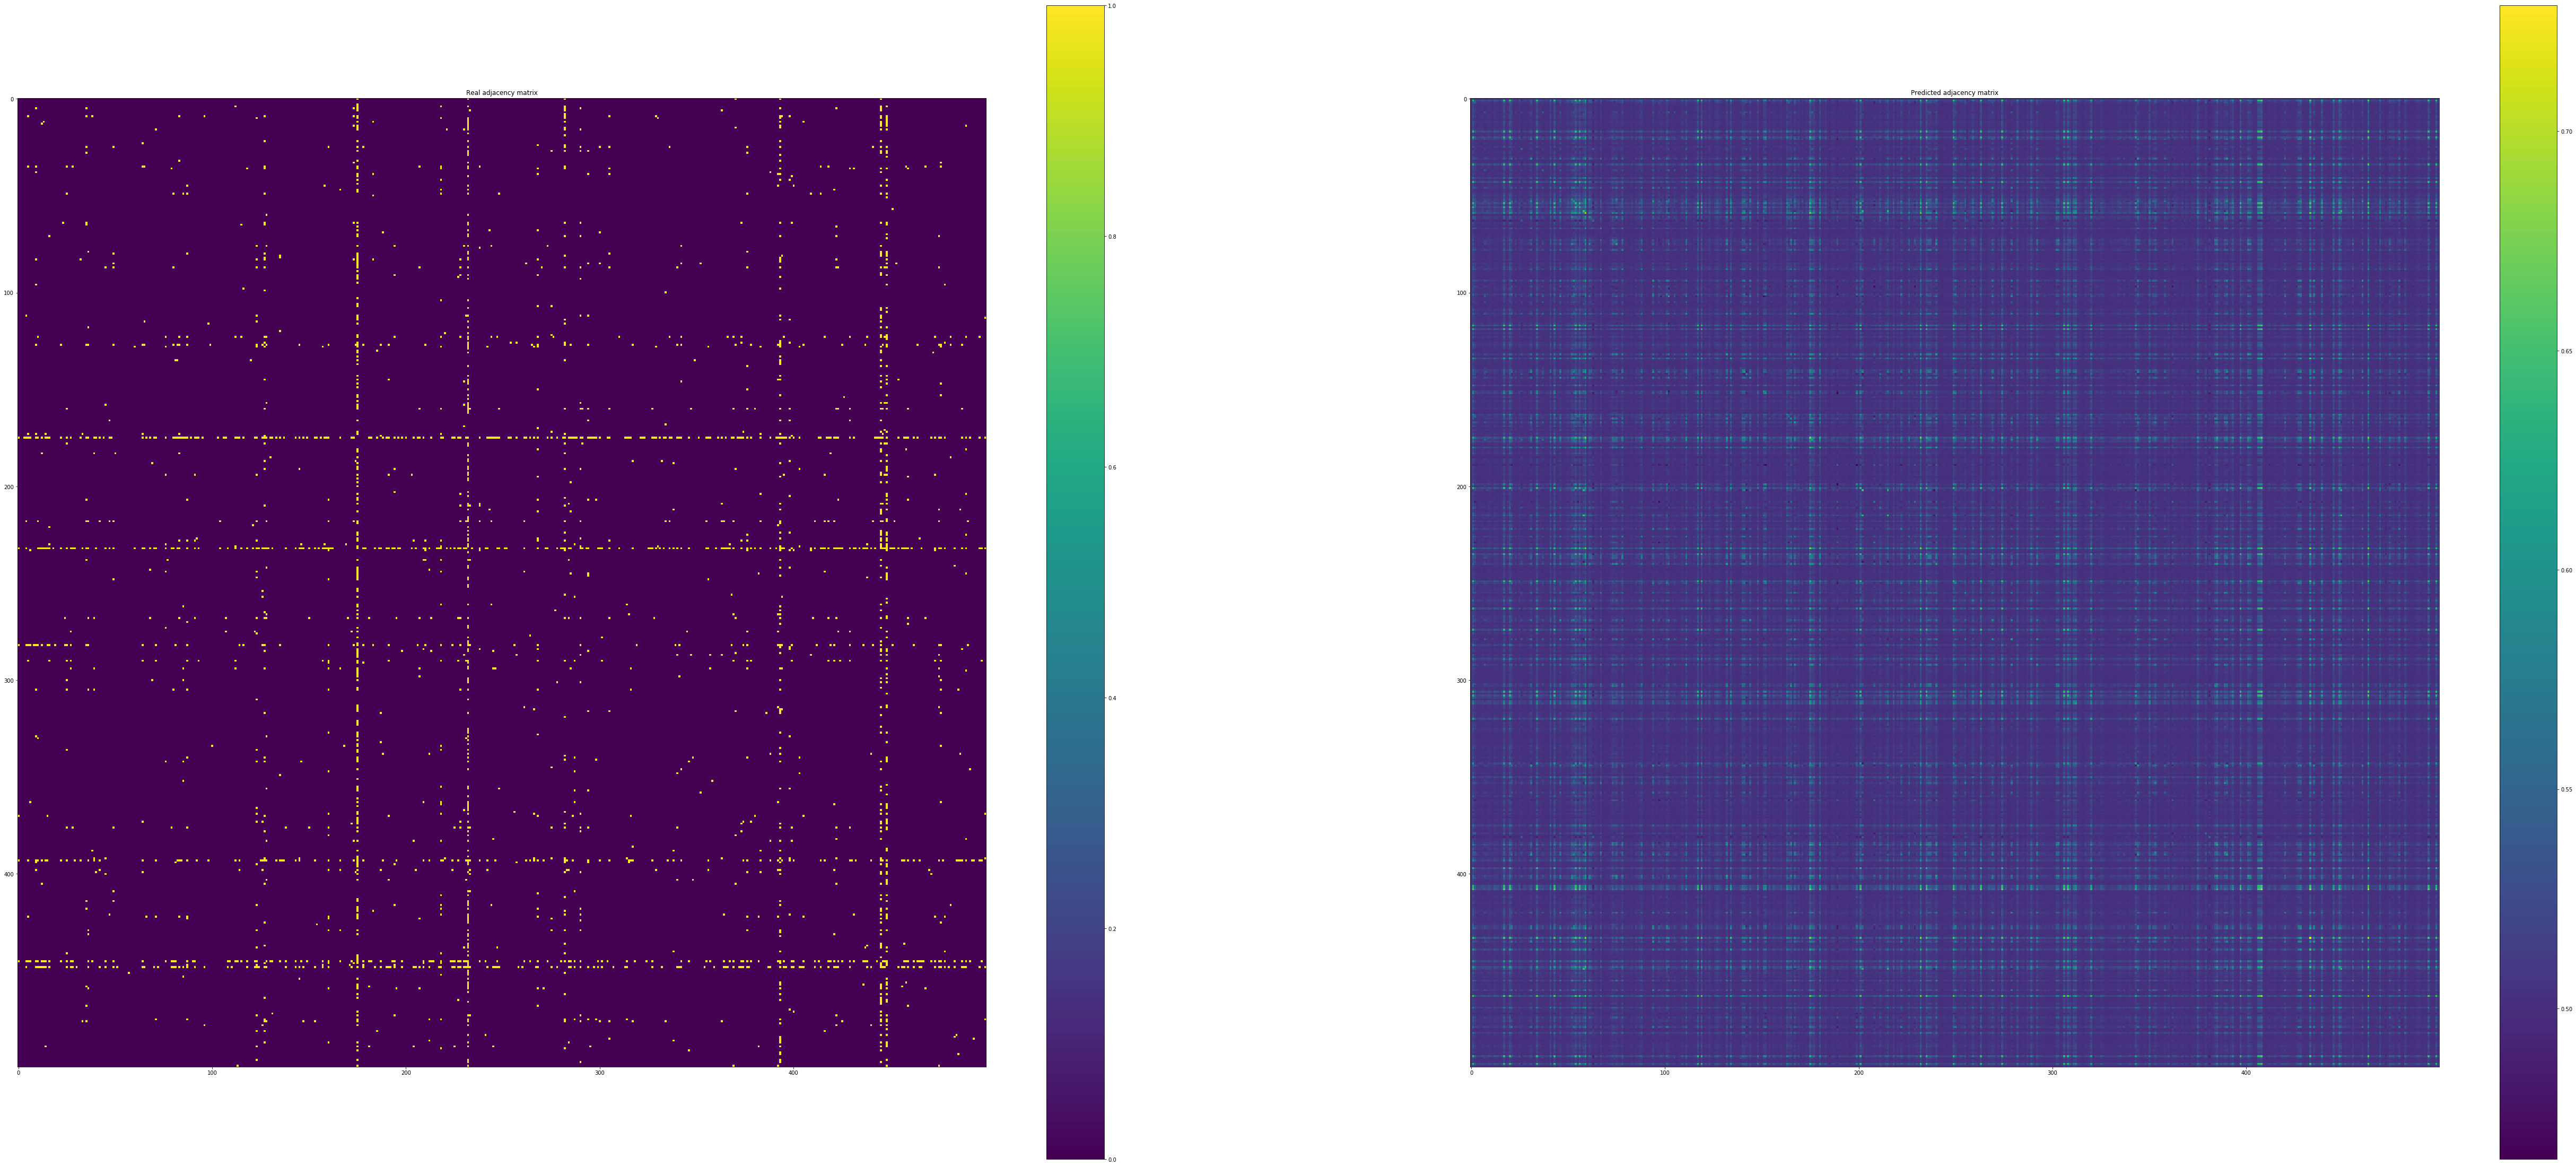

In [13]:
n_features_plot = crop

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((crop / 100) * 18, (crop / 100) * 8))

im1 = ax1.imshow(adj.toarray()[:n_features_plot, :][:, :n_features_plot])
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred[:n_features_plot, :][:, :n_features_plot])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

### Resume training

In [14]:
train_losses = []
train_accuracies = []

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]
    train_losses.append(avg_cost)
    train_accuracies.append(avg_accuracy)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.81971 train_acc= 0.49578 time= 0.18114
Epoch: 0002 train_loss= 1.72758 train_acc= 0.49771 time= 0.01802
Epoch: 0003 train_loss= 1.63472 train_acc= 0.49988 time= 0.01979
Epoch: 0004 train_loss= 1.72358 train_acc= 0.49890 time= 0.01527
Epoch: 0005 train_loss= 1.48911 train_acc= 0.49566 time= 0.01821
Epoch: 0006 train_loss= 1.46989 train_acc= 0.49744 time= 0.02877
Epoch: 0007 train_loss= 1.48664 train_acc= 0.49390 time= 0.02362
Epoch: 0008 train_loss= 1.36808 train_acc= 0.49226 time= 0.02407
Epoch: 0009 train_loss= 1.40389 train_acc= 0.49591 time= 0.01885
Epoch: 0010 train_loss= 1.30864 train_acc= 0.48490 time= 0.01606
Epoch: 0011 train_loss= 1.18074 train_acc= 0.48304 time= 0.02705
Epoch: 0012 train_loss= 1.18547 train_acc= 0.48602 time= 0.01399
Epoch: 0013 train_loss= 1.12948 train_acc= 0.47565 time= 0.01726
Epoch: 0014 train_loss= 1.07469 train_acc= 0.46678 time= 0.01218
Epoch: 0015 train_loss= 1.03396 train_acc= 0.45532 time= 0.03070
Epoch: 0016 train_loss= 0

Epoch: 0129 train_loss= 0.55351 train_acc= 0.44194 time= 0.01208
Epoch: 0130 train_loss= 0.55192 train_acc= 0.44768 time= 0.01003
Epoch: 0131 train_loss= 0.55314 train_acc= 0.44667 time= 0.00965
Epoch: 0132 train_loss= 0.55313 train_acc= 0.44026 time= 0.00978
Epoch: 0133 train_loss= 0.55078 train_acc= 0.45418 time= 0.01531
Epoch: 0134 train_loss= 0.55226 train_acc= 0.45623 time= 0.01041
Epoch: 0135 train_loss= 0.55375 train_acc= 0.44562 time= 0.01071
Epoch: 0136 train_loss= 0.54937 train_acc= 0.45059 time= 0.01035
Epoch: 0137 train_loss= 0.55002 train_acc= 0.44166 time= 0.01086
Epoch: 0138 train_loss= 0.55118 train_acc= 0.44831 time= 0.01097
Epoch: 0139 train_loss= 0.55239 train_acc= 0.45054 time= 0.01015
Epoch: 0140 train_loss= 0.54982 train_acc= 0.45115 time= 0.00997
Epoch: 0141 train_loss= 0.55173 train_acc= 0.45310 time= 0.01130
Epoch: 0142 train_loss= 0.55092 train_acc= 0.45349 time= 0.01011
Epoch: 0143 train_loss= 0.54819 train_acc= 0.45563 time= 0.01903
Epoch: 0144 train_loss= 0

Epoch: 0260 train_loss= 0.53109 train_acc= 0.45768 time= 0.01116
Epoch: 0261 train_loss= 0.53144 train_acc= 0.45625 time= 0.01255
Epoch: 0262 train_loss= 0.53082 train_acc= 0.45742 time= 0.01306
Epoch: 0263 train_loss= 0.53186 train_acc= 0.45791 time= 0.01022
Epoch: 0264 train_loss= 0.52871 train_acc= 0.46409 time= 0.01241
Epoch: 0265 train_loss= 0.53021 train_acc= 0.46513 time= 0.01261
Epoch: 0266 train_loss= 0.53154 train_acc= 0.46183 time= 0.01078
Epoch: 0267 train_loss= 0.53159 train_acc= 0.45722 time= 0.01063
Epoch: 0268 train_loss= 0.53016 train_acc= 0.45882 time= 0.01047
Epoch: 0269 train_loss= 0.53006 train_acc= 0.45565 time= 0.01009
Epoch: 0270 train_loss= 0.53087 train_acc= 0.46171 time= 0.01144
Epoch: 0271 train_loss= 0.52869 train_acc= 0.46379 time= 0.01025
Epoch: 0272 train_loss= 0.53072 train_acc= 0.46002 time= 0.00992
Epoch: 0273 train_loss= 0.52921 train_acc= 0.45550 time= 0.01027
Epoch: 0274 train_loss= 0.53004 train_acc= 0.45575 time= 0.01050
Epoch: 0275 train_loss= 0

Epoch: 0395 train_loss= 0.52200 train_acc= 0.46392 time= 0.01060
Epoch: 0396 train_loss= 0.51907 train_acc= 0.46619 time= 0.01074
Epoch: 0397 train_loss= 0.51954 train_acc= 0.46762 time= 0.01097
Epoch: 0398 train_loss= 0.51808 train_acc= 0.46922 time= 0.01026
Epoch: 0399 train_loss= 0.51887 train_acc= 0.47399 time= 0.01071
Epoch: 0400 train_loss= 0.52087 train_acc= 0.46638 time= 0.01306
Epoch: 0401 train_loss= 0.51919 train_acc= 0.46410 time= 0.01020
Epoch: 0402 train_loss= 0.51856 train_acc= 0.46524 time= 0.01046
Epoch: 0403 train_loss= 0.51845 train_acc= 0.46915 time= 0.01013
Epoch: 0404 train_loss= 0.51965 train_acc= 0.47174 time= 0.01049
Epoch: 0405 train_loss= 0.52073 train_acc= 0.46798 time= 0.01009
Epoch: 0406 train_loss= 0.51749 train_acc= 0.46507 time= 0.01040
Epoch: 0407 train_loss= 0.51888 train_acc= 0.46345 time= 0.01067
Epoch: 0408 train_loss= 0.51950 train_acc= 0.46270 time= 0.01010
Epoch: 0409 train_loss= 0.52076 train_acc= 0.46992 time= 0.01014
Epoch: 0410 train_loss= 0

Epoch: 0527 train_loss= 0.51301 train_acc= 0.47205 time= 0.01367
Epoch: 0528 train_loss= 0.51173 train_acc= 0.47504 time= 0.01356
Epoch: 0529 train_loss= 0.51297 train_acc= 0.47605 time= 0.01269
Epoch: 0530 train_loss= 0.51227 train_acc= 0.47221 time= 0.01052
Epoch: 0531 train_loss= 0.51221 train_acc= 0.46690 time= 0.01208
Epoch: 0532 train_loss= 0.51301 train_acc= 0.46941 time= 0.01202
Epoch: 0533 train_loss= 0.51168 train_acc= 0.47324 time= 0.01258
Epoch: 0534 train_loss= 0.51352 train_acc= 0.47712 time= 0.01140
Epoch: 0535 train_loss= 0.51292 train_acc= 0.47502 time= 0.01316
Epoch: 0536 train_loss= 0.51151 train_acc= 0.47279 time= 0.01238
Epoch: 0537 train_loss= 0.51266 train_acc= 0.47050 time= 0.01617
Epoch: 0538 train_loss= 0.51459 train_acc= 0.46801 time= 0.01130
Epoch: 0539 train_loss= 0.51195 train_acc= 0.47215 time= 0.01077
Epoch: 0540 train_loss= 0.51375 train_acc= 0.47610 time= 0.01063
Epoch: 0541 train_loss= 0.51074 train_acc= 0.47054 time= 0.01016
Epoch: 0542 train_loss= 0

Epoch: 0656 train_loss= 0.50625 train_acc= 0.47606 time= 0.01101
Epoch: 0657 train_loss= 0.50736 train_acc= 0.47721 time= 0.01067
Epoch: 0658 train_loss= 0.50594 train_acc= 0.47769 time= 0.00987
Epoch: 0659 train_loss= 0.50533 train_acc= 0.47810 time= 0.01035
Epoch: 0660 train_loss= 0.50623 train_acc= 0.47534 time= 0.01007
Epoch: 0661 train_loss= 0.50672 train_acc= 0.47697 time= 0.01037
Epoch: 0662 train_loss= 0.50505 train_acc= 0.47724 time= 0.00965
Epoch: 0663 train_loss= 0.50558 train_acc= 0.47684 time= 0.01089
Epoch: 0664 train_loss= 0.50503 train_acc= 0.47355 time= 0.01026
Epoch: 0665 train_loss= 0.50552 train_acc= 0.47731 time= 0.01022
Epoch: 0666 train_loss= 0.50465 train_acc= 0.47810 time= 0.01011
Epoch: 0667 train_loss= 0.50752 train_acc= 0.47886 time= 0.00988
Epoch: 0668 train_loss= 0.50622 train_acc= 0.47714 time= 0.00972
Epoch: 0669 train_loss= 0.50535 train_acc= 0.47715 time= 0.01017
Epoch: 0670 train_loss= 0.50464 train_acc= 0.47824 time= 0.01029
Epoch: 0671 train_loss= 0

Epoch: 0800 train_loss= 0.49871 train_acc= 0.48051 time= 0.01427
Epoch: 0801 train_loss= 0.49859 train_acc= 0.48142 time= 0.01083
Epoch: 0802 train_loss= 0.49960 train_acc= 0.48450 time= 0.01037
Epoch: 0803 train_loss= 0.49884 train_acc= 0.49142 time= 0.01049
Epoch: 0804 train_loss= 0.49881 train_acc= 0.48382 time= 0.01022
Epoch: 0805 train_loss= 0.49733 train_acc= 0.48670 time= 0.01080
Epoch: 0806 train_loss= 0.50073 train_acc= 0.48415 time= 0.00998
Epoch: 0807 train_loss= 0.49855 train_acc= 0.48349 time= 0.01024
Epoch: 0808 train_loss= 0.49855 train_acc= 0.48282 time= 0.01030
Epoch: 0809 train_loss= 0.50004 train_acc= 0.47985 time= 0.01132
Epoch: 0810 train_loss= 0.49769 train_acc= 0.48196 time= 0.01016
Epoch: 0811 train_loss= 0.50026 train_acc= 0.48344 time= 0.01026
Epoch: 0812 train_loss= 0.49812 train_acc= 0.48918 time= 0.00997
Epoch: 0813 train_loss= 0.49876 train_acc= 0.48843 time= 0.01071
Epoch: 0814 train_loss= 0.50029 train_acc= 0.48307 time= 0.01081
Epoch: 0815 train_loss= 0

Epoch: 0944 train_loss= 0.49550 train_acc= 0.48608 time= 0.01270
Epoch: 0945 train_loss= 0.49502 train_acc= 0.49973 time= 0.01052
Epoch: 0946 train_loss= 0.49360 train_acc= 0.49394 time= 0.01082
Epoch: 0947 train_loss= 0.49201 train_acc= 0.48844 time= 0.01094
Epoch: 0948 train_loss= 0.49337 train_acc= 0.49213 time= 0.01142
Epoch: 0949 train_loss= 0.49304 train_acc= 0.49538 time= 0.01137
Epoch: 0950 train_loss= 0.49510 train_acc= 0.49262 time= 0.01041
Epoch: 0951 train_loss= 0.49227 train_acc= 0.49391 time= 0.01113
Epoch: 0952 train_loss= 0.49482 train_acc= 0.48845 time= 0.01210
Epoch: 0953 train_loss= 0.49337 train_acc= 0.49218 time= 0.01203
Epoch: 0954 train_loss= 0.49284 train_acc= 0.49151 time= 0.01054
Epoch: 0955 train_loss= 0.49235 train_acc= 0.49082 time= 0.01114
Epoch: 0956 train_loss= 0.49257 train_acc= 0.49341 time= 0.01027
Epoch: 0957 train_loss= 0.49369 train_acc= 0.48806 time= 0.01023
Epoch: 0958 train_loss= 0.49352 train_acc= 0.48906 time= 0.01173
Epoch: 0959 train_loss= 0

Epoch: 1080 train_loss= 0.49095 train_acc= 0.49414 time= 0.01014
Epoch: 1081 train_loss= 0.49113 train_acc= 0.49588 time= 0.01063
Epoch: 1082 train_loss= 0.49095 train_acc= 0.49523 time= 0.01061
Epoch: 1083 train_loss= 0.48912 train_acc= 0.49243 time= 0.01015
Epoch: 1084 train_loss= 0.49198 train_acc= 0.49242 time= 0.01044
Epoch: 1085 train_loss= 0.49085 train_acc= 0.49682 time= 0.01011
Epoch: 1086 train_loss= 0.49186 train_acc= 0.49509 time= 0.01048
Epoch: 1087 train_loss= 0.48928 train_acc= 0.49482 time= 0.01047
Epoch: 1088 train_loss= 0.49016 train_acc= 0.49197 time= 0.01206
Epoch: 1089 train_loss= 0.49028 train_acc= 0.49994 time= 0.01315
Epoch: 1090 train_loss= 0.48992 train_acc= 0.49978 time= 0.01235
Epoch: 1091 train_loss= 0.49074 train_acc= 0.48861 time= 0.01084
Epoch: 1092 train_loss= 0.48986 train_acc= 0.49149 time= 0.01149
Epoch: 1093 train_loss= 0.48977 train_acc= 0.49389 time= 0.01094
Epoch: 1094 train_loss= 0.48937 train_acc= 0.50123 time= 0.01137
Epoch: 1095 train_loss= 0

Epoch: 1219 train_loss= 0.48680 train_acc= 0.49685 time= 0.01518
Epoch: 1220 train_loss= 0.48848 train_acc= 0.49442 time= 0.01428
Epoch: 1221 train_loss= 0.48898 train_acc= 0.49377 time= 0.02083
Epoch: 1222 train_loss= 0.48828 train_acc= 0.49543 time= 0.01685
Epoch: 1223 train_loss= 0.48848 train_acc= 0.49652 time= 0.01973
Epoch: 1224 train_loss= 0.48875 train_acc= 0.49670 time= 0.01051
Epoch: 1225 train_loss= 0.48972 train_acc= 0.49286 time= 0.01445
Epoch: 1226 train_loss= 0.48816 train_acc= 0.49700 time= 0.01360
Epoch: 1227 train_loss= 0.48870 train_acc= 0.49394 time= 0.01360
Epoch: 1228 train_loss= 0.48884 train_acc= 0.49598 time= 0.01378
Epoch: 1229 train_loss= 0.48930 train_acc= 0.49415 time= 0.01223
Epoch: 1230 train_loss= 0.48890 train_acc= 0.49562 time= 0.01419
Epoch: 1231 train_loss= 0.48733 train_acc= 0.49857 time= 0.01475
Epoch: 1232 train_loss= 0.48922 train_acc= 0.49630 time= 0.01394
Epoch: 1233 train_loss= 0.48680 train_acc= 0.50061 time= 0.01614
Epoch: 1234 train_loss= 0

Epoch: 1355 train_loss= 0.48652 train_acc= 0.49363 time= 0.01308
Epoch: 1356 train_loss= 0.48567 train_acc= 0.50083 time= 0.01017
Epoch: 1357 train_loss= 0.48613 train_acc= 0.50229 time= 0.00988
Epoch: 1358 train_loss= 0.48723 train_acc= 0.50068 time= 0.01009
Epoch: 1359 train_loss= 0.48674 train_acc= 0.49619 time= 0.01009
Epoch: 1360 train_loss= 0.48649 train_acc= 0.49574 time= 0.01061
Epoch: 1361 train_loss= 0.48670 train_acc= 0.50084 time= 0.01034
Epoch: 1362 train_loss= 0.48558 train_acc= 0.49726 time= 0.01341
Epoch: 1363 train_loss= 0.48491 train_acc= 0.49879 time= 0.01070
Epoch: 1364 train_loss= 0.48581 train_acc= 0.50041 time= 0.01043
Epoch: 1365 train_loss= 0.48509 train_acc= 0.50070 time= 0.01061
Epoch: 1366 train_loss= 0.48513 train_acc= 0.50192 time= 0.01093
Epoch: 1367 train_loss= 0.48659 train_acc= 0.49941 time= 0.01041
Epoch: 1368 train_loss= 0.48473 train_acc= 0.49954 time= 0.00983
Epoch: 1369 train_loss= 0.48615 train_acc= 0.50171 time= 0.01060
Epoch: 1370 train_loss= 0

Epoch: 1494 train_loss= 0.48328 train_acc= 0.49959 time= 0.01429
Epoch: 1495 train_loss= 0.48620 train_acc= 0.49766 time= 0.01275
Epoch: 1496 train_loss= 0.48302 train_acc= 0.50218 time= 0.01460
Epoch: 1497 train_loss= 0.48337 train_acc= 0.49865 time= 0.01221
Epoch: 1498 train_loss= 0.48421 train_acc= 0.49989 time= 0.01007
Epoch: 1499 train_loss= 0.48463 train_acc= 0.50362 time= 0.01082
Epoch: 1500 train_loss= 0.48411 train_acc= 0.50176 time= 0.01044
Epoch: 1501 train_loss= 0.48355 train_acc= 0.50095 time= 0.01001
Epoch: 1502 train_loss= 0.48316 train_acc= 0.50034 time= 0.01059
Epoch: 1503 train_loss= 0.48315 train_acc= 0.50148 time= 0.01031
Epoch: 1504 train_loss= 0.48739 train_acc= 0.49572 time= 0.01282
Epoch: 1505 train_loss= 0.48323 train_acc= 0.50102 time= 0.01353
Epoch: 1506 train_loss= 0.48358 train_acc= 0.49765 time= 0.01092
Epoch: 1507 train_loss= 0.48401 train_acc= 0.50026 time= 0.01091
Epoch: 1508 train_loss= 0.48512 train_acc= 0.49623 time= 0.01130
Epoch: 1509 train_loss= 0

Epoch: 1623 train_loss= 0.48516 train_acc= 0.49548 time= 0.01287
Epoch: 1624 train_loss= 0.48184 train_acc= 0.50194 time= 0.01438
Epoch: 1625 train_loss= 0.48295 train_acc= 0.50855 time= 0.01340
Epoch: 1626 train_loss= 0.48197 train_acc= 0.50507 time= 0.01354
Epoch: 1627 train_loss= 0.48329 train_acc= 0.49862 time= 0.01648
Epoch: 1628 train_loss= 0.48328 train_acc= 0.49782 time= 0.01175
Epoch: 1629 train_loss= 0.48398 train_acc= 0.50455 time= 0.01673
Epoch: 1630 train_loss= 0.48228 train_acc= 0.50466 time= 0.01189
Epoch: 1631 train_loss= 0.48323 train_acc= 0.49862 time= 0.01645
Epoch: 1632 train_loss= 0.48310 train_acc= 0.49882 time= 0.01202
Epoch: 1633 train_loss= 0.48382 train_acc= 0.50085 time= 0.01475
Epoch: 1634 train_loss= 0.48365 train_acc= 0.50565 time= 0.01382
Epoch: 1635 train_loss= 0.48197 train_acc= 0.50098 time= 0.01150
Epoch: 1636 train_loss= 0.48091 train_acc= 0.49952 time= 0.01480
Epoch: 1637 train_loss= 0.48193 train_acc= 0.50190 time= 0.01262
Epoch: 1638 train_loss= 0

Epoch: 1759 train_loss= 0.48046 train_acc= 0.49993 time= 0.01919
Epoch: 1760 train_loss= 0.48224 train_acc= 0.50166 time= 0.01579
Epoch: 1761 train_loss= 0.48253 train_acc= 0.50085 time= 0.01320
Epoch: 1762 train_loss= 0.48116 train_acc= 0.50444 time= 0.01403
Epoch: 1763 train_loss= 0.48149 train_acc= 0.50342 time= 0.01566
Epoch: 1764 train_loss= 0.48359 train_acc= 0.49739 time= 0.01870
Epoch: 1765 train_loss= 0.48027 train_acc= 0.49938 time= 0.01499
Epoch: 1766 train_loss= 0.48285 train_acc= 0.50658 time= 0.01356
Epoch: 1767 train_loss= 0.48033 train_acc= 0.50569 time= 0.01513
Epoch: 1768 train_loss= 0.48202 train_acc= 0.50278 time= 0.01509
Epoch: 1769 train_loss= 0.48223 train_acc= 0.50140 time= 0.01346
Epoch: 1770 train_loss= 0.48255 train_acc= 0.50178 time= 0.01226
Epoch: 1771 train_loss= 0.48168 train_acc= 0.50264 time= 0.01380
Epoch: 1772 train_loss= 0.48196 train_acc= 0.49870 time= 0.01338
Epoch: 1773 train_loss= 0.48231 train_acc= 0.49798 time= 0.01371
Epoch: 1774 train_loss= 0

Epoch: 1888 train_loss= 0.47908 train_acc= 0.50570 time= 0.01210
Epoch: 1889 train_loss= 0.47988 train_acc= 0.50058 time= 0.00997
Epoch: 1890 train_loss= 0.48100 train_acc= 0.50322 time= 0.01010
Epoch: 1891 train_loss= 0.48157 train_acc= 0.50698 time= 0.01145
Epoch: 1892 train_loss= 0.48137 train_acc= 0.50492 time= 0.01012
Epoch: 1893 train_loss= 0.48104 train_acc= 0.50463 time= 0.01044
Epoch: 1894 train_loss= 0.48042 train_acc= 0.50116 time= 0.00992
Epoch: 1895 train_loss= 0.48154 train_acc= 0.49855 time= 0.01082
Epoch: 1896 train_loss= 0.47974 train_acc= 0.50275 time= 0.01068
Epoch: 1897 train_loss= 0.47873 train_acc= 0.50750 time= 0.01057
Epoch: 1898 train_loss= 0.48012 train_acc= 0.50433 time= 0.01014
Epoch: 1899 train_loss= 0.48210 train_acc= 0.50154 time= 0.01022
Epoch: 1900 train_loss= 0.48192 train_acc= 0.50301 time= 0.01023
Epoch: 1901 train_loss= 0.48159 train_acc= 0.50632 time= 0.01027
Epoch: 1902 train_loss= 0.48264 train_acc= 0.50163 time= 0.01049
Epoch: 1903 train_loss= 0

Epoch: 2029 train_loss= 0.47991 train_acc= 0.50785 time= 0.01253
Epoch: 2030 train_loss= 0.48027 train_acc= 0.50441 time= 0.01010
Epoch: 2031 train_loss= 0.47980 train_acc= 0.50138 time= 0.01086
Epoch: 2032 train_loss= 0.48240 train_acc= 0.50043 time= 0.01066
Epoch: 2033 train_loss= 0.48061 train_acc= 0.50858 time= 0.01119
Epoch: 2034 train_loss= 0.47912 train_acc= 0.50882 time= 0.01062
Epoch: 2035 train_loss= 0.48053 train_acc= 0.50330 time= 0.00995
Epoch: 2036 train_loss= 0.48003 train_acc= 0.50173 time= 0.01005
Epoch: 2037 train_loss= 0.48025 train_acc= 0.50280 time= 0.01043
Epoch: 2038 train_loss= 0.48009 train_acc= 0.50606 time= 0.00979
Epoch: 2039 train_loss= 0.47938 train_acc= 0.50547 time= 0.01022
Epoch: 2040 train_loss= 0.47917 train_acc= 0.50291 time= 0.01059
Epoch: 2041 train_loss= 0.47950 train_acc= 0.50478 time= 0.01060
Epoch: 2042 train_loss= 0.47983 train_acc= 0.50576 time= 0.01035
Epoch: 2043 train_loss= 0.48096 train_acc= 0.50278 time= 0.01044
Epoch: 2044 train_loss= 0

Epoch: 2169 train_loss= 0.47993 train_acc= 0.50287 time= 0.01159
Epoch: 2170 train_loss= 0.47968 train_acc= 0.50290 time= 0.01090
Epoch: 2171 train_loss= 0.47903 train_acc= 0.50174 time= 0.01069
Epoch: 2172 train_loss= 0.48053 train_acc= 0.50394 time= 0.01041
Epoch: 2173 train_loss= 0.47840 train_acc= 0.50606 time= 0.01022
Epoch: 2174 train_loss= 0.47981 train_acc= 0.50392 time= 0.01151
Epoch: 2175 train_loss= 0.47904 train_acc= 0.50247 time= 0.00949
Epoch: 2176 train_loss= 0.47886 train_acc= 0.50086 time= 0.00994
Epoch: 2177 train_loss= 0.47825 train_acc= 0.50786 time= 0.01019
Epoch: 2178 train_loss= 0.47809 train_acc= 0.50632 time= 0.00970
Epoch: 2179 train_loss= 0.47919 train_acc= 0.50466 time= 0.01020
Epoch: 2180 train_loss= 0.48022 train_acc= 0.50318 time= 0.01017
Epoch: 2181 train_loss= 0.48019 train_acc= 0.50130 time= 0.01038
Epoch: 2182 train_loss= 0.47845 train_acc= 0.50521 time= 0.01041
Epoch: 2183 train_loss= 0.47924 train_acc= 0.50576 time= 0.01018
Epoch: 2184 train_loss= 0

Epoch: 2298 train_loss= 0.47818 train_acc= 0.50571 time= 0.01110
Epoch: 2299 train_loss= 0.47809 train_acc= 0.50300 time= 0.01061
Epoch: 2300 train_loss= 0.47801 train_acc= 0.50652 time= 0.01043
Epoch: 2301 train_loss= 0.47852 train_acc= 0.50372 time= 0.00981
Epoch: 2302 train_loss= 0.47984 train_acc= 0.50234 time= 0.01145
Epoch: 2303 train_loss= 0.47770 train_acc= 0.50672 time= 0.01016
Epoch: 2304 train_loss= 0.47863 train_acc= 0.50581 time= 0.01013
Epoch: 2305 train_loss= 0.47887 train_acc= 0.50804 time= 0.01019
Epoch: 2306 train_loss= 0.48032 train_acc= 0.50231 time= 0.01096
Epoch: 2307 train_loss= 0.47915 train_acc= 0.50088 time= 0.01055
Epoch: 2308 train_loss= 0.47843 train_acc= 0.50748 time= 0.01243
Epoch: 2309 train_loss= 0.47914 train_acc= 0.50704 time= 0.01028
Epoch: 2310 train_loss= 0.47843 train_acc= 0.50501 time= 0.01010
Epoch: 2311 train_loss= 0.47825 train_acc= 0.50603 time= 0.01011
Epoch: 2312 train_loss= 0.47889 train_acc= 0.50534 time= 0.01100
Epoch: 2313 train_loss= 0

Epoch: 2441 train_loss= 0.47764 train_acc= 0.51005 time= 0.01135
Epoch: 2442 train_loss= 0.47930 train_acc= 0.50759 time= 0.01024
Epoch: 2443 train_loss= 0.47779 train_acc= 0.50461 time= 0.01006
Epoch: 2444 train_loss= 0.47682 train_acc= 0.50574 time= 0.01065
Epoch: 2445 train_loss= 0.48000 train_acc= 0.50495 time= 0.01033
Epoch: 2446 train_loss= 0.47677 train_acc= 0.50778 time= 0.01061
Epoch: 2447 train_loss= 0.47681 train_acc= 0.50526 time= 0.01087
Epoch: 2448 train_loss= 0.47689 train_acc= 0.50885 time= 0.01003
Epoch: 2449 train_loss= 0.47911 train_acc= 0.50459 time= 0.01067
Epoch: 2450 train_loss= 0.47607 train_acc= 0.50973 time= 0.01078
Epoch: 2451 train_loss= 0.47819 train_acc= 0.50359 time= 0.01037
Epoch: 2452 train_loss= 0.47764 train_acc= 0.50624 time= 0.01014
Epoch: 2453 train_loss= 0.47719 train_acc= 0.50759 time= 0.01153
Epoch: 2454 train_loss= 0.47676 train_acc= 0.50552 time= 0.01049
Epoch: 2455 train_loss= 0.47810 train_acc= 0.50537 time= 0.00987
Epoch: 2456 train_loss= 0

Epoch: 2572 train_loss= 0.47600 train_acc= 0.50758 time= 0.01674
Epoch: 2573 train_loss= 0.47735 train_acc= 0.50885 time= 0.01840
Epoch: 2574 train_loss= 0.47762 train_acc= 0.51194 time= 0.01553
Epoch: 2575 train_loss= 0.47785 train_acc= 0.50418 time= 0.01593
Epoch: 2576 train_loss= 0.47723 train_acc= 0.50102 time= 0.01881
Epoch: 2577 train_loss= 0.47697 train_acc= 0.50836 time= 0.01634
Epoch: 2578 train_loss= 0.47763 train_acc= 0.50492 time= 0.01912
Epoch: 2579 train_loss= 0.47749 train_acc= 0.50410 time= 0.01289
Epoch: 2580 train_loss= 0.47703 train_acc= 0.50641 time= 0.01273
Epoch: 2581 train_loss= 0.47535 train_acc= 0.50923 time= 0.01055
Epoch: 2582 train_loss= 0.47786 train_acc= 0.50722 time= 0.01240
Epoch: 2583 train_loss= 0.47785 train_acc= 0.50755 time= 0.01277
Epoch: 2584 train_loss= 0.47714 train_acc= 0.50313 time= 0.01375
Epoch: 2585 train_loss= 0.47919 train_acc= 0.50018 time= 0.01136
Epoch: 2586 train_loss= 0.47735 train_acc= 0.50812 time= 0.01478
Epoch: 2587 train_loss= 0

Epoch: 2701 train_loss= 0.47723 train_acc= 0.50514 time= 0.02044
Epoch: 2702 train_loss= 0.47632 train_acc= 0.50680 time= 0.01388
Epoch: 2703 train_loss= 0.47845 train_acc= 0.50291 time= 0.02081
Epoch: 2704 train_loss= 0.47621 train_acc= 0.50697 time= 0.02167
Epoch: 2705 train_loss= 0.47668 train_acc= 0.50768 time= 0.01420
Epoch: 2706 train_loss= 0.47882 train_acc= 0.50515 time= 0.01407
Epoch: 2707 train_loss= 0.47756 train_acc= 0.50266 time= 0.01321
Epoch: 2708 train_loss= 0.47691 train_acc= 0.50358 time= 0.01361
Epoch: 2709 train_loss= 0.47782 train_acc= 0.50279 time= 0.01421
Epoch: 2710 train_loss= 0.47787 train_acc= 0.50312 time= 0.01356
Epoch: 2711 train_loss= 0.47624 train_acc= 0.50585 time= 0.01341
Epoch: 2712 train_loss= 0.47695 train_acc= 0.50436 time= 0.01889
Epoch: 2713 train_loss= 0.47749 train_acc= 0.50325 time= 0.02466
Epoch: 2714 train_loss= 0.47756 train_acc= 0.50700 time= 0.01680
Epoch: 2715 train_loss= 0.47749 train_acc= 0.50710 time= 0.01380
Epoch: 2716 train_loss= 0

Epoch: 2837 train_loss= 0.47565 train_acc= 0.51291 time= 0.01623
Epoch: 2838 train_loss= 0.47560 train_acc= 0.51237 time= 0.01652
Epoch: 2839 train_loss= 0.47687 train_acc= 0.50286 time= 0.01874
Epoch: 2840 train_loss= 0.47826 train_acc= 0.50242 time= 0.01218
Epoch: 2841 train_loss= 0.47550 train_acc= 0.50944 time= 0.01149
Epoch: 2842 train_loss= 0.47453 train_acc= 0.51043 time= 0.01147
Epoch: 2843 train_loss= 0.47702 train_acc= 0.50685 time= 0.01091
Epoch: 2844 train_loss= 0.47660 train_acc= 0.50877 time= 0.01105
Epoch: 2845 train_loss= 0.47527 train_acc= 0.50906 time= 0.01858
Epoch: 2846 train_loss= 0.47655 train_acc= 0.50861 time= 0.01258
Epoch: 2847 train_loss= 0.47646 train_acc= 0.50471 time= 0.01083
Epoch: 2848 train_loss= 0.47580 train_acc= 0.50578 time= 0.01098
Epoch: 2849 train_loss= 0.47575 train_acc= 0.50782 time= 0.01111
Epoch: 2850 train_loss= 0.47606 train_acc= 0.51083 time= 0.01139
Epoch: 2851 train_loss= 0.47629 train_acc= 0.50983 time= 0.01140
Epoch: 2852 train_loss= 0

Epoch: 2970 train_loss= 0.47409 train_acc= 0.50864 time= 0.01466
Epoch: 2971 train_loss= 0.47616 train_acc= 0.50918 time= 0.01092
Epoch: 2972 train_loss= 0.47869 train_acc= 0.50313 time= 0.01169
Epoch: 2973 train_loss= 0.47522 train_acc= 0.50618 time= 0.01104
Epoch: 2974 train_loss= 0.47627 train_acc= 0.50422 time= 0.01032
Epoch: 2975 train_loss= 0.47529 train_acc= 0.50687 time= 0.01061
Epoch: 2976 train_loss= 0.47619 train_acc= 0.50761 time= 0.01075
Epoch: 2977 train_loss= 0.47553 train_acc= 0.50862 time= 0.01134
Epoch: 2978 train_loss= 0.47501 train_acc= 0.50759 time= 0.01110
Epoch: 2979 train_loss= 0.47594 train_acc= 0.50971 time= 0.01141
Epoch: 2980 train_loss= 0.47693 train_acc= 0.50649 time= 0.01040
Epoch: 2981 train_loss= 0.47571 train_acc= 0.50496 time= 0.01129
Epoch: 2982 train_loss= 0.47590 train_acc= 0.50640 time= 0.01054
Epoch: 2983 train_loss= 0.47588 train_acc= 0.50646 time= 0.01059
Epoch: 2984 train_loss= 0.47601 train_acc= 0.50683 time= 0.01041
Epoch: 2985 train_loss= 0

Epoch: 3114 train_loss= 0.47581 train_acc= 0.50674 time= 0.01310
Epoch: 3115 train_loss= 0.47534 train_acc= 0.50611 time= 0.01034
Epoch: 3116 train_loss= 0.47426 train_acc= 0.50572 time= 0.01094
Epoch: 3117 train_loss= 0.47638 train_acc= 0.50622 time= 0.01064
Epoch: 3118 train_loss= 0.47416 train_acc= 0.51094 time= 0.01210
Epoch: 3119 train_loss= 0.47387 train_acc= 0.50875 time= 0.01775
Epoch: 3120 train_loss= 0.47592 train_acc= 0.50568 time= 0.01243
Epoch: 3121 train_loss= 0.47553 train_acc= 0.50590 time= 0.01084
Epoch: 3122 train_loss= 0.47564 train_acc= 0.50935 time= 0.01027
Epoch: 3123 train_loss= 0.47638 train_acc= 0.50704 time= 0.01132
Epoch: 3124 train_loss= 0.47540 train_acc= 0.50851 time= 0.01049
Epoch: 3125 train_loss= 0.47614 train_acc= 0.50473 time= 0.01017
Epoch: 3126 train_loss= 0.47527 train_acc= 0.50947 time= 0.01018
Epoch: 3127 train_loss= 0.47522 train_acc= 0.51275 time= 0.01020
Epoch: 3128 train_loss= 0.47514 train_acc= 0.51150 time= 0.01034
Epoch: 3129 train_loss= 0

Epoch: 3246 train_loss= 0.47340 train_acc= 0.51107 time= 0.01147
Epoch: 3247 train_loss= 0.47506 train_acc= 0.50934 time= 0.01012
Epoch: 3248 train_loss= 0.47295 train_acc= 0.50988 time= 0.01159
Epoch: 3249 train_loss= 0.47587 train_acc= 0.50847 time= 0.01079
Epoch: 3250 train_loss= 0.47692 train_acc= 0.50795 time= 0.01061
Epoch: 3251 train_loss= 0.47468 train_acc= 0.50657 time= 0.01088
Epoch: 3252 train_loss= 0.47545 train_acc= 0.50649 time= 0.01004
Epoch: 3253 train_loss= 0.47448 train_acc= 0.50712 time= 0.01057
Epoch: 3254 train_loss= 0.47540 train_acc= 0.51414 time= 0.01047
Epoch: 3255 train_loss= 0.47516 train_acc= 0.51076 time= 0.01031
Epoch: 3256 train_loss= 0.47403 train_acc= 0.50732 time= 0.01195
Epoch: 3257 train_loss= 0.47400 train_acc= 0.50978 time= 0.01048
Epoch: 3258 train_loss= 0.47506 train_acc= 0.51055 time= 0.01091
Epoch: 3259 train_loss= 0.47363 train_acc= 0.50655 time= 0.01148
Epoch: 3260 train_loss= 0.47364 train_acc= 0.50798 time= 0.01108
Epoch: 3261 train_loss= 0

Epoch: 3379 train_loss= 0.47447 train_acc= 0.51188 time= 0.01300
Epoch: 3380 train_loss= 0.47463 train_acc= 0.51114 time= 0.01128
Epoch: 3381 train_loss= 0.47364 train_acc= 0.50798 time= 0.01060
Epoch: 3382 train_loss= 0.47305 train_acc= 0.50640 time= 0.01014
Epoch: 3383 train_loss= 0.47417 train_acc= 0.50802 time= 0.01074
Epoch: 3384 train_loss= 0.47337 train_acc= 0.51186 time= 0.01184
Epoch: 3385 train_loss= 0.47300 train_acc= 0.50902 time= 0.01089
Epoch: 3386 train_loss= 0.47433 train_acc= 0.51107 time= 0.01040
Epoch: 3387 train_loss= 0.47443 train_acc= 0.51024 time= 0.01083
Epoch: 3388 train_loss= 0.47454 train_acc= 0.50958 time= 0.01014
Epoch: 3389 train_loss= 0.47492 train_acc= 0.50817 time= 0.01044
Epoch: 3390 train_loss= 0.47404 train_acc= 0.50766 time= 0.01059
Epoch: 3391 train_loss= 0.47442 train_acc= 0.50452 time= 0.01646
Epoch: 3392 train_loss= 0.47284 train_acc= 0.51141 time= 0.01147
Epoch: 3393 train_loss= 0.47471 train_acc= 0.50982 time= 0.01042
Epoch: 3394 train_loss= 0

Epoch: 3510 train_loss= 0.47447 train_acc= 0.50765 time= 0.01201
Epoch: 3511 train_loss= 0.47495 train_acc= 0.50731 time= 0.01267
Epoch: 3512 train_loss= 0.47129 train_acc= 0.51054 time= 0.01057
Epoch: 3513 train_loss= 0.47322 train_acc= 0.50846 time= 0.01052
Epoch: 3514 train_loss= 0.47415 train_acc= 0.50950 time= 0.01090
Epoch: 3515 train_loss= 0.47293 train_acc= 0.51441 time= 0.01074
Epoch: 3516 train_loss= 0.47283 train_acc= 0.51030 time= 0.01049
Epoch: 3517 train_loss= 0.47313 train_acc= 0.50452 time= 0.01000
Epoch: 3518 train_loss= 0.47197 train_acc= 0.50922 time= 0.01042
Epoch: 3519 train_loss= 0.47406 train_acc= 0.51080 time= 0.01032
Epoch: 3520 train_loss= 0.47423 train_acc= 0.51002 time= 0.01072
Epoch: 3521 train_loss= 0.47292 train_acc= 0.50902 time= 0.01193
Epoch: 3522 train_loss= 0.47305 train_acc= 0.51268 time= 0.01041
Epoch: 3523 train_loss= 0.47277 train_acc= 0.50969 time= 0.01169
Epoch: 3524 train_loss= 0.47405 train_acc= 0.50958 time= 0.01036
Epoch: 3525 train_loss= 0

Epoch: 3642 train_loss= 0.47155 train_acc= 0.51245 time= 0.01135
Epoch: 3643 train_loss= 0.47216 train_acc= 0.51482 time= 0.01096
Epoch: 3644 train_loss= 0.47334 train_acc= 0.50888 time= 0.01010
Epoch: 3645 train_loss= 0.47194 train_acc= 0.51119 time= 0.01054
Epoch: 3646 train_loss= 0.47304 train_acc= 0.50881 time= 0.01399
Epoch: 3647 train_loss= 0.47262 train_acc= 0.51030 time= 0.01132
Epoch: 3648 train_loss= 0.47138 train_acc= 0.51204 time= 0.01237
Epoch: 3649 train_loss= 0.47235 train_acc= 0.51100 time= 0.01363
Epoch: 3650 train_loss= 0.47333 train_acc= 0.50749 time= 0.01351
Epoch: 3651 train_loss= 0.47308 train_acc= 0.51227 time= 0.01497
Epoch: 3652 train_loss= 0.47229 train_acc= 0.51474 time= 0.01216
Epoch: 3653 train_loss= 0.47281 train_acc= 0.51178 time= 0.01667
Epoch: 3654 train_loss= 0.47178 train_acc= 0.50995 time= 0.01322
Epoch: 3655 train_loss= 0.47373 train_acc= 0.50730 time= 0.01364
Epoch: 3656 train_loss= 0.47296 train_acc= 0.50806 time= 0.01422
Epoch: 3657 train_loss= 0

Epoch: 3773 train_loss= 0.47143 train_acc= 0.50836 time= 0.01414
Epoch: 3774 train_loss= 0.47397 train_acc= 0.51141 time= 0.01081
Epoch: 3775 train_loss= 0.47288 train_acc= 0.51012 time= 0.01024
Epoch: 3776 train_loss= 0.47396 train_acc= 0.50872 time= 0.01361
Epoch: 3777 train_loss= 0.47350 train_acc= 0.50974 time= 0.01092
Epoch: 3778 train_loss= 0.47248 train_acc= 0.51257 time= 0.01110
Epoch: 3779 train_loss= 0.47238 train_acc= 0.51073 time= 0.01167
Epoch: 3780 train_loss= 0.47229 train_acc= 0.50592 time= 0.01072
Epoch: 3781 train_loss= 0.47338 train_acc= 0.51081 time= 0.01488
Epoch: 3782 train_loss= 0.47364 train_acc= 0.51011 time= 0.01168
Epoch: 3783 train_loss= 0.47242 train_acc= 0.50945 time= 0.01088
Epoch: 3784 train_loss= 0.47175 train_acc= 0.51157 time= 0.01174
Epoch: 3785 train_loss= 0.47291 train_acc= 0.50915 time= 0.01337
Epoch: 3786 train_loss= 0.47295 train_acc= 0.50788 time= 0.01256
Epoch: 3787 train_loss= 0.47418 train_acc= 0.50924 time= 0.01252
Epoch: 3788 train_loss= 0

Epoch: 3905 train_loss= 0.47198 train_acc= 0.51561 time= 0.01133
Epoch: 3906 train_loss= 0.47551 train_acc= 0.50412 time= 0.01190
Epoch: 3907 train_loss= 0.47185 train_acc= 0.51101 time= 0.01043
Epoch: 3908 train_loss= 0.47244 train_acc= 0.51369 time= 0.01090
Epoch: 3909 train_loss= 0.47186 train_acc= 0.51186 time= 0.01064
Epoch: 3910 train_loss= 0.47186 train_acc= 0.51156 time= 0.01047
Epoch: 3911 train_loss= 0.47084 train_acc= 0.50855 time= 0.01342
Epoch: 3912 train_loss= 0.47157 train_acc= 0.51105 time= 0.01456
Epoch: 3913 train_loss= 0.47113 train_acc= 0.51204 time= 0.01127
Epoch: 3914 train_loss= 0.47218 train_acc= 0.50894 time= 0.01109
Epoch: 3915 train_loss= 0.47195 train_acc= 0.51022 time= 0.01171
Epoch: 3916 train_loss= 0.47250 train_acc= 0.51462 time= 0.01088
Epoch: 3917 train_loss= 0.47187 train_acc= 0.51387 time= 0.01274
Epoch: 3918 train_loss= 0.47350 train_acc= 0.51206 time= 0.01173
Epoch: 3919 train_loss= 0.47249 train_acc= 0.50686 time= 0.01137
Epoch: 3920 train_loss= 0

Epoch: 4044 train_loss= 0.47005 train_acc= 0.51206 time= 0.01219
Epoch: 4045 train_loss= 0.47152 train_acc= 0.50756 time= 0.01186
Epoch: 4046 train_loss= 0.47147 train_acc= 0.51239 time= 0.01081
Epoch: 4047 train_loss= 0.47458 train_acc= 0.51122 time= 0.01131
Epoch: 4048 train_loss= 0.47138 train_acc= 0.51402 time= 0.01050
Epoch: 4049 train_loss= 0.47200 train_acc= 0.50741 time= 0.01040
Epoch: 4050 train_loss= 0.47120 train_acc= 0.50959 time= 0.01439
Epoch: 4051 train_loss= 0.47225 train_acc= 0.50923 time= 0.01319
Epoch: 4052 train_loss= 0.47265 train_acc= 0.51175 time= 0.01145
Epoch: 4053 train_loss= 0.47255 train_acc= 0.51183 time= 0.01156
Epoch: 4054 train_loss= 0.47053 train_acc= 0.51479 time= 0.01126
Epoch: 4055 train_loss= 0.47090 train_acc= 0.50905 time= 0.01062
Epoch: 4056 train_loss= 0.47120 train_acc= 0.51117 time= 0.01249
Epoch: 4057 train_loss= 0.47078 train_acc= 0.51330 time= 0.01210
Epoch: 4058 train_loss= 0.47250 train_acc= 0.50993 time= 0.01205
Epoch: 4059 train_loss= 0

Epoch: 4176 train_loss= 0.47146 train_acc= 0.51114 time= 0.01298
Epoch: 4177 train_loss= 0.47000 train_acc= 0.51341 time= 0.01269
Epoch: 4178 train_loss= 0.47288 train_acc= 0.50950 time= 0.01580
Epoch: 4179 train_loss= 0.47059 train_acc= 0.51174 time= 0.01149
Epoch: 4180 train_loss= 0.47071 train_acc= 0.51154 time= 0.01225
Epoch: 4181 train_loss= 0.47248 train_acc= 0.51226 time= 0.01240
Epoch: 4182 train_loss= 0.47150 train_acc= 0.51197 time= 0.01104
Epoch: 4183 train_loss= 0.47217 train_acc= 0.50966 time= 0.01159
Epoch: 4184 train_loss= 0.47070 train_acc= 0.51006 time= 0.01109
Epoch: 4185 train_loss= 0.47251 train_acc= 0.51318 time= 0.01226
Epoch: 4186 train_loss= 0.47219 train_acc= 0.51249 time= 0.01146
Epoch: 4187 train_loss= 0.47224 train_acc= 0.51037 time= 0.01193
Epoch: 4188 train_loss= 0.47186 train_acc= 0.51070 time= 0.01280
Epoch: 4189 train_loss= 0.47164 train_acc= 0.51464 time= 0.01183
Epoch: 4190 train_loss= 0.47124 train_acc= 0.51542 time= 0.01131
Epoch: 4191 train_loss= 0

Epoch: 4307 train_loss= 0.47123 train_acc= 0.51093 time= 0.01599
Epoch: 4308 train_loss= 0.47069 train_acc= 0.51186 time= 0.01119
Epoch: 4309 train_loss= 0.47093 train_acc= 0.51291 time= 0.01080
Epoch: 4310 train_loss= 0.47102 train_acc= 0.51031 time= 0.01038
Epoch: 4311 train_loss= 0.47145 train_acc= 0.50856 time= 0.01098
Epoch: 4312 train_loss= 0.47052 train_acc= 0.51130 time= 0.01414
Epoch: 4313 train_loss= 0.47255 train_acc= 0.51486 time= 0.01123
Epoch: 4314 train_loss= 0.47107 train_acc= 0.51389 time= 0.01838
Epoch: 4315 train_loss= 0.47025 train_acc= 0.51368 time= 0.02131
Epoch: 4316 train_loss= 0.47130 train_acc= 0.50854 time= 0.01174
Epoch: 4317 train_loss= 0.47134 train_acc= 0.51073 time= 0.01081
Epoch: 4318 train_loss= 0.47222 train_acc= 0.51458 time= 0.01068
Epoch: 4319 train_loss= 0.47056 train_acc= 0.51691 time= 0.01076
Epoch: 4320 train_loss= 0.47146 train_acc= 0.51221 time= 0.01065
Epoch: 4321 train_loss= 0.47024 train_acc= 0.51364 time= 0.01065
Epoch: 4322 train_loss= 0

Epoch: 4451 train_loss= 0.46912 train_acc= 0.51497 time= 0.01675
Epoch: 4452 train_loss= 0.47056 train_acc= 0.51342 time= 0.01126
Epoch: 4453 train_loss= 0.47130 train_acc= 0.51416 time= 0.01071
Epoch: 4454 train_loss= 0.47129 train_acc= 0.51282 time= 0.01079
Epoch: 4455 train_loss= 0.47184 train_acc= 0.51176 time= 0.01107
Epoch: 4456 train_loss= 0.46988 train_acc= 0.51038 time= 0.01359
Epoch: 4457 train_loss= 0.47032 train_acc= 0.51390 time= 0.01327
Epoch: 4458 train_loss= 0.47220 train_acc= 0.51084 time= 0.01476
Epoch: 4459 train_loss= 0.47036 train_acc= 0.51542 time= 0.01493
Epoch: 4460 train_loss= 0.47306 train_acc= 0.51010 time= 0.01117
Epoch: 4461 train_loss= 0.46992 train_acc= 0.51180 time= 0.01478
Epoch: 4462 train_loss= 0.47105 train_acc= 0.51325 time= 0.01643
Epoch: 4463 train_loss= 0.47093 train_acc= 0.51341 time= 0.01521
Epoch: 4464 train_loss= 0.47147 train_acc= 0.50832 time= 0.01543
Epoch: 4465 train_loss= 0.47210 train_acc= 0.50890 time= 0.01343
Epoch: 4466 train_loss= 0

Epoch: 4588 train_loss= 0.46972 train_acc= 0.51370 time= 0.01103
Epoch: 4589 train_loss= 0.46992 train_acc= 0.51394 time= 0.00970
Epoch: 4590 train_loss= 0.47007 train_acc= 0.51335 time= 0.00987
Epoch: 4591 train_loss= 0.46961 train_acc= 0.51376 time= 0.00995
Epoch: 4592 train_loss= 0.47153 train_acc= 0.51025 time= 0.01124
Epoch: 4593 train_loss= 0.46927 train_acc= 0.51514 time= 0.01089
Epoch: 4594 train_loss= 0.46932 train_acc= 0.51503 time= 0.01091
Epoch: 4595 train_loss= 0.47017 train_acc= 0.51662 time= 0.01027
Epoch: 4596 train_loss= 0.46890 train_acc= 0.51945 time= 0.01062
Epoch: 4597 train_loss= 0.46922 train_acc= 0.51142 time= 0.01093
Epoch: 4598 train_loss= 0.47030 train_acc= 0.51322 time= 0.01028
Epoch: 4599 train_loss= 0.46985 train_acc= 0.51447 time= 0.01106
Epoch: 4600 train_loss= 0.46956 train_acc= 0.51233 time= 0.01029
Epoch: 4601 train_loss= 0.47087 train_acc= 0.51558 time= 0.01062
Epoch: 4602 train_loss= 0.47033 train_acc= 0.51370 time= 0.01027
Epoch: 4603 train_loss= 0

Epoch: 4717 train_loss= 0.46963 train_acc= 0.51351 time= 0.01226
Epoch: 4718 train_loss= 0.47061 train_acc= 0.51609 time= 0.01296
Epoch: 4719 train_loss= 0.46899 train_acc= 0.51807 time= 0.01094
Epoch: 4720 train_loss= 0.47071 train_acc= 0.51282 time= 0.01095
Epoch: 4721 train_loss= 0.46941 train_acc= 0.50903 time= 0.01043
Epoch: 4722 train_loss= 0.47040 train_acc= 0.51393 time= 0.01032
Epoch: 4723 train_loss= 0.47151 train_acc= 0.51661 time= 0.01065
Epoch: 4724 train_loss= 0.46867 train_acc= 0.51441 time= 0.01087
Epoch: 4725 train_loss= 0.47045 train_acc= 0.50942 time= 0.01041
Epoch: 4726 train_loss= 0.46930 train_acc= 0.51254 time= 0.01264
Epoch: 4727 train_loss= 0.47227 train_acc= 0.50942 time= 0.01060
Epoch: 4728 train_loss= 0.47196 train_acc= 0.51272 time= 0.01052
Epoch: 4729 train_loss= 0.47025 train_acc= 0.51286 time= 0.01041
Epoch: 4730 train_loss= 0.47129 train_acc= 0.50956 time= 0.01187
Epoch: 4731 train_loss= 0.47243 train_acc= 0.51120 time= 0.01571
Epoch: 4732 train_loss= 0

Epoch: 4846 train_loss= 0.47024 train_acc= 0.51250 time= 0.01270
Epoch: 4847 train_loss= 0.46837 train_acc= 0.51793 time= 0.01599
Epoch: 4848 train_loss= 0.46950 train_acc= 0.51410 time= 0.01345
Epoch: 4849 train_loss= 0.46866 train_acc= 0.51093 time= 0.01543
Epoch: 4850 train_loss= 0.46879 train_acc= 0.51290 time= 0.01186
Epoch: 4851 train_loss= 0.46862 train_acc= 0.51555 time= 0.01714
Epoch: 4852 train_loss= 0.46832 train_acc= 0.51258 time= 0.02294
Epoch: 4853 train_loss= 0.46859 train_acc= 0.51487 time= 0.01610
Epoch: 4854 train_loss= 0.46861 train_acc= 0.51498 time= 0.02319
Epoch: 4855 train_loss= 0.46937 train_acc= 0.51344 time= 0.01480
Epoch: 4856 train_loss= 0.46968 train_acc= 0.50996 time= 0.02568
Epoch: 4857 train_loss= 0.46883 train_acc= 0.51542 time= 0.02012
Epoch: 4858 train_loss= 0.47024 train_acc= 0.51306 time= 0.01442
Epoch: 4859 train_loss= 0.47041 train_acc= 0.51180 time= 0.02086
Epoch: 4860 train_loss= 0.46892 train_acc= 0.51385 time= 0.01644
Epoch: 4861 train_loss= 0

Epoch: 4979 train_loss= 0.46955 train_acc= 0.51435 time= 0.01604
Epoch: 4980 train_loss= 0.46973 train_acc= 0.51572 time= 0.01369
Epoch: 4981 train_loss= 0.46919 train_acc= 0.51419 time= 0.01288
Epoch: 4982 train_loss= 0.46992 train_acc= 0.51224 time= 0.01116
Epoch: 4983 train_loss= 0.46878 train_acc= 0.51490 time= 0.01179
Epoch: 4984 train_loss= 0.46896 train_acc= 0.51222 time= 0.01248
Epoch: 4985 train_loss= 0.46961 train_acc= 0.51146 time= 0.01453
Epoch: 4986 train_loss= 0.46819 train_acc= 0.51350 time= 0.01422
Epoch: 4987 train_loss= 0.46895 train_acc= 0.51262 time= 0.01412
Epoch: 4988 train_loss= 0.46946 train_acc= 0.51378 time= 0.01309
Epoch: 4989 train_loss= 0.47004 train_acc= 0.51643 time= 0.01071
Epoch: 4990 train_loss= 0.46972 train_acc= 0.51062 time= 0.01129
Epoch: 4991 train_loss= 0.46907 train_acc= 0.51298 time= 0.01323
Epoch: 4992 train_loss= 0.46920 train_acc= 0.51765 time= 0.01151
Epoch: 4993 train_loss= 0.47003 train_acc= 0.51235 time= 0.01340
Epoch: 4994 train_loss= 0

Epoch: 5112 train_loss= 0.46831 train_acc= 0.51638 time= 0.03723
Epoch: 5113 train_loss= 0.46818 train_acc= 0.51665 time= 0.03463
Epoch: 5114 train_loss= 0.46844 train_acc= 0.51816 time= 0.03646
Epoch: 5115 train_loss= 0.46905 train_acc= 0.51237 time= 0.02725
Epoch: 5116 train_loss= 0.46947 train_acc= 0.50788 time= 0.02730
Epoch: 5117 train_loss= 0.46948 train_acc= 0.51430 time= 0.02972
Epoch: 5118 train_loss= 0.46894 train_acc= 0.51661 time= 0.01653
Epoch: 5119 train_loss= 0.46806 train_acc= 0.51075 time= 0.02274
Epoch: 5120 train_loss= 0.47015 train_acc= 0.51210 time= 0.02694
Epoch: 5121 train_loss= 0.47041 train_acc= 0.51355 time= 0.01689
Epoch: 5122 train_loss= 0.46888 train_acc= 0.51741 time= 0.01721
Epoch: 5123 train_loss= 0.46963 train_acc= 0.51374 time= 0.02380
Epoch: 5124 train_loss= 0.46940 train_acc= 0.51158 time= 0.01887
Epoch: 5125 train_loss= 0.46883 train_acc= 0.51457 time= 0.02061
Epoch: 5126 train_loss= 0.46762 train_acc= 0.51938 time= 0.01735
Epoch: 5127 train_loss= 0

Epoch: 5239 train_loss= 0.46786 train_acc= 0.51343 time= 0.01158
Epoch: 5240 train_loss= 0.46782 train_acc= 0.51762 time= 0.01253
Epoch: 5241 train_loss= 0.46749 train_acc= 0.51723 time= 0.01286
Epoch: 5242 train_loss= 0.46898 train_acc= 0.51374 time= 0.01357
Epoch: 5243 train_loss= 0.46837 train_acc= 0.51417 time= 0.01103
Epoch: 5244 train_loss= 0.46751 train_acc= 0.51478 time= 0.01089
Epoch: 5245 train_loss= 0.46863 train_acc= 0.51634 time= 0.01130
Epoch: 5246 train_loss= 0.46798 train_acc= 0.51283 time= 0.01127
Epoch: 5247 train_loss= 0.46850 train_acc= 0.51226 time= 0.01246
Epoch: 5248 train_loss= 0.46963 train_acc= 0.51250 time= 0.01107
Epoch: 5249 train_loss= 0.46910 train_acc= 0.51614 time= 0.01138
Epoch: 5250 train_loss= 0.46844 train_acc= 0.51346 time= 0.01248
Epoch: 5251 train_loss= 0.47045 train_acc= 0.50905 time= 0.01250
Epoch: 5252 train_loss= 0.46802 train_acc= 0.51443 time= 0.01135
Epoch: 5253 train_loss= 0.46862 train_acc= 0.51529 time= 0.01357
Epoch: 5254 train_loss= 0

Epoch: 5368 train_loss= 0.46878 train_acc= 0.51301 time= 0.02143
Epoch: 5369 train_loss= 0.46886 train_acc= 0.51585 time= 0.02287
Epoch: 5370 train_loss= 0.46779 train_acc= 0.51790 time= 0.02156
Epoch: 5371 train_loss= 0.46803 train_acc= 0.51316 time= 0.01571
Epoch: 5372 train_loss= 0.46840 train_acc= 0.51448 time= 0.02289
Epoch: 5373 train_loss= 0.46903 train_acc= 0.51447 time= 0.02357
Epoch: 5374 train_loss= 0.46937 train_acc= 0.51370 time= 0.01643
Epoch: 5375 train_loss= 0.46895 train_acc= 0.51285 time= 0.02059
Epoch: 5376 train_loss= 0.47047 train_acc= 0.51444 time= 0.01686
Epoch: 5377 train_loss= 0.46828 train_acc= 0.51751 time= 0.01401
Epoch: 5378 train_loss= 0.46923 train_acc= 0.51493 time= 0.01553
Epoch: 5379 train_loss= 0.46909 train_acc= 0.51313 time= 0.01977
Epoch: 5380 train_loss= 0.46863 train_acc= 0.51602 time= 0.01776
Epoch: 5381 train_loss= 0.46849 train_acc= 0.51501 time= 0.01859
Epoch: 5382 train_loss= 0.46964 train_acc= 0.51536 time= 0.01427
Epoch: 5383 train_loss= 0

Epoch: 5495 train_loss= 0.46822 train_acc= 0.51198 time= 0.01486
Epoch: 5496 train_loss= 0.46739 train_acc= 0.51617 time= 0.02265
Epoch: 5497 train_loss= 0.46766 train_acc= 0.51730 time= 0.01260
Epoch: 5498 train_loss= 0.46705 train_acc= 0.51632 time= 0.01674
Epoch: 5499 train_loss= 0.46884 train_acc= 0.51604 time= 0.01405
Epoch: 5500 train_loss= 0.46702 train_acc= 0.51474 time= 0.01151
Epoch: 5501 train_loss= 0.46648 train_acc= 0.51674 time= 0.01105
Epoch: 5502 train_loss= 0.47143 train_acc= 0.51622 time= 0.01076
Epoch: 5503 train_loss= 0.46883 train_acc= 0.51316 time= 0.01095
Epoch: 5504 train_loss= 0.46737 train_acc= 0.51044 time= 0.01120
Epoch: 5505 train_loss= 0.46876 train_acc= 0.51474 time= 0.01116
Epoch: 5506 train_loss= 0.46813 train_acc= 0.51778 time= 0.01212
Epoch: 5507 train_loss= 0.46789 train_acc= 0.51767 time= 0.01242
Epoch: 5508 train_loss= 0.46769 train_acc= 0.51522 time= 0.01211
Epoch: 5509 train_loss= 0.46845 train_acc= 0.51194 time= 0.01405
Epoch: 5510 train_loss= 0

Epoch: 5625 train_loss= 0.46746 train_acc= 0.51398 time= 0.01527
Epoch: 5626 train_loss= 0.46822 train_acc= 0.51978 time= 0.01379
Epoch: 5627 train_loss= 0.46891 train_acc= 0.51641 time= 0.01372
Epoch: 5628 train_loss= 0.46720 train_acc= 0.51952 time= 0.01111
Epoch: 5629 train_loss= 0.46854 train_acc= 0.51664 time= 0.01172
Epoch: 5630 train_loss= 0.46767 train_acc= 0.51434 time= 0.01110
Epoch: 5631 train_loss= 0.46668 train_acc= 0.51930 time= 0.01131
Epoch: 5632 train_loss= 0.46623 train_acc= 0.51746 time= 0.01160
Epoch: 5633 train_loss= 0.46733 train_acc= 0.51432 time= 0.01114
Epoch: 5634 train_loss= 0.46753 train_acc= 0.51665 time= 0.01127
Epoch: 5635 train_loss= 0.46887 train_acc= 0.51575 time= 0.01358
Epoch: 5636 train_loss= 0.46842 train_acc= 0.51522 time= 0.01482
Epoch: 5637 train_loss= 0.46787 train_acc= 0.51233 time= 0.01534
Epoch: 5638 train_loss= 0.46652 train_acc= 0.51645 time= 0.01300
Epoch: 5639 train_loss= 0.46810 train_acc= 0.51599 time= 0.01095
Epoch: 5640 train_loss= 0

Epoch: 5763 train_loss= 0.46914 train_acc= 0.51648 time= 0.01325
Epoch: 5764 train_loss= 0.46815 train_acc= 0.51379 time= 0.01482
Epoch: 5765 train_loss= 0.46890 train_acc= 0.51234 time= 0.01130
Epoch: 5766 train_loss= 0.46929 train_acc= 0.51300 time= 0.01164
Epoch: 5767 train_loss= 0.46811 train_acc= 0.51693 time= 0.01056
Epoch: 5768 train_loss= 0.46897 train_acc= 0.51655 time= 0.01027
Epoch: 5769 train_loss= 0.46881 train_acc= 0.51190 time= 0.01118
Epoch: 5770 train_loss= 0.46758 train_acc= 0.51314 time= 0.01011
Epoch: 5771 train_loss= 0.46762 train_acc= 0.51434 time= 0.01047
Epoch: 5772 train_loss= 0.46906 train_acc= 0.51708 time= 0.01012
Epoch: 5773 train_loss= 0.46840 train_acc= 0.51550 time= 0.01223
Epoch: 5774 train_loss= 0.46874 train_acc= 0.51221 time= 0.01039
Epoch: 5775 train_loss= 0.46972 train_acc= 0.51501 time= 0.01039
Epoch: 5776 train_loss= 0.47092 train_acc= 0.51221 time= 0.01025
Epoch: 5777 train_loss= 0.46965 train_acc= 0.51254 time= 0.01039
Epoch: 5778 train_loss= 0

Epoch: 5892 train_loss= 0.46811 train_acc= 0.51294 time= 0.02199
Epoch: 5893 train_loss= 0.46848 train_acc= 0.51370 time= 0.02198
Epoch: 5894 train_loss= 0.46908 train_acc= 0.51322 time= 0.02428
Epoch: 5895 train_loss= 0.46905 train_acc= 0.51524 time= 0.01983
Epoch: 5896 train_loss= 0.46834 train_acc= 0.51455 time= 0.02756
Epoch: 5897 train_loss= 0.46960 train_acc= 0.50985 time= 0.03053
Epoch: 5898 train_loss= 0.46788 train_acc= 0.51548 time= 0.02707
Epoch: 5899 train_loss= 0.46655 train_acc= 0.51810 time= 0.02439
Epoch: 5900 train_loss= 0.46885 train_acc= 0.51458 time= 0.02190
Epoch: 5901 train_loss= 0.47025 train_acc= 0.51494 time= 0.02651
Epoch: 5902 train_loss= 0.46714 train_acc= 0.51626 time= 0.03595
Epoch: 5903 train_loss= 0.46802 train_acc= 0.51572 time= 0.02230
Epoch: 5904 train_loss= 0.46724 train_acc= 0.51558 time= 0.01509
Epoch: 5905 train_loss= 0.46765 train_acc= 0.51484 time= 0.01287
Epoch: 5906 train_loss= 0.46837 train_acc= 0.51468 time= 0.01161
Epoch: 5907 train_loss= 0

Epoch: 6033 train_loss= 0.46838 train_acc= 0.51285 time= 0.01805
Epoch: 6034 train_loss= 0.46681 train_acc= 0.51766 time= 0.01300
Epoch: 6035 train_loss= 0.46657 train_acc= 0.51909 time= 0.01286
Epoch: 6036 train_loss= 0.46907 train_acc= 0.51476 time= 0.01216
Epoch: 6037 train_loss= 0.46818 train_acc= 0.51622 time= 0.01296
Epoch: 6038 train_loss= 0.46934 train_acc= 0.51270 time= 0.01592
Epoch: 6039 train_loss= 0.46738 train_acc= 0.51856 time= 0.02083
Epoch: 6040 train_loss= 0.46758 train_acc= 0.51666 time= 0.02074
Epoch: 6041 train_loss= 0.46727 train_acc= 0.51594 time= 0.02378
Epoch: 6042 train_loss= 0.46700 train_acc= 0.51302 time= 0.02802
Epoch: 6043 train_loss= 0.46786 train_acc= 0.51542 time= 0.02162
Epoch: 6044 train_loss= 0.46835 train_acc= 0.51512 time= 0.02233
Epoch: 6045 train_loss= 0.46820 train_acc= 0.51414 time= 0.01965
Epoch: 6046 train_loss= 0.46701 train_acc= 0.51685 time= 0.02122
Epoch: 6047 train_loss= 0.46751 train_acc= 0.51390 time= 0.01852
Epoch: 6048 train_loss= 0

Epoch: 6177 train_loss= 0.46732 train_acc= 0.51681 time= 0.02135
Epoch: 6178 train_loss= 0.46872 train_acc= 0.51468 time= 0.01080
Epoch: 6179 train_loss= 0.46536 train_acc= 0.51683 time= 0.01046
Epoch: 6180 train_loss= 0.46715 train_acc= 0.51466 time= 0.01024
Epoch: 6181 train_loss= 0.46764 train_acc= 0.51585 time= 0.01039
Epoch: 6182 train_loss= 0.46723 train_acc= 0.51949 time= 0.01016
Epoch: 6183 train_loss= 0.46832 train_acc= 0.51402 time= 0.01052
Epoch: 6184 train_loss= 0.46714 train_acc= 0.51340 time= 0.01050
Epoch: 6185 train_loss= 0.46738 train_acc= 0.51711 time= 0.01082
Epoch: 6186 train_loss= 0.46636 train_acc= 0.51680 time= 0.01050
Epoch: 6187 train_loss= 0.46712 train_acc= 0.51655 time= 0.01040
Epoch: 6188 train_loss= 0.46644 train_acc= 0.51674 time= 0.01018
Epoch: 6189 train_loss= 0.46828 train_acc= 0.51666 time= 0.01070
Epoch: 6190 train_loss= 0.46682 train_acc= 0.51736 time= 0.01081
Epoch: 6191 train_loss= 0.46716 train_acc= 0.51585 time= 0.01074
Epoch: 6192 train_loss= 0

Epoch: 6307 train_loss= 0.46659 train_acc= 0.51594 time= 0.02221
Epoch: 6308 train_loss= 0.46812 train_acc= 0.51583 time= 0.01390
Epoch: 6309 train_loss= 0.46603 train_acc= 0.51797 time= 0.01938
Epoch: 6310 train_loss= 0.46696 train_acc= 0.51663 time= 0.01550
Epoch: 6311 train_loss= 0.46761 train_acc= 0.51306 time= 0.01668
Epoch: 6312 train_loss= 0.46631 train_acc= 0.51692 time= 0.01344
Epoch: 6313 train_loss= 0.46593 train_acc= 0.52007 time= 0.01395
Epoch: 6314 train_loss= 0.46737 train_acc= 0.52109 time= 0.01455
Epoch: 6315 train_loss= 0.46889 train_acc= 0.51318 time= 0.01381
Epoch: 6316 train_loss= 0.46686 train_acc= 0.51314 time= 0.01405
Epoch: 6317 train_loss= 0.46682 train_acc= 0.51468 time= 0.01327
Epoch: 6318 train_loss= 0.46596 train_acc= 0.51725 time= 0.01556
Epoch: 6319 train_loss= 0.46691 train_acc= 0.51743 time= 0.01850
Epoch: 6320 train_loss= 0.46813 train_acc= 0.51203 time= 0.01883
Epoch: 6321 train_loss= 0.46771 train_acc= 0.51418 time= 0.01836
Epoch: 6322 train_loss= 0

Epoch: 6436 train_loss= 0.46697 train_acc= 0.51854 time= 0.02067
Epoch: 6437 train_loss= 0.46646 train_acc= 0.51386 time= 0.02331
Epoch: 6438 train_loss= 0.46694 train_acc= 0.51647 time= 0.02308
Epoch: 6439 train_loss= 0.46535 train_acc= 0.51800 time= 0.02253
Epoch: 6440 train_loss= 0.46749 train_acc= 0.51566 time= 0.02571
Epoch: 6441 train_loss= 0.46828 train_acc= 0.51563 time= 0.01846
Epoch: 6442 train_loss= 0.46794 train_acc= 0.51270 time= 0.01782
Epoch: 6443 train_loss= 0.46538 train_acc= 0.51849 time= 0.01775
Epoch: 6444 train_loss= 0.46658 train_acc= 0.51694 time= 0.02075
Epoch: 6445 train_loss= 0.46757 train_acc= 0.51495 time= 0.01730
Epoch: 6446 train_loss= 0.46750 train_acc= 0.51566 time= 0.02219
Epoch: 6447 train_loss= 0.46686 train_acc= 0.51566 time= 0.02250
Epoch: 6448 train_loss= 0.46774 train_acc= 0.51549 time= 0.01737
Epoch: 6449 train_loss= 0.46713 train_acc= 0.51328 time= 0.01759
Epoch: 6450 train_loss= 0.46703 train_acc= 0.51578 time= 0.01628
Epoch: 6451 train_loss= 0

Epoch: 6568 train_loss= 0.46534 train_acc= 0.51622 time= 0.01208
Epoch: 6569 train_loss= 0.46765 train_acc= 0.51410 time= 0.01448
Epoch: 6570 train_loss= 0.46643 train_acc= 0.51666 time= 0.01031
Epoch: 6571 train_loss= 0.46771 train_acc= 0.51592 time= 0.01091
Epoch: 6572 train_loss= 0.46622 train_acc= 0.51678 time= 0.01048
Epoch: 6573 train_loss= 0.46661 train_acc= 0.51881 time= 0.01091
Epoch: 6574 train_loss= 0.46577 train_acc= 0.52098 time= 0.01019
Epoch: 6575 train_loss= 0.46634 train_acc= 0.51551 time= 0.01291
Epoch: 6576 train_loss= 0.46771 train_acc= 0.51554 time= 0.01116
Epoch: 6577 train_loss= 0.46682 train_acc= 0.51910 time= 0.01115
Epoch: 6578 train_loss= 0.46618 train_acc= 0.51751 time= 0.01042
Epoch: 6579 train_loss= 0.46682 train_acc= 0.51462 time= 0.01068
Epoch: 6580 train_loss= 0.46597 train_acc= 0.51658 time= 0.01108
Epoch: 6581 train_loss= 0.46691 train_acc= 0.51436 time= 0.01091
Epoch: 6582 train_loss= 0.46501 train_acc= 0.51754 time= 0.01104
Epoch: 6583 train_loss= 0

Epoch: 6696 train_loss= 0.46662 train_acc= 0.51378 time= 0.01206
Epoch: 6697 train_loss= 0.46534 train_acc= 0.51638 time= 0.01229
Epoch: 6698 train_loss= 0.46672 train_acc= 0.51762 time= 0.01141
Epoch: 6699 train_loss= 0.46594 train_acc= 0.52104 time= 0.01062
Epoch: 6700 train_loss= 0.46714 train_acc= 0.51099 time= 0.01081
Epoch: 6701 train_loss= 0.46643 train_acc= 0.51558 time= 0.01071
Epoch: 6702 train_loss= 0.46540 train_acc= 0.51904 time= 0.01161
Epoch: 6703 train_loss= 0.46663 train_acc= 0.51934 time= 0.01307
Epoch: 6704 train_loss= 0.46545 train_acc= 0.51850 time= 0.01117
Epoch: 6705 train_loss= 0.46640 train_acc= 0.51750 time= 0.01053
Epoch: 6706 train_loss= 0.46671 train_acc= 0.51607 time= 0.01105
Epoch: 6707 train_loss= 0.46600 train_acc= 0.52013 time= 0.01394
Epoch: 6708 train_loss= 0.46705 train_acc= 0.51366 time= 0.01099
Epoch: 6709 train_loss= 0.46556 train_acc= 0.51223 time= 0.01139
Epoch: 6710 train_loss= 0.46639 train_acc= 0.51881 time= 0.01043
Epoch: 6711 train_loss= 0

Epoch: 6827 train_loss= 0.46524 train_acc= 0.51721 time= 0.01211
Epoch: 6828 train_loss= 0.46710 train_acc= 0.51612 time= 0.01201
Epoch: 6829 train_loss= 0.46728 train_acc= 0.51730 time= 0.01086
Epoch: 6830 train_loss= 0.46607 train_acc= 0.51486 time= 0.01045
Epoch: 6831 train_loss= 0.46685 train_acc= 0.51203 time= 0.01057
Epoch: 6832 train_loss= 0.46483 train_acc= 0.51962 time= 0.01075
Epoch: 6833 train_loss= 0.46923 train_acc= 0.51731 time= 0.01070
Epoch: 6834 train_loss= 0.46548 train_acc= 0.51784 time= 0.01044
Epoch: 6835 train_loss= 0.46582 train_acc= 0.51841 time= 0.01255
Epoch: 6836 train_loss= 0.46664 train_acc= 0.51542 time= 0.01161
Epoch: 6837 train_loss= 0.46806 train_acc= 0.51705 time= 0.01041
Epoch: 6838 train_loss= 0.46700 train_acc= 0.51381 time= 0.01020
Epoch: 6839 train_loss= 0.46888 train_acc= 0.51358 time= 0.01008
Epoch: 6840 train_loss= 0.46773 train_acc= 0.51502 time= 0.01063
Epoch: 6841 train_loss= 0.46797 train_acc= 0.51664 time= 0.01141
Epoch: 6842 train_loss= 0

Epoch: 6955 train_loss= 0.46734 train_acc= 0.52069 time= 0.02907
Epoch: 6956 train_loss= 0.46644 train_acc= 0.51813 time= 0.01940
Epoch: 6957 train_loss= 0.46632 train_acc= 0.51675 time= 0.01750
Epoch: 6958 train_loss= 0.46646 train_acc= 0.51604 time= 0.01887
Epoch: 6959 train_loss= 0.46667 train_acc= 0.51726 time= 0.01998
Epoch: 6960 train_loss= 0.46635 train_acc= 0.51600 time= 0.02187
Epoch: 6961 train_loss= 0.46664 train_acc= 0.51596 time= 0.01835
Epoch: 6962 train_loss= 0.46635 train_acc= 0.51627 time= 0.01842
Epoch: 6963 train_loss= 0.46608 train_acc= 0.51494 time= 0.01804
Epoch: 6964 train_loss= 0.46767 train_acc= 0.51701 time= 0.02039
Epoch: 6965 train_loss= 0.46748 train_acc= 0.51607 time= 0.02004
Epoch: 6966 train_loss= 0.46717 train_acc= 0.51662 time= 0.01926
Epoch: 6967 train_loss= 0.46507 train_acc= 0.51804 time= 0.02227
Epoch: 6968 train_loss= 0.46693 train_acc= 0.51571 time= 0.02378
Epoch: 6969 train_loss= 0.46770 train_acc= 0.51618 time= 0.02119
Epoch: 6970 train_loss= 0

Epoch: 7095 train_loss= 0.46609 train_acc= 0.51438 time= 0.01676
Epoch: 7096 train_loss= 0.46625 train_acc= 0.51701 time= 0.01200
Epoch: 7097 train_loss= 0.46721 train_acc= 0.51761 time= 0.01119
Epoch: 7098 train_loss= 0.46497 train_acc= 0.51905 time= 0.01071
Epoch: 7099 train_loss= 0.46813 train_acc= 0.51441 time= 0.01080
Epoch: 7100 train_loss= 0.46583 train_acc= 0.51275 time= 0.01138
Epoch: 7101 train_loss= 0.46676 train_acc= 0.51620 time= 0.01063
Epoch: 7102 train_loss= 0.46802 train_acc= 0.52176 time= 0.01094
Epoch: 7103 train_loss= 0.46798 train_acc= 0.51738 time= 0.01356
Epoch: 7104 train_loss= 0.46659 train_acc= 0.51268 time= 0.01269
Epoch: 7105 train_loss= 0.46527 train_acc= 0.51326 time= 0.01089
Epoch: 7106 train_loss= 0.46656 train_acc= 0.51991 time= 0.01039
Epoch: 7107 train_loss= 0.46594 train_acc= 0.51678 time= 0.01168
Epoch: 7108 train_loss= 0.46665 train_acc= 0.51283 time= 0.01031
Epoch: 7109 train_loss= 0.46543 train_acc= 0.51652 time= 0.01082
Epoch: 7110 train_loss= 0

Epoch: 7228 train_loss= 0.46688 train_acc= 0.51486 time= 0.01095
Epoch: 7229 train_loss= 0.46426 train_acc= 0.51993 time= 0.01630
Epoch: 7230 train_loss= 0.46611 train_acc= 0.51635 time= 0.01155
Epoch: 7231 train_loss= 0.46738 train_acc= 0.51221 time= 0.01096
Epoch: 7232 train_loss= 0.46507 train_acc= 0.51739 time= 0.01099
Epoch: 7233 train_loss= 0.46571 train_acc= 0.51924 time= 0.01101
Epoch: 7234 train_loss= 0.46579 train_acc= 0.51396 time= 0.01066
Epoch: 7235 train_loss= 0.46670 train_acc= 0.51456 time= 0.01077
Epoch: 7236 train_loss= 0.46647 train_acc= 0.51483 time= 0.01084
Epoch: 7237 train_loss= 0.46660 train_acc= 0.52098 time= 0.01053
Epoch: 7238 train_loss= 0.46549 train_acc= 0.51789 time= 0.01141
Epoch: 7239 train_loss= 0.46508 train_acc= 0.51559 time= 0.01052
Epoch: 7240 train_loss= 0.46646 train_acc= 0.51391 time= 0.01013
Epoch: 7241 train_loss= 0.46726 train_acc= 0.51634 time= 0.01009
Epoch: 7242 train_loss= 0.46639 train_acc= 0.52330 time= 0.01067
Epoch: 7243 train_loss= 0

Epoch: 7356 train_loss= 0.46563 train_acc= 0.51574 time= 0.01262
Epoch: 7357 train_loss= 0.46502 train_acc= 0.51463 time= 0.01746
Epoch: 7358 train_loss= 0.46569 train_acc= 0.51768 time= 0.01076
Epoch: 7359 train_loss= 0.46684 train_acc= 0.51671 time= 0.01421
Epoch: 7360 train_loss= 0.46858 train_acc= 0.51299 time= 0.01261
Epoch: 7361 train_loss= 0.46719 train_acc= 0.51603 time= 0.01056
Epoch: 7362 train_loss= 0.46535 train_acc= 0.51559 time= 0.01029
Epoch: 7363 train_loss= 0.46495 train_acc= 0.51737 time= 0.01093
Epoch: 7364 train_loss= 0.46590 train_acc= 0.51439 time= 0.01042
Epoch: 7365 train_loss= 0.46671 train_acc= 0.51677 time= 0.01101
Epoch: 7366 train_loss= 0.46547 train_acc= 0.51741 time= 0.01015
Epoch: 7367 train_loss= 0.46681 train_acc= 0.51455 time= 0.01039
Epoch: 7368 train_loss= 0.46582 train_acc= 0.51621 time= 0.01075
Epoch: 7369 train_loss= 0.46520 train_acc= 0.51915 time= 0.01093
Epoch: 7370 train_loss= 0.46595 train_acc= 0.51769 time= 0.01113
Epoch: 7371 train_loss= 0

Epoch: 7484 train_loss= 0.46563 train_acc= 0.51575 time= 0.01721
Epoch: 7485 train_loss= 0.46694 train_acc= 0.51928 time= 0.01073
Epoch: 7486 train_loss= 0.46630 train_acc= 0.51616 time= 0.01070
Epoch: 7487 train_loss= 0.46631 train_acc= 0.51540 time= 0.01095
Epoch: 7488 train_loss= 0.46501 train_acc= 0.51957 time= 0.01161
Epoch: 7489 train_loss= 0.46708 train_acc= 0.51727 time= 0.01183
Epoch: 7490 train_loss= 0.46495 train_acc= 0.51545 time= 0.01078
Epoch: 7491 train_loss= 0.46508 train_acc= 0.51219 time= 0.01068
Epoch: 7492 train_loss= 0.46471 train_acc= 0.51710 time= 0.01010
Epoch: 7493 train_loss= 0.46558 train_acc= 0.51800 time= 0.01057
Epoch: 7494 train_loss= 0.46606 train_acc= 0.51510 time= 0.01291
Epoch: 7495 train_loss= 0.46537 train_acc= 0.51226 time= 0.01103
Epoch: 7496 train_loss= 0.46601 train_acc= 0.51526 time= 0.01097
Epoch: 7497 train_loss= 0.46442 train_acc= 0.51895 time= 0.01053
Epoch: 7498 train_loss= 0.46592 train_acc= 0.51557 time= 0.01134
Epoch: 7499 train_loss= 0

Epoch: 7620 train_loss= 0.46477 train_acc= 0.52030 time= 0.01914
Epoch: 7621 train_loss= 0.46566 train_acc= 0.51962 time= 0.01721
Epoch: 7622 train_loss= 0.46589 train_acc= 0.51766 time= 0.02653
Epoch: 7623 train_loss= 0.46406 train_acc= 0.51571 time= 0.01681
Epoch: 7624 train_loss= 0.46539 train_acc= 0.51215 time= 0.01753
Epoch: 7625 train_loss= 0.46530 train_acc= 0.51533 time= 0.01886
Epoch: 7626 train_loss= 0.46601 train_acc= 0.51942 time= 0.01722
Epoch: 7627 train_loss= 0.46390 train_acc= 0.51994 time= 0.01585
Epoch: 7628 train_loss= 0.46768 train_acc= 0.51129 time= 0.01643
Epoch: 7629 train_loss= 0.46551 train_acc= 0.51899 time= 0.01765
Epoch: 7630 train_loss= 0.46640 train_acc= 0.51855 time= 0.01757
Epoch: 7631 train_loss= 0.46609 train_acc= 0.51518 time= 0.01379
Epoch: 7632 train_loss= 0.46554 train_acc= 0.51574 time= 0.02370
Epoch: 7633 train_loss= 0.46529 train_acc= 0.51961 time= 0.02345
Epoch: 7634 train_loss= 0.46550 train_acc= 0.52041 time= 0.02055
Epoch: 7635 train_loss= 0

Epoch: 7754 train_loss= 0.46511 train_acc= 0.51647 time= 0.01788
Epoch: 7755 train_loss= 0.46705 train_acc= 0.51534 time= 0.01660
Epoch: 7756 train_loss= 0.46654 train_acc= 0.51702 time= 0.02425
Epoch: 7757 train_loss= 0.46486 train_acc= 0.51570 time= 0.01825
Epoch: 7758 train_loss= 0.46519 train_acc= 0.51773 time= 0.02042
Epoch: 7759 train_loss= 0.46721 train_acc= 0.51876 time= 0.02569
Epoch: 7760 train_loss= 0.46582 train_acc= 0.51703 time= 0.02403
Epoch: 7761 train_loss= 0.46483 train_acc= 0.51908 time= 0.01616
Epoch: 7762 train_loss= 0.46486 train_acc= 0.51450 time= 0.01468
Epoch: 7763 train_loss= 0.46563 train_acc= 0.51454 time= 0.01491
Epoch: 7764 train_loss= 0.46619 train_acc= 0.51668 time= 0.01293
Epoch: 7765 train_loss= 0.46516 train_acc= 0.51699 time= 0.01147
Epoch: 7766 train_loss= 0.46447 train_acc= 0.51731 time= 0.01161
Epoch: 7767 train_loss= 0.46562 train_acc= 0.51371 time= 0.01185
Epoch: 7768 train_loss= 0.46640 train_acc= 0.51648 time= 0.01175
Epoch: 7769 train_loss= 0

Epoch: 7894 train_loss= 0.46539 train_acc= 0.51886 time= 0.01173
Epoch: 7895 train_loss= 0.46609 train_acc= 0.51733 time= 0.01138
Epoch: 7896 train_loss= 0.46410 train_acc= 0.51753 time= 0.01150
Epoch: 7897 train_loss= 0.46517 train_acc= 0.51402 time= 0.01108
Epoch: 7898 train_loss= 0.46691 train_acc= 0.51178 time= 0.01365
Epoch: 7899 train_loss= 0.46546 train_acc= 0.51759 time= 0.01168
Epoch: 7900 train_loss= 0.46723 train_acc= 0.51266 time= 0.01272
Epoch: 7901 train_loss= 0.46486 train_acc= 0.51115 time= 0.01008
Epoch: 7902 train_loss= 0.46567 train_acc= 0.51389 time= 0.01087
Epoch: 7903 train_loss= 0.46690 train_acc= 0.51870 time= 0.01099
Epoch: 7904 train_loss= 0.46540 train_acc= 0.51938 time= 0.01074
Epoch: 7905 train_loss= 0.46621 train_acc= 0.51378 time= 0.01094
Epoch: 7906 train_loss= 0.46456 train_acc= 0.51722 time= 0.01138
Epoch: 7907 train_loss= 0.46546 train_acc= 0.52086 time= 0.01131
Epoch: 7908 train_loss= 0.46509 train_acc= 0.51778 time= 0.01093
Epoch: 7909 train_loss= 0

Epoch: 8022 train_loss= 0.46449 train_acc= 0.51641 time= 0.01159
Epoch: 8023 train_loss= 0.46428 train_acc= 0.51420 time= 0.01105
Epoch: 8024 train_loss= 0.46535 train_acc= 0.51848 time= 0.01087
Epoch: 8025 train_loss= 0.46499 train_acc= 0.51477 time= 0.01061
Epoch: 8026 train_loss= 0.46555 train_acc= 0.51450 time= 0.01028
Epoch: 8027 train_loss= 0.46503 train_acc= 0.51434 time= 0.01043
Epoch: 8028 train_loss= 0.46480 train_acc= 0.51814 time= 0.01039
Epoch: 8029 train_loss= 0.46561 train_acc= 0.52026 time= 0.01027
Epoch: 8030 train_loss= 0.46339 train_acc= 0.51913 time= 0.00997
Epoch: 8031 train_loss= 0.46589 train_acc= 0.51310 time= 0.00982
Epoch: 8032 train_loss= 0.46455 train_acc= 0.51805 time= 0.01041
Epoch: 8033 train_loss= 0.46496 train_acc= 0.51716 time= 0.01087
Epoch: 8034 train_loss= 0.46441 train_acc= 0.51874 time= 0.01013
Epoch: 8035 train_loss= 0.46417 train_acc= 0.51976 time= 0.01011
Epoch: 8036 train_loss= 0.46455 train_acc= 0.51650 time= 0.01042
Epoch: 8037 train_loss= 0

Epoch: 8152 train_loss= 0.46406 train_acc= 0.51818 time= 0.01193
Epoch: 8153 train_loss= 0.46455 train_acc= 0.51786 time= 0.01075
Epoch: 8154 train_loss= 0.46460 train_acc= 0.51940 time= 0.01068
Epoch: 8155 train_loss= 0.46319 train_acc= 0.51711 time= 0.01059
Epoch: 8156 train_loss= 0.46579 train_acc= 0.51421 time= 0.01075
Epoch: 8157 train_loss= 0.46464 train_acc= 0.51665 time= 0.01129
Epoch: 8158 train_loss= 0.46319 train_acc= 0.51688 time= 0.01084
Epoch: 8159 train_loss= 0.46542 train_acc= 0.51633 time= 0.01083
Epoch: 8160 train_loss= 0.46499 train_acc= 0.51600 time= 0.01117
Epoch: 8161 train_loss= 0.46423 train_acc= 0.52076 time= 0.01162
Epoch: 8162 train_loss= 0.46548 train_acc= 0.51690 time= 0.01141
Epoch: 8163 train_loss= 0.46402 train_acc= 0.51477 time= 0.01142
Epoch: 8164 train_loss= 0.46511 train_acc= 0.51703 time= 0.01316
Epoch: 8165 train_loss= 0.46607 train_acc= 0.51340 time= 0.01137
Epoch: 8166 train_loss= 0.46536 train_acc= 0.51637 time= 0.01108
Epoch: 8167 train_loss= 0

Epoch: 8282 train_loss= 0.46393 train_acc= 0.51903 time= 0.01153
Epoch: 8283 train_loss= 0.46410 train_acc= 0.51781 time= 0.01073
Epoch: 8284 train_loss= 0.46472 train_acc= 0.51327 time= 0.01016
Epoch: 8285 train_loss= 0.46541 train_acc= 0.51837 time= 0.01032
Epoch: 8286 train_loss= 0.46555 train_acc= 0.52150 time= 0.01040
Epoch: 8287 train_loss= 0.46496 train_acc= 0.52027 time= 0.01007
Epoch: 8288 train_loss= 0.46558 train_acc= 0.51419 time= 0.01025
Epoch: 8289 train_loss= 0.46403 train_acc= 0.51850 time= 0.01003
Epoch: 8290 train_loss= 0.46362 train_acc= 0.51878 time= 0.01121
Epoch: 8291 train_loss= 0.46481 train_acc= 0.51691 time= 0.01036
Epoch: 8292 train_loss= 0.46416 train_acc= 0.51604 time= 0.01024
Epoch: 8293 train_loss= 0.46432 train_acc= 0.51491 time= 0.01039
Epoch: 8294 train_loss= 0.46554 train_acc= 0.52029 time= 0.01076
Epoch: 8295 train_loss= 0.46625 train_acc= 0.51726 time= 0.01058
Epoch: 8296 train_loss= 0.46527 train_acc= 0.51524 time= 0.01050
Epoch: 8297 train_loss= 0

Epoch: 8414 train_loss= 0.46401 train_acc= 0.51540 time= 0.01175
Epoch: 8415 train_loss= 0.46517 train_acc= 0.51893 time= 0.01074
Epoch: 8416 train_loss= 0.46373 train_acc= 0.52102 time= 0.01095
Epoch: 8417 train_loss= 0.46370 train_acc= 0.51750 time= 0.01236
Epoch: 8418 train_loss= 0.46420 train_acc= 0.51830 time= 0.01089
Epoch: 8419 train_loss= 0.46331 train_acc= 0.52228 time= 0.01064
Epoch: 8420 train_loss= 0.46407 train_acc= 0.51998 time= 0.01012
Epoch: 8421 train_loss= 0.46391 train_acc= 0.51825 time= 0.01038
Epoch: 8422 train_loss= 0.46606 train_acc= 0.51462 time= 0.01039
Epoch: 8423 train_loss= 0.46380 train_acc= 0.51949 time= 0.01063
Epoch: 8424 train_loss= 0.46424 train_acc= 0.51955 time= 0.01068
Epoch: 8425 train_loss= 0.46427 train_acc= 0.51818 time= 0.01016
Epoch: 8426 train_loss= 0.46376 train_acc= 0.51702 time= 0.01085
Epoch: 8427 train_loss= 0.46418 train_acc= 0.51647 time= 0.01042
Epoch: 8428 train_loss= 0.46464 train_acc= 0.52054 time= 0.01045
Epoch: 8429 train_loss= 0

Epoch: 8545 train_loss= 0.46540 train_acc= 0.51526 time= 0.01267
Epoch: 8546 train_loss= 0.46360 train_acc= 0.51965 time= 0.01083
Epoch: 8547 train_loss= 0.46456 train_acc= 0.51696 time= 0.01010
Epoch: 8548 train_loss= 0.46662 train_acc= 0.51240 time= 0.01026
Epoch: 8549 train_loss= 0.46604 train_acc= 0.51845 time= 0.01077
Epoch: 8550 train_loss= 0.46532 train_acc= 0.51675 time= 0.01096
Epoch: 8551 train_loss= 0.46505 train_acc= 0.51766 time= 0.01069
Epoch: 8552 train_loss= 0.46397 train_acc= 0.51559 time= 0.01093
Epoch: 8553 train_loss= 0.46512 train_acc= 0.51658 time= 0.01080
Epoch: 8554 train_loss= 0.46469 train_acc= 0.52019 time= 0.01030
Epoch: 8555 train_loss= 0.46348 train_acc= 0.51854 time= 0.01021
Epoch: 8556 train_loss= 0.46577 train_acc= 0.51467 time= 0.01024
Epoch: 8557 train_loss= 0.46675 train_acc= 0.51638 time= 0.01045
Epoch: 8558 train_loss= 0.46422 train_acc= 0.51690 time= 0.01069
Epoch: 8559 train_loss= 0.46415 train_acc= 0.52054 time= 0.01054
Epoch: 8560 train_loss= 0

Epoch: 8679 train_loss= 0.46417 train_acc= 0.51892 time= 0.01576
Epoch: 8680 train_loss= 0.46486 train_acc= 0.51832 time= 0.01465
Epoch: 8681 train_loss= 0.46486 train_acc= 0.51602 time= 0.01303
Epoch: 8682 train_loss= 0.46376 train_acc= 0.51521 time= 0.01333
Epoch: 8683 train_loss= 0.46195 train_acc= 0.51566 time= 0.01521
Epoch: 8684 train_loss= 0.46582 train_acc= 0.51494 time= 0.01353
Epoch: 8685 train_loss= 0.46465 train_acc= 0.52003 time= 0.01386
Epoch: 8686 train_loss= 0.46444 train_acc= 0.51446 time= 0.01410
Epoch: 8687 train_loss= 0.46373 train_acc= 0.51719 time= 0.01566
Epoch: 8688 train_loss= 0.46487 train_acc= 0.51758 time= 0.01353
Epoch: 8689 train_loss= 0.46454 train_acc= 0.51795 time= 0.01302
Epoch: 8690 train_loss= 0.46419 train_acc= 0.51780 time= 0.01325
Epoch: 8691 train_loss= 0.46589 train_acc= 0.51464 time= 0.01268
Epoch: 8692 train_loss= 0.46460 train_acc= 0.51582 time= 0.01308
Epoch: 8693 train_loss= 0.46443 train_acc= 0.51923 time= 0.01244
Epoch: 8694 train_loss= 0

Epoch: 8813 train_loss= 0.46549 train_acc= 0.51379 time= 0.01228
Epoch: 8814 train_loss= 0.46476 train_acc= 0.51838 time= 0.01105
Epoch: 8815 train_loss= 0.46414 train_acc= 0.52130 time= 0.01103
Epoch: 8816 train_loss= 0.46414 train_acc= 0.51823 time= 0.01071
Epoch: 8817 train_loss= 0.46487 train_acc= 0.51194 time= 0.01018
Epoch: 8818 train_loss= 0.46463 train_acc= 0.51774 time= 0.01091
Epoch: 8819 train_loss= 0.46378 train_acc= 0.51902 time= 0.01101
Epoch: 8820 train_loss= 0.46591 train_acc= 0.51655 time= 0.01004
Epoch: 8821 train_loss= 0.46505 train_acc= 0.51415 time= 0.01084
Epoch: 8822 train_loss= 0.46490 train_acc= 0.51510 time= 0.01087
Epoch: 8823 train_loss= 0.46523 train_acc= 0.51906 time= 0.01097
Epoch: 8824 train_loss= 0.46366 train_acc= 0.52150 time= 0.01077
Epoch: 8825 train_loss= 0.46249 train_acc= 0.51977 time= 0.01109
Epoch: 8826 train_loss= 0.46410 train_acc= 0.51395 time= 0.01155
Epoch: 8827 train_loss= 0.46579 train_acc= 0.51545 time= 0.01068
Epoch: 8828 train_loss= 0

Epoch: 8943 train_loss= 0.46537 train_acc= 0.51270 time= 0.01154
Epoch: 8944 train_loss= 0.46433 train_acc= 0.51610 time= 0.01094
Epoch: 8945 train_loss= 0.46339 train_acc= 0.51687 time= 0.01200
Epoch: 8946 train_loss= 0.46323 train_acc= 0.52091 time= 0.00996
Epoch: 8947 train_loss= 0.46573 train_acc= 0.51431 time= 0.01004
Epoch: 8948 train_loss= 0.46440 train_acc= 0.51670 time= 0.00983
Epoch: 8949 train_loss= 0.46418 train_acc= 0.51822 time= 0.01034
Epoch: 8950 train_loss= 0.46410 train_acc= 0.51782 time= 0.01045
Epoch: 8951 train_loss= 0.46196 train_acc= 0.51686 time= 0.01100
Epoch: 8952 train_loss= 0.46357 train_acc= 0.51823 time= 0.01050
Epoch: 8953 train_loss= 0.46335 train_acc= 0.51741 time= 0.01042
Epoch: 8954 train_loss= 0.46363 train_acc= 0.51808 time= 0.01038
Epoch: 8955 train_loss= 0.46365 train_acc= 0.52071 time= 0.01029
Epoch: 8956 train_loss= 0.46406 train_acc= 0.51593 time= 0.01123
Epoch: 8957 train_loss= 0.46340 train_acc= 0.51762 time= 0.01249
Epoch: 8958 train_loss= 0

Epoch: 9075 train_loss= 0.46431 train_acc= 0.51941 time= 0.01134
Epoch: 9076 train_loss= 0.46394 train_acc= 0.51559 time= 0.01053
Epoch: 9077 train_loss= 0.46527 train_acc= 0.51362 time= 0.01085
Epoch: 9078 train_loss= 0.46364 train_acc= 0.51754 time= 0.01054
Epoch: 9079 train_loss= 0.46421 train_acc= 0.51866 time= 0.01035
Epoch: 9080 train_loss= 0.46460 train_acc= 0.51674 time= 0.01013
Epoch: 9081 train_loss= 0.46604 train_acc= 0.51394 time= 0.01090
Epoch: 9082 train_loss= 0.46491 train_acc= 0.51748 time= 0.01092
Epoch: 9083 train_loss= 0.46582 train_acc= 0.51399 time= 0.01433
Epoch: 9084 train_loss= 0.46395 train_acc= 0.51853 time= 0.01580
Epoch: 9085 train_loss= 0.46272 train_acc= 0.51633 time= 0.01289
Epoch: 9086 train_loss= 0.46553 train_acc= 0.51543 time= 0.01046
Epoch: 9087 train_loss= 0.46493 train_acc= 0.51620 time= 0.00999
Epoch: 9088 train_loss= 0.46292 train_acc= 0.52002 time= 0.01044
Epoch: 9089 train_loss= 0.46393 train_acc= 0.51578 time= 0.01031
Epoch: 9090 train_loss= 0

Epoch: 9207 train_loss= 0.46642 train_acc= 0.51349 time= 0.01218
Epoch: 9208 train_loss= 0.46426 train_acc= 0.51151 time= 0.01029
Epoch: 9209 train_loss= 0.46314 train_acc= 0.51774 time= 0.01073
Epoch: 9210 train_loss= 0.46404 train_acc= 0.52329 time= 0.01199
Epoch: 9211 train_loss= 0.46516 train_acc= 0.51681 time= 0.01200
Epoch: 9212 train_loss= 0.46366 train_acc= 0.51466 time= 0.01079
Epoch: 9213 train_loss= 0.46388 train_acc= 0.51754 time= 0.01088
Epoch: 9214 train_loss= 0.46339 train_acc= 0.51959 time= 0.01836
Epoch: 9215 train_loss= 0.46292 train_acc= 0.52173 time= 0.01409
Epoch: 9216 train_loss= 0.46438 train_acc= 0.51739 time= 0.01260
Epoch: 9217 train_loss= 0.46408 train_acc= 0.51614 time= 0.01372
Epoch: 9218 train_loss= 0.46181 train_acc= 0.51999 time= 0.01119
Epoch: 9219 train_loss= 0.46295 train_acc= 0.51799 time= 0.01093
Epoch: 9220 train_loss= 0.46380 train_acc= 0.51593 time= 0.01075
Epoch: 9221 train_loss= 0.46343 train_acc= 0.51630 time= 0.01054
Epoch: 9222 train_loss= 0

Epoch: 9350 train_loss= 0.46242 train_acc= 0.51897 time= 0.01337
Epoch: 9351 train_loss= 0.46394 train_acc= 0.51762 time= 0.01291
Epoch: 9352 train_loss= 0.46330 train_acc= 0.51654 time= 0.01058
Epoch: 9353 train_loss= 0.46399 train_acc= 0.51610 time= 0.01021
Epoch: 9354 train_loss= 0.46366 train_acc= 0.51822 time= 0.01032
Epoch: 9355 train_loss= 0.46355 train_acc= 0.51920 time= 0.01019
Epoch: 9356 train_loss= 0.46397 train_acc= 0.51414 time= 0.01055
Epoch: 9357 train_loss= 0.46209 train_acc= 0.51754 time= 0.01046
Epoch: 9358 train_loss= 0.46456 train_acc= 0.51704 time= 0.01096
Epoch: 9359 train_loss= 0.46392 train_acc= 0.51779 time= 0.01074
Epoch: 9360 train_loss= 0.46311 train_acc= 0.51127 time= 0.01066
Epoch: 9361 train_loss= 0.46499 train_acc= 0.51156 time= 0.01082
Epoch: 9362 train_loss= 0.46434 train_acc= 0.51831 time= 0.01055
Epoch: 9363 train_loss= 0.46395 train_acc= 0.51878 time= 0.01063
Epoch: 9364 train_loss= 0.46576 train_acc= 0.51682 time= 0.01340
Epoch: 9365 train_loss= 0

Epoch: 9482 train_loss= 0.46366 train_acc= 0.51709 time= 0.01190
Epoch: 9483 train_loss= 0.46383 train_acc= 0.51958 time= 0.01046
Epoch: 9484 train_loss= 0.46376 train_acc= 0.51811 time= 0.01075
Epoch: 9485 train_loss= 0.46224 train_acc= 0.51592 time= 0.01049
Epoch: 9486 train_loss= 0.46300 train_acc= 0.51554 time= 0.01074
Epoch: 9487 train_loss= 0.46269 train_acc= 0.52117 time= 0.01096
Epoch: 9488 train_loss= 0.46434 train_acc= 0.52041 time= 0.01112
Epoch: 9489 train_loss= 0.46583 train_acc= 0.51690 time= 0.01018
Epoch: 9490 train_loss= 0.46248 train_acc= 0.51848 time= 0.01015
Epoch: 9491 train_loss= 0.46293 train_acc= 0.51575 time= 0.01065
Epoch: 9492 train_loss= 0.46472 train_acc= 0.51743 time= 0.01040
Epoch: 9493 train_loss= 0.46239 train_acc= 0.51708 time= 0.01031
Epoch: 9494 train_loss= 0.46283 train_acc= 0.51756 time= 0.01102
Epoch: 9495 train_loss= 0.46368 train_acc= 0.51691 time= 0.01102
Epoch: 9496 train_loss= 0.46459 train_acc= 0.51985 time= 0.01073
Epoch: 9497 train_loss= 0

Epoch: 9618 train_loss= 0.46235 train_acc= 0.51804 time= 0.01330
Epoch: 9619 train_loss= 0.46312 train_acc= 0.51602 time= 0.01089
Epoch: 9620 train_loss= 0.46303 train_acc= 0.51833 time= 0.01077
Epoch: 9621 train_loss= 0.46379 train_acc= 0.51906 time= 0.01164
Epoch: 9622 train_loss= 0.46454 train_acc= 0.51559 time= 0.01189
Epoch: 9623 train_loss= 0.46318 train_acc= 0.51844 time= 0.01198
Epoch: 9624 train_loss= 0.46448 train_acc= 0.51471 time= 0.01046
Epoch: 9625 train_loss= 0.46399 train_acc= 0.51736 time= 0.01614
Epoch: 9626 train_loss= 0.46248 train_acc= 0.52085 time= 0.01837
Epoch: 9627 train_loss= 0.46311 train_acc= 0.52095 time= 0.01765
Epoch: 9628 train_loss= 0.46219 train_acc= 0.51766 time= 0.01844
Epoch: 9629 train_loss= 0.46479 train_acc= 0.51408 time= 0.02055
Epoch: 9630 train_loss= 0.46266 train_acc= 0.51697 time= 0.02166
Epoch: 9631 train_loss= 0.46439 train_acc= 0.51818 time= 0.01947
Epoch: 9632 train_loss= 0.46402 train_acc= 0.52007 time= 0.01769
Epoch: 9633 train_loss= 0

Epoch: 9749 train_loss= 0.46291 train_acc= 0.51715 time= 0.01242
Epoch: 9750 train_loss= 0.46395 train_acc= 0.51442 time= 0.01074
Epoch: 9751 train_loss= 0.46396 train_acc= 0.51921 time= 0.01091
Epoch: 9752 train_loss= 0.46259 train_acc= 0.52038 time= 0.01049
Epoch: 9753 train_loss= 0.46347 train_acc= 0.51700 time= 0.01059
Epoch: 9754 train_loss= 0.46451 train_acc= 0.51289 time= 0.01086
Epoch: 9755 train_loss= 0.46297 train_acc= 0.51687 time= 0.01180
Epoch: 9756 train_loss= 0.46483 train_acc= 0.51397 time= 0.01210
Epoch: 9757 train_loss= 0.46252 train_acc= 0.51803 time= 0.01272
Epoch: 9758 train_loss= 0.46276 train_acc= 0.51594 time= 0.01115
Epoch: 9759 train_loss= 0.46326 train_acc= 0.51734 time= 0.01377
Epoch: 9760 train_loss= 0.46251 train_acc= 0.51890 time= 0.01209
Epoch: 9761 train_loss= 0.46447 train_acc= 0.51517 time= 0.01339
Epoch: 9762 train_loss= 0.46361 train_acc= 0.51580 time= 0.01114
Epoch: 9763 train_loss= 0.46364 train_acc= 0.51618 time= 0.01231
Epoch: 9764 train_loss= 0

Epoch: 9887 train_loss= 0.46406 train_acc= 0.51299 time= 0.01147
Epoch: 9888 train_loss= 0.46382 train_acc= 0.51369 time= 0.01062
Epoch: 9889 train_loss= 0.46407 train_acc= 0.52045 time= 0.01027
Epoch: 9890 train_loss= 0.46131 train_acc= 0.51964 time= 0.01185
Epoch: 9891 train_loss= 0.46447 train_acc= 0.51105 time= 0.01035
Epoch: 9892 train_loss= 0.46432 train_acc= 0.51706 time= 0.01000
Epoch: 9893 train_loss= 0.46273 train_acc= 0.51923 time= 0.01088
Epoch: 9894 train_loss= 0.46281 train_acc= 0.51818 time= 0.01062
Epoch: 9895 train_loss= 0.46230 train_acc= 0.51708 time= 0.01005
Epoch: 9896 train_loss= 0.46283 train_acc= 0.51854 time= 0.01114
Epoch: 9897 train_loss= 0.46341 train_acc= 0.51820 time= 0.01129
Epoch: 9898 train_loss= 0.46353 train_acc= 0.52086 time= 0.01070
Epoch: 9899 train_loss= 0.46338 train_acc= 0.52161 time= 0.01083
Epoch: 9900 train_loss= 0.46446 train_acc= 0.51554 time= 0.01065
Epoch: 9901 train_loss= 0.46381 train_acc= 0.51247 time= 0.01413
Epoch: 9902 train_loss= 0

Epoch: 10018 train_loss= 0.46336 train_acc= 0.52143 time= 0.01380
Epoch: 10019 train_loss= 0.46345 train_acc= 0.52111 time= 0.01212
Epoch: 10020 train_loss= 0.46305 train_acc= 0.51740 time= 0.01051
Epoch: 10021 train_loss= 0.46320 train_acc= 0.51471 time= 0.01022
Epoch: 10022 train_loss= 0.46442 train_acc= 0.51544 time= 0.01069
Epoch: 10023 train_loss= 0.46369 train_acc= 0.52059 time= 0.01065
Epoch: 10024 train_loss= 0.46226 train_acc= 0.51826 time= 0.01048
Epoch: 10025 train_loss= 0.46284 train_acc= 0.51590 time= 0.01183
Epoch: 10026 train_loss= 0.46403 train_acc= 0.51800 time= 0.01073
Epoch: 10027 train_loss= 0.46335 train_acc= 0.52188 time= 0.01093
Epoch: 10028 train_loss= 0.46458 train_acc= 0.51594 time= 0.01095
Epoch: 10029 train_loss= 0.46270 train_acc= 0.51794 time= 0.01053
Epoch: 10030 train_loss= 0.46422 train_acc= 0.51539 time= 0.01027
Epoch: 10031 train_loss= 0.46301 train_acc= 0.52022 time= 0.01125
Epoch: 10032 train_loss= 0.46215 train_acc= 0.51777 time= 0.01337
Epoch: 100

Epoch: 10150 train_loss= 0.46396 train_acc= 0.51267 time= 0.01155
Epoch: 10151 train_loss= 0.46279 train_acc= 0.51417 time= 0.00989
Epoch: 10152 train_loss= 0.46224 train_acc= 0.51798 time= 0.01042
Epoch: 10153 train_loss= 0.46292 train_acc= 0.51710 time= 0.01077
Epoch: 10154 train_loss= 0.46296 train_acc= 0.51769 time= 0.01515
Epoch: 10155 train_loss= 0.46242 train_acc= 0.51782 time= 0.01105
Epoch: 10156 train_loss= 0.46248 train_acc= 0.51932 time= 0.01142
Epoch: 10157 train_loss= 0.46465 train_acc= 0.51869 time= 0.01073
Epoch: 10158 train_loss= 0.46271 train_acc= 0.51903 time= 0.01028
Epoch: 10159 train_loss= 0.46277 train_acc= 0.51982 time= 0.01100
Epoch: 10160 train_loss= 0.46233 train_acc= 0.51882 time= 0.01120
Epoch: 10161 train_loss= 0.46219 train_acc= 0.52030 time= 0.01070
Epoch: 10162 train_loss= 0.46207 train_acc= 0.51787 time= 0.01069
Epoch: 10163 train_loss= 0.46468 train_acc= 0.51094 time= 0.01040
Epoch: 10164 train_loss= 0.46379 train_acc= 0.51166 time= 0.01016
Epoch: 101

Epoch: 10283 train_loss= 0.46386 train_acc= 0.51918 time= 0.01231
Epoch: 10284 train_loss= 0.46239 train_acc= 0.51588 time= 0.00999
Epoch: 10285 train_loss= 0.46214 train_acc= 0.51701 time= 0.01354
Epoch: 10286 train_loss= 0.46312 train_acc= 0.51934 time= 0.01199
Epoch: 10287 train_loss= 0.46201 train_acc= 0.52162 time= 0.01307
Epoch: 10288 train_loss= 0.46377 train_acc= 0.51599 time= 0.01190
Epoch: 10289 train_loss= 0.46466 train_acc= 0.51718 time= 0.01385
Epoch: 10290 train_loss= 0.46355 train_acc= 0.51649 time= 0.01190
Epoch: 10291 train_loss= 0.46304 train_acc= 0.51758 time= 0.01118
Epoch: 10292 train_loss= 0.46260 train_acc= 0.51809 time= 0.01083
Epoch: 10293 train_loss= 0.46281 train_acc= 0.51733 time= 0.01108
Epoch: 10294 train_loss= 0.46335 train_acc= 0.51777 time= 0.01090
Epoch: 10295 train_loss= 0.46225 train_acc= 0.51830 time= 0.01064
Epoch: 10296 train_loss= 0.46442 train_acc= 0.51599 time= 0.01119
Epoch: 10297 train_loss= 0.46350 train_acc= 0.51392 time= 0.01127
Epoch: 102

Epoch: 10424 train_loss= 0.46305 train_acc= 0.51758 time= 0.01177
Epoch: 10425 train_loss= 0.46174 train_acc= 0.51879 time= 0.01133
Epoch: 10426 train_loss= 0.46376 train_acc= 0.51876 time= 0.01169
Epoch: 10427 train_loss= 0.46332 train_acc= 0.51608 time= 0.01146
Epoch: 10428 train_loss= 0.46210 train_acc= 0.51661 time= 0.01070
Epoch: 10429 train_loss= 0.46157 train_acc= 0.51835 time= 0.00991
Epoch: 10430 train_loss= 0.46450 train_acc= 0.51236 time= 0.01070
Epoch: 10431 train_loss= 0.46229 train_acc= 0.51846 time= 0.01067
Epoch: 10432 train_loss= 0.46288 train_acc= 0.52055 time= 0.01101
Epoch: 10433 train_loss= 0.46173 train_acc= 0.51982 time= 0.01063
Epoch: 10434 train_loss= 0.46256 train_acc= 0.51579 time= 0.01095
Epoch: 10435 train_loss= 0.46390 train_acc= 0.51565 time= 0.01077
Epoch: 10436 train_loss= 0.46180 train_acc= 0.51962 time= 0.01079
Epoch: 10437 train_loss= 0.46265 train_acc= 0.52211 time= 0.01089
Epoch: 10438 train_loss= 0.46284 train_acc= 0.51887 time= 0.01031
Epoch: 104

Epoch: 10559 train_loss= 0.46419 train_acc= 0.51262 time= 0.01235
Epoch: 10560 train_loss= 0.46280 train_acc= 0.51642 time= 0.01484
Epoch: 10561 train_loss= 0.46372 train_acc= 0.51833 time= 0.02231
Epoch: 10562 train_loss= 0.46311 train_acc= 0.51712 time= 0.01332
Epoch: 10563 train_loss= 0.46228 train_acc= 0.51878 time= 0.01132
Epoch: 10564 train_loss= 0.46159 train_acc= 0.51986 time= 0.01040
Epoch: 10565 train_loss= 0.46338 train_acc= 0.52170 time= 0.01056
Epoch: 10566 train_loss= 0.46311 train_acc= 0.51574 time= 0.01271
Epoch: 10567 train_loss= 0.46294 train_acc= 0.51871 time= 0.01123
Epoch: 10568 train_loss= 0.46291 train_acc= 0.51975 time= 0.01103
Epoch: 10569 train_loss= 0.46151 train_acc= 0.51878 time= 0.01070
Epoch: 10570 train_loss= 0.46171 train_acc= 0.51710 time= 0.01013
Epoch: 10571 train_loss= 0.46221 train_acc= 0.51426 time= 0.01100
Epoch: 10572 train_loss= 0.46184 train_acc= 0.51492 time= 0.01076
Epoch: 10573 train_loss= 0.46329 train_acc= 0.51848 time= 0.01070
Epoch: 105

Epoch: 10684 train_loss= 0.46237 train_acc= 0.51786 time= 0.01323
Epoch: 10685 train_loss= 0.46265 train_acc= 0.51796 time= 0.01386
Epoch: 10686 train_loss= 0.46099 train_acc= 0.52084 time= 0.01203
Epoch: 10687 train_loss= 0.46125 train_acc= 0.52133 time= 0.01142
Epoch: 10688 train_loss= 0.46214 train_acc= 0.51749 time= 0.01091
Epoch: 10689 train_loss= 0.46181 train_acc= 0.52016 time= 0.01090
Epoch: 10690 train_loss= 0.46163 train_acc= 0.51971 time= 0.01174
Epoch: 10691 train_loss= 0.46308 train_acc= 0.51962 time= 0.01093
Epoch: 10692 train_loss= 0.46145 train_acc= 0.51718 time= 0.01092
Epoch: 10693 train_loss= 0.46415 train_acc= 0.51461 time= 0.01008
Epoch: 10694 train_loss= 0.46252 train_acc= 0.51979 time= 0.01060
Epoch: 10695 train_loss= 0.46224 train_acc= 0.51864 time= 0.01090
Epoch: 10696 train_loss= 0.46242 train_acc= 0.51528 time= 0.01088
Epoch: 10697 train_loss= 0.46193 train_acc= 0.51802 time= 0.01097
Epoch: 10698 train_loss= 0.46202 train_acc= 0.51946 time= 0.01084
Epoch: 106

Epoch: 10814 train_loss= 0.46212 train_acc= 0.51827 time= 0.01131
Epoch: 10815 train_loss= 0.46082 train_acc= 0.52143 time= 0.01051
Epoch: 10816 train_loss= 0.46148 train_acc= 0.52152 time= 0.01104
Epoch: 10817 train_loss= 0.46136 train_acc= 0.51986 time= 0.01006
Epoch: 10818 train_loss= 0.46288 train_acc= 0.51539 time= 0.01086
Epoch: 10819 train_loss= 0.46390 train_acc= 0.51900 time= 0.01013
Epoch: 10820 train_loss= 0.46382 train_acc= 0.51645 time= 0.01110
Epoch: 10821 train_loss= 0.46266 train_acc= 0.51886 time= 0.01051
Epoch: 10822 train_loss= 0.46396 train_acc= 0.51472 time= 0.01109
Epoch: 10823 train_loss= 0.46282 train_acc= 0.51808 time= 0.01048
Epoch: 10824 train_loss= 0.46300 train_acc= 0.52358 time= 0.01086
Epoch: 10825 train_loss= 0.46220 train_acc= 0.51913 time= 0.01230
Epoch: 10826 train_loss= 0.46281 train_acc= 0.51581 time= 0.01021
Epoch: 10827 train_loss= 0.46304 train_acc= 0.51531 time= 0.01054
Epoch: 10828 train_loss= 0.46188 train_acc= 0.51937 time= 0.01052
Epoch: 108

Epoch: 10945 train_loss= 0.46319 train_acc= 0.51536 time= 0.01272
Epoch: 10946 train_loss= 0.46265 train_acc= 0.51980 time= 0.01259
Epoch: 10947 train_loss= 0.46273 train_acc= 0.52106 time= 0.01220
Epoch: 10948 train_loss= 0.46145 train_acc= 0.52131 time= 0.01173
Epoch: 10949 train_loss= 0.46173 train_acc= 0.52037 time= 0.01180
Epoch: 10950 train_loss= 0.46217 train_acc= 0.51590 time= 0.01689
Epoch: 10951 train_loss= 0.46302 train_acc= 0.51834 time= 0.01245
Epoch: 10952 train_loss= 0.46181 train_acc= 0.52372 time= 0.01115
Epoch: 10953 train_loss= 0.46090 train_acc= 0.51737 time= 0.01222
Epoch: 10954 train_loss= 0.46279 train_acc= 0.51547 time= 0.01198
Epoch: 10955 train_loss= 0.46197 train_acc= 0.52133 time= 0.01075
Epoch: 10956 train_loss= 0.46196 train_acc= 0.52222 time= 0.01155
Epoch: 10957 train_loss= 0.46190 train_acc= 0.52005 time= 0.01156
Epoch: 10958 train_loss= 0.46292 train_acc= 0.51659 time= 0.01514
Epoch: 10959 train_loss= 0.46229 train_acc= 0.51597 time= 0.01209
Epoch: 109

Epoch: 11087 train_loss= 0.46125 train_acc= 0.52088 time= 0.01328
Epoch: 11088 train_loss= 0.46351 train_acc= 0.51946 time= 0.01497
Epoch: 11089 train_loss= 0.46215 train_acc= 0.52071 time= 0.01004
Epoch: 11090 train_loss= 0.46137 train_acc= 0.51654 time= 0.01027
Epoch: 11091 train_loss= 0.46285 train_acc= 0.51251 time= 0.01203
Epoch: 11092 train_loss= 0.46153 train_acc= 0.52026 time= 0.01038
Epoch: 11093 train_loss= 0.46252 train_acc= 0.52090 time= 0.01048
Epoch: 11094 train_loss= 0.46158 train_acc= 0.51679 time= 0.01026
Epoch: 11095 train_loss= 0.46260 train_acc= 0.51676 time= 0.01259
Epoch: 11096 train_loss= 0.46170 train_acc= 0.51879 time= 0.01133
Epoch: 11097 train_loss= 0.46341 train_acc= 0.51810 time= 0.01070
Epoch: 11098 train_loss= 0.46062 train_acc= 0.52218 time= 0.02148
Epoch: 11099 train_loss= 0.46159 train_acc= 0.51874 time= 0.01090
Epoch: 11100 train_loss= 0.46217 train_acc= 0.51722 time= 0.01039
Epoch: 11101 train_loss= 0.46279 train_acc= 0.51948 time= 0.01063
Epoch: 111

Epoch: 11213 train_loss= 0.46378 train_acc= 0.51954 time= 0.01493
Epoch: 11214 train_loss= 0.46194 train_acc= 0.51860 time= 0.01311
Epoch: 11215 train_loss= 0.46203 train_acc= 0.51962 time= 0.01315
Epoch: 11216 train_loss= 0.46284 train_acc= 0.51632 time= 0.01237
Epoch: 11217 train_loss= 0.46235 train_acc= 0.52094 time= 0.01494
Epoch: 11218 train_loss= 0.46196 train_acc= 0.51877 time= 0.01309
Epoch: 11219 train_loss= 0.46387 train_acc= 0.51782 time= 0.01481
Epoch: 11220 train_loss= 0.46122 train_acc= 0.52021 time= 0.01606
Epoch: 11221 train_loss= 0.46093 train_acc= 0.52058 time= 0.01608
Epoch: 11222 train_loss= 0.46159 train_acc= 0.51882 time= 0.01749
Epoch: 11223 train_loss= 0.46290 train_acc= 0.51914 time= 0.01971
Epoch: 11224 train_loss= 0.46027 train_acc= 0.51630 time= 0.01627
Epoch: 11225 train_loss= 0.46103 train_acc= 0.51945 time= 0.01866
Epoch: 11226 train_loss= 0.46075 train_acc= 0.52060 time= 0.02033
Epoch: 11227 train_loss= 0.46202 train_acc= 0.51362 time= 0.01201
Epoch: 112

Epoch: 11338 train_loss= 0.46390 train_acc= 0.51185 time= 0.01189
Epoch: 11339 train_loss= 0.46259 train_acc= 0.51774 time= 0.01066
Epoch: 11340 train_loss= 0.46325 train_acc= 0.51321 time= 0.01004
Epoch: 11341 train_loss= 0.46120 train_acc= 0.51934 time= 0.01199
Epoch: 11342 train_loss= 0.46282 train_acc= 0.51938 time= 0.01041
Epoch: 11343 train_loss= 0.46308 train_acc= 0.52094 time= 0.01047
Epoch: 11344 train_loss= 0.46297 train_acc= 0.51466 time= 0.01129
Epoch: 11345 train_loss= 0.46283 train_acc= 0.51522 time= 0.01067
Epoch: 11346 train_loss= 0.46186 train_acc= 0.51843 time= 0.01094
Epoch: 11347 train_loss= 0.46296 train_acc= 0.52154 time= 0.01084
Epoch: 11348 train_loss= 0.46386 train_acc= 0.51130 time= 0.01023
Epoch: 11349 train_loss= 0.46233 train_acc= 0.51465 time= 0.01048
Epoch: 11350 train_loss= 0.46170 train_acc= 0.51896 time= 0.01170
Epoch: 11351 train_loss= 0.46238 train_acc= 0.51995 time= 0.01119
Epoch: 11352 train_loss= 0.46312 train_acc= 0.52138 time= 0.01023
Epoch: 113

Epoch: 11469 train_loss= 0.46141 train_acc= 0.51967 time= 0.01191
Epoch: 11470 train_loss= 0.46203 train_acc= 0.52200 time= 0.01125
Epoch: 11471 train_loss= 0.46176 train_acc= 0.52100 time= 0.01097
Epoch: 11472 train_loss= 0.46235 train_acc= 0.51768 time= 0.01036
Epoch: 11473 train_loss= 0.46162 train_acc= 0.51924 time= 0.01056
Epoch: 11474 train_loss= 0.46201 train_acc= 0.51922 time= 0.01334
Epoch: 11475 train_loss= 0.46124 train_acc= 0.52265 time= 0.01110
Epoch: 11476 train_loss= 0.46173 train_acc= 0.51810 time= 0.01111
Epoch: 11477 train_loss= 0.46133 train_acc= 0.51699 time= 0.01089
Epoch: 11478 train_loss= 0.46114 train_acc= 0.51738 time= 0.01132
Epoch: 11479 train_loss= 0.46252 train_acc= 0.51880 time= 0.00966
Epoch: 11480 train_loss= 0.46189 train_acc= 0.52053 time= 0.01023
Epoch: 11481 train_loss= 0.46231 train_acc= 0.51858 time= 0.01009
Epoch: 11482 train_loss= 0.46232 train_acc= 0.51735 time= 0.01069
Epoch: 11483 train_loss= 0.46295 train_acc= 0.52069 time= 0.01037
Epoch: 114

Epoch: 11602 train_loss= 0.46194 train_acc= 0.51746 time= 0.01246
Epoch: 11603 train_loss= 0.46040 train_acc= 0.51987 time= 0.01111
Epoch: 11604 train_loss= 0.46070 train_acc= 0.52098 time= 0.01282
Epoch: 11605 train_loss= 0.46141 train_acc= 0.51842 time= 0.01763
Epoch: 11606 train_loss= 0.46329 train_acc= 0.51726 time= 0.01294
Epoch: 11607 train_loss= 0.45975 train_acc= 0.52197 time= 0.01279
Epoch: 11608 train_loss= 0.46258 train_acc= 0.51970 time= 0.01325
Epoch: 11609 train_loss= 0.46297 train_acc= 0.51502 time= 0.01461
Epoch: 11610 train_loss= 0.46161 train_acc= 0.52009 time= 0.01268
Epoch: 11611 train_loss= 0.46211 train_acc= 0.51813 time= 0.01400
Epoch: 11612 train_loss= 0.46104 train_acc= 0.51921 time= 0.01258
Epoch: 11613 train_loss= 0.46218 train_acc= 0.51626 time= 0.01197
Epoch: 11614 train_loss= 0.46185 train_acc= 0.51814 time= 0.01237
Epoch: 11615 train_loss= 0.46197 train_acc= 0.51921 time= 0.01269
Epoch: 11616 train_loss= 0.46072 train_acc= 0.51878 time= 0.01344
Epoch: 116

Epoch: 11729 train_loss= 0.46312 train_acc= 0.51397 time= 0.01216
Epoch: 11730 train_loss= 0.46168 train_acc= 0.52171 time= 0.01020
Epoch: 11731 train_loss= 0.46364 train_acc= 0.51869 time= 0.01039
Epoch: 11732 train_loss= 0.46111 train_acc= 0.51842 time= 0.01076
Epoch: 11733 train_loss= 0.46360 train_acc= 0.51790 time= 0.01025
Epoch: 11734 train_loss= 0.46082 train_acc= 0.52059 time= 0.01080
Epoch: 11735 train_loss= 0.46255 train_acc= 0.51561 time= 0.01016
Epoch: 11736 train_loss= 0.46208 train_acc= 0.52086 time= 0.00987
Epoch: 11737 train_loss= 0.46093 train_acc= 0.52119 time= 0.01058
Epoch: 11738 train_loss= 0.46361 train_acc= 0.51769 time= 0.00986
Epoch: 11739 train_loss= 0.46219 train_acc= 0.51817 time= 0.01074
Epoch: 11740 train_loss= 0.46287 train_acc= 0.51841 time= 0.01002
Epoch: 11741 train_loss= 0.46226 train_acc= 0.51920 time= 0.01057
Epoch: 11742 train_loss= 0.46236 train_acc= 0.51718 time= 0.01020
Epoch: 11743 train_loss= 0.46377 train_acc= 0.51345 time= 0.01006
Epoch: 117

Epoch: 11860 train_loss= 0.46206 train_acc= 0.51526 time= 0.01885
Epoch: 11861 train_loss= 0.46287 train_acc= 0.51802 time= 0.01360
Epoch: 11862 train_loss= 0.46310 train_acc= 0.51798 time= 0.01087
Epoch: 11863 train_loss= 0.46203 train_acc= 0.52282 time= 0.01076
Epoch: 11864 train_loss= 0.46295 train_acc= 0.51794 time= 0.01006
Epoch: 11865 train_loss= 0.46126 train_acc= 0.51849 time= 0.00989
Epoch: 11866 train_loss= 0.46172 train_acc= 0.51441 time= 0.01015
Epoch: 11867 train_loss= 0.46163 train_acc= 0.52114 time= 0.01074
Epoch: 11868 train_loss= 0.46258 train_acc= 0.52314 time= 0.01045
Epoch: 11869 train_loss= 0.46114 train_acc= 0.52044 time= 0.01150
Epoch: 11870 train_loss= 0.46121 train_acc= 0.51694 time= 0.01052
Epoch: 11871 train_loss= 0.46220 train_acc= 0.51848 time= 0.01025
Epoch: 11872 train_loss= 0.46224 train_acc= 0.52096 time= 0.01020
Epoch: 11873 train_loss= 0.46219 train_acc= 0.52134 time= 0.00995
Epoch: 11874 train_loss= 0.46066 train_acc= 0.52206 time= 0.01047
Epoch: 118

Epoch: 11992 train_loss= 0.46395 train_acc= 0.51666 time= 0.01194
Epoch: 11993 train_loss= 0.46222 train_acc= 0.52119 time= 0.01023
Epoch: 11994 train_loss= 0.46119 train_acc= 0.51686 time= 0.01155
Epoch: 11995 train_loss= 0.46231 train_acc= 0.51675 time= 0.01130
Epoch: 11996 train_loss= 0.46158 train_acc= 0.51938 time= 0.01029
Epoch: 11997 train_loss= 0.46093 train_acc= 0.52276 time= 0.00989
Epoch: 11998 train_loss= 0.46283 train_acc= 0.51604 time= 0.01115
Epoch: 11999 train_loss= 0.46130 train_acc= 0.51948 time= 0.01051
Epoch: 12000 train_loss= 0.46005 train_acc= 0.52052 time= 0.01008
Epoch: 12001 train_loss= 0.46047 train_acc= 0.52060 time= 0.01026
Epoch: 12002 train_loss= 0.46160 train_acc= 0.52155 time= 0.01051
Epoch: 12003 train_loss= 0.46386 train_acc= 0.51334 time= 0.01064
Epoch: 12004 train_loss= 0.46083 train_acc= 0.51870 time= 0.01028
Epoch: 12005 train_loss= 0.46164 train_acc= 0.51722 time= 0.01040
Epoch: 12006 train_loss= 0.46231 train_acc= 0.51804 time= 0.01034
Epoch: 120

Epoch: 12121 train_loss= 0.46166 train_acc= 0.51667 time= 0.01309
Epoch: 12122 train_loss= 0.46018 train_acc= 0.52004 time= 0.01236
Epoch: 12123 train_loss= 0.46147 train_acc= 0.51862 time= 0.01389
Epoch: 12124 train_loss= 0.46223 train_acc= 0.51978 time= 0.01265
Epoch: 12125 train_loss= 0.46143 train_acc= 0.52137 time= 0.01516
Epoch: 12126 train_loss= 0.46259 train_acc= 0.52008 time= 0.01469
Epoch: 12127 train_loss= 0.46153 train_acc= 0.51691 time= 0.01482
Epoch: 12128 train_loss= 0.46217 train_acc= 0.51248 time= 0.01116
Epoch: 12129 train_loss= 0.46139 train_acc= 0.51941 time= 0.01233
Epoch: 12130 train_loss= 0.46167 train_acc= 0.52366 time= 0.01299
Epoch: 12131 train_loss= 0.46241 train_acc= 0.51785 time= 0.01264
Epoch: 12132 train_loss= 0.46452 train_acc= 0.51285 time= 0.01053
Epoch: 12133 train_loss= 0.46152 train_acc= 0.51880 time= 0.01153
Epoch: 12134 train_loss= 0.46253 train_acc= 0.52126 time= 0.01318
Epoch: 12135 train_loss= 0.46198 train_acc= 0.52140 time= 0.01099
Epoch: 121

Epoch: 12260 train_loss= 0.46109 train_acc= 0.51865 time= 0.01434
Epoch: 12261 train_loss= 0.46199 train_acc= 0.51683 time= 0.01370
Epoch: 12262 train_loss= 0.46224 train_acc= 0.51207 time= 0.01201
Epoch: 12263 train_loss= 0.46202 train_acc= 0.51948 time= 0.01264
Epoch: 12264 train_loss= 0.46387 train_acc= 0.51786 time= 0.01540
Epoch: 12265 train_loss= 0.46206 train_acc= 0.51993 time= 0.01217
Epoch: 12266 train_loss= 0.46062 train_acc= 0.51702 time= 0.01350
Epoch: 12267 train_loss= 0.46195 train_acc= 0.51897 time= 0.01056
Epoch: 12268 train_loss= 0.46270 train_acc= 0.51364 time= 0.01197
Epoch: 12269 train_loss= 0.46178 train_acc= 0.51606 time= 0.01496
Epoch: 12270 train_loss= 0.46350 train_acc= 0.51854 time= 0.01421
Epoch: 12271 train_loss= 0.46229 train_acc= 0.52245 time= 0.01353
Epoch: 12272 train_loss= 0.46116 train_acc= 0.51980 time= 0.01398
Epoch: 12273 train_loss= 0.46291 train_acc= 0.51576 time= 0.01529
Epoch: 12274 train_loss= 0.46218 train_acc= 0.51686 time= 0.02660
Epoch: 122

Epoch: 12387 train_loss= 0.46087 train_acc= 0.51812 time= 0.01377
Epoch: 12388 train_loss= 0.46344 train_acc= 0.51501 time= 0.01093
Epoch: 12389 train_loss= 0.46078 train_acc= 0.51784 time= 0.01081
Epoch: 12390 train_loss= 0.46247 train_acc= 0.51541 time= 0.01139
Epoch: 12391 train_loss= 0.46161 train_acc= 0.52003 time= 0.01083
Epoch: 12392 train_loss= 0.46330 train_acc= 0.52070 time= 0.01077
Epoch: 12393 train_loss= 0.46305 train_acc= 0.52009 time= 0.01061
Epoch: 12394 train_loss= 0.46184 train_acc= 0.51632 time= 0.01148
Epoch: 12395 train_loss= 0.46033 train_acc= 0.51710 time= 0.01097
Epoch: 12396 train_loss= 0.46409 train_acc= 0.51703 time= 0.01107
Epoch: 12397 train_loss= 0.46155 train_acc= 0.52249 time= 0.01073
Epoch: 12398 train_loss= 0.46176 train_acc= 0.51714 time= 0.01131
Epoch: 12399 train_loss= 0.46358 train_acc= 0.51328 time= 0.01076
Epoch: 12400 train_loss= 0.46307 train_acc= 0.51434 time= 0.01080
Epoch: 12401 train_loss= 0.46063 train_acc= 0.52120 time= 0.01044
Epoch: 124

Epoch: 12521 train_loss= 0.46097 train_acc= 0.51943 time= 0.01118
Epoch: 12522 train_loss= 0.46247 train_acc= 0.52078 time= 0.01023
Epoch: 12523 train_loss= 0.46215 train_acc= 0.51948 time= 0.00982
Epoch: 12524 train_loss= 0.46109 train_acc= 0.51679 time= 0.01033
Epoch: 12525 train_loss= 0.46399 train_acc= 0.51605 time= 0.01043
Epoch: 12526 train_loss= 0.46126 train_acc= 0.52054 time= 0.01075
Epoch: 12527 train_loss= 0.46152 train_acc= 0.52150 time= 0.01066
Epoch: 12528 train_loss= 0.46210 train_acc= 0.51454 time= 0.01095
Epoch: 12529 train_loss= 0.46198 train_acc= 0.51470 time= 0.01018
Epoch: 12530 train_loss= 0.46177 train_acc= 0.52090 time= 0.01005
Epoch: 12531 train_loss= 0.46186 train_acc= 0.52092 time= 0.01096
Epoch: 12532 train_loss= 0.46051 train_acc= 0.52067 time= 0.01017
Epoch: 12533 train_loss= 0.46243 train_acc= 0.51681 time= 0.01056
Epoch: 12534 train_loss= 0.46104 train_acc= 0.51768 time= 0.01070
Epoch: 12535 train_loss= 0.46104 train_acc= 0.51974 time= 0.01044
Epoch: 125

Epoch: 12652 train_loss= 0.46306 train_acc= 0.51546 time= 0.01169
Epoch: 12653 train_loss= 0.46178 train_acc= 0.51655 time= 0.01135
Epoch: 12654 train_loss= 0.46062 train_acc= 0.52022 time= 0.01025
Epoch: 12655 train_loss= 0.46099 train_acc= 0.52299 time= 0.01018
Epoch: 12656 train_loss= 0.46224 train_acc= 0.51894 time= 0.00977
Epoch: 12657 train_loss= 0.45929 train_acc= 0.52319 time= 0.01077
Epoch: 12658 train_loss= 0.45970 train_acc= 0.52029 time= 0.01002
Epoch: 12659 train_loss= 0.46193 train_acc= 0.51895 time= 0.01106
Epoch: 12660 train_loss= 0.46012 train_acc= 0.52166 time= 0.01021
Epoch: 12661 train_loss= 0.46041 train_acc= 0.51979 time= 0.01053
Epoch: 12662 train_loss= 0.46129 train_acc= 0.51587 time= 0.01059
Epoch: 12663 train_loss= 0.46191 train_acc= 0.51876 time= 0.01039
Epoch: 12664 train_loss= 0.46145 train_acc= 0.52161 time= 0.00979
Epoch: 12665 train_loss= 0.46097 train_acc= 0.51818 time= 0.01068
Epoch: 12666 train_loss= 0.46188 train_acc= 0.52018 time= 0.01056
Epoch: 126

Epoch: 12791 train_loss= 0.46285 train_acc= 0.51654 time= 0.01095
Epoch: 12792 train_loss= 0.46229 train_acc= 0.52243 time= 0.01091
Epoch: 12793 train_loss= 0.46125 train_acc= 0.51906 time= 0.01098
Epoch: 12794 train_loss= 0.46063 train_acc= 0.52050 time= 0.01029
Epoch: 12795 train_loss= 0.46109 train_acc= 0.51653 time= 0.01044
Epoch: 12796 train_loss= 0.46182 train_acc= 0.51847 time= 0.01023
Epoch: 12797 train_loss= 0.46282 train_acc= 0.51647 time= 0.01049
Epoch: 12798 train_loss= 0.46328 train_acc= 0.52210 time= 0.00943
Epoch: 12799 train_loss= 0.46106 train_acc= 0.51994 time= 0.01111
Epoch: 12800 train_loss= 0.46099 train_acc= 0.51914 time= 0.01052
Epoch: 12801 train_loss= 0.46293 train_acc= 0.51978 time= 0.01101
Epoch: 12802 train_loss= 0.46139 train_acc= 0.52078 time= 0.01149
Epoch: 12803 train_loss= 0.46303 train_acc= 0.51044 time= 0.01057
Epoch: 12804 train_loss= 0.46242 train_acc= 0.51844 time= 0.01058
Epoch: 12805 train_loss= 0.46210 train_acc= 0.51923 time= 0.01051
Epoch: 128

Epoch: 12923 train_loss= 0.46004 train_acc= 0.51865 time= 0.01151
Epoch: 12924 train_loss= 0.46192 train_acc= 0.51797 time= 0.01047
Epoch: 12925 train_loss= 0.46179 train_acc= 0.51899 time= 0.01186
Epoch: 12926 train_loss= 0.46136 train_acc= 0.52082 time= 0.01004
Epoch: 12927 train_loss= 0.46120 train_acc= 0.51582 time= 0.01004
Epoch: 12928 train_loss= 0.46030 train_acc= 0.51848 time= 0.01012
Epoch: 12929 train_loss= 0.46196 train_acc= 0.52090 time= 0.01089
Epoch: 12930 train_loss= 0.46167 train_acc= 0.52083 time= 0.01023
Epoch: 12931 train_loss= 0.46235 train_acc= 0.52068 time= 0.01048
Epoch: 12932 train_loss= 0.46153 train_acc= 0.51836 time= 0.01049
Epoch: 12933 train_loss= 0.46030 train_acc= 0.52118 time= 0.01045
Epoch: 12934 train_loss= 0.46043 train_acc= 0.52218 time= 0.01067
Epoch: 12935 train_loss= 0.46336 train_acc= 0.51950 time= 0.01090
Epoch: 12936 train_loss= 0.46065 train_acc= 0.51726 time= 0.01033
Epoch: 12937 train_loss= 0.46099 train_acc= 0.52080 time= 0.01071
Epoch: 129

Epoch: 13055 train_loss= 0.46020 train_acc= 0.52142 time= 0.01107
Epoch: 13056 train_loss= 0.46167 train_acc= 0.51542 time= 0.01049
Epoch: 13057 train_loss= 0.46017 train_acc= 0.52026 time= 0.01018
Epoch: 13058 train_loss= 0.46102 train_acc= 0.52086 time= 0.01074
Epoch: 13059 train_loss= 0.46126 train_acc= 0.51694 time= 0.01053
Epoch: 13060 train_loss= 0.46157 train_acc= 0.51522 time= 0.01141
Epoch: 13061 train_loss= 0.46176 train_acc= 0.51738 time= 0.01018
Epoch: 13062 train_loss= 0.46144 train_acc= 0.51834 time= 0.01031
Epoch: 13063 train_loss= 0.46264 train_acc= 0.51614 time= 0.01023
Epoch: 13064 train_loss= 0.46221 train_acc= 0.51822 time= 0.01282
Epoch: 13065 train_loss= 0.46133 train_acc= 0.51991 time= 0.01104
Epoch: 13066 train_loss= 0.46207 train_acc= 0.51758 time= 0.01026
Epoch: 13067 train_loss= 0.46191 train_acc= 0.51786 time= 0.01058
Epoch: 13068 train_loss= 0.46104 train_acc= 0.51980 time= 0.01071
Epoch: 13069 train_loss= 0.46388 train_acc= 0.51485 time= 0.01010
Epoch: 130

Epoch: 13182 train_loss= 0.46149 train_acc= 0.52118 time= 0.01552
Epoch: 13183 train_loss= 0.46171 train_acc= 0.51549 time= 0.01487
Epoch: 13184 train_loss= 0.46164 train_acc= 0.51770 time= 0.01750
Epoch: 13185 train_loss= 0.46073 train_acc= 0.51858 time= 0.01162
Epoch: 13186 train_loss= 0.45988 train_acc= 0.52202 time= 0.01338
Epoch: 13187 train_loss= 0.46200 train_acc= 0.51932 time= 0.01807
Epoch: 13188 train_loss= 0.46049 train_acc= 0.51831 time= 0.01813
Epoch: 13189 train_loss= 0.46094 train_acc= 0.51973 time= 0.01603
Epoch: 13190 train_loss= 0.45996 train_acc= 0.51967 time= 0.01552
Epoch: 13191 train_loss= 0.46239 train_acc= 0.51610 time= 0.01953
Epoch: 13192 train_loss= 0.46021 train_acc= 0.52226 time= 0.01744
Epoch: 13193 train_loss= 0.46349 train_acc= 0.51434 time= 0.01723
Epoch: 13194 train_loss= 0.46065 train_acc= 0.51927 time= 0.01487
Epoch: 13195 train_loss= 0.46026 train_acc= 0.52019 time= 0.01824
Epoch: 13196 train_loss= 0.46087 train_acc= 0.52002 time= 0.02286
Epoch: 131

Epoch: 13313 train_loss= 0.46105 train_acc= 0.52105 time= 0.01868
Epoch: 13314 train_loss= 0.46074 train_acc= 0.51816 time= 0.02540
Epoch: 13315 train_loss= 0.46269 train_acc= 0.51756 time= 0.02142
Epoch: 13316 train_loss= 0.46099 train_acc= 0.52212 time= 0.01880
Epoch: 13317 train_loss= 0.46098 train_acc= 0.51974 time= 0.01663
Epoch: 13318 train_loss= 0.46028 train_acc= 0.51751 time= 0.01865
Epoch: 13319 train_loss= 0.46065 train_acc= 0.51990 time= 0.02223
Epoch: 13320 train_loss= 0.46240 train_acc= 0.51927 time= 0.01367
Epoch: 13321 train_loss= 0.46140 train_acc= 0.52260 time= 0.01446
Epoch: 13322 train_loss= 0.46111 train_acc= 0.52206 time= 0.01169
Epoch: 13323 train_loss= 0.46168 train_acc= 0.51604 time= 0.01135
Epoch: 13324 train_loss= 0.46065 train_acc= 0.51923 time= 0.01163
Epoch: 13325 train_loss= 0.46164 train_acc= 0.51890 time= 0.01110
Epoch: 13326 train_loss= 0.46114 train_acc= 0.52359 time= 0.01742
Epoch: 13327 train_loss= 0.46100 train_acc= 0.52192 time= 0.01385
Epoch: 133

Epoch: 13449 train_loss= 0.45998 train_acc= 0.52138 time= 0.01198
Epoch: 13450 train_loss= 0.46179 train_acc= 0.51915 time= 0.01742
Epoch: 13451 train_loss= 0.46048 train_acc= 0.52098 time= 0.01340
Epoch: 13452 train_loss= 0.46032 train_acc= 0.51790 time= 0.01185
Epoch: 13453 train_loss= 0.46139 train_acc= 0.51798 time= 0.01106
Epoch: 13454 train_loss= 0.46063 train_acc= 0.52156 time= 0.01108
Epoch: 13455 train_loss= 0.46099 train_acc= 0.51947 time= 0.01411
Epoch: 13456 train_loss= 0.45926 train_acc= 0.51991 time= 0.01154
Epoch: 13457 train_loss= 0.46063 train_acc= 0.51806 time= 0.01148
Epoch: 13458 train_loss= 0.46059 train_acc= 0.51932 time= 0.01146
Epoch: 13459 train_loss= 0.45987 train_acc= 0.51938 time= 0.01032
Epoch: 13460 train_loss= 0.46027 train_acc= 0.52208 time= 0.01115
Epoch: 13461 train_loss= 0.46212 train_acc= 0.51854 time= 0.01618
Epoch: 13462 train_loss= 0.46179 train_acc= 0.51818 time= 0.01194
Epoch: 13463 train_loss= 0.46054 train_acc= 0.52094 time= 0.01129
Epoch: 134

Epoch: 13588 train_loss= 0.46041 train_acc= 0.52106 time= 0.01578
Epoch: 13589 train_loss= 0.46154 train_acc= 0.52340 time= 0.01569
Epoch: 13590 train_loss= 0.46154 train_acc= 0.51781 time= 0.01166
Epoch: 13591 train_loss= 0.46014 train_acc= 0.51730 time= 0.01150
Epoch: 13592 train_loss= 0.46129 train_acc= 0.51754 time= 0.01518
Epoch: 13593 train_loss= 0.46221 train_acc= 0.51933 time= 0.01319
Epoch: 13594 train_loss= 0.46106 train_acc= 0.52259 time= 0.01083
Epoch: 13595 train_loss= 0.45982 train_acc= 0.51945 time= 0.01222
Epoch: 13596 train_loss= 0.46150 train_acc= 0.51411 time= 0.01081
Epoch: 13597 train_loss= 0.46028 train_acc= 0.52020 time= 0.01056
Epoch: 13598 train_loss= 0.46036 train_acc= 0.52210 time= 0.01036
Epoch: 13599 train_loss= 0.46093 train_acc= 0.51960 time= 0.01041
Epoch: 13600 train_loss= 0.46097 train_acc= 0.51681 time= 0.01055
Epoch: 13601 train_loss= 0.46033 train_acc= 0.52009 time= 0.01012
Epoch: 13602 train_loss= 0.46120 train_acc= 0.52129 time= 0.01098
Epoch: 136

Epoch: 13717 train_loss= 0.46192 train_acc= 0.51882 time= 0.02543
Epoch: 13718 train_loss= 0.46056 train_acc= 0.51810 time= 0.02099
Epoch: 13719 train_loss= 0.46135 train_acc= 0.52328 time= 0.02097
Epoch: 13720 train_loss= 0.46053 train_acc= 0.52123 time= 0.02318
Epoch: 13721 train_loss= 0.46270 train_acc= 0.51682 time= 0.02055
Epoch: 13722 train_loss= 0.46157 train_acc= 0.51690 time= 0.01919
Epoch: 13723 train_loss= 0.46203 train_acc= 0.51780 time= 0.01841
Epoch: 13724 train_loss= 0.46311 train_acc= 0.51820 time= 0.02137
Epoch: 13725 train_loss= 0.46182 train_acc= 0.51773 time= 0.02897
Epoch: 13726 train_loss= 0.46185 train_acc= 0.51848 time= 0.02136
Epoch: 13727 train_loss= 0.45961 train_acc= 0.52142 time= 0.01787
Epoch: 13728 train_loss= 0.46188 train_acc= 0.52240 time= 0.02429
Epoch: 13729 train_loss= 0.46048 train_acc= 0.52161 time= 0.02505
Epoch: 13730 train_loss= 0.45995 train_acc= 0.52058 time= 0.01748
Epoch: 13731 train_loss= 0.46090 train_acc= 0.51850 time= 0.01515
Epoch: 137

Epoch: 13858 train_loss= 0.46107 train_acc= 0.51656 time= 0.01525
Epoch: 13859 train_loss= 0.46242 train_acc= 0.51843 time= 0.01534
Epoch: 13860 train_loss= 0.46073 train_acc= 0.51936 time= 0.01608
Epoch: 13861 train_loss= 0.46032 train_acc= 0.51813 time= 0.01120
Epoch: 13862 train_loss= 0.46119 train_acc= 0.51625 time= 0.01465
Epoch: 13863 train_loss= 0.46164 train_acc= 0.52328 time= 0.02205
Epoch: 13864 train_loss= 0.46229 train_acc= 0.52051 time= 0.01811
Epoch: 13865 train_loss= 0.46423 train_acc= 0.51090 time= 0.01762
Epoch: 13866 train_loss= 0.46248 train_acc= 0.51595 time= 0.01780
Epoch: 13867 train_loss= 0.46111 train_acc= 0.52114 time= 0.01764
Epoch: 13868 train_loss= 0.45999 train_acc= 0.52446 time= 0.01854
Epoch: 13869 train_loss= 0.46218 train_acc= 0.51398 time= 0.01930
Epoch: 13870 train_loss= 0.46122 train_acc= 0.51704 time= 0.02161
Epoch: 13871 train_loss= 0.46061 train_acc= 0.51688 time= 0.01745
Epoch: 13872 train_loss= 0.46068 train_acc= 0.51851 time= 0.02302
Epoch: 138

Epoch: 13993 train_loss= 0.46258 train_acc= 0.52121 time= 0.01985
Epoch: 13994 train_loss= 0.45981 train_acc= 0.51770 time= 0.01664
Epoch: 13995 train_loss= 0.45974 train_acc= 0.52095 time= 0.01439
Epoch: 13996 train_loss= 0.46054 train_acc= 0.51845 time= 0.01672
Epoch: 13997 train_loss= 0.46108 train_acc= 0.52162 time= 0.01685
Epoch: 13998 train_loss= 0.45966 train_acc= 0.51970 time= 0.01875
Epoch: 13999 train_loss= 0.46129 train_acc= 0.51735 time= 0.01693
Epoch: 14000 train_loss= 0.45970 train_acc= 0.52170 time= 0.01220
Epoch: 14001 train_loss= 0.46066 train_acc= 0.52015 time= 0.01362
Epoch: 14002 train_loss= 0.46109 train_acc= 0.51905 time= 0.01345
Epoch: 14003 train_loss= 0.45918 train_acc= 0.52034 time= 0.01379
Epoch: 14004 train_loss= 0.46104 train_acc= 0.51983 time= 0.01397
Epoch: 14005 train_loss= 0.46104 train_acc= 0.52079 time= 0.02138
Epoch: 14006 train_loss= 0.45996 train_acc= 0.51916 time= 0.02017
Epoch: 14007 train_loss= 0.45939 train_acc= 0.51941 time= 0.01341
Epoch: 140

Epoch: 14121 train_loss= 0.45928 train_acc= 0.51888 time= 0.01125
Epoch: 14122 train_loss= 0.46261 train_acc= 0.51964 time= 0.01157
Epoch: 14123 train_loss= 0.46203 train_acc= 0.52074 time= 0.01066
Epoch: 14124 train_loss= 0.45997 train_acc= 0.51933 time= 0.00976
Epoch: 14125 train_loss= 0.46181 train_acc= 0.51690 time= 0.01033
Epoch: 14126 train_loss= 0.46006 train_acc= 0.51853 time= 0.01090
Epoch: 14127 train_loss= 0.46132 train_acc= 0.52164 time= 0.01014
Epoch: 14128 train_loss= 0.46238 train_acc= 0.52130 time= 0.01004
Epoch: 14129 train_loss= 0.46065 train_acc= 0.51791 time= 0.01033
Epoch: 14130 train_loss= 0.46164 train_acc= 0.52087 time= 0.01014
Epoch: 14131 train_loss= 0.46129 train_acc= 0.51932 time= 0.01269
Epoch: 14132 train_loss= 0.46135 train_acc= 0.51795 time= 0.01965
Epoch: 14133 train_loss= 0.46133 train_acc= 0.51838 time= 0.01468
Epoch: 14134 train_loss= 0.46027 train_acc= 0.52042 time= 0.00985
Epoch: 14135 train_loss= 0.46059 train_acc= 0.51894 time= 0.01028
Epoch: 141

Epoch: 14261 train_loss= 0.46081 train_acc= 0.52216 time= 0.01142
Epoch: 14262 train_loss= 0.46119 train_acc= 0.51950 time= 0.01235
Epoch: 14263 train_loss= 0.46024 train_acc= 0.52019 time= 0.01228
Epoch: 14264 train_loss= 0.45997 train_acc= 0.52002 time= 0.01141
Epoch: 14265 train_loss= 0.46117 train_acc= 0.51821 time= 0.01021
Epoch: 14266 train_loss= 0.45996 train_acc= 0.52026 time= 0.01040
Epoch: 14267 train_loss= 0.46125 train_acc= 0.51862 time= 0.01210
Epoch: 14268 train_loss= 0.46443 train_acc= 0.51506 time= 0.01052
Epoch: 14269 train_loss= 0.46118 train_acc= 0.51735 time= 0.01121
Epoch: 14270 train_loss= 0.46101 train_acc= 0.52058 time= 0.01174
Epoch: 14271 train_loss= 0.46206 train_acc= 0.51982 time= 0.01135
Epoch: 14272 train_loss= 0.46258 train_acc= 0.51672 time= 0.01085
Epoch: 14273 train_loss= 0.46193 train_acc= 0.51691 time= 0.01088
Epoch: 14274 train_loss= 0.45985 train_acc= 0.51970 time= 0.01030
Epoch: 14275 train_loss= 0.46144 train_acc= 0.52338 time= 0.01051
Epoch: 142

Epoch: 14393 train_loss= 0.45956 train_acc= 0.51786 time= 0.01127
Epoch: 14394 train_loss= 0.46051 train_acc= 0.51842 time= 0.01014
Epoch: 14395 train_loss= 0.45940 train_acc= 0.52479 time= 0.01011
Epoch: 14396 train_loss= 0.45990 train_acc= 0.52080 time= 0.01004
Epoch: 14397 train_loss= 0.46007 train_acc= 0.51860 time= 0.00991
Epoch: 14398 train_loss= 0.45910 train_acc= 0.52062 time= 0.00965
Epoch: 14399 train_loss= 0.46120 train_acc= 0.52262 time= 0.00983
Epoch: 14400 train_loss= 0.45929 train_acc= 0.52220 time= 0.01045
Epoch: 14401 train_loss= 0.45936 train_acc= 0.52214 time= 0.01041
Epoch: 14402 train_loss= 0.45943 train_acc= 0.51934 time= 0.01021
Epoch: 14403 train_loss= 0.45973 train_acc= 0.51962 time= 0.01038
Epoch: 14404 train_loss= 0.46028 train_acc= 0.51946 time= 0.01034
Epoch: 14405 train_loss= 0.46082 train_acc= 0.52246 time= 0.01050
Epoch: 14406 train_loss= 0.46007 train_acc= 0.51823 time= 0.01057
Epoch: 14407 train_loss= 0.46026 train_acc= 0.51936 time= 0.01034
Epoch: 144

Epoch: 14526 train_loss= 0.46007 train_acc= 0.52273 time= 0.03029
Epoch: 14527 train_loss= 0.46083 train_acc= 0.52066 time= 0.02569
Epoch: 14528 train_loss= 0.46074 train_acc= 0.52001 time= 0.01624
Epoch: 14529 train_loss= 0.46157 train_acc= 0.52174 time= 0.02100
Epoch: 14530 train_loss= 0.46022 train_acc= 0.52174 time= 0.01908
Epoch: 14531 train_loss= 0.45999 train_acc= 0.51978 time= 0.02058
Epoch: 14532 train_loss= 0.46052 train_acc= 0.51754 time= 0.01941
Epoch: 14533 train_loss= 0.45913 train_acc= 0.52165 time= 0.01361
Epoch: 14534 train_loss= 0.46287 train_acc= 0.52018 time= 0.01405
Epoch: 14535 train_loss= 0.46148 train_acc= 0.51686 time= 0.02244
Epoch: 14536 train_loss= 0.46065 train_acc= 0.51844 time= 0.01358
Epoch: 14537 train_loss= 0.46129 train_acc= 0.51882 time= 0.01346
Epoch: 14538 train_loss= 0.46081 train_acc= 0.52295 time= 0.01940
Epoch: 14539 train_loss= 0.45974 train_acc= 0.52247 time= 0.01659
Epoch: 14540 train_loss= 0.46029 train_acc= 0.52049 time= 0.01795
Epoch: 145

Epoch: 14654 train_loss= 0.46113 train_acc= 0.51888 time= 0.01917
Epoch: 14655 train_loss= 0.46237 train_acc= 0.51642 time= 0.02473
Epoch: 14656 train_loss= 0.46091 train_acc= 0.52217 time= 0.02012
Epoch: 14657 train_loss= 0.46131 train_acc= 0.51571 time= 0.01487
Epoch: 14658 train_loss= 0.45985 train_acc= 0.51848 time= 0.01416
Epoch: 14659 train_loss= 0.46144 train_acc= 0.51562 time= 0.01513
Epoch: 14660 train_loss= 0.46157 train_acc= 0.52032 time= 0.01692
Epoch: 14661 train_loss= 0.46187 train_acc= 0.51971 time= 0.01344
Epoch: 14662 train_loss= 0.46156 train_acc= 0.51776 time= 0.01297
Epoch: 14663 train_loss= 0.46377 train_acc= 0.51790 time= 0.01393
Epoch: 14664 train_loss= 0.46188 train_acc= 0.51982 time= 0.01546
Epoch: 14665 train_loss= 0.46025 train_acc= 0.52200 time= 0.01564
Epoch: 14666 train_loss= 0.46144 train_acc= 0.51865 time= 0.01521
Epoch: 14667 train_loss= 0.46157 train_acc= 0.51930 time= 0.01864
Epoch: 14668 train_loss= 0.46139 train_acc= 0.51464 time= 0.01433
Epoch: 146

Epoch: 14791 train_loss= 0.46088 train_acc= 0.51963 time= 0.02441
Epoch: 14792 train_loss= 0.46035 train_acc= 0.51911 time= 0.02058
Epoch: 14793 train_loss= 0.46013 train_acc= 0.51982 time= 0.01993
Epoch: 14794 train_loss= 0.46149 train_acc= 0.52133 time= 0.01517
Epoch: 14795 train_loss= 0.46063 train_acc= 0.52324 time= 0.01421
Epoch: 14796 train_loss= 0.46107 train_acc= 0.51978 time= 0.01466
Epoch: 14797 train_loss= 0.45930 train_acc= 0.52110 time= 0.01213
Epoch: 14798 train_loss= 0.46018 train_acc= 0.51460 time= 0.01311
Epoch: 14799 train_loss= 0.46031 train_acc= 0.51877 time= 0.01507
Epoch: 14800 train_loss= 0.46243 train_acc= 0.52012 time= 0.01582
Epoch: 14801 train_loss= 0.46126 train_acc= 0.52059 time= 0.01443
Epoch: 14802 train_loss= 0.46042 train_acc= 0.52080 time= 0.01568
Epoch: 14803 train_loss= 0.46056 train_acc= 0.51903 time= 0.01514
Epoch: 14804 train_loss= 0.46127 train_acc= 0.52101 time= 0.01482
Epoch: 14805 train_loss= 0.46254 train_acc= 0.51994 time= 0.01506
Epoch: 148

Epoch: 14929 train_loss= 0.46062 train_acc= 0.51970 time= 0.01228
Epoch: 14930 train_loss= 0.46222 train_acc= 0.51918 time= 0.01068
Epoch: 14931 train_loss= 0.46248 train_acc= 0.51658 time= 0.01166
Epoch: 14932 train_loss= 0.46154 train_acc= 0.51699 time= 0.01092
Epoch: 14933 train_loss= 0.46110 train_acc= 0.52175 time= 0.01090
Epoch: 14934 train_loss= 0.46247 train_acc= 0.52225 time= 0.01556
Epoch: 14935 train_loss= 0.46143 train_acc= 0.51466 time= 0.01247
Epoch: 14936 train_loss= 0.46089 train_acc= 0.51184 time= 0.01371
Epoch: 14937 train_loss= 0.46176 train_acc= 0.51911 time= 0.01718
Epoch: 14938 train_loss= 0.46110 train_acc= 0.52190 time= 0.01191
Epoch: 14939 train_loss= 0.46124 train_acc= 0.51968 time= 0.01134
Epoch: 14940 train_loss= 0.46182 train_acc= 0.51933 time= 0.01196
Epoch: 14941 train_loss= 0.46113 train_acc= 0.52070 time= 0.01152
Epoch: 14942 train_loss= 0.46159 train_acc= 0.51911 time= 0.01126
Epoch: 14943 train_loss= 0.46134 train_acc= 0.51472 time= 0.01246
Epoch: 149

Epoch: 15055 train_loss= 0.46088 train_acc= 0.52205 time= 0.01282
Epoch: 15056 train_loss= 0.46013 train_acc= 0.52055 time= 0.01045
Epoch: 15057 train_loss= 0.46149 train_acc= 0.51558 time= 0.01028
Epoch: 15058 train_loss= 0.46147 train_acc= 0.51870 time= 0.00988
Epoch: 15059 train_loss= 0.46242 train_acc= 0.52046 time= 0.01020
Epoch: 15060 train_loss= 0.46104 train_acc= 0.51904 time= 0.01005
Epoch: 15061 train_loss= 0.46229 train_acc= 0.51602 time= 0.01051
Epoch: 15062 train_loss= 0.46159 train_acc= 0.51790 time= 0.01002
Epoch: 15063 train_loss= 0.46071 train_acc= 0.52468 time= 0.01068
Epoch: 15064 train_loss= 0.46172 train_acc= 0.52177 time= 0.00979
Epoch: 15065 train_loss= 0.46109 train_acc= 0.51666 time= 0.01070
Epoch: 15066 train_loss= 0.46070 train_acc= 0.51649 time= 0.00965
Epoch: 15067 train_loss= 0.46099 train_acc= 0.51973 time= 0.01030
Epoch: 15068 train_loss= 0.45999 train_acc= 0.52317 time= 0.01018
Epoch: 15069 train_loss= 0.46196 train_acc= 0.51882 time= 0.00984
Epoch: 150

Epoch: 15188 train_loss= 0.46111 train_acc= 0.51842 time= 0.01452
Epoch: 15189 train_loss= 0.45997 train_acc= 0.52058 time= 0.01303
Epoch: 15190 train_loss= 0.45844 train_acc= 0.52158 time= 0.01368
Epoch: 15191 train_loss= 0.45958 train_acc= 0.52146 time= 0.01344
Epoch: 15192 train_loss= 0.46123 train_acc= 0.51838 time= 0.01466
Epoch: 15193 train_loss= 0.46005 train_acc= 0.51903 time= 0.01445
Epoch: 15194 train_loss= 0.46088 train_acc= 0.51798 time= 0.01472
Epoch: 15195 train_loss= 0.46191 train_acc= 0.52102 time= 0.01375
Epoch: 15196 train_loss= 0.46032 train_acc= 0.51902 time= 0.01470
Epoch: 15197 train_loss= 0.46034 train_acc= 0.51631 time= 0.01351
Epoch: 15198 train_loss= 0.45972 train_acc= 0.51973 time= 0.01362
Epoch: 15199 train_loss= 0.45998 train_acc= 0.51837 time= 0.01432
Epoch: 15200 train_loss= 0.46091 train_acc= 0.51791 time= 0.01188
Epoch: 15201 train_loss= 0.46087 train_acc= 0.52029 time= 0.01249
Epoch: 15202 train_loss= 0.46086 train_acc= 0.51986 time= 0.01248
Epoch: 152

Epoch: 15324 train_loss= 0.46103 train_acc= 0.51989 time= 0.01260
Epoch: 15325 train_loss= 0.46055 train_acc= 0.52183 time= 0.01083
Epoch: 15326 train_loss= 0.46090 train_acc= 0.52045 time= 0.01106
Epoch: 15327 train_loss= 0.45908 train_acc= 0.52154 time= 0.01028
Epoch: 15328 train_loss= 0.46183 train_acc= 0.52091 time= 0.01094
Epoch: 15329 train_loss= 0.45986 train_acc= 0.51954 time= 0.01068
Epoch: 15330 train_loss= 0.46053 train_acc= 0.52230 time= 0.01131
Epoch: 15331 train_loss= 0.46121 train_acc= 0.51771 time= 0.01050
Epoch: 15332 train_loss= 0.46142 train_acc= 0.51967 time= 0.01086
Epoch: 15333 train_loss= 0.45951 train_acc= 0.52160 time= 0.01066
Epoch: 15334 train_loss= 0.45984 train_acc= 0.51844 time= 0.01033
Epoch: 15335 train_loss= 0.46161 train_acc= 0.51866 time= 0.01080
Epoch: 15336 train_loss= 0.46008 train_acc= 0.51991 time= 0.01579
Epoch: 15337 train_loss= 0.45929 train_acc= 0.52148 time= 0.01069
Epoch: 15338 train_loss= 0.46003 train_acc= 0.52010 time= 0.01013
Epoch: 153

Epoch: 15453 train_loss= 0.46054 train_acc= 0.51975 time= 0.01611
Epoch: 15454 train_loss= 0.46091 train_acc= 0.51556 time= 0.01452
Epoch: 15455 train_loss= 0.46194 train_acc= 0.51518 time= 0.01775
Epoch: 15456 train_loss= 0.46093 train_acc= 0.52038 time= 0.01314
Epoch: 15457 train_loss= 0.45989 train_acc= 0.52351 time= 0.01676
Epoch: 15458 train_loss= 0.46145 train_acc= 0.51498 time= 0.01832
Epoch: 15459 train_loss= 0.46210 train_acc= 0.51343 time= 0.01456
Epoch: 15460 train_loss= 0.46205 train_acc= 0.51937 time= 0.01637
Epoch: 15461 train_loss= 0.45998 train_acc= 0.52176 time= 0.01556
Epoch: 15462 train_loss= 0.46002 train_acc= 0.52020 time= 0.01442
Epoch: 15463 train_loss= 0.46021 train_acc= 0.51763 time= 0.02210
Epoch: 15464 train_loss= 0.46159 train_acc= 0.51550 time= 0.01876
Epoch: 15465 train_loss= 0.46087 train_acc= 0.51815 time= 0.02133
Epoch: 15466 train_loss= 0.45911 train_acc= 0.51972 time= 0.01519
Epoch: 15467 train_loss= 0.45893 train_acc= 0.52036 time= 0.01832
Epoch: 154

Epoch: 15591 train_loss= 0.46049 train_acc= 0.52082 time= 0.01150
Epoch: 15592 train_loss= 0.46127 train_acc= 0.51854 time= 0.01117
Epoch: 15593 train_loss= 0.45940 train_acc= 0.51959 time= 0.01052
Epoch: 15594 train_loss= 0.46069 train_acc= 0.51750 time= 0.01113
Epoch: 15595 train_loss= 0.46044 train_acc= 0.51998 time= 0.01067
Epoch: 15596 train_loss= 0.46027 train_acc= 0.52010 time= 0.01054
Epoch: 15597 train_loss= 0.46038 train_acc= 0.52239 time= 0.01246
Epoch: 15598 train_loss= 0.46028 train_acc= 0.51965 time= 0.01089
Epoch: 15599 train_loss= 0.46077 train_acc= 0.52150 time= 0.01145
Epoch: 15600 train_loss= 0.46041 train_acc= 0.52124 time= 0.01025
Epoch: 15601 train_loss= 0.45983 train_acc= 0.52194 time= 0.01316
Epoch: 15602 train_loss= 0.46043 train_acc= 0.52057 time= 0.01164
Epoch: 15603 train_loss= 0.45981 train_acc= 0.51806 time= 0.01033
Epoch: 15604 train_loss= 0.46116 train_acc= 0.51628 time= 0.01042
Epoch: 15605 train_loss= 0.46081 train_acc= 0.52065 time= 0.01394
Epoch: 156

Epoch: 15721 train_loss= 0.45880 train_acc= 0.52096 time= 0.01094
Epoch: 15722 train_loss= 0.46168 train_acc= 0.52134 time= 0.01271
Epoch: 15723 train_loss= 0.46109 train_acc= 0.52018 time= 0.01104
Epoch: 15724 train_loss= 0.46132 train_acc= 0.51598 time= 0.01093
Epoch: 15725 train_loss= 0.46024 train_acc= 0.51797 time= 0.01167
Epoch: 15726 train_loss= 0.46136 train_acc= 0.51906 time= 0.01110
Epoch: 15727 train_loss= 0.46077 train_acc= 0.51869 time= 0.01085
Epoch: 15728 train_loss= 0.46193 train_acc= 0.51727 time= 0.01119
Epoch: 15729 train_loss= 0.45964 train_acc= 0.51971 time= 0.01097
Epoch: 15730 train_loss= 0.46055 train_acc= 0.51847 time= 0.01159
Epoch: 15731 train_loss= 0.46028 train_acc= 0.51880 time= 0.01059
Epoch: 15732 train_loss= 0.46046 train_acc= 0.51828 time= 0.01186
Epoch: 15733 train_loss= 0.46140 train_acc= 0.51743 time= 0.01080
Epoch: 15734 train_loss= 0.46210 train_acc= 0.51574 time= 0.01091
Epoch: 15735 train_loss= 0.46091 train_acc= 0.51990 time= 0.01348
Epoch: 157

Epoch: 15854 train_loss= 0.45916 train_acc= 0.51859 time= 0.01122
Epoch: 15855 train_loss= 0.45958 train_acc= 0.52093 time= 0.01071
Epoch: 15856 train_loss= 0.46087 train_acc= 0.52243 time= 0.01110
Epoch: 15857 train_loss= 0.45955 train_acc= 0.52063 time= 0.01032
Epoch: 15858 train_loss= 0.45977 train_acc= 0.51989 time= 0.01079
Epoch: 15859 train_loss= 0.46051 train_acc= 0.51661 time= 0.01125
Epoch: 15860 train_loss= 0.45829 train_acc= 0.52288 time= 0.01017
Epoch: 15861 train_loss= 0.46108 train_acc= 0.52035 time= 0.01064
Epoch: 15862 train_loss= 0.45953 train_acc= 0.52006 time= 0.01107
Epoch: 15863 train_loss= 0.46031 train_acc= 0.52345 time= 0.01250
Epoch: 15864 train_loss= 0.46104 train_acc= 0.52290 time= 0.01044
Epoch: 15865 train_loss= 0.45940 train_acc= 0.51912 time= 0.01049
Epoch: 15866 train_loss= 0.46060 train_acc= 0.51853 time= 0.01092
Epoch: 15867 train_loss= 0.46070 train_acc= 0.52077 time= 0.01056
Epoch: 15868 train_loss= 0.46034 train_acc= 0.51895 time= 0.01192
Epoch: 158

Epoch: 15980 train_loss= 0.46062 train_acc= 0.52184 time= 0.01327
Epoch: 15981 train_loss= 0.46105 train_acc= 0.51938 time= 0.01120
Epoch: 15982 train_loss= 0.46049 train_acc= 0.51825 time= 0.01084
Epoch: 15983 train_loss= 0.45999 train_acc= 0.51745 time= 0.01094
Epoch: 15984 train_loss= 0.46113 train_acc= 0.51754 time= 0.01060
Epoch: 15985 train_loss= 0.45965 train_acc= 0.52231 time= 0.01104
Epoch: 15986 train_loss= 0.46079 train_acc= 0.52020 time= 0.01056
Epoch: 15987 train_loss= 0.45991 train_acc= 0.52245 time= 0.01031
Epoch: 15988 train_loss= 0.45938 train_acc= 0.52054 time= 0.01044
Epoch: 15989 train_loss= 0.46113 train_acc= 0.51523 time= 0.01053
Epoch: 15990 train_loss= 0.46031 train_acc= 0.52116 time= 0.01104
Epoch: 15991 train_loss= 0.45833 train_acc= 0.51909 time= 0.01078
Epoch: 15992 train_loss= 0.46109 train_acc= 0.51621 time= 0.01100
Epoch: 15993 train_loss= 0.45925 train_acc= 0.52426 time= 0.01059
Epoch: 15994 train_loss= 0.46101 train_acc= 0.51951 time= 0.01230
Epoch: 159

Epoch: 16113 train_loss= 0.46053 train_acc= 0.51741 time= 0.01150
Epoch: 16114 train_loss= 0.46049 train_acc= 0.52310 time= 0.01278
Epoch: 16115 train_loss= 0.45978 train_acc= 0.52282 time= 0.01016
Epoch: 16116 train_loss= 0.46028 train_acc= 0.52290 time= 0.01066
Epoch: 16117 train_loss= 0.46000 train_acc= 0.51914 time= 0.01059
Epoch: 16118 train_loss= 0.45953 train_acc= 0.51727 time= 0.01049
Epoch: 16119 train_loss= 0.46190 train_acc= 0.52035 time= 0.01082
Epoch: 16120 train_loss= 0.46046 train_acc= 0.52179 time= 0.01060
Epoch: 16121 train_loss= 0.46044 train_acc= 0.52086 time= 0.01374
Epoch: 16122 train_loss= 0.45927 train_acc= 0.51802 time= 0.01593
Epoch: 16123 train_loss= 0.46113 train_acc= 0.52258 time= 0.01327
Epoch: 16124 train_loss= 0.45953 train_acc= 0.52277 time= 0.01303
Epoch: 16125 train_loss= 0.45988 train_acc= 0.52067 time= 0.01126
Epoch: 16126 train_loss= 0.46083 train_acc= 0.51717 time= 0.01064
Epoch: 16127 train_loss= 0.46050 train_acc= 0.52008 time= 0.01121
Epoch: 161

Epoch: 16239 train_loss= 0.45979 train_acc= 0.51678 time= 0.01241
Epoch: 16240 train_loss= 0.45948 train_acc= 0.52086 time= 0.00992
Epoch: 16241 train_loss= 0.46049 train_acc= 0.52234 time= 0.01050
Epoch: 16242 train_loss= 0.46000 train_acc= 0.52252 time= 0.01100
Epoch: 16243 train_loss= 0.46022 train_acc= 0.52074 time= 0.01030
Epoch: 16244 train_loss= 0.46072 train_acc= 0.51576 time= 0.01077
Epoch: 16245 train_loss= 0.45991 train_acc= 0.51970 time= 0.01032
Epoch: 16246 train_loss= 0.45964 train_acc= 0.51865 time= 0.01076
Epoch: 16247 train_loss= 0.46045 train_acc= 0.52272 time= 0.01072
Epoch: 16248 train_loss= 0.45948 train_acc= 0.52356 time= 0.01022
Epoch: 16249 train_loss= 0.46135 train_acc= 0.51991 time= 0.01083
Epoch: 16250 train_loss= 0.46028 train_acc= 0.52047 time= 0.01075
Epoch: 16251 train_loss= 0.45939 train_acc= 0.52263 time= 0.01063
Epoch: 16252 train_loss= 0.45999 train_acc= 0.52245 time= 0.01107
Epoch: 16253 train_loss= 0.45994 train_acc= 0.51918 time= 0.01026
Epoch: 162

Epoch: 16370 train_loss= 0.45958 train_acc= 0.51950 time= 0.01144
Epoch: 16371 train_loss= 0.46147 train_acc= 0.51902 time= 0.01044
Epoch: 16372 train_loss= 0.46108 train_acc= 0.51897 time= 0.01101
Epoch: 16373 train_loss= 0.46150 train_acc= 0.51673 time= 0.01090
Epoch: 16374 train_loss= 0.46139 train_acc= 0.51947 time= 0.01117
Epoch: 16375 train_loss= 0.46029 train_acc= 0.52154 time= 0.01046
Epoch: 16376 train_loss= 0.45954 train_acc= 0.52160 time= 0.01072
Epoch: 16377 train_loss= 0.46050 train_acc= 0.51905 time= 0.01093
Epoch: 16378 train_loss= 0.46097 train_acc= 0.51941 time= 0.00994
Epoch: 16379 train_loss= 0.46002 train_acc= 0.51936 time= 0.01014
Epoch: 16380 train_loss= 0.45948 train_acc= 0.51970 time= 0.01017
Epoch: 16381 train_loss= 0.45960 train_acc= 0.52093 time= 0.01206
Epoch: 16382 train_loss= 0.45978 train_acc= 0.52073 time= 0.01005
Epoch: 16383 train_loss= 0.46177 train_acc= 0.51937 time= 0.01049
Epoch: 16384 train_loss= 0.46075 train_acc= 0.51655 time= 0.01004
Epoch: 163

Epoch: 16495 train_loss= 0.46094 train_acc= 0.51868 time= 0.01096
Epoch: 16496 train_loss= 0.46149 train_acc= 0.51768 time= 0.01096
Epoch: 16497 train_loss= 0.45974 train_acc= 0.52492 time= 0.01039
Epoch: 16498 train_loss= 0.45939 train_acc= 0.51945 time= 0.01018
Epoch: 16499 train_loss= 0.46137 train_acc= 0.51475 time= 0.01010
Epoch: 16500 train_loss= 0.46064 train_acc= 0.52002 time= 0.01032
Epoch: 16501 train_loss= 0.46247 train_acc= 0.51844 time= 0.01018
Epoch: 16502 train_loss= 0.45979 train_acc= 0.52162 time= 0.01045
Epoch: 16503 train_loss= 0.46174 train_acc= 0.51532 time= 0.01174
Epoch: 16504 train_loss= 0.46036 train_acc= 0.51930 time= 0.01055
Epoch: 16505 train_loss= 0.46194 train_acc= 0.51909 time= 0.01080
Epoch: 16506 train_loss= 0.45939 train_acc= 0.51903 time= 0.01023
Epoch: 16507 train_loss= 0.45871 train_acc= 0.51893 time= 0.01349
Epoch: 16508 train_loss= 0.46093 train_acc= 0.51659 time= 0.01368
Epoch: 16509 train_loss= 0.46040 train_acc= 0.52191 time= 0.01445
Epoch: 165

Epoch: 16623 train_loss= 0.45951 train_acc= 0.52192 time= 0.01146
Epoch: 16624 train_loss= 0.45978 train_acc= 0.51912 time= 0.01162
Epoch: 16625 train_loss= 0.46002 train_acc= 0.52029 time= 0.01087
Epoch: 16626 train_loss= 0.46226 train_acc= 0.51867 time= 0.01087
Epoch: 16627 train_loss= 0.46055 train_acc= 0.52104 time= 0.01102
Epoch: 16628 train_loss= 0.45815 train_acc= 0.52106 time= 0.01011
Epoch: 16629 train_loss= 0.45930 train_acc= 0.52110 time= 0.01033
Epoch: 16630 train_loss= 0.45897 train_acc= 0.52195 time= 0.01062
Epoch: 16631 train_loss= 0.46074 train_acc= 0.52123 time= 0.01053
Epoch: 16632 train_loss= 0.45950 train_acc= 0.51833 time= 0.01075
Epoch: 16633 train_loss= 0.45986 train_acc= 0.51722 time= 0.01061
Epoch: 16634 train_loss= 0.45970 train_acc= 0.52354 time= 0.01037
Epoch: 16635 train_loss= 0.45993 train_acc= 0.52188 time= 0.01023
Epoch: 16636 train_loss= 0.45952 train_acc= 0.51897 time= 0.01072
Epoch: 16637 train_loss= 0.45973 train_acc= 0.51872 time= 0.01076
Epoch: 166

Epoch: 16754 train_loss= 0.46033 train_acc= 0.51987 time= 0.01176
Epoch: 16755 train_loss= 0.45906 train_acc= 0.52252 time= 0.01065
Epoch: 16756 train_loss= 0.46068 train_acc= 0.52226 time= 0.01002
Epoch: 16757 train_loss= 0.46119 train_acc= 0.51725 time= 0.01005
Epoch: 16758 train_loss= 0.45971 train_acc= 0.51942 time= 0.01013
Epoch: 16759 train_loss= 0.46148 train_acc= 0.51663 time= 0.01056
Epoch: 16760 train_loss= 0.46052 train_acc= 0.52291 time= 0.01051
Epoch: 16761 train_loss= 0.45918 train_acc= 0.51874 time= 0.01080
Epoch: 16762 train_loss= 0.46074 train_acc= 0.51591 time= 0.00989
Epoch: 16763 train_loss= 0.45858 train_acc= 0.52266 time= 0.01084
Epoch: 16764 train_loss= 0.45950 train_acc= 0.51966 time= 0.01052
Epoch: 16765 train_loss= 0.46119 train_acc= 0.52162 time= 0.01042
Epoch: 16766 train_loss= 0.45953 train_acc= 0.52119 time= 0.01017
Epoch: 16767 train_loss= 0.46070 train_acc= 0.51674 time= 0.01063
Epoch: 16768 train_loss= 0.45826 train_acc= 0.52056 time= 0.01038
Epoch: 167

Epoch: 16885 train_loss= 0.46071 train_acc= 0.52271 time= 0.01233
Epoch: 16886 train_loss= 0.46193 train_acc= 0.51962 time= 0.01068
Epoch: 16887 train_loss= 0.46136 train_acc= 0.51541 time= 0.01044
Epoch: 16888 train_loss= 0.46024 train_acc= 0.51959 time= 0.01101
Epoch: 16889 train_loss= 0.46178 train_acc= 0.52026 time= 0.01062
Epoch: 16890 train_loss= 0.46265 train_acc= 0.51916 time= 0.01080
Epoch: 16891 train_loss= 0.46073 train_acc= 0.51767 time= 0.01011
Epoch: 16892 train_loss= 0.45918 train_acc= 0.52130 time= 0.01097
Epoch: 16893 train_loss= 0.46026 train_acc= 0.52070 time= 0.01358
Epoch: 16894 train_loss= 0.46207 train_acc= 0.52109 time= 0.01086
Epoch: 16895 train_loss= 0.46012 train_acc= 0.51860 time= 0.01248
Epoch: 16896 train_loss= 0.46015 train_acc= 0.52003 time= 0.01074
Epoch: 16897 train_loss= 0.46165 train_acc= 0.51958 time= 0.01257
Epoch: 16898 train_loss= 0.46082 train_acc= 0.52354 time= 0.01301
Epoch: 16899 train_loss= 0.45980 train_acc= 0.51942 time= 0.01086
Epoch: 169

Epoch: 17016 train_loss= 0.46034 train_acc= 0.51869 time= 0.01374
Epoch: 17017 train_loss= 0.45925 train_acc= 0.51800 time= 0.01317
Epoch: 17018 train_loss= 0.46013 train_acc= 0.52398 time= 0.01353
Epoch: 17019 train_loss= 0.46013 train_acc= 0.52381 time= 0.01079
Epoch: 17020 train_loss= 0.46051 train_acc= 0.52053 time= 0.01059
Epoch: 17021 train_loss= 0.45955 train_acc= 0.52141 time= 0.01071
Epoch: 17022 train_loss= 0.46111 train_acc= 0.52134 time= 0.01091
Epoch: 17023 train_loss= 0.46031 train_acc= 0.52151 time= 0.01083
Epoch: 17024 train_loss= 0.45900 train_acc= 0.52297 time= 0.01122
Epoch: 17025 train_loss= 0.46008 train_acc= 0.51949 time= 0.01060
Epoch: 17026 train_loss= 0.45870 train_acc= 0.51879 time= 0.01047
Epoch: 17027 train_loss= 0.45986 train_acc= 0.52050 time= 0.01086
Epoch: 17028 train_loss= 0.46037 train_acc= 0.52204 time= 0.01175
Epoch: 17029 train_loss= 0.45958 train_acc= 0.52369 time= 0.01123
Epoch: 17030 train_loss= 0.46182 train_acc= 0.52186 time= 0.01071
Epoch: 170

Epoch: 17152 train_loss= 0.46014 train_acc= 0.51775 time= 0.01599
Epoch: 17153 train_loss= 0.46122 train_acc= 0.51706 time= 0.01468
Epoch: 17154 train_loss= 0.46071 train_acc= 0.52006 time= 0.01323
Epoch: 17155 train_loss= 0.45961 train_acc= 0.51907 time= 0.01299
Epoch: 17156 train_loss= 0.45946 train_acc= 0.51979 time= 0.01306
Epoch: 17157 train_loss= 0.45966 train_acc= 0.52174 time= 0.01278
Epoch: 17158 train_loss= 0.45885 train_acc= 0.52481 time= 0.01292
Epoch: 17159 train_loss= 0.45943 train_acc= 0.52496 time= 0.01233
Epoch: 17160 train_loss= 0.46122 train_acc= 0.51718 time= 0.01212
Epoch: 17161 train_loss= 0.46064 train_acc= 0.52062 time= 0.01309
Epoch: 17162 train_loss= 0.45936 train_acc= 0.52295 time= 0.01400
Epoch: 17163 train_loss= 0.45959 train_acc= 0.52078 time= 0.01311
Epoch: 17164 train_loss= 0.45965 train_acc= 0.52144 time= 0.01304
Epoch: 17165 train_loss= 0.46066 train_acc= 0.52258 time= 0.01358
Epoch: 17166 train_loss= 0.46017 train_acc= 0.52095 time= 0.01250
Epoch: 171

Epoch: 17288 train_loss= 0.46022 train_acc= 0.51986 time= 0.01167
Epoch: 17289 train_loss= 0.45908 train_acc= 0.52171 time= 0.01011
Epoch: 17290 train_loss= 0.46020 train_acc= 0.52254 time= 0.01191
Epoch: 17291 train_loss= 0.46046 train_acc= 0.52159 time= 0.01032
Epoch: 17292 train_loss= 0.45980 train_acc= 0.52084 time= 0.01008
Epoch: 17293 train_loss= 0.46003 train_acc= 0.51920 time= 0.00995
Epoch: 17294 train_loss= 0.45949 train_acc= 0.51805 time= 0.01038
Epoch: 17295 train_loss= 0.46043 train_acc= 0.51981 time= 0.01021
Epoch: 17296 train_loss= 0.45932 train_acc= 0.52334 time= 0.01009
Epoch: 17297 train_loss= 0.45946 train_acc= 0.52157 time= 0.01015
Epoch: 17298 train_loss= 0.45962 train_acc= 0.51986 time= 0.01031
Epoch: 17299 train_loss= 0.45954 train_acc= 0.52130 time= 0.01195
Epoch: 17300 train_loss= 0.45993 train_acc= 0.52226 time= 0.01125
Epoch: 17301 train_loss= 0.45945 train_acc= 0.52146 time= 0.01096
Epoch: 17302 train_loss= 0.45920 train_acc= 0.52322 time= 0.01135
Epoch: 173

Epoch: 17421 train_loss= 0.45927 train_acc= 0.51914 time= 0.01285
Epoch: 17422 train_loss= 0.46196 train_acc= 0.52015 time= 0.01087
Epoch: 17423 train_loss= 0.46019 train_acc= 0.51766 time= 0.01142
Epoch: 17424 train_loss= 0.45986 train_acc= 0.51909 time= 0.01009
Epoch: 17425 train_loss= 0.46082 train_acc= 0.51785 time= 0.01085
Epoch: 17426 train_loss= 0.46069 train_acc= 0.51970 time= 0.01050
Epoch: 17427 train_loss= 0.45963 train_acc= 0.52206 time= 0.01019
Epoch: 17428 train_loss= 0.45989 train_acc= 0.52112 time= 0.01008
Epoch: 17429 train_loss= 0.45981 train_acc= 0.51856 time= 0.01176
Epoch: 17430 train_loss= 0.46045 train_acc= 0.51878 time= 0.01078
Epoch: 17431 train_loss= 0.46006 train_acc= 0.52287 time= 0.01065
Epoch: 17432 train_loss= 0.46123 train_acc= 0.51664 time= 0.01308
Epoch: 17433 train_loss= 0.46123 train_acc= 0.51661 time= 0.01620
Epoch: 17434 train_loss= 0.46060 train_acc= 0.51815 time= 0.01421
Epoch: 17435 train_loss= 0.45901 train_acc= 0.52166 time= 0.01388
Epoch: 174

Epoch: 17551 train_loss= 0.46183 train_acc= 0.52078 time= 0.01107
Epoch: 17552 train_loss= 0.46135 train_acc= 0.51962 time= 0.01044
Epoch: 17553 train_loss= 0.46141 train_acc= 0.51477 time= 0.01029
Epoch: 17554 train_loss= 0.46065 train_acc= 0.51860 time= 0.00998
Epoch: 17555 train_loss= 0.46113 train_acc= 0.51810 time= 0.01063
Epoch: 17556 train_loss= 0.46060 train_acc= 0.52098 time= 0.01105
Epoch: 17557 train_loss= 0.46138 train_acc= 0.51774 time= 0.01000
Epoch: 17558 train_loss= 0.46193 train_acc= 0.51401 time= 0.01068
Epoch: 17559 train_loss= 0.46171 train_acc= 0.51938 time= 0.01077
Epoch: 17560 train_loss= 0.46042 train_acc= 0.52195 time= 0.01017
Epoch: 17561 train_loss= 0.46078 train_acc= 0.52066 time= 0.01085
Epoch: 17562 train_loss= 0.45966 train_acc= 0.52060 time= 0.01054
Epoch: 17563 train_loss= 0.45897 train_acc= 0.51874 time= 0.01081
Epoch: 17564 train_loss= 0.46055 train_acc= 0.52066 time= 0.01061
Epoch: 17565 train_loss= 0.45932 train_acc= 0.51985 time= 0.01098
Epoch: 175

Epoch: 17680 train_loss= 0.45940 train_acc= 0.52166 time= 0.01232
Epoch: 17681 train_loss= 0.45900 train_acc= 0.52181 time= 0.01108
Epoch: 17682 train_loss= 0.45957 train_acc= 0.52098 time= 0.01072
Epoch: 17683 train_loss= 0.46123 train_acc= 0.51902 time= 0.01033
Epoch: 17684 train_loss= 0.46001 train_acc= 0.52001 time= 0.01055
Epoch: 17685 train_loss= 0.46073 train_acc= 0.51796 time= 0.01157
Epoch: 17686 train_loss= 0.45897 train_acc= 0.52034 time= 0.01013
Epoch: 17687 train_loss= 0.46039 train_acc= 0.52220 time= 0.01076
Epoch: 17688 train_loss= 0.45850 train_acc= 0.52403 time= 0.01130
Epoch: 17689 train_loss= 0.46008 train_acc= 0.51893 time= 0.01060
Epoch: 17690 train_loss= 0.46194 train_acc= 0.51835 time= 0.01074
Epoch: 17691 train_loss= 0.46076 train_acc= 0.52094 time= 0.01092
Epoch: 17692 train_loss= 0.46008 train_acc= 0.52164 time= 0.01127
Epoch: 17693 train_loss= 0.45883 train_acc= 0.52282 time= 0.01063
Epoch: 17694 train_loss= 0.46024 train_acc= 0.51869 time= 0.01084
Epoch: 176

Epoch: 17811 train_loss= 0.45956 train_acc= 0.51914 time= 0.01134
Epoch: 17812 train_loss= 0.45795 train_acc= 0.52458 time= 0.01939
Epoch: 17813 train_loss= 0.45987 train_acc= 0.52084 time= 0.01304
Epoch: 17814 train_loss= 0.46118 train_acc= 0.51981 time= 0.01168
Epoch: 17815 train_loss= 0.45973 train_acc= 0.52005 time= 0.01095
Epoch: 17816 train_loss= 0.45985 train_acc= 0.52074 time= 0.00976
Epoch: 17817 train_loss= 0.45964 train_acc= 0.52228 time= 0.01207
Epoch: 17818 train_loss= 0.45964 train_acc= 0.51971 time= 0.01396
Epoch: 17819 train_loss= 0.45960 train_acc= 0.51809 time= 0.01207
Epoch: 17820 train_loss= 0.45882 train_acc= 0.52070 time= 0.01184
Epoch: 17821 train_loss= 0.45969 train_acc= 0.52151 time= 0.00937
Epoch: 17822 train_loss= 0.46045 train_acc= 0.52209 time= 0.01416
Epoch: 17823 train_loss= 0.45882 train_acc= 0.51914 time= 0.01190
Epoch: 17824 train_loss= 0.45828 train_acc= 0.51938 time= 0.01589
Epoch: 17825 train_loss= 0.45946 train_acc= 0.51969 time= 0.01768
Epoch: 178

Epoch: 17937 train_loss= 0.45980 train_acc= 0.51819 time= 0.01211
Epoch: 17938 train_loss= 0.45993 train_acc= 0.52070 time= 0.01241
Epoch: 17939 train_loss= 0.45964 train_acc= 0.51972 time= 0.01088
Epoch: 17940 train_loss= 0.46050 train_acc= 0.51659 time= 0.01081
Epoch: 17941 train_loss= 0.45931 train_acc= 0.52064 time= 0.01051
Epoch: 17942 train_loss= 0.46176 train_acc= 0.52235 time= 0.01049
Epoch: 17943 train_loss= 0.46133 train_acc= 0.51939 time= 0.01050
Epoch: 17944 train_loss= 0.46026 train_acc= 0.51836 time= 0.01047
Epoch: 17945 train_loss= 0.45908 train_acc= 0.51926 time= 0.01078
Epoch: 17946 train_loss= 0.46063 train_acc= 0.51914 time= 0.01083
Epoch: 17947 train_loss= 0.46076 train_acc= 0.51964 time= 0.01063
Epoch: 17948 train_loss= 0.45898 train_acc= 0.51873 time= 0.01046
Epoch: 17949 train_loss= 0.46030 train_acc= 0.52127 time= 0.01091
Epoch: 17950 train_loss= 0.45989 train_acc= 0.52138 time= 0.01083
Epoch: 17951 train_loss= 0.46121 train_acc= 0.51858 time= 0.01052
Epoch: 179

Epoch: 18068 train_loss= 0.46132 train_acc= 0.51988 time= 0.01195
Epoch: 18069 train_loss= 0.45888 train_acc= 0.52111 time= 0.01108
Epoch: 18070 train_loss= 0.46176 train_acc= 0.51661 time= 0.01035
Epoch: 18071 train_loss= 0.46041 train_acc= 0.52472 time= 0.01059
Epoch: 18072 train_loss= 0.45989 train_acc= 0.51908 time= 0.01099
Epoch: 18073 train_loss= 0.46081 train_acc= 0.52095 time= 0.01171
Epoch: 18074 train_loss= 0.45876 train_acc= 0.52163 time= 0.01118
Epoch: 18075 train_loss= 0.46128 train_acc= 0.51914 time= 0.01047
Epoch: 18076 train_loss= 0.46090 train_acc= 0.51235 time= 0.01009
Epoch: 18077 train_loss= 0.46035 train_acc= 0.51815 time= 0.01116
Epoch: 18078 train_loss= 0.45956 train_acc= 0.51955 time= 0.01145
Epoch: 18079 train_loss= 0.46074 train_acc= 0.52529 time= 0.01053
Epoch: 18080 train_loss= 0.46091 train_acc= 0.52136 time= 0.01055
Epoch: 18081 train_loss= 0.45977 train_acc= 0.51914 time= 0.01048
Epoch: 18082 train_loss= 0.46017 train_acc= 0.51444 time= 0.01013
Epoch: 180

Epoch: 18201 train_loss= 0.45991 train_acc= 0.52326 time= 0.01466
Epoch: 18202 train_loss= 0.46067 train_acc= 0.52040 time= 0.01569
Epoch: 18203 train_loss= 0.45969 train_acc= 0.51649 time= 0.01414
Epoch: 18204 train_loss= 0.46087 train_acc= 0.51498 time= 0.01469
Epoch: 18205 train_loss= 0.45919 train_acc= 0.52076 time= 0.01599
Epoch: 18206 train_loss= 0.45983 train_acc= 0.51939 time= 0.01345
Epoch: 18207 train_loss= 0.45990 train_acc= 0.51989 time= 0.01032
Epoch: 18208 train_loss= 0.46096 train_acc= 0.51920 time= 0.01084
Epoch: 18209 train_loss= 0.45963 train_acc= 0.52137 time= 0.01006
Epoch: 18210 train_loss= 0.45987 train_acc= 0.52226 time= 0.00995
Epoch: 18211 train_loss= 0.45947 train_acc= 0.51897 time= 0.01046
Epoch: 18212 train_loss= 0.45873 train_acc= 0.51899 time= 0.01051
Epoch: 18213 train_loss= 0.46061 train_acc= 0.51860 time= 0.00998
Epoch: 18214 train_loss= 0.45958 train_acc= 0.52464 time= 0.01093
Epoch: 18215 train_loss= 0.46088 train_acc= 0.51831 time= 0.01043
Epoch: 182

Epoch: 18329 train_loss= 0.46083 train_acc= 0.51948 time= 0.01244
Epoch: 18330 train_loss= 0.45967 train_acc= 0.52132 time= 0.01093
Epoch: 18331 train_loss= 0.45914 train_acc= 0.51978 time= 0.01115
Epoch: 18332 train_loss= 0.45915 train_acc= 0.52213 time= 0.01139
Epoch: 18333 train_loss= 0.46008 train_acc= 0.52124 time= 0.01113
Epoch: 18334 train_loss= 0.45987 train_acc= 0.51895 time= 0.01028
Epoch: 18335 train_loss= 0.45848 train_acc= 0.52164 time= 0.01122
Epoch: 18336 train_loss= 0.46098 train_acc= 0.51702 time= 0.01124
Epoch: 18337 train_loss= 0.45993 train_acc= 0.52022 time= 0.01066
Epoch: 18338 train_loss= 0.45895 train_acc= 0.51982 time= 0.01061
Epoch: 18339 train_loss= 0.46082 train_acc= 0.52162 time= 0.01084
Epoch: 18340 train_loss= 0.45936 train_acc= 0.52030 time= 0.01489
Epoch: 18341 train_loss= 0.45846 train_acc= 0.52145 time= 0.01137
Epoch: 18342 train_loss= 0.46087 train_acc= 0.51634 time= 0.01069
Epoch: 18343 train_loss= 0.46111 train_acc= 0.52032 time= 0.01018
Epoch: 183

Epoch: 18458 train_loss= 0.45976 train_acc= 0.52305 time= 0.01257
Epoch: 18459 train_loss= 0.46167 train_acc= 0.51923 time= 0.01093
Epoch: 18460 train_loss= 0.45947 train_acc= 0.51823 time= 0.01133
Epoch: 18461 train_loss= 0.45974 train_acc= 0.52090 time= 0.01154
Epoch: 18462 train_loss= 0.45976 train_acc= 0.52077 time= 0.01079
Epoch: 18463 train_loss= 0.45910 train_acc= 0.52187 time= 0.01042
Epoch: 18464 train_loss= 0.45982 train_acc= 0.51878 time= 0.01060
Epoch: 18465 train_loss= 0.45970 train_acc= 0.51940 time= 0.00997
Epoch: 18466 train_loss= 0.45979 train_acc= 0.52206 time= 0.01505
Epoch: 18467 train_loss= 0.45905 train_acc= 0.52064 time= 0.01263
Epoch: 18468 train_loss= 0.45954 train_acc= 0.52055 time= 0.01260
Epoch: 18469 train_loss= 0.45962 train_acc= 0.51834 time= 0.01064
Epoch: 18470 train_loss= 0.45873 train_acc= 0.51961 time= 0.01045
Epoch: 18471 train_loss= 0.46243 train_acc= 0.51862 time= 0.01042
Epoch: 18472 train_loss= 0.45880 train_acc= 0.52266 time= 0.01036
Epoch: 184

Epoch: 18589 train_loss= 0.46057 train_acc= 0.52202 time= 0.01188
Epoch: 18590 train_loss= 0.46092 train_acc= 0.52058 time= 0.01039
Epoch: 18591 train_loss= 0.46052 train_acc= 0.51634 time= 0.01033
Epoch: 18592 train_loss= 0.45896 train_acc= 0.52141 time= 0.01052
Epoch: 18593 train_loss= 0.46076 train_acc= 0.51942 time= 0.01177
Epoch: 18594 train_loss= 0.45927 train_acc= 0.51853 time= 0.01081
Epoch: 18595 train_loss= 0.45953 train_acc= 0.51830 time= 0.01089
Epoch: 18596 train_loss= 0.45950 train_acc= 0.52242 time= 0.01098
Epoch: 18597 train_loss= 0.46022 train_acc= 0.52139 time= 0.01054
Epoch: 18598 train_loss= 0.45911 train_acc= 0.52018 time= 0.01013
Epoch: 18599 train_loss= 0.46071 train_acc= 0.51909 time= 0.01016
Epoch: 18600 train_loss= 0.45902 train_acc= 0.52007 time= 0.01018
Epoch: 18601 train_loss= 0.45945 train_acc= 0.52212 time= 0.01030
Epoch: 18602 train_loss= 0.45960 train_acc= 0.52022 time= 0.01041
Epoch: 18603 train_loss= 0.45954 train_acc= 0.52150 time= 0.01075
Epoch: 186

Epoch: 18723 train_loss= 0.46069 train_acc= 0.52062 time= 0.01237
Epoch: 18724 train_loss= 0.45986 train_acc= 0.52273 time= 0.01110
Epoch: 18725 train_loss= 0.46010 train_acc= 0.51855 time= 0.01058
Epoch: 18726 train_loss= 0.46042 train_acc= 0.52195 time= 0.01100
Epoch: 18727 train_loss= 0.45953 train_acc= 0.51853 time= 0.01068
Epoch: 18728 train_loss= 0.46151 train_acc= 0.51500 time= 0.01075
Epoch: 18729 train_loss= 0.45949 train_acc= 0.52006 time= 0.01100
Epoch: 18730 train_loss= 0.45924 train_acc= 0.52236 time= 0.01125
Epoch: 18731 train_loss= 0.45946 train_acc= 0.52198 time= 0.01084
Epoch: 18732 train_loss= 0.45953 train_acc= 0.52019 time= 0.01079
Epoch: 18733 train_loss= 0.45844 train_acc= 0.51998 time= 0.01140
Epoch: 18734 train_loss= 0.45884 train_acc= 0.52242 time= 0.01051
Epoch: 18735 train_loss= 0.45832 train_acc= 0.52134 time= 0.01043
Epoch: 18736 train_loss= 0.46024 train_acc= 0.51956 time= 0.01037
Epoch: 18737 train_loss= 0.45904 train_acc= 0.52002 time= 0.01101
Epoch: 187

Epoch: 18857 train_loss= 0.45905 train_acc= 0.52175 time= 0.01325
Epoch: 18858 train_loss= 0.45820 train_acc= 0.51886 time= 0.01184
Epoch: 18859 train_loss= 0.45945 train_acc= 0.51745 time= 0.00981
Epoch: 18860 train_loss= 0.46072 train_acc= 0.51754 time= 0.00988
Epoch: 18861 train_loss= 0.45938 train_acc= 0.52031 time= 0.01030
Epoch: 18862 train_loss= 0.45942 train_acc= 0.52235 time= 0.00984
Epoch: 18863 train_loss= 0.45778 train_acc= 0.52157 time= 0.01002
Epoch: 18864 train_loss= 0.46076 train_acc= 0.52004 time= 0.01369
Epoch: 18865 train_loss= 0.45967 train_acc= 0.52192 time= 0.01290
Epoch: 18866 train_loss= 0.45921 train_acc= 0.52130 time= 0.01197
Epoch: 18867 train_loss= 0.45959 train_acc= 0.51927 time= 0.01069
Epoch: 18868 train_loss= 0.45935 train_acc= 0.52226 time= 0.01039
Epoch: 18869 train_loss= 0.45939 train_acc= 0.52294 time= 0.00997
Epoch: 18870 train_loss= 0.45941 train_acc= 0.51951 time= 0.01081
Epoch: 18871 train_loss= 0.46053 train_acc= 0.51734 time= 0.01035
Epoch: 188

Epoch: 18991 train_loss= 0.45992 train_acc= 0.51977 time= 0.01213
Epoch: 18992 train_loss= 0.45996 train_acc= 0.52128 time= 0.01030
Epoch: 18993 train_loss= 0.45935 train_acc= 0.52005 time= 0.01043
Epoch: 18994 train_loss= 0.46092 train_acc= 0.52187 time= 0.01556
Epoch: 18995 train_loss= 0.46012 train_acc= 0.52189 time= 0.01374
Epoch: 18996 train_loss= 0.46010 train_acc= 0.52054 time= 0.01491
Epoch: 18997 train_loss= 0.45873 train_acc= 0.52002 time= 0.01241
Epoch: 18998 train_loss= 0.45804 train_acc= 0.52232 time= 0.01322
Epoch: 18999 train_loss= 0.45926 train_acc= 0.51978 time= 0.01196
Epoch: 19000 train_loss= 0.46018 train_acc= 0.52044 time= 0.01237
Epoch: 19001 train_loss= 0.45940 train_acc= 0.52142 time= 0.01152
Epoch: 19002 train_loss= 0.45807 train_acc= 0.52207 time= 0.01069
Epoch: 19003 train_loss= 0.45762 train_acc= 0.52100 time= 0.01050
Epoch: 19004 train_loss= 0.45980 train_acc= 0.51886 time= 0.01102
Epoch: 19005 train_loss= 0.46222 train_acc= 0.51442 time= 0.01093
Epoch: 190

Epoch: 19120 train_loss= 0.45906 train_acc= 0.51846 time= 0.01240
Epoch: 19121 train_loss= 0.45938 train_acc= 0.52175 time= 0.01084
Epoch: 19122 train_loss= 0.45958 train_acc= 0.52136 time= 0.01208
Epoch: 19123 train_loss= 0.46019 train_acc= 0.51500 time= 0.01027
Epoch: 19124 train_loss= 0.45995 train_acc= 0.51692 time= 0.01035
Epoch: 19125 train_loss= 0.46063 train_acc= 0.51954 time= 0.00983
Epoch: 19126 train_loss= 0.45907 train_acc= 0.52365 time= 0.00973
Epoch: 19127 train_loss= 0.45856 train_acc= 0.52026 time= 0.01008
Epoch: 19128 train_loss= 0.45962 train_acc= 0.51596 time= 0.01048
Epoch: 19129 train_loss= 0.45869 train_acc= 0.52010 time= 0.01028
Epoch: 19130 train_loss= 0.46112 train_acc= 0.52163 time= 0.01010
Epoch: 19131 train_loss= 0.46016 train_acc= 0.52198 time= 0.01084
Epoch: 19132 train_loss= 0.45878 train_acc= 0.52269 time= 0.01060
Epoch: 19133 train_loss= 0.45987 train_acc= 0.51802 time= 0.01041
Epoch: 19134 train_loss= 0.45961 train_acc= 0.51790 time= 0.01034
Epoch: 191

Epoch: 19249 train_loss= 0.45897 train_acc= 0.52122 time= 0.01209
Epoch: 19250 train_loss= 0.45969 train_acc= 0.51969 time= 0.01054
Epoch: 19251 train_loss= 0.45911 train_acc= 0.52034 time= 0.01067
Epoch: 19252 train_loss= 0.46043 train_acc= 0.52018 time= 0.01067
Epoch: 19253 train_loss= 0.45965 train_acc= 0.52458 time= 0.01135
Epoch: 19254 train_loss= 0.46025 train_acc= 0.52038 time= 0.01121
Epoch: 19255 train_loss= 0.46133 train_acc= 0.51814 time= 0.01126
Epoch: 19256 train_loss= 0.45988 train_acc= 0.51994 time= 0.01054
Epoch: 19257 train_loss= 0.46027 train_acc= 0.52169 time= 0.01049
Epoch: 19258 train_loss= 0.45933 train_acc= 0.52007 time= 0.01067
Epoch: 19259 train_loss= 0.45818 train_acc= 0.52010 time= 0.01085
Epoch: 19260 train_loss= 0.45949 train_acc= 0.52203 time= 0.01087
Epoch: 19261 train_loss= 0.45895 train_acc= 0.52402 time= 0.01060
Epoch: 19262 train_loss= 0.45903 train_acc= 0.51821 time= 0.01028
Epoch: 19263 train_loss= 0.45954 train_acc= 0.51931 time= 0.01031
Epoch: 192

Epoch: 19381 train_loss= 0.45964 train_acc= 0.51948 time= 0.01247
Epoch: 19382 train_loss= 0.46002 train_acc= 0.51838 time= 0.00991
Epoch: 19383 train_loss= 0.45892 train_acc= 0.52148 time= 0.01102
Epoch: 19384 train_loss= 0.45836 train_acc= 0.52403 time= 0.01049
Epoch: 19385 train_loss= 0.45864 train_acc= 0.52165 time= 0.01119
Epoch: 19386 train_loss= 0.45962 train_acc= 0.51630 time= 0.01044
Epoch: 19387 train_loss= 0.45999 train_acc= 0.51802 time= 0.01064
Epoch: 19388 train_loss= 0.45942 train_acc= 0.52334 time= 0.01050
Epoch: 19389 train_loss= 0.46067 train_acc= 0.52101 time= 0.01058
Epoch: 19390 train_loss= 0.45843 train_acc= 0.52055 time= 0.01006
Epoch: 19391 train_loss= 0.45769 train_acc= 0.52295 time= 0.01110
Epoch: 19392 train_loss= 0.46110 train_acc= 0.51866 time= 0.01068
Epoch: 19393 train_loss= 0.46038 train_acc= 0.51834 time= 0.01089
Epoch: 19394 train_loss= 0.46053 train_acc= 0.51869 time= 0.01050
Epoch: 19395 train_loss= 0.45963 train_acc= 0.52194 time= 0.01030
Epoch: 193

Epoch: 19512 train_loss= 0.45990 train_acc= 0.52170 time= 0.01103
Epoch: 19513 train_loss= 0.46103 train_acc= 0.51694 time= 0.01215
Epoch: 19514 train_loss= 0.45950 train_acc= 0.51962 time= 0.01049
Epoch: 19515 train_loss= 0.45952 train_acc= 0.52198 time= 0.01066
Epoch: 19516 train_loss= 0.45915 train_acc= 0.52486 time= 0.01026
Epoch: 19517 train_loss= 0.45879 train_acc= 0.52312 time= 0.01084
Epoch: 19518 train_loss= 0.45991 train_acc= 0.51798 time= 0.01062
Epoch: 19519 train_loss= 0.45867 train_acc= 0.52395 time= 0.01096
Epoch: 19520 train_loss= 0.45878 train_acc= 0.52664 time= 0.01110
Epoch: 19521 train_loss= 0.46010 train_acc= 0.51537 time= 0.01069
Epoch: 19522 train_loss= 0.45908 train_acc= 0.51946 time= 0.01080
Epoch: 19523 train_loss= 0.46177 train_acc= 0.51733 time= 0.01081
Epoch: 19524 train_loss= 0.46126 train_acc= 0.52286 time= 0.01196
Epoch: 19525 train_loss= 0.46043 train_acc= 0.51970 time= 0.01053
Epoch: 19526 train_loss= 0.46051 train_acc= 0.52061 time= 0.01101
Epoch: 195

Epoch: 19644 train_loss= 0.46209 train_acc= 0.51374 time= 0.01214
Epoch: 19645 train_loss= 0.45982 train_acc= 0.51906 time= 0.01102
Epoch: 19646 train_loss= 0.46117 train_acc= 0.52006 time= 0.01029
Epoch: 19647 train_loss= 0.46034 train_acc= 0.52071 time= 0.01072
Epoch: 19648 train_loss= 0.46138 train_acc= 0.51314 time= 0.01023
Epoch: 19649 train_loss= 0.46043 train_acc= 0.51578 time= 0.01100
Epoch: 19650 train_loss= 0.46250 train_acc= 0.51718 time= 0.01065
Epoch: 19651 train_loss= 0.45912 train_acc= 0.52189 time= 0.01044
Epoch: 19652 train_loss= 0.46069 train_acc= 0.51564 time= 0.01069
Epoch: 19653 train_loss= 0.46002 train_acc= 0.51688 time= 0.01044
Epoch: 19654 train_loss= 0.46229 train_acc= 0.51828 time= 0.01019
Epoch: 19655 train_loss= 0.46149 train_acc= 0.52318 time= 0.01032
Epoch: 19656 train_loss= 0.45974 train_acc= 0.52350 time= 0.01176
Epoch: 19657 train_loss= 0.46139 train_acc= 0.51425 time= 0.01031
Epoch: 19658 train_loss= 0.45969 train_acc= 0.51985 time= 0.01024
Epoch: 196

Epoch: 19769 train_loss= 0.46170 train_acc= 0.51625 time= 0.01268
Epoch: 19770 train_loss= 0.45851 train_acc= 0.51843 time= 0.01106
Epoch: 19771 train_loss= 0.45950 train_acc= 0.52175 time= 0.01095
Epoch: 19772 train_loss= 0.46111 train_acc= 0.52166 time= 0.01016
Epoch: 19773 train_loss= 0.46133 train_acc= 0.51803 time= 0.01092
Epoch: 19774 train_loss= 0.45970 train_acc= 0.51863 time= 0.01053
Epoch: 19775 train_loss= 0.45974 train_acc= 0.52008 time= 0.01117
Epoch: 19776 train_loss= 0.46049 train_acc= 0.51795 time= 0.01056
Epoch: 19777 train_loss= 0.46138 train_acc= 0.51835 time= 0.01130
Epoch: 19778 train_loss= 0.46066 train_acc= 0.51410 time= 0.01052
Epoch: 19779 train_loss= 0.46003 train_acc= 0.51946 time= 0.01021
Epoch: 19780 train_loss= 0.45945 train_acc= 0.52163 time= 0.01131
Epoch: 19781 train_loss= 0.46102 train_acc= 0.52335 time= 0.01057
Epoch: 19782 train_loss= 0.45984 train_acc= 0.52198 time= 0.01127
Epoch: 19783 train_loss= 0.45861 train_acc= 0.51726 time= 0.01047
Epoch: 197

Epoch: 19905 train_loss= 0.46014 train_acc= 0.52307 time= 0.01304
Epoch: 19906 train_loss= 0.45990 train_acc= 0.52166 time= 0.01479
Epoch: 19907 train_loss= 0.46054 train_acc= 0.51935 time= 0.01106
Epoch: 19908 train_loss= 0.45934 train_acc= 0.51961 time= 0.01128
Epoch: 19909 train_loss= 0.45930 train_acc= 0.52211 time= 0.01107
Epoch: 19910 train_loss= 0.45978 train_acc= 0.52335 time= 0.01191
Epoch: 19911 train_loss= 0.46254 train_acc= 0.51672 time= 0.01074
Epoch: 19912 train_loss= 0.45961 train_acc= 0.51941 time= 0.01079
Epoch: 19913 train_loss= 0.45916 train_acc= 0.52027 time= 0.01091
Epoch: 19914 train_loss= 0.45927 train_acc= 0.52234 time= 0.01074
Epoch: 19915 train_loss= 0.46059 train_acc= 0.51688 time= 0.01095
Epoch: 19916 train_loss= 0.45895 train_acc= 0.51957 time= 0.01120
Epoch: 19917 train_loss= 0.45842 train_acc= 0.51898 time= 0.01141
Epoch: 19918 train_loss= 0.46006 train_acc= 0.52087 time= 0.01211
Epoch: 19919 train_loss= 0.45944 train_acc= 0.52054 time= 0.01090
Epoch: 199

Epoch: 20034 train_loss= 0.46003 train_acc= 0.51885 time= 0.01265
Epoch: 20035 train_loss= 0.45864 train_acc= 0.52032 time= 0.01018
Epoch: 20036 train_loss= 0.45984 train_acc= 0.51957 time= 0.01085
Epoch: 20037 train_loss= 0.46090 train_acc= 0.51950 time= 0.01081
Epoch: 20038 train_loss= 0.46098 train_acc= 0.51940 time= 0.01054
Epoch: 20039 train_loss= 0.46155 train_acc= 0.51647 time= 0.01068
Epoch: 20040 train_loss= 0.45883 train_acc= 0.52025 time= 0.01021
Epoch: 20041 train_loss= 0.46057 train_acc= 0.51734 time= 0.01479
Epoch: 20042 train_loss= 0.45946 train_acc= 0.51996 time= 0.01061
Epoch: 20043 train_loss= 0.45939 train_acc= 0.52097 time= 0.01083
Epoch: 20044 train_loss= 0.46102 train_acc= 0.51823 time= 0.01072
Epoch: 20045 train_loss= 0.46203 train_acc= 0.51470 time= 0.01079
Epoch: 20046 train_loss= 0.46033 train_acc= 0.52043 time= 0.01179
Epoch: 20047 train_loss= 0.45992 train_acc= 0.51922 time= 0.01103
Epoch: 20048 train_loss= 0.45950 train_acc= 0.52290 time= 0.01093
Epoch: 200

Epoch: 20164 train_loss= 0.45956 train_acc= 0.52139 time= 0.01433
Epoch: 20165 train_loss= 0.45949 train_acc= 0.52125 time= 0.01122
Epoch: 20166 train_loss= 0.46209 train_acc= 0.51546 time= 0.01119
Epoch: 20167 train_loss= 0.46026 train_acc= 0.51627 time= 0.01098
Epoch: 20168 train_loss= 0.45887 train_acc= 0.52248 time= 0.01100
Epoch: 20169 train_loss= 0.45817 train_acc= 0.52300 time= 0.01063
Epoch: 20170 train_loss= 0.45965 train_acc= 0.51840 time= 0.01053
Epoch: 20171 train_loss= 0.46177 train_acc= 0.51453 time= 0.00988
Epoch: 20172 train_loss= 0.45775 train_acc= 0.52465 time= 0.00992
Epoch: 20173 train_loss= 0.45968 train_acc= 0.52160 time= 0.01002
Epoch: 20174 train_loss= 0.46096 train_acc= 0.51292 time= 0.01024
Epoch: 20175 train_loss= 0.45768 train_acc= 0.52110 time= 0.01054
Epoch: 20176 train_loss= 0.45963 train_acc= 0.51972 time= 0.01215
Epoch: 20177 train_loss= 0.46093 train_acc= 0.51657 time= 0.01045
Epoch: 20178 train_loss= 0.46029 train_acc= 0.51810 time= 0.01070
Epoch: 201

Epoch: 20296 train_loss= 0.46001 train_acc= 0.52006 time= 0.01516
Epoch: 20297 train_loss= 0.45905 train_acc= 0.51887 time= 0.01135
Epoch: 20298 train_loss= 0.45932 train_acc= 0.52107 time= 0.01036
Epoch: 20299 train_loss= 0.46026 train_acc= 0.52027 time= 0.01066
Epoch: 20300 train_loss= 0.46136 train_acc= 0.51918 time= 0.00992
Epoch: 20301 train_loss= 0.45820 train_acc= 0.52042 time= 0.01067
Epoch: 20302 train_loss= 0.46027 train_acc= 0.51758 time= 0.01020
Epoch: 20303 train_loss= 0.46007 train_acc= 0.51934 time= 0.01023
Epoch: 20304 train_loss= 0.46077 train_acc= 0.52450 time= 0.01108
Epoch: 20305 train_loss= 0.45952 train_acc= 0.52202 time= 0.01061
Epoch: 20306 train_loss= 0.46038 train_acc= 0.51850 time= 0.01029
Epoch: 20307 train_loss= 0.46151 train_acc= 0.51364 time= 0.01023
Epoch: 20308 train_loss= 0.45957 train_acc= 0.52131 time= 0.00977
Epoch: 20309 train_loss= 0.45850 train_acc= 0.52218 time= 0.01039
Epoch: 20310 train_loss= 0.46107 train_acc= 0.52011 time= 0.01090
Epoch: 203

Epoch: 20426 train_loss= 0.45809 train_acc= 0.52105 time= 0.01522
Epoch: 20427 train_loss= 0.46128 train_acc= 0.52067 time= 0.00999
Epoch: 20428 train_loss= 0.46044 train_acc= 0.51434 time= 0.01151
Epoch: 20429 train_loss= 0.45983 train_acc= 0.52000 time= 0.01010
Epoch: 20430 train_loss= 0.45894 train_acc= 0.52326 time= 0.01051
Epoch: 20431 train_loss= 0.45948 train_acc= 0.52282 time= 0.01017
Epoch: 20432 train_loss= 0.45838 train_acc= 0.52121 time= 0.01064
Epoch: 20433 train_loss= 0.45881 train_acc= 0.51914 time= 0.01155
Epoch: 20434 train_loss= 0.45749 train_acc= 0.52360 time= 0.01077
Epoch: 20435 train_loss= 0.45962 train_acc= 0.52096 time= 0.01119
Epoch: 20436 train_loss= 0.45917 train_acc= 0.52326 time= 0.01048
Epoch: 20437 train_loss= 0.45833 train_acc= 0.52089 time= 0.01125
Epoch: 20438 train_loss= 0.46023 train_acc= 0.51889 time= 0.01030
Epoch: 20439 train_loss= 0.45923 train_acc= 0.52025 time= 0.01067
Epoch: 20440 train_loss= 0.45940 train_acc= 0.51798 time= 0.00991
Epoch: 204

Epoch: 20555 train_loss= 0.46066 train_acc= 0.51671 time= 0.01179
Epoch: 20556 train_loss= 0.45903 train_acc= 0.52250 time= 0.01056
Epoch: 20557 train_loss= 0.46037 train_acc= 0.52234 time= 0.01034
Epoch: 20558 train_loss= 0.45895 train_acc= 0.52114 time= 0.01033
Epoch: 20559 train_loss= 0.45985 train_acc= 0.51473 time= 0.01028
Epoch: 20560 train_loss= 0.45900 train_acc= 0.51826 time= 0.01006
Epoch: 20561 train_loss= 0.46001 train_acc= 0.52131 time= 0.01086
Epoch: 20562 train_loss= 0.45878 train_acc= 0.52255 time= 0.01033
Epoch: 20563 train_loss= 0.45891 train_acc= 0.51624 time= 0.01033
Epoch: 20564 train_loss= 0.46044 train_acc= 0.51749 time= 0.01231
Epoch: 20565 train_loss= 0.46025 train_acc= 0.52310 time= 0.01425
Epoch: 20566 train_loss= 0.45980 train_acc= 0.52275 time= 0.01095
Epoch: 20567 train_loss= 0.45860 train_acc= 0.51972 time= 0.01062
Epoch: 20568 train_loss= 0.45985 train_acc= 0.51757 time= 0.01057
Epoch: 20569 train_loss= 0.45981 train_acc= 0.51942 time= 0.01078
Epoch: 205

Epoch: 20687 train_loss= 0.46113 train_acc= 0.51876 time= 0.01134
Epoch: 20688 train_loss= 0.45817 train_acc= 0.52208 time= 0.01098
Epoch: 20689 train_loss= 0.45943 train_acc= 0.51820 time= 0.01003
Epoch: 20690 train_loss= 0.45981 train_acc= 0.52115 time= 0.01112
Epoch: 20691 train_loss= 0.45880 train_acc= 0.52353 time= 0.01150
Epoch: 20692 train_loss= 0.45977 train_acc= 0.52053 time= 0.01334
Epoch: 20693 train_loss= 0.45898 train_acc= 0.51804 time= 0.01549
Epoch: 20694 train_loss= 0.46002 train_acc= 0.51850 time= 0.01648
Epoch: 20695 train_loss= 0.46000 train_acc= 0.51590 time= 0.01384
Epoch: 20696 train_loss= 0.45814 train_acc= 0.52361 time= 0.01963
Epoch: 20697 train_loss= 0.45850 train_acc= 0.52405 time= 0.01457
Epoch: 20698 train_loss= 0.45888 train_acc= 0.51788 time= 0.01349
Epoch: 20699 train_loss= 0.46010 train_acc= 0.52219 time= 0.01394
Epoch: 20700 train_loss= 0.46060 train_acc= 0.51876 time= 0.01382
Epoch: 20701 train_loss= 0.45977 train_acc= 0.51820 time= 0.01019
Epoch: 207

Epoch: 20813 train_loss= 0.45844 train_acc= 0.52181 time= 0.01143
Epoch: 20814 train_loss= 0.45882 train_acc= 0.51931 time= 0.01070
Epoch: 20815 train_loss= 0.46014 train_acc= 0.51706 time= 0.01050
Epoch: 20816 train_loss= 0.46032 train_acc= 0.52081 time= 0.00992
Epoch: 20817 train_loss= 0.45963 train_acc= 0.51938 time= 0.01110
Epoch: 20818 train_loss= 0.46034 train_acc= 0.51960 time= 0.01157
Epoch: 20819 train_loss= 0.45883 train_acc= 0.52108 time= 0.01002
Epoch: 20820 train_loss= 0.45824 train_acc= 0.52033 time= 0.01043
Epoch: 20821 train_loss= 0.45928 train_acc= 0.52034 time= 0.01056
Epoch: 20822 train_loss= 0.46046 train_acc= 0.51814 time= 0.00976
Epoch: 20823 train_loss= 0.46060 train_acc= 0.51822 time= 0.01029
Epoch: 20824 train_loss= 0.45918 train_acc= 0.52119 time= 0.01059
Epoch: 20825 train_loss= 0.45859 train_acc= 0.52375 time= 0.01103
Epoch: 20826 train_loss= 0.45893 train_acc= 0.52165 time= 0.01053
Epoch: 20827 train_loss= 0.46023 train_acc= 0.52202 time= 0.01004
Epoch: 208

Epoch: 20945 train_loss= 0.45753 train_acc= 0.52078 time= 0.01303
Epoch: 20946 train_loss= 0.45912 train_acc= 0.52084 time= 0.01048
Epoch: 20947 train_loss= 0.46051 train_acc= 0.52099 time= 0.01092
Epoch: 20948 train_loss= 0.45911 train_acc= 0.52166 time= 0.01091
Epoch: 20949 train_loss= 0.45901 train_acc= 0.51855 time= 0.01125
Epoch: 20950 train_loss= 0.45917 train_acc= 0.51997 time= 0.01073
Epoch: 20951 train_loss= 0.45893 train_acc= 0.52138 time= 0.01046
Epoch: 20952 train_loss= 0.45904 train_acc= 0.52478 time= 0.01033
Epoch: 20953 train_loss= 0.45912 train_acc= 0.51948 time= 0.01096
Epoch: 20954 train_loss= 0.45882 train_acc= 0.51752 time= 0.01080
Epoch: 20955 train_loss= 0.45898 train_acc= 0.51953 time= 0.01117
Epoch: 20956 train_loss= 0.45971 train_acc= 0.51897 time= 0.01153
Epoch: 20957 train_loss= 0.45834 train_acc= 0.51894 time= 0.01054
Epoch: 20958 train_loss= 0.45881 train_acc= 0.51765 time= 0.01090
Epoch: 20959 train_loss= 0.46007 train_acc= 0.52034 time= 0.01101
Epoch: 209

Epoch: 21078 train_loss= 0.45950 train_acc= 0.52017 time= 0.01061
Epoch: 21079 train_loss= 0.46018 train_acc= 0.52079 time= 0.01056
Epoch: 21080 train_loss= 0.45924 train_acc= 0.51990 time= 0.00992
Epoch: 21081 train_loss= 0.46046 train_acc= 0.52150 time= 0.00988
Epoch: 21082 train_loss= 0.45935 train_acc= 0.51986 time= 0.01030
Epoch: 21083 train_loss= 0.45861 train_acc= 0.52299 time= 0.00979
Epoch: 21084 train_loss= 0.45949 train_acc= 0.52258 time= 0.01224
Epoch: 21085 train_loss= 0.46178 train_acc= 0.51784 time= 0.01045
Epoch: 21086 train_loss= 0.45904 train_acc= 0.52133 time= 0.00991
Epoch: 21087 train_loss= 0.45778 train_acc= 0.52574 time= 0.01007
Epoch: 21088 train_loss= 0.45876 train_acc= 0.51842 time= 0.01026
Epoch: 21089 train_loss= 0.46042 train_acc= 0.51562 time= 0.01000
Epoch: 21090 train_loss= 0.45782 train_acc= 0.52322 time= 0.01009
Epoch: 21091 train_loss= 0.45923 train_acc= 0.52363 time= 0.01014
Epoch: 21092 train_loss= 0.45977 train_acc= 0.52189 time= 0.01086
Epoch: 210

Epoch: 21203 train_loss= 0.46092 train_acc= 0.51890 time= 0.01527
Epoch: 21204 train_loss= 0.45765 train_acc= 0.52094 time= 0.01880
Epoch: 21205 train_loss= 0.45937 train_acc= 0.51832 time= 0.01328
Epoch: 21206 train_loss= 0.45952 train_acc= 0.51972 time= 0.01030
Epoch: 21207 train_loss= 0.45860 train_acc= 0.52066 time= 0.01037
Epoch: 21208 train_loss= 0.45824 train_acc= 0.52019 time= 0.01043
Epoch: 21209 train_loss= 0.45818 train_acc= 0.52010 time= 0.01051
Epoch: 21210 train_loss= 0.45981 train_acc= 0.51798 time= 0.01021
Epoch: 21211 train_loss= 0.45863 train_acc= 0.52139 time= 0.01049
Epoch: 21212 train_loss= 0.45883 train_acc= 0.51958 time= 0.01014
Epoch: 21213 train_loss= 0.45962 train_acc= 0.51949 time= 0.01052
Epoch: 21214 train_loss= 0.45848 train_acc= 0.51974 time= 0.01088
Epoch: 21215 train_loss= 0.45958 train_acc= 0.52110 time= 0.01108
Epoch: 21216 train_loss= 0.46081 train_acc= 0.51686 time= 0.01057
Epoch: 21217 train_loss= 0.45844 train_acc= 0.52245 time= 0.01056
Epoch: 212

Epoch: 21329 train_loss= 0.46101 train_acc= 0.51870 time= 0.01336
Epoch: 21330 train_loss= 0.45953 train_acc= 0.51922 time= 0.01108
Epoch: 21331 train_loss= 0.45982 train_acc= 0.51659 time= 0.01085
Epoch: 21332 train_loss= 0.45971 train_acc= 0.52180 time= 0.01304
Epoch: 21333 train_loss= 0.45842 train_acc= 0.52067 time= 0.01171
Epoch: 21334 train_loss= 0.45855 train_acc= 0.52284 time= 0.01073
Epoch: 21335 train_loss= 0.45949 train_acc= 0.52352 time= 0.01049
Epoch: 21336 train_loss= 0.45921 train_acc= 0.51824 time= 0.01069
Epoch: 21337 train_loss= 0.45972 train_acc= 0.51718 time= 0.00990
Epoch: 21338 train_loss= 0.45732 train_acc= 0.52186 time= 0.01075
Epoch: 21339 train_loss= 0.45847 train_acc= 0.52027 time= 0.01035
Epoch: 21340 train_loss= 0.45899 train_acc= 0.51985 time= 0.01104
Epoch: 21341 train_loss= 0.45993 train_acc= 0.51705 time= 0.01004
Epoch: 21342 train_loss= 0.45918 train_acc= 0.52043 time= 0.01049
Epoch: 21343 train_loss= 0.46031 train_acc= 0.52122 time= 0.01044
Epoch: 213

Epoch: 21468 train_loss= 0.45854 train_acc= 0.52130 time= 0.01155
Epoch: 21469 train_loss= 0.45872 train_acc= 0.51792 time= 0.01082
Epoch: 21470 train_loss= 0.45824 train_acc= 0.52042 time= 0.01042
Epoch: 21471 train_loss= 0.45827 train_acc= 0.52132 time= 0.01043
Epoch: 21472 train_loss= 0.45739 train_acc= 0.52407 time= 0.00992
Epoch: 21473 train_loss= 0.45960 train_acc= 0.52267 time= 0.01038
Epoch: 21474 train_loss= 0.45801 train_acc= 0.52119 time= 0.01014
Epoch: 21475 train_loss= 0.46013 train_acc= 0.51967 time= 0.01052
Epoch: 21476 train_loss= 0.45849 train_acc= 0.52018 time= 0.01031
Epoch: 21477 train_loss= 0.45840 train_acc= 0.52450 time= 0.01115
Epoch: 21478 train_loss= 0.45926 train_acc= 0.52104 time= 0.01055
Epoch: 21479 train_loss= 0.45919 train_acc= 0.52249 time= 0.01112
Epoch: 21480 train_loss= 0.45857 train_acc= 0.52306 time= 0.01061
Epoch: 21481 train_loss= 0.45804 train_acc= 0.51784 time= 0.01057
Epoch: 21482 train_loss= 0.45993 train_acc= 0.51855 time= 0.01027
Epoch: 214

Epoch: 21600 train_loss= 0.45870 train_acc= 0.52443 time= 0.01159
Epoch: 21601 train_loss= 0.45899 train_acc= 0.52345 time= 0.01057
Epoch: 21602 train_loss= 0.45795 train_acc= 0.52329 time= 0.00991
Epoch: 21603 train_loss= 0.45957 train_acc= 0.51569 time= 0.01118
Epoch: 21604 train_loss= 0.45803 train_acc= 0.51790 time= 0.00998
Epoch: 21605 train_loss= 0.45870 train_acc= 0.51674 time= 0.01052
Epoch: 21606 train_loss= 0.45809 train_acc= 0.52286 time= 0.01057
Epoch: 21607 train_loss= 0.45957 train_acc= 0.52148 time= 0.01025
Epoch: 21608 train_loss= 0.45961 train_acc= 0.51761 time= 0.01027
Epoch: 21609 train_loss= 0.45919 train_acc= 0.51757 time= 0.01047
Epoch: 21610 train_loss= 0.45934 train_acc= 0.51855 time= 0.01035
Epoch: 21611 train_loss= 0.45926 train_acc= 0.52061 time= 0.00977
Epoch: 21612 train_loss= 0.45960 train_acc= 0.51891 time= 0.01042
Epoch: 21613 train_loss= 0.45924 train_acc= 0.52064 time= 0.01056
Epoch: 21614 train_loss= 0.45986 train_acc= 0.52387 time= 0.00990
Epoch: 216

Epoch: 21731 train_loss= 0.45905 train_acc= 0.52250 time= 0.01199
Epoch: 21732 train_loss= 0.45892 train_acc= 0.52130 time= 0.01013
Epoch: 21733 train_loss= 0.45876 train_acc= 0.52287 time= 0.00972
Epoch: 21734 train_loss= 0.46097 train_acc= 0.51912 time= 0.01060
Epoch: 21735 train_loss= 0.45983 train_acc= 0.52175 time= 0.01284
Epoch: 21736 train_loss= 0.45821 train_acc= 0.51934 time= 0.01019
Epoch: 21737 train_loss= 0.46044 train_acc= 0.51947 time= 0.01021
Epoch: 21738 train_loss= 0.45859 train_acc= 0.52213 time= 0.00994
Epoch: 21739 train_loss= 0.46246 train_acc= 0.51622 time= 0.01111
Epoch: 21740 train_loss= 0.46030 train_acc= 0.52019 time= 0.01079
Epoch: 21741 train_loss= 0.45938 train_acc= 0.52455 time= 0.00955
Epoch: 21742 train_loss= 0.45934 train_acc= 0.51789 time= 0.01091
Epoch: 21743 train_loss= 0.45807 train_acc= 0.52272 time= 0.01125
Epoch: 21744 train_loss= 0.45885 train_acc= 0.52169 time= 0.01012
Epoch: 21745 train_loss= 0.45839 train_acc= 0.51972 time= 0.01055
Epoch: 217

Epoch: 21864 train_loss= 0.45931 train_acc= 0.52129 time= 0.01467
Epoch: 21865 train_loss= 0.45858 train_acc= 0.51842 time= 0.01257
Epoch: 21866 train_loss= 0.46061 train_acc= 0.51700 time= 0.01433
Epoch: 21867 train_loss= 0.46099 train_acc= 0.51682 time= 0.01119
Epoch: 21868 train_loss= 0.45910 train_acc= 0.52006 time= 0.01073
Epoch: 21869 train_loss= 0.45926 train_acc= 0.51921 time= 0.01111
Epoch: 21870 train_loss= 0.45874 train_acc= 0.52271 time= 0.01075
Epoch: 21871 train_loss= 0.45829 train_acc= 0.52029 time= 0.01044
Epoch: 21872 train_loss= 0.45908 train_acc= 0.51946 time= 0.01084
Epoch: 21873 train_loss= 0.46071 train_acc= 0.51720 time= 0.01070
Epoch: 21874 train_loss= 0.45906 train_acc= 0.51997 time= 0.01042
Epoch: 21875 train_loss= 0.45955 train_acc= 0.52392 time= 0.01409
Epoch: 21876 train_loss= 0.45849 train_acc= 0.52212 time= 0.01613
Epoch: 21877 train_loss= 0.45927 train_acc= 0.52154 time= 0.01934
Epoch: 21878 train_loss= 0.45833 train_acc= 0.52146 time= 0.02000
Epoch: 218

Epoch: 22004 train_loss= 0.45933 train_acc= 0.52080 time= 0.01166
Epoch: 22005 train_loss= 0.46049 train_acc= 0.51750 time= 0.01095
Epoch: 22006 train_loss= 0.46052 train_acc= 0.51693 time= 0.01069
Epoch: 22007 train_loss= 0.45802 train_acc= 0.52307 time= 0.01164
Epoch: 22008 train_loss= 0.45851 train_acc= 0.52223 time= 0.01731
Epoch: 22009 train_loss= 0.46014 train_acc= 0.52015 time= 0.01472
Epoch: 22010 train_loss= 0.45912 train_acc= 0.52244 time= 0.01816
Epoch: 22011 train_loss= 0.45873 train_acc= 0.52071 time= 0.02134
Epoch: 22012 train_loss= 0.45849 train_acc= 0.52058 time= 0.02110
Epoch: 22013 train_loss= 0.46043 train_acc= 0.51964 time= 0.01455
Epoch: 22014 train_loss= 0.45989 train_acc= 0.52034 time= 0.01187
Epoch: 22015 train_loss= 0.45926 train_acc= 0.51871 time= 0.01523
Epoch: 22016 train_loss= 0.45766 train_acc= 0.52245 time= 0.01534
Epoch: 22017 train_loss= 0.46056 train_acc= 0.52051 time= 0.01300
Epoch: 22018 train_loss= 0.45781 train_acc= 0.52197 time= 0.01382
Epoch: 220

Epoch: 22131 train_loss= 0.45941 train_acc= 0.52181 time= 0.01178
Epoch: 22132 train_loss= 0.45805 train_acc= 0.52259 time= 0.01110
Epoch: 22133 train_loss= 0.45978 train_acc= 0.51997 time= 0.01154
Epoch: 22134 train_loss= 0.46098 train_acc= 0.51500 time= 0.01043
Epoch: 22135 train_loss= 0.46040 train_acc= 0.51606 time= 0.01201
Epoch: 22136 train_loss= 0.45921 train_acc= 0.52122 time= 0.01154
Epoch: 22137 train_loss= 0.46067 train_acc= 0.51715 time= 0.01085
Epoch: 22138 train_loss= 0.45830 train_acc= 0.51937 time= 0.01201
Epoch: 22139 train_loss= 0.45933 train_acc= 0.52216 time= 0.01116
Epoch: 22140 train_loss= 0.45834 train_acc= 0.52379 time= 0.01076
Epoch: 22141 train_loss= 0.45865 train_acc= 0.52262 time= 0.01273
Epoch: 22142 train_loss= 0.46006 train_acc= 0.51690 time= 0.01295
Epoch: 22143 train_loss= 0.45859 train_acc= 0.51828 time= 0.01407
Epoch: 22144 train_loss= 0.45972 train_acc= 0.52082 time= 0.01112
Epoch: 22145 train_loss= 0.45952 train_acc= 0.52036 time= 0.01150
Epoch: 221

Epoch: 22272 train_loss= 0.45962 train_acc= 0.51946 time= 0.01200
Epoch: 22273 train_loss= 0.45979 train_acc= 0.51897 time= 0.01043
Epoch: 22274 train_loss= 0.45836 train_acc= 0.52154 time= 0.01050
Epoch: 22275 train_loss= 0.45871 train_acc= 0.52246 time= 0.01103
Epoch: 22276 train_loss= 0.45878 train_acc= 0.52126 time= 0.01138
Epoch: 22277 train_loss= 0.45884 train_acc= 0.51954 time= 0.01050
Epoch: 22278 train_loss= 0.46007 train_acc= 0.51827 time= 0.01138
Epoch: 22279 train_loss= 0.45910 train_acc= 0.52050 time= 0.01152
Epoch: 22280 train_loss= 0.45925 train_acc= 0.52015 time= 0.01048
Epoch: 22281 train_loss= 0.45965 train_acc= 0.51828 time= 0.01146
Epoch: 22282 train_loss= 0.45898 train_acc= 0.51997 time= 0.01151
Epoch: 22283 train_loss= 0.45744 train_acc= 0.52126 time= 0.01223
Epoch: 22284 train_loss= 0.45923 train_acc= 0.52258 time= 0.01075
Epoch: 22285 train_loss= 0.45886 train_acc= 0.52306 time= 0.01191
Epoch: 22286 train_loss= 0.45941 train_acc= 0.52454 time= 0.01089
Epoch: 222

Epoch: 22398 train_loss= 0.45908 train_acc= 0.52356 time= 0.01279
Epoch: 22399 train_loss= 0.45918 train_acc= 0.52042 time= 0.01158
Epoch: 22400 train_loss= 0.45880 train_acc= 0.51874 time= 0.01055
Epoch: 22401 train_loss= 0.45974 train_acc= 0.52254 time= 0.01125
Epoch: 22402 train_loss= 0.45902 train_acc= 0.51809 time= 0.01052
Epoch: 22403 train_loss= 0.45996 train_acc= 0.51761 time= 0.01140
Epoch: 22404 train_loss= 0.45903 train_acc= 0.52154 time= 0.01099
Epoch: 22405 train_loss= 0.45895 train_acc= 0.52437 time= 0.01101
Epoch: 22406 train_loss= 0.45788 train_acc= 0.52329 time= 0.01092
Epoch: 22407 train_loss= 0.45896 train_acc= 0.51703 time= 0.01071
Epoch: 22408 train_loss= 0.45977 train_acc= 0.51465 time= 0.01173
Epoch: 22409 train_loss= 0.45779 train_acc= 0.52163 time= 0.01182
Epoch: 22410 train_loss= 0.45952 train_acc= 0.52317 time= 0.01123
Epoch: 22411 train_loss= 0.45882 train_acc= 0.52426 time= 0.01391
Epoch: 22412 train_loss= 0.45811 train_acc= 0.51862 time= 0.01099
Epoch: 224

Epoch: 22526 train_loss= 0.45932 train_acc= 0.52151 time= 0.01244
Epoch: 22527 train_loss= 0.45899 train_acc= 0.51822 time= 0.01143
Epoch: 22528 train_loss= 0.45933 train_acc= 0.52159 time= 0.01087
Epoch: 22529 train_loss= 0.45896 train_acc= 0.52218 time= 0.01141
Epoch: 22530 train_loss= 0.45993 train_acc= 0.51970 time= 0.01148
Epoch: 22531 train_loss= 0.45773 train_acc= 0.52454 time= 0.01113
Epoch: 22532 train_loss= 0.45954 train_acc= 0.52211 time= 0.01152
Epoch: 22533 train_loss= 0.45980 train_acc= 0.51751 time= 0.01131
Epoch: 22534 train_loss= 0.45779 train_acc= 0.52053 time= 0.01174
Epoch: 22535 train_loss= 0.45950 train_acc= 0.52174 time= 0.01084
Epoch: 22536 train_loss= 0.45921 train_acc= 0.52413 time= 0.01113
Epoch: 22537 train_loss= 0.45855 train_acc= 0.52005 time= 0.01130
Epoch: 22538 train_loss= 0.45941 train_acc= 0.51653 time= 0.01363
Epoch: 22539 train_loss= 0.45936 train_acc= 0.52208 time= 0.01108
Epoch: 22540 train_loss= 0.45882 train_acc= 0.52251 time= 0.01556
Epoch: 225

Epoch: 22656 train_loss= 0.45877 train_acc= 0.52110 time= 0.01274
Epoch: 22657 train_loss= 0.45875 train_acc= 0.52015 time= 0.01107
Epoch: 22658 train_loss= 0.45864 train_acc= 0.52279 time= 0.01076
Epoch: 22659 train_loss= 0.45848 train_acc= 0.52125 time= 0.01147
Epoch: 22660 train_loss= 0.45933 train_acc= 0.52039 time= 0.01083
Epoch: 22661 train_loss= 0.45980 train_acc= 0.52029 time= 0.01123
Epoch: 22662 train_loss= 0.45925 train_acc= 0.51835 time= 0.01105
Epoch: 22663 train_loss= 0.46019 train_acc= 0.51636 time= 0.01055
Epoch: 22664 train_loss= 0.45797 train_acc= 0.52394 time= 0.01083
Epoch: 22665 train_loss= 0.45968 train_acc= 0.52090 time= 0.01055
Epoch: 22666 train_loss= 0.46018 train_acc= 0.51678 time= 0.01050
Epoch: 22667 train_loss= 0.45942 train_acc= 0.51895 time= 0.01151
Epoch: 22668 train_loss= 0.45841 train_acc= 0.52186 time= 0.01073
Epoch: 22669 train_loss= 0.45902 train_acc= 0.52018 time= 0.01097
Epoch: 22670 train_loss= 0.45936 train_acc= 0.51946 time= 0.01110
Epoch: 226

Epoch: 22790 train_loss= 0.46094 train_acc= 0.51811 time= 0.01149
Epoch: 22791 train_loss= 0.45981 train_acc= 0.51853 time= 0.01081
Epoch: 22792 train_loss= 0.45881 train_acc= 0.52166 time= 0.01038
Epoch: 22793 train_loss= 0.45883 train_acc= 0.52030 time= 0.01008
Epoch: 22794 train_loss= 0.45880 train_acc= 0.52044 time= 0.01036
Epoch: 22795 train_loss= 0.45932 train_acc= 0.51675 time= 0.01005
Epoch: 22796 train_loss= 0.45834 train_acc= 0.52018 time= 0.01060
Epoch: 22797 train_loss= 0.45974 train_acc= 0.52136 time= 0.01193
Epoch: 22798 train_loss= 0.45900 train_acc= 0.52106 time= 0.01054
Epoch: 22799 train_loss= 0.45881 train_acc= 0.52198 time= 0.01082
Epoch: 22800 train_loss= 0.45888 train_acc= 0.52293 time= 0.01062
Epoch: 22801 train_loss= 0.45818 train_acc= 0.52081 time= 0.01027
Epoch: 22802 train_loss= 0.45965 train_acc= 0.51982 time= 0.01009
Epoch: 22803 train_loss= 0.45838 train_acc= 0.52046 time= 0.01011
Epoch: 22804 train_loss= 0.45760 train_acc= 0.52046 time= 0.01026
Epoch: 228

Epoch: 22924 train_loss= 0.45851 train_acc= 0.51959 time= 0.01224
Epoch: 22925 train_loss= 0.46039 train_acc= 0.51758 time= 0.01058
Epoch: 22926 train_loss= 0.45882 train_acc= 0.52085 time= 0.01074
Epoch: 22927 train_loss= 0.45810 train_acc= 0.52247 time= 0.01040
Epoch: 22928 train_loss= 0.46022 train_acc= 0.52067 time= 0.01098
Epoch: 22929 train_loss= 0.45841 train_acc= 0.52455 time= 0.01073
Epoch: 22930 train_loss= 0.45861 train_acc= 0.51827 time= 0.01151
Epoch: 22931 train_loss= 0.45746 train_acc= 0.52276 time= 0.01071
Epoch: 22932 train_loss= 0.45810 train_acc= 0.52224 time= 0.01052
Epoch: 22933 train_loss= 0.45963 train_acc= 0.52278 time= 0.01062
Epoch: 22934 train_loss= 0.45838 train_acc= 0.52255 time= 0.01167
Epoch: 22935 train_loss= 0.45887 train_acc= 0.51922 time= 0.01225
Epoch: 22936 train_loss= 0.45891 train_acc= 0.51784 time= 0.01367
Epoch: 22937 train_loss= 0.45809 train_acc= 0.52149 time= 0.01339
Epoch: 22938 train_loss= 0.45956 train_acc= 0.52398 time= 0.01389
Epoch: 229

Epoch: 23056 train_loss= 0.45847 train_acc= 0.52016 time= 0.01360
Epoch: 23057 train_loss= 0.45945 train_acc= 0.52041 time= 0.01074
Epoch: 23058 train_loss= 0.45789 train_acc= 0.52355 time= 0.01035
Epoch: 23059 train_loss= 0.45887 train_acc= 0.51995 time= 0.01038
Epoch: 23060 train_loss= 0.45930 train_acc= 0.51699 time= 0.01015
Epoch: 23061 train_loss= 0.46004 train_acc= 0.52062 time= 0.01061
Epoch: 23062 train_loss= 0.45951 train_acc= 0.52235 time= 0.01015
Epoch: 23063 train_loss= 0.45955 train_acc= 0.51978 time= 0.01002
Epoch: 23064 train_loss= 0.45818 train_acc= 0.51796 time= 0.01056
Epoch: 23065 train_loss= 0.45835 train_acc= 0.51999 time= 0.01066
Epoch: 23066 train_loss= 0.45918 train_acc= 0.52115 time= 0.01091
Epoch: 23067 train_loss= 0.45967 train_acc= 0.52130 time= 0.01059
Epoch: 23068 train_loss= 0.45868 train_acc= 0.51749 time= 0.01063
Epoch: 23069 train_loss= 0.45970 train_acc= 0.52002 time= 0.01040
Epoch: 23070 train_loss= 0.45841 train_acc= 0.52387 time= 0.01058
Epoch: 230

Epoch: 23189 train_loss= 0.45860 train_acc= 0.52197 time= 0.01145
Epoch: 23190 train_loss= 0.45879 train_acc= 0.52154 time= 0.01034
Epoch: 23191 train_loss= 0.45810 train_acc= 0.52172 time= 0.01032
Epoch: 23192 train_loss= 0.45794 train_acc= 0.51844 time= 0.01024
Epoch: 23193 train_loss= 0.45812 train_acc= 0.52017 time= 0.01038
Epoch: 23194 train_loss= 0.45904 train_acc= 0.51976 time= 0.01085
Epoch: 23195 train_loss= 0.45879 train_acc= 0.52146 time= 0.01049
Epoch: 23196 train_loss= 0.45968 train_acc= 0.51892 time= 0.01065
Epoch: 23197 train_loss= 0.45971 train_acc= 0.51912 time= 0.01062
Epoch: 23198 train_loss= 0.45828 train_acc= 0.52215 time= 0.01049
Epoch: 23199 train_loss= 0.45924 train_acc= 0.52170 time= 0.01052
Epoch: 23200 train_loss= 0.45754 train_acc= 0.52291 time= 0.01638
Epoch: 23201 train_loss= 0.45836 train_acc= 0.52192 time= 0.01614
Epoch: 23202 train_loss= 0.45942 train_acc= 0.51848 time= 0.01299
Epoch: 23203 train_loss= 0.45864 train_acc= 0.52278 time= 0.01147
Epoch: 232

Epoch: 23319 train_loss= 0.46044 train_acc= 0.51831 time= 0.01237
Epoch: 23320 train_loss= 0.45802 train_acc= 0.51910 time= 0.01172
Epoch: 23321 train_loss= 0.45939 train_acc= 0.51963 time= 0.01085
Epoch: 23322 train_loss= 0.45910 train_acc= 0.52213 time= 0.01728
Epoch: 23323 train_loss= 0.45903 train_acc= 0.51666 time= 0.01519
Epoch: 23324 train_loss= 0.45729 train_acc= 0.52392 time= 0.01294
Epoch: 23325 train_loss= 0.45890 train_acc= 0.52054 time= 0.01058
Epoch: 23326 train_loss= 0.46047 train_acc= 0.51730 time= 0.01056
Epoch: 23327 train_loss= 0.45927 train_acc= 0.51734 time= 0.01019
Epoch: 23328 train_loss= 0.45814 train_acc= 0.52438 time= 0.01093
Epoch: 23329 train_loss= 0.45979 train_acc= 0.52061 time= 0.01035
Epoch: 23330 train_loss= 0.46006 train_acc= 0.51908 time= 0.01090
Epoch: 23331 train_loss= 0.45892 train_acc= 0.51905 time= 0.01046
Epoch: 23332 train_loss= 0.45877 train_acc= 0.51993 time= 0.01105
Epoch: 23333 train_loss= 0.45951 train_acc= 0.52016 time= 0.01147
Epoch: 233

Epoch: 23451 train_loss= 0.45842 train_acc= 0.51863 time= 0.01158
Epoch: 23452 train_loss= 0.45863 train_acc= 0.51984 time= 0.01068
Epoch: 23453 train_loss= 0.46034 train_acc= 0.52032 time= 0.01179
Epoch: 23454 train_loss= 0.45827 train_acc= 0.52100 time= 0.01061
Epoch: 23455 train_loss= 0.45917 train_acc= 0.52281 time= 0.01008
Epoch: 23456 train_loss= 0.46039 train_acc= 0.52269 time= 0.01078
Epoch: 23457 train_loss= 0.45731 train_acc= 0.52302 time= 0.01027
Epoch: 23458 train_loss= 0.45843 train_acc= 0.52150 time= 0.01106
Epoch: 23459 train_loss= 0.45792 train_acc= 0.51832 time= 0.01124
Epoch: 23460 train_loss= 0.45892 train_acc= 0.51886 time= 0.01053
Epoch: 23461 train_loss= 0.45979 train_acc= 0.51728 time= 0.01051
Epoch: 23462 train_loss= 0.45838 train_acc= 0.52226 time= 0.01090
Epoch: 23463 train_loss= 0.46075 train_acc= 0.51868 time= 0.01054
Epoch: 23464 train_loss= 0.46032 train_acc= 0.52390 time= 0.01044
Epoch: 23465 train_loss= 0.45870 train_acc= 0.52267 time= 0.01016
Epoch: 234

Epoch: 23594 train_loss= 0.45972 train_acc= 0.52462 time= 0.01140
Epoch: 23595 train_loss= 0.45848 train_acc= 0.52398 time= 0.01071
Epoch: 23596 train_loss= 0.45951 train_acc= 0.51800 time= 0.00988
Epoch: 23597 train_loss= 0.46014 train_acc= 0.51385 time= 0.01128
Epoch: 23598 train_loss= 0.45681 train_acc= 0.52206 time= 0.01111
Epoch: 23599 train_loss= 0.45780 train_acc= 0.52303 time= 0.01103
Epoch: 23600 train_loss= 0.46064 train_acc= 0.51746 time= 0.01135
Epoch: 23601 train_loss= 0.45804 train_acc= 0.51896 time= 0.01077
Epoch: 23602 train_loss= 0.45977 train_acc= 0.51738 time= 0.01101
Epoch: 23603 train_loss= 0.45845 train_acc= 0.52262 time= 0.01066
Epoch: 23604 train_loss= 0.45904 train_acc= 0.52211 time= 0.01084
Epoch: 23605 train_loss= 0.46363 train_acc= 0.51242 time= 0.01020
Epoch: 23606 train_loss= 0.45807 train_acc= 0.52094 time= 0.01075
Epoch: 23607 train_loss= 0.45965 train_acc= 0.51623 time= 0.01071
Epoch: 23608 train_loss= 0.45699 train_acc= 0.52330 time= 0.01091
Epoch: 236

Epoch: 23728 train_loss= 0.45831 train_acc= 0.52260 time= 0.01328
Epoch: 23729 train_loss= 0.45741 train_acc= 0.52109 time= 0.01099
Epoch: 23730 train_loss= 0.45748 train_acc= 0.51882 time= 0.01096
Epoch: 23731 train_loss= 0.45784 train_acc= 0.52023 time= 0.01005
Epoch: 23732 train_loss= 0.45927 train_acc= 0.52231 time= 0.01026
Epoch: 23733 train_loss= 0.45857 train_acc= 0.52337 time= 0.00994
Epoch: 23734 train_loss= 0.45905 train_acc= 0.51850 time= 0.01090
Epoch: 23735 train_loss= 0.45837 train_acc= 0.52012 time= 0.01030
Epoch: 23736 train_loss= 0.45966 train_acc= 0.52398 time= 0.01041
Epoch: 23737 train_loss= 0.45856 train_acc= 0.52082 time= 0.01016
Epoch: 23738 train_loss= 0.45880 train_acc= 0.51762 time= 0.01044
Epoch: 23739 train_loss= 0.46059 train_acc= 0.51649 time= 0.01113
Epoch: 23740 train_loss= 0.45807 train_acc= 0.52114 time= 0.01026
Epoch: 23741 train_loss= 0.45757 train_acc= 0.52532 time= 0.01262
Epoch: 23742 train_loss= 0.45853 train_acc= 0.52362 time= 0.01259
Epoch: 237

Epoch: 23860 train_loss= 0.45966 train_acc= 0.51734 time= 0.01219
Epoch: 23861 train_loss= 0.45767 train_acc= 0.51922 time= 0.01123
Epoch: 23862 train_loss= 0.45833 train_acc= 0.52305 time= 0.01048
Epoch: 23863 train_loss= 0.45787 train_acc= 0.52600 time= 0.01085
Epoch: 23864 train_loss= 0.45820 train_acc= 0.52088 time= 0.01551
Epoch: 23865 train_loss= 0.46036 train_acc= 0.51558 time= 0.01559
Epoch: 23866 train_loss= 0.45895 train_acc= 0.52270 time= 0.01084
Epoch: 23867 train_loss= 0.46023 train_acc= 0.51857 time= 0.01019
Epoch: 23868 train_loss= 0.46029 train_acc= 0.51985 time= 0.01034
Epoch: 23869 train_loss= 0.45859 train_acc= 0.51801 time= 0.01054
Epoch: 23870 train_loss= 0.45860 train_acc= 0.52218 time= 0.01100
Epoch: 23871 train_loss= 0.45877 train_acc= 0.52410 time= 0.01125
Epoch: 23872 train_loss= 0.46010 train_acc= 0.52184 time= 0.01035
Epoch: 23873 train_loss= 0.45765 train_acc= 0.52115 time= 0.01091
Epoch: 23874 train_loss= 0.45974 train_acc= 0.51699 time= 0.01072
Epoch: 238

Epoch: 23988 train_loss= 0.45772 train_acc= 0.52267 time= 0.01187
Epoch: 23989 train_loss= 0.45799 train_acc= 0.52180 time= 0.01058
Epoch: 23990 train_loss= 0.45897 train_acc= 0.52147 time= 0.01058
Epoch: 23991 train_loss= 0.45906 train_acc= 0.52074 time= 0.01089
Epoch: 23992 train_loss= 0.46063 train_acc= 0.51629 time= 0.01184
Epoch: 23993 train_loss= 0.45983 train_acc= 0.51857 time= 0.01076
Epoch: 23994 train_loss= 0.45749 train_acc= 0.52130 time= 0.01051
Epoch: 23995 train_loss= 0.46076 train_acc= 0.51809 time= 0.01002
Epoch: 23996 train_loss= 0.45938 train_acc= 0.52100 time= 0.01030
Epoch: 23997 train_loss= 0.45806 train_acc= 0.52434 time= 0.01019
Epoch: 23998 train_loss= 0.45909 train_acc= 0.52119 time= 0.01042
Epoch: 23999 train_loss= 0.46083 train_acc= 0.51440 time= 0.01031
Epoch: 24000 train_loss= 0.46019 train_acc= 0.52133 time= 0.01106
Epoch: 24001 train_loss= 0.45809 train_acc= 0.51880 time= 0.01208
Epoch: 24002 train_loss= 0.45918 train_acc= 0.51994 time= 0.01068
Epoch: 240

Epoch: 24122 train_loss= 0.45683 train_acc= 0.52374 time= 0.01389
Epoch: 24123 train_loss= 0.46013 train_acc= 0.52131 time= 0.01075
Epoch: 24124 train_loss= 0.45982 train_acc= 0.51821 time= 0.01073
Epoch: 24125 train_loss= 0.45881 train_acc= 0.52145 time= 0.01047
Epoch: 24126 train_loss= 0.45859 train_acc= 0.52188 time= 0.01071
Epoch: 24127 train_loss= 0.45809 train_acc= 0.52002 time= 0.01115
Epoch: 24128 train_loss= 0.45869 train_acc= 0.51876 time= 0.01082
Epoch: 24129 train_loss= 0.45866 train_acc= 0.52032 time= 0.01065
Epoch: 24130 train_loss= 0.45869 train_acc= 0.52058 time= 0.01098
Epoch: 24131 train_loss= 0.45811 train_acc= 0.52214 time= 0.01113
Epoch: 24132 train_loss= 0.46118 train_acc= 0.51776 time= 0.01061
Epoch: 24133 train_loss= 0.45931 train_acc= 0.51783 time= 0.01180
Epoch: 24134 train_loss= 0.45933 train_acc= 0.51752 time= 0.01037
Epoch: 24135 train_loss= 0.45897 train_acc= 0.52556 time= 0.01036
Epoch: 24136 train_loss= 0.45953 train_acc= 0.51866 time= 0.01065
Epoch: 241

Epoch: 24252 train_loss= 0.45843 train_acc= 0.52016 time= 0.01149
Epoch: 24253 train_loss= 0.45765 train_acc= 0.52312 time= 0.01079
Epoch: 24254 train_loss= 0.45813 train_acc= 0.52504 time= 0.01060
Epoch: 24255 train_loss= 0.45790 train_acc= 0.52266 time= 0.01149
Epoch: 24256 train_loss= 0.45768 train_acc= 0.52152 time= 0.01087
Epoch: 24257 train_loss= 0.46025 train_acc= 0.51872 time= 0.01047
Epoch: 24258 train_loss= 0.45825 train_acc= 0.51948 time= 0.01037
Epoch: 24259 train_loss= 0.45747 train_acc= 0.52066 time= 0.00989
Epoch: 24260 train_loss= 0.45873 train_acc= 0.51663 time= 0.01034
Epoch: 24261 train_loss= 0.45932 train_acc= 0.51568 time= 0.01044
Epoch: 24262 train_loss= 0.45904 train_acc= 0.51911 time= 0.01061
Epoch: 24263 train_loss= 0.45875 train_acc= 0.52373 time= 0.00976
Epoch: 24264 train_loss= 0.45832 train_acc= 0.52194 time= 0.01062
Epoch: 24265 train_loss= 0.45788 train_acc= 0.51996 time= 0.01044
Epoch: 24266 train_loss= 0.45906 train_acc= 0.52030 time= 0.01009
Epoch: 242

Epoch: 24379 train_loss= 0.45842 train_acc= 0.51886 time= 0.01182
Epoch: 24380 train_loss= 0.45857 train_acc= 0.51973 time= 0.01090
Epoch: 24381 train_loss= 0.45944 train_acc= 0.52014 time= 0.01048
Epoch: 24382 train_loss= 0.45905 train_acc= 0.52153 time= 0.01069
Epoch: 24383 train_loss= 0.45904 train_acc= 0.52189 time= 0.01034
Epoch: 24384 train_loss= 0.45834 train_acc= 0.52226 time= 0.01057
Epoch: 24385 train_loss= 0.45917 train_acc= 0.52179 time= 0.01038
Epoch: 24386 train_loss= 0.45751 train_acc= 0.52192 time= 0.01304
Epoch: 24387 train_loss= 0.45882 train_acc= 0.51998 time= 0.01072
Epoch: 24388 train_loss= 0.45953 train_acc= 0.51970 time= 0.01151
Epoch: 24389 train_loss= 0.46013 train_acc= 0.51948 time= 0.01056
Epoch: 24390 train_loss= 0.45864 train_acc= 0.52107 time= 0.01045
Epoch: 24391 train_loss= 0.45967 train_acc= 0.52020 time= 0.01070
Epoch: 24392 train_loss= 0.45801 train_acc= 0.52459 time= 0.01074
Epoch: 24393 train_loss= 0.45909 train_acc= 0.52311 time= 0.01083
Epoch: 243

Epoch: 24511 train_loss= 0.45898 train_acc= 0.52002 time= 0.01261
Epoch: 24512 train_loss= 0.45756 train_acc= 0.52566 time= 0.01019
Epoch: 24513 train_loss= 0.45866 train_acc= 0.51939 time= 0.01021
Epoch: 24514 train_loss= 0.45887 train_acc= 0.51856 time= 0.01034
Epoch: 24515 train_loss= 0.45909 train_acc= 0.51737 time= 0.01044
Epoch: 24516 train_loss= 0.46035 train_acc= 0.51889 time= 0.01084
Epoch: 24517 train_loss= 0.45826 train_acc= 0.52357 time= 0.01024
Epoch: 24518 train_loss= 0.45744 train_acc= 0.52136 time= 0.01034
Epoch: 24519 train_loss= 0.45824 train_acc= 0.52348 time= 0.01033
Epoch: 24520 train_loss= 0.45838 train_acc= 0.52117 time= 0.01051
Epoch: 24521 train_loss= 0.45911 train_acc= 0.52014 time= 0.01077
Epoch: 24522 train_loss= 0.45861 train_acc= 0.51937 time= 0.01167
Epoch: 24523 train_loss= 0.45965 train_acc= 0.51727 time= 0.01880
Epoch: 24524 train_loss= 0.45755 train_acc= 0.52448 time= 0.01236
Epoch: 24525 train_loss= 0.45763 train_acc= 0.52431 time= 0.01354
Epoch: 245

Epoch: 24641 train_loss= 0.45887 train_acc= 0.52271 time= 0.01175
Epoch: 24642 train_loss= 0.45932 train_acc= 0.51736 time= 0.01075
Epoch: 24643 train_loss= 0.45958 train_acc= 0.51882 time= 0.01033
Epoch: 24644 train_loss= 0.45814 train_acc= 0.52138 time= 0.01121
Epoch: 24645 train_loss= 0.45914 train_acc= 0.52201 time= 0.01033
Epoch: 24646 train_loss= 0.45896 train_acc= 0.52413 time= 0.01027
Epoch: 24647 train_loss= 0.45912 train_acc= 0.51906 time= 0.00981
Epoch: 24648 train_loss= 0.45956 train_acc= 0.51758 time= 0.01066
Epoch: 24649 train_loss= 0.45888 train_acc= 0.51694 time= 0.00986
Epoch: 24650 train_loss= 0.45963 train_acc= 0.51954 time= 0.01037
Epoch: 24651 train_loss= 0.45880 train_acc= 0.51844 time= 0.01069
Epoch: 24652 train_loss= 0.45842 train_acc= 0.52101 time= 0.01080
Epoch: 24653 train_loss= 0.45759 train_acc= 0.52154 time= 0.01064
Epoch: 24654 train_loss= 0.45704 train_acc= 0.52397 time= 0.01126
Epoch: 24655 train_loss= 0.45887 train_acc= 0.51756 time= 0.01186
Epoch: 246

Epoch: 24768 train_loss= 0.45979 train_acc= 0.52051 time= 0.01325
Epoch: 24769 train_loss= 0.45804 train_acc= 0.52556 time= 0.01490
Epoch: 24770 train_loss= 0.45834 train_acc= 0.51923 time= 0.01214
Epoch: 24771 train_loss= 0.45994 train_acc= 0.51813 time= 0.01308
Epoch: 24772 train_loss= 0.45856 train_acc= 0.52125 time= 0.01432
Epoch: 24773 train_loss= 0.45927 train_acc= 0.51730 time= 0.01324
Epoch: 24774 train_loss= 0.45968 train_acc= 0.52175 time= 0.01553
Epoch: 24775 train_loss= 0.45877 train_acc= 0.51956 time= 0.01536
Epoch: 24776 train_loss= 0.45756 train_acc= 0.52126 time= 0.01345
Epoch: 24777 train_loss= 0.45971 train_acc= 0.52178 time= 0.01242
Epoch: 24778 train_loss= 0.45853 train_acc= 0.51787 time= 0.01077
Epoch: 24779 train_loss= 0.45922 train_acc= 0.51898 time= 0.01144
Epoch: 24780 train_loss= 0.45900 train_acc= 0.52267 time= 0.01182
Epoch: 24781 train_loss= 0.45748 train_acc= 0.52206 time= 0.01464
Epoch: 24782 train_loss= 0.45950 train_acc= 0.51788 time= 0.01127
Epoch: 247

Epoch: 24893 train_loss= 0.46247 train_acc= 0.51265 time= 0.01214
Epoch: 24894 train_loss= 0.46042 train_acc= 0.51668 time= 0.01047
Epoch: 24895 train_loss= 0.45902 train_acc= 0.51788 time= 0.01050
Epoch: 24896 train_loss= 0.45775 train_acc= 0.52292 time= 0.01122
Epoch: 24897 train_loss= 0.45917 train_acc= 0.52240 time= 0.01070
Epoch: 24898 train_loss= 0.45992 train_acc= 0.51933 time= 0.01059
Epoch: 24899 train_loss= 0.46166 train_acc= 0.51848 time= 0.01069
Epoch: 24900 train_loss= 0.46006 train_acc= 0.51766 time= 0.00963
Epoch: 24901 train_loss= 0.45855 train_acc= 0.52142 time= 0.01021
Epoch: 24902 train_loss= 0.45762 train_acc= 0.52251 time= 0.01108
Epoch: 24903 train_loss= 0.45908 train_acc= 0.51914 time= 0.01149
Epoch: 24904 train_loss= 0.45772 train_acc= 0.52105 time= 0.01074
Epoch: 24905 train_loss= 0.45855 train_acc= 0.52342 time= 0.01303
Epoch: 24906 train_loss= 0.45934 train_acc= 0.52018 time= 0.01165
Epoch: 24907 train_loss= 0.45886 train_acc= 0.51718 time= 0.01132
Epoch: 249

Epoch: 25019 train_loss= 0.45852 train_acc= 0.52342 time= 0.01278
Epoch: 25020 train_loss= 0.45761 train_acc= 0.52494 time= 0.00991
Epoch: 25021 train_loss= 0.45798 train_acc= 0.52188 time= 0.01013
Epoch: 25022 train_loss= 0.45766 train_acc= 0.51914 time= 0.01022
Epoch: 25023 train_loss= 0.45957 train_acc= 0.51663 time= 0.01051
Epoch: 25024 train_loss= 0.45871 train_acc= 0.52357 time= 0.01035
Epoch: 25025 train_loss= 0.45712 train_acc= 0.51993 time= 0.01054
Epoch: 25026 train_loss= 0.45834 train_acc= 0.52030 time= 0.01145
Epoch: 25027 train_loss= 0.45789 train_acc= 0.52171 time= 0.01018
Epoch: 25028 train_loss= 0.45788 train_acc= 0.52422 time= 0.01060
Epoch: 25029 train_loss= 0.45957 train_acc= 0.51991 time= 0.01083
Epoch: 25030 train_loss= 0.45994 train_acc= 0.51672 time= 0.01075
Epoch: 25031 train_loss= 0.45841 train_acc= 0.51963 time= 0.01091
Epoch: 25032 train_loss= 0.45795 train_acc= 0.52186 time= 0.01083
Epoch: 25033 train_loss= 0.45726 train_acc= 0.52294 time= 0.01004
Epoch: 250

Epoch: 25152 train_loss= 0.45982 train_acc= 0.52074 time= 0.01878
Epoch: 25153 train_loss= 0.45880 train_acc= 0.52041 time= 0.01308
Epoch: 25154 train_loss= 0.45843 train_acc= 0.52181 time= 0.01307
Epoch: 25155 train_loss= 0.46026 train_acc= 0.51916 time= 0.01152
Epoch: 25156 train_loss= 0.45820 train_acc= 0.52028 time= 0.01109
Epoch: 25157 train_loss= 0.45914 train_acc= 0.51994 time= 0.01096
Epoch: 25158 train_loss= 0.45892 train_acc= 0.51718 time= 0.01099
Epoch: 25159 train_loss= 0.45912 train_acc= 0.52050 time= 0.01132
Epoch: 25160 train_loss= 0.45900 train_acc= 0.52411 time= 0.01065
Epoch: 25161 train_loss= 0.45657 train_acc= 0.52386 time= 0.01094
Epoch: 25162 train_loss= 0.45954 train_acc= 0.51561 time= 0.01051
Epoch: 25163 train_loss= 0.45899 train_acc= 0.51852 time= 0.01080
Epoch: 25164 train_loss= 0.46029 train_acc= 0.51817 time= 0.01112
Epoch: 25165 train_loss= 0.45774 train_acc= 0.52328 time= 0.01064
Epoch: 25166 train_loss= 0.45982 train_acc= 0.51842 time= 0.01038
Epoch: 251

Epoch: 25279 train_loss= 0.45908 train_acc= 0.52418 time= 0.01100
Epoch: 25280 train_loss= 0.45853 train_acc= 0.52267 time= 0.01169
Epoch: 25281 train_loss= 0.45825 train_acc= 0.52089 time= 0.01058
Epoch: 25282 train_loss= 0.45858 train_acc= 0.52202 time= 0.01349
Epoch: 25283 train_loss= 0.45849 train_acc= 0.51874 time= 0.01018
Epoch: 25284 train_loss= 0.45733 train_acc= 0.52109 time= 0.01033
Epoch: 25285 train_loss= 0.45728 train_acc= 0.52630 time= 0.01021
Epoch: 25286 train_loss= 0.45876 train_acc= 0.52126 time= 0.01093
Epoch: 25287 train_loss= 0.45979 train_acc= 0.51884 time= 0.01074
Epoch: 25288 train_loss= 0.45804 train_acc= 0.52036 time= 0.01059
Epoch: 25289 train_loss= 0.45739 train_acc= 0.52135 time= 0.00999
Epoch: 25290 train_loss= 0.45897 train_acc= 0.52150 time= 0.01074
Epoch: 25291 train_loss= 0.45833 train_acc= 0.51797 time= 0.01032
Epoch: 25292 train_loss= 0.45918 train_acc= 0.51893 time= 0.00994
Epoch: 25293 train_loss= 0.45799 train_acc= 0.52446 time= 0.01004
Epoch: 252

Epoch: 25413 train_loss= 0.45783 train_acc= 0.52402 time= 0.01276
Epoch: 25414 train_loss= 0.45880 train_acc= 0.52217 time= 0.01058
Epoch: 25415 train_loss= 0.45967 train_acc= 0.51439 time= 0.01070
Epoch: 25416 train_loss= 0.45908 train_acc= 0.51692 time= 0.01095
Epoch: 25417 train_loss= 0.45724 train_acc= 0.52480 time= 0.00992
Epoch: 25418 train_loss= 0.45872 train_acc= 0.52610 time= 0.01080
Epoch: 25419 train_loss= 0.45836 train_acc= 0.52015 time= 0.01094
Epoch: 25420 train_loss= 0.45938 train_acc= 0.51751 time= 0.01091
Epoch: 25421 train_loss= 0.45758 train_acc= 0.52311 time= 0.01175
Epoch: 25422 train_loss= 0.45782 train_acc= 0.52511 time= 0.01048
Epoch: 25423 train_loss= 0.45699 train_acc= 0.52018 time= 0.01096
Epoch: 25424 train_loss= 0.46033 train_acc= 0.52078 time= 0.01084
Epoch: 25425 train_loss= 0.45817 train_acc= 0.52226 time= 0.01066
Epoch: 25426 train_loss= 0.45735 train_acc= 0.52478 time= 0.01080
Epoch: 25427 train_loss= 0.45912 train_acc= 0.51931 time= 0.00999
Epoch: 254

Epoch: 25543 train_loss= 0.45809 train_acc= 0.51823 time= 0.02312
Epoch: 25544 train_loss= 0.45963 train_acc= 0.52079 time= 0.01772
Epoch: 25545 train_loss= 0.45779 train_acc= 0.52205 time= 0.01770
Epoch: 25546 train_loss= 0.45866 train_acc= 0.52294 time= 0.01668
Epoch: 25547 train_loss= 0.45920 train_acc= 0.51981 time= 0.01592
Epoch: 25548 train_loss= 0.46023 train_acc= 0.51462 time= 0.01744
Epoch: 25549 train_loss= 0.45952 train_acc= 0.51972 time= 0.01392
Epoch: 25550 train_loss= 0.45842 train_acc= 0.52149 time= 0.01134
Epoch: 25551 train_loss= 0.45919 train_acc= 0.52194 time= 0.01107
Epoch: 25552 train_loss= 0.45937 train_acc= 0.52161 time= 0.01157
Epoch: 25553 train_loss= 0.45871 train_acc= 0.51727 time= 0.01196
Epoch: 25554 train_loss= 0.46031 train_acc= 0.51597 time= 0.01138
Epoch: 25555 train_loss= 0.45780 train_acc= 0.52002 time= 0.01127
Epoch: 25556 train_loss= 0.45829 train_acc= 0.52150 time= 0.01201
Epoch: 25557 train_loss= 0.45775 train_acc= 0.52175 time= 0.01418
Epoch: 255

Epoch: 25686 train_loss= 0.45762 train_acc= 0.51967 time= 0.01295
Epoch: 25687 train_loss= 0.45899 train_acc= 0.52141 time= 0.01011
Epoch: 25688 train_loss= 0.45866 train_acc= 0.52110 time= 0.01040
Epoch: 25689 train_loss= 0.45881 train_acc= 0.52340 time= 0.01026
Epoch: 25690 train_loss= 0.45934 train_acc= 0.52259 time= 0.01081
Epoch: 25691 train_loss= 0.45881 train_acc= 0.51686 time= 0.01455
Epoch: 25692 train_loss= 0.45866 train_acc= 0.51632 time= 0.01129
Epoch: 25693 train_loss= 0.45730 train_acc= 0.52423 time= 0.01021
Epoch: 25694 train_loss= 0.45964 train_acc= 0.52167 time= 0.01076
Epoch: 25695 train_loss= 0.45934 train_acc= 0.52526 time= 0.01017
Epoch: 25696 train_loss= 0.45804 train_acc= 0.51999 time= 0.01063
Epoch: 25697 train_loss= 0.45913 train_acc= 0.51779 time= 0.01041
Epoch: 25698 train_loss= 0.45812 train_acc= 0.52181 time= 0.01023
Epoch: 25699 train_loss= 0.45903 train_acc= 0.51898 time= 0.01149
Epoch: 25700 train_loss= 0.45869 train_acc= 0.51956 time= 0.01233
Epoch: 257

Epoch: 25828 train_loss= 0.45913 train_acc= 0.52554 time= 0.01163
Epoch: 25829 train_loss= 0.45919 train_acc= 0.52279 time= 0.00995
Epoch: 25830 train_loss= 0.45989 train_acc= 0.51266 time= 0.01056
Epoch: 25831 train_loss= 0.45841 train_acc= 0.51798 time= 0.01341
Epoch: 25832 train_loss= 0.45970 train_acc= 0.52354 time= 0.01094
Epoch: 25833 train_loss= 0.45946 train_acc= 0.52455 time= 0.01084
Epoch: 25834 train_loss= 0.45813 train_acc= 0.52157 time= 0.01062
Epoch: 25835 train_loss= 0.45818 train_acc= 0.51642 time= 0.01035
Epoch: 25836 train_loss= 0.45912 train_acc= 0.52025 time= 0.01102
Epoch: 25837 train_loss= 0.45723 train_acc= 0.52315 time= 0.01050
Epoch: 25838 train_loss= 0.45861 train_acc= 0.52004 time= 0.00982
Epoch: 25839 train_loss= 0.45785 train_acc= 0.52042 time= 0.01192
Epoch: 25840 train_loss= 0.45781 train_acc= 0.52201 time= 0.01180
Epoch: 25841 train_loss= 0.45743 train_acc= 0.52342 time= 0.01038
Epoch: 25842 train_loss= 0.46016 train_acc= 0.51746 time= 0.01062
Epoch: 258

Epoch: 25959 train_loss= 0.45735 train_acc= 0.52244 time= 0.01224
Epoch: 25960 train_loss= 0.45895 train_acc= 0.51996 time= 0.01256
Epoch: 25961 train_loss= 0.45841 train_acc= 0.52330 time= 0.01159
Epoch: 25962 train_loss= 0.45893 train_acc= 0.51868 time= 0.01057
Epoch: 25963 train_loss= 0.45892 train_acc= 0.51648 time= 0.01076
Epoch: 25964 train_loss= 0.45751 train_acc= 0.52047 time= 0.01049
Epoch: 25965 train_loss= 0.45959 train_acc= 0.52050 time= 0.01094
Epoch: 25966 train_loss= 0.45798 train_acc= 0.52288 time= 0.01066
Epoch: 25967 train_loss= 0.45906 train_acc= 0.51993 time= 0.01054
Epoch: 25968 train_loss= 0.45852 train_acc= 0.51877 time= 0.01007
Epoch: 25969 train_loss= 0.45705 train_acc= 0.52062 time= 0.01063
Epoch: 25970 train_loss= 0.45762 train_acc= 0.52318 time= 0.01009
Epoch: 25971 train_loss= 0.45840 train_acc= 0.52287 time= 0.01161
Epoch: 25972 train_loss= 0.45817 train_acc= 0.52122 time= 0.01097
Epoch: 25973 train_loss= 0.45768 train_acc= 0.52027 time= 0.01272
Epoch: 259

Epoch: 26091 train_loss= 0.45827 train_acc= 0.52214 time= 0.01026
Epoch: 26092 train_loss= 0.45796 train_acc= 0.52375 time= 0.01162
Epoch: 26093 train_loss= 0.45863 train_acc= 0.51960 time= 0.00999
Epoch: 26094 train_loss= 0.45883 train_acc= 0.51918 time= 0.00978
Epoch: 26095 train_loss= 0.45890 train_acc= 0.51991 time= 0.00985
Epoch: 26096 train_loss= 0.45962 train_acc= 0.51933 time= 0.01046
Epoch: 26097 train_loss= 0.45837 train_acc= 0.51938 time= 0.01064
Epoch: 26098 train_loss= 0.45897 train_acc= 0.52340 time= 0.01048
Epoch: 26099 train_loss= 0.45782 train_acc= 0.52469 time= 0.01072
Epoch: 26100 train_loss= 0.45801 train_acc= 0.52257 time= 0.01036
Epoch: 26101 train_loss= 0.45744 train_acc= 0.52161 time= 0.01025
Epoch: 26102 train_loss= 0.45849 train_acc= 0.51442 time= 0.01166
Epoch: 26103 train_loss= 0.45796 train_acc= 0.52041 time= 0.01110
Epoch: 26104 train_loss= 0.45763 train_acc= 0.52662 time= 0.01084
Epoch: 26105 train_loss= 0.45924 train_acc= 0.52083 time= 0.01030
Epoch: 261

Epoch: 26226 train_loss= 0.46009 train_acc= 0.51786 time= 0.01149
Epoch: 26227 train_loss= 0.46020 train_acc= 0.51904 time= 0.01530
Epoch: 26228 train_loss= 0.45670 train_acc= 0.52104 time= 0.01058
Epoch: 26229 train_loss= 0.45840 train_acc= 0.51914 time= 0.01064
Epoch: 26230 train_loss= 0.45870 train_acc= 0.52198 time= 0.01171
Epoch: 26231 train_loss= 0.45851 train_acc= 0.52031 time= 0.01077
Epoch: 26232 train_loss= 0.45764 train_acc= 0.52164 time= 0.01082
Epoch: 26233 train_loss= 0.45714 train_acc= 0.52156 time= 0.01038
Epoch: 26234 train_loss= 0.45888 train_acc= 0.52177 time= 0.01093
Epoch: 26235 train_loss= 0.45847 train_acc= 0.52162 time= 0.01239
Epoch: 26236 train_loss= 0.45910 train_acc= 0.52361 time= 0.01050
Epoch: 26237 train_loss= 0.45735 train_acc= 0.52267 time= 0.00992
Epoch: 26238 train_loss= 0.45838 train_acc= 0.51871 time= 0.01021
Epoch: 26239 train_loss= 0.45821 train_acc= 0.51644 time= 0.01017
Epoch: 26240 train_loss= 0.45831 train_acc= 0.52085 time= 0.01020
Epoch: 262

Epoch: 26359 train_loss= 0.45715 train_acc= 0.51870 time= 0.01457
Epoch: 26360 train_loss= 0.45906 train_acc= 0.51747 time= 0.01034
Epoch: 26361 train_loss= 0.45877 train_acc= 0.52127 time= 0.00984
Epoch: 26362 train_loss= 0.45929 train_acc= 0.51871 time= 0.00973
Epoch: 26363 train_loss= 0.45913 train_acc= 0.51896 time= 0.01081
Epoch: 26364 train_loss= 0.45925 train_acc= 0.51626 time= 0.01006
Epoch: 26365 train_loss= 0.45767 train_acc= 0.51952 time= 0.01026
Epoch: 26366 train_loss= 0.45881 train_acc= 0.51885 time= 0.00975
Epoch: 26367 train_loss= 0.46056 train_acc= 0.51833 time= 0.01090
Epoch: 26368 train_loss= 0.45976 train_acc= 0.52264 time= 0.01047
Epoch: 26369 train_loss= 0.45763 train_acc= 0.51937 time= 0.01069
Epoch: 26370 train_loss= 0.45887 train_acc= 0.51874 time= 0.01048
Epoch: 26371 train_loss= 0.45950 train_acc= 0.52093 time= 0.01216
Epoch: 26372 train_loss= 0.45748 train_acc= 0.52450 time= 0.01019
Epoch: 26373 train_loss= 0.45828 train_acc= 0.52050 time= 0.01039
Epoch: 263

Epoch: 26490 train_loss= 0.45753 train_acc= 0.52273 time= 0.01045
Epoch: 26491 train_loss= 0.45900 train_acc= 0.52397 time= 0.01103
Epoch: 26492 train_loss= 0.45830 train_acc= 0.52059 time= 0.01095
Epoch: 26493 train_loss= 0.45914 train_acc= 0.51686 time= 0.01059
Epoch: 26494 train_loss= 0.45893 train_acc= 0.51833 time= 0.01051
Epoch: 26495 train_loss= 0.45842 train_acc= 0.52107 time= 0.01016
Epoch: 26496 train_loss= 0.45889 train_acc= 0.52030 time= 0.01080
Epoch: 26497 train_loss= 0.45957 train_acc= 0.51910 time= 0.01348
Epoch: 26498 train_loss= 0.45856 train_acc= 0.51717 time= 0.01233
Epoch: 26499 train_loss= 0.45886 train_acc= 0.51989 time= 0.01067
Epoch: 26500 train_loss= 0.45861 train_acc= 0.52168 time= 0.01074
Epoch: 26501 train_loss= 0.45800 train_acc= 0.52378 time= 0.01192
Epoch: 26502 train_loss= 0.45752 train_acc= 0.52352 time= 0.01291
Epoch: 26503 train_loss= 0.45748 train_acc= 0.52219 time= 0.01424
Epoch: 26504 train_loss= 0.45962 train_acc= 0.51915 time= 0.01196
Epoch: 265

Epoch: 26620 train_loss= 0.45818 train_acc= 0.52213 time= 0.01177
Epoch: 26621 train_loss= 0.45867 train_acc= 0.51578 time= 0.01062
Epoch: 26622 train_loss= 0.45807 train_acc= 0.51976 time= 0.01037
Epoch: 26623 train_loss= 0.45796 train_acc= 0.52219 time= 0.01060
Epoch: 26624 train_loss= 0.45738 train_acc= 0.52357 time= 0.01077
Epoch: 26625 train_loss= 0.45803 train_acc= 0.52086 time= 0.01038
Epoch: 26626 train_loss= 0.46061 train_acc= 0.51919 time= 0.01151
Epoch: 26627 train_loss= 0.45843 train_acc= 0.52006 time= 0.01168
Epoch: 26628 train_loss= 0.45809 train_acc= 0.51846 time= 0.01191
Epoch: 26629 train_loss= 0.45670 train_acc= 0.52440 time= 0.01135
Epoch: 26630 train_loss= 0.45741 train_acc= 0.51904 time= 0.01143
Epoch: 26631 train_loss= 0.45802 train_acc= 0.52262 time= 0.01087
Epoch: 26632 train_loss= 0.45864 train_acc= 0.52199 time= 0.01056
Epoch: 26633 train_loss= 0.45767 train_acc= 0.52223 time= 0.01130
Epoch: 26634 train_loss= 0.45753 train_acc= 0.52038 time= 0.01037
Epoch: 266

Epoch: 26761 train_loss= 0.45771 train_acc= 0.52348 time= 0.01189
Epoch: 26762 train_loss= 0.45843 train_acc= 0.52189 time= 0.01020
Epoch: 26763 train_loss= 0.45744 train_acc= 0.51925 time= 0.01019
Epoch: 26764 train_loss= 0.45857 train_acc= 0.51929 time= 0.01091
Epoch: 26765 train_loss= 0.45761 train_acc= 0.52132 time= 0.01039
Epoch: 26766 train_loss= 0.45721 train_acc= 0.52362 time= 0.01097
Epoch: 26767 train_loss= 0.45705 train_acc= 0.52190 time= 0.01022
Epoch: 26768 train_loss= 0.45785 train_acc= 0.51966 time= 0.00994
Epoch: 26769 train_loss= 0.45962 train_acc= 0.51751 time= 0.01043
Epoch: 26770 train_loss= 0.45797 train_acc= 0.52367 time= 0.01121
Epoch: 26771 train_loss= 0.45893 train_acc= 0.51942 time= 0.01044
Epoch: 26772 train_loss= 0.45839 train_acc= 0.52198 time= 0.01018
Epoch: 26773 train_loss= 0.45771 train_acc= 0.52163 time= 0.01037
Epoch: 26774 train_loss= 0.45677 train_acc= 0.52462 time= 0.01043
Epoch: 26775 train_loss= 0.45829 train_acc= 0.51779 time= 0.01061
Epoch: 267

Epoch: 26892 train_loss= 0.45876 train_acc= 0.52083 time= 0.01173
Epoch: 26893 train_loss= 0.45820 train_acc= 0.51981 time= 0.01026
Epoch: 26894 train_loss= 0.45785 train_acc= 0.52518 time= 0.01038
Epoch: 26895 train_loss= 0.45753 train_acc= 0.52468 time= 0.01021
Epoch: 26896 train_loss= 0.45923 train_acc= 0.51949 time= 0.01051
Epoch: 26897 train_loss= 0.46009 train_acc= 0.52145 time= 0.01110
Epoch: 26898 train_loss= 0.45827 train_acc= 0.52290 time= 0.01075
Epoch: 26899 train_loss= 0.45990 train_acc= 0.51779 time= 0.01116
Epoch: 26900 train_loss= 0.46014 train_acc= 0.51419 time= 0.01102
Epoch: 26901 train_loss= 0.45884 train_acc= 0.52049 time= 0.01087
Epoch: 26902 train_loss= 0.45893 train_acc= 0.51935 time= 0.01053
Epoch: 26903 train_loss= 0.45811 train_acc= 0.52011 time= 0.01044
Epoch: 26904 train_loss= 0.45753 train_acc= 0.51925 time= 0.01102
Epoch: 26905 train_loss= 0.45805 train_acc= 0.52098 time= 0.01079
Epoch: 26906 train_loss= 0.45886 train_acc= 0.51958 time= 0.01154
Epoch: 269

Epoch: 27023 train_loss= 0.45915 train_acc= 0.52162 time= 0.01166
Epoch: 27024 train_loss= 0.45887 train_acc= 0.52053 time= 0.01096
Epoch: 27025 train_loss= 0.45791 train_acc= 0.52333 time= 0.01072
Epoch: 27026 train_loss= 0.45895 train_acc= 0.51875 time= 0.01241
Epoch: 27027 train_loss= 0.45696 train_acc= 0.52298 time= 0.01041
Epoch: 27028 train_loss= 0.46009 train_acc= 0.51895 time= 0.01068
Epoch: 27029 train_loss= 0.45895 train_acc= 0.51950 time= 0.01097
Epoch: 27030 train_loss= 0.45909 train_acc= 0.51805 time= 0.01048
Epoch: 27031 train_loss= 0.45795 train_acc= 0.51906 time= 0.01007
Epoch: 27032 train_loss= 0.45869 train_acc= 0.52210 time= 0.01072
Epoch: 27033 train_loss= 0.45743 train_acc= 0.51912 time= 0.01024
Epoch: 27034 train_loss= 0.45692 train_acc= 0.52253 time= 0.01013
Epoch: 27035 train_loss= 0.45937 train_acc= 0.52040 time= 0.01043
Epoch: 27036 train_loss= 0.45822 train_acc= 0.52184 time= 0.01074
Epoch: 27037 train_loss= 0.45777 train_acc= 0.52150 time= 0.01070
Epoch: 270

Epoch: 27156 train_loss= 0.45884 train_acc= 0.52286 time= 0.01175
Epoch: 27157 train_loss= 0.45717 train_acc= 0.52116 time= 0.01082
Epoch: 27158 train_loss= 0.45693 train_acc= 0.51955 time= 0.01037
Epoch: 27159 train_loss= 0.45784 train_acc= 0.52212 time= 0.01118
Epoch: 27160 train_loss= 0.45767 train_acc= 0.52455 time= 0.01147
Epoch: 27161 train_loss= 0.45819 train_acc= 0.52044 time= 0.01250
Epoch: 27162 train_loss= 0.45795 train_acc= 0.52046 time= 0.01023
Epoch: 27163 train_loss= 0.45827 train_acc= 0.51918 time= 0.01062
Epoch: 27164 train_loss= 0.45769 train_acc= 0.52232 time= 0.01179
Epoch: 27165 train_loss= 0.45795 train_acc= 0.52051 time= 0.01097
Epoch: 27166 train_loss= 0.45888 train_acc= 0.51986 time= 0.01005
Epoch: 27167 train_loss= 0.45898 train_acc= 0.52093 time= 0.01040
Epoch: 27168 train_loss= 0.45921 train_acc= 0.51777 time= 0.01031
Epoch: 27169 train_loss= 0.45874 train_acc= 0.52338 time= 0.01612
Epoch: 27170 train_loss= 0.45861 train_acc= 0.51936 time= 0.01636
Epoch: 271

Epoch: 27284 train_loss= 0.45915 train_acc= 0.51991 time= 0.01174
Epoch: 27285 train_loss= 0.45819 train_acc= 0.51917 time= 0.01044
Epoch: 27286 train_loss= 0.45763 train_acc= 0.52325 time= 0.01056
Epoch: 27287 train_loss= 0.45725 train_acc= 0.52349 time= 0.01017
Epoch: 27288 train_loss= 0.45752 train_acc= 0.51989 time= 0.01037
Epoch: 27289 train_loss= 0.46048 train_acc= 0.52165 time= 0.01023
Epoch: 27290 train_loss= 0.45641 train_acc= 0.52330 time= 0.01013
Epoch: 27291 train_loss= 0.45796 train_acc= 0.52013 time= 0.01036
Epoch: 27292 train_loss= 0.45823 train_acc= 0.51839 time= 0.01115
Epoch: 27293 train_loss= 0.45742 train_acc= 0.52221 time= 0.01096
Epoch: 27294 train_loss= 0.45778 train_acc= 0.52317 time= 0.01115
Epoch: 27295 train_loss= 0.45857 train_acc= 0.51769 time= 0.01557
Epoch: 27296 train_loss= 0.46061 train_acc= 0.51620 time= 0.01077
Epoch: 27297 train_loss= 0.45828 train_acc= 0.52274 time= 0.01040
Epoch: 27298 train_loss= 0.45932 train_acc= 0.52250 time= 0.01027
Epoch: 272

Epoch: 27416 train_loss= 0.45901 train_acc= 0.52339 time= 0.01155
Epoch: 27417 train_loss= 0.45758 train_acc= 0.52277 time= 0.01119
Epoch: 27418 train_loss= 0.45803 train_acc= 0.52186 time= 0.00999
Epoch: 27419 train_loss= 0.45706 train_acc= 0.52256 time= 0.01104
Epoch: 27420 train_loss= 0.45876 train_acc= 0.52187 time= 0.01046
Epoch: 27421 train_loss= 0.45817 train_acc= 0.52095 time= 0.01008
Epoch: 27422 train_loss= 0.45795 train_acc= 0.52133 time= 0.01052
Epoch: 27423 train_loss= 0.45758 train_acc= 0.52235 time= 0.01050
Epoch: 27424 train_loss= 0.45880 train_acc= 0.52022 time= 0.01052
Epoch: 27425 train_loss= 0.45725 train_acc= 0.52478 time= 0.00968
Epoch: 27426 train_loss= 0.45696 train_acc= 0.52335 time= 0.01076
Epoch: 27427 train_loss= 0.45712 train_acc= 0.52357 time= 0.01488
Epoch: 27428 train_loss= 0.45724 train_acc= 0.52152 time= 0.01067
Epoch: 27429 train_loss= 0.46026 train_acc= 0.51497 time= 0.01070
Epoch: 27430 train_loss= 0.45785 train_acc= 0.52192 time= 0.01080
Epoch: 274

Epoch: 27546 train_loss= 0.45919 train_acc= 0.51980 time= 0.01193
Epoch: 27547 train_loss= 0.45857 train_acc= 0.52398 time= 0.01064
Epoch: 27548 train_loss= 0.45826 train_acc= 0.52028 time= 0.01051
Epoch: 27549 train_loss= 0.45765 train_acc= 0.51621 time= 0.01064
Epoch: 27550 train_loss= 0.45653 train_acc= 0.52131 time= 0.01117
Epoch: 27551 train_loss= 0.45706 train_acc= 0.52294 time= 0.01063
Epoch: 27552 train_loss= 0.45837 train_acc= 0.52165 time= 0.01128
Epoch: 27553 train_loss= 0.45799 train_acc= 0.52085 time= 0.01130
Epoch: 27554 train_loss= 0.45744 train_acc= 0.51894 time= 0.01070
Epoch: 27555 train_loss= 0.45670 train_acc= 0.52341 time= 0.01132
Epoch: 27556 train_loss= 0.45876 train_acc= 0.52058 time= 0.01070
Epoch: 27557 train_loss= 0.45685 train_acc= 0.52014 time= 0.01084
Epoch: 27558 train_loss= 0.45759 train_acc= 0.52027 time= 0.01104
Epoch: 27559 train_loss= 0.45741 train_acc= 0.52058 time= 0.01092
Epoch: 27560 train_loss= 0.45745 train_acc= 0.52467 time= 0.01359
Epoch: 275

Epoch: 27671 train_loss= 0.45790 train_acc= 0.52074 time= 0.01315
Epoch: 27672 train_loss= 0.45731 train_acc= 0.52219 time= 0.01077
Epoch: 27673 train_loss= 0.45780 train_acc= 0.51931 time= 0.01082
Epoch: 27674 train_loss= 0.45730 train_acc= 0.51994 time= 0.01031
Epoch: 27675 train_loss= 0.45770 train_acc= 0.52381 time= 0.00971
Epoch: 27676 train_loss= 0.45780 train_acc= 0.52023 time= 0.01039
Epoch: 27677 train_loss= 0.45731 train_acc= 0.52182 time= 0.01008
Epoch: 27678 train_loss= 0.45766 train_acc= 0.52237 time= 0.01241
Epoch: 27679 train_loss= 0.45826 train_acc= 0.52134 time= 0.01107
Epoch: 27680 train_loss= 0.45791 train_acc= 0.52272 time= 0.01032
Epoch: 27681 train_loss= 0.45638 train_acc= 0.52174 time= 0.01038
Epoch: 27682 train_loss= 0.45745 train_acc= 0.52091 time= 0.01070
Epoch: 27683 train_loss= 0.45711 train_acc= 0.52338 time= 0.01002
Epoch: 27684 train_loss= 0.45677 train_acc= 0.52143 time= 0.01014
Epoch: 27685 train_loss= 0.45774 train_acc= 0.52268 time= 0.01127
Epoch: 276

Epoch: 27805 train_loss= 0.45721 train_acc= 0.52425 time= 0.01327
Epoch: 27806 train_loss= 0.45915 train_acc= 0.51973 time= 0.01050
Epoch: 27807 train_loss= 0.45880 train_acc= 0.52006 time= 0.01049
Epoch: 27808 train_loss= 0.45755 train_acc= 0.51964 time= 0.01067
Epoch: 27809 train_loss= 0.45747 train_acc= 0.52294 time= 0.01068
Epoch: 27810 train_loss= 0.45824 train_acc= 0.52017 time= 0.01242
Epoch: 27811 train_loss= 0.45765 train_acc= 0.52086 time= 0.01070
Epoch: 27812 train_loss= 0.45817 train_acc= 0.51837 time= 0.01035
Epoch: 27813 train_loss= 0.45708 train_acc= 0.52456 time= 0.01132
Epoch: 27814 train_loss= 0.45850 train_acc= 0.52060 time= 0.01048
Epoch: 27815 train_loss= 0.45976 train_acc= 0.51801 time= 0.01000
Epoch: 27816 train_loss= 0.45906 train_acc= 0.51950 time= 0.01031
Epoch: 27817 train_loss= 0.45827 train_acc= 0.52140 time= 0.01016
Epoch: 27818 train_loss= 0.45881 train_acc= 0.52266 time= 0.01021
Epoch: 27819 train_loss= 0.45822 train_acc= 0.52261 time= 0.01042
Epoch: 278

Epoch: 27934 train_loss= 0.45801 train_acc= 0.51610 time= 0.01201
Epoch: 27935 train_loss= 0.45702 train_acc= 0.52230 time= 0.01078
Epoch: 27936 train_loss= 0.45812 train_acc= 0.52034 time= 0.01040
Epoch: 27937 train_loss= 0.45838 train_acc= 0.52083 time= 0.01050
Epoch: 27938 train_loss= 0.45970 train_acc= 0.51711 time= 0.00995
Epoch: 27939 train_loss= 0.45859 train_acc= 0.52051 time= 0.01074
Epoch: 27940 train_loss= 0.45821 train_acc= 0.52171 time= 0.01078
Epoch: 27941 train_loss= 0.45814 train_acc= 0.52452 time= 0.01044
Epoch: 27942 train_loss= 0.45757 train_acc= 0.52161 time= 0.01092
Epoch: 27943 train_loss= 0.45974 train_acc= 0.51497 time= 0.01058
Epoch: 27944 train_loss= 0.46043 train_acc= 0.51572 time= 0.01137
Epoch: 27945 train_loss= 0.45940 train_acc= 0.52369 time= 0.01266
Epoch: 27946 train_loss= 0.45778 train_acc= 0.52254 time= 0.01077
Epoch: 27947 train_loss= 0.46095 train_acc= 0.51608 time= 0.01129
Epoch: 27948 train_loss= 0.46068 train_acc= 0.51554 time= 0.01140
Epoch: 279

Epoch: 28062 train_loss= 0.45855 train_acc= 0.52050 time= 0.01110
Epoch: 28063 train_loss= 0.45879 train_acc= 0.52243 time= 0.01066
Epoch: 28064 train_loss= 0.45778 train_acc= 0.51959 time= 0.01069
Epoch: 28065 train_loss= 0.45810 train_acc= 0.52059 time= 0.01052
Epoch: 28066 train_loss= 0.45838 train_acc= 0.52099 time= 0.01047
Epoch: 28067 train_loss= 0.45791 train_acc= 0.52198 time= 0.01037
Epoch: 28068 train_loss= 0.45767 train_acc= 0.52000 time= 0.01089
Epoch: 28069 train_loss= 0.45695 train_acc= 0.52327 time= 0.01022
Epoch: 28070 train_loss= 0.45712 train_acc= 0.52103 time= 0.01095
Epoch: 28071 train_loss= 0.45882 train_acc= 0.52006 time= 0.01331
Epoch: 28072 train_loss= 0.45682 train_acc= 0.52158 time= 0.01052
Epoch: 28073 train_loss= 0.45645 train_acc= 0.52198 time= 0.01071
Epoch: 28074 train_loss= 0.45808 train_acc= 0.52134 time= 0.01042
Epoch: 28075 train_loss= 0.45771 train_acc= 0.52361 time= 0.01039
Epoch: 28076 train_loss= 0.46052 train_acc= 0.52137 time= 0.01187
Epoch: 280

Epoch: 28195 train_loss= 0.45913 train_acc= 0.51923 time= 0.01124
Epoch: 28196 train_loss= 0.45915 train_acc= 0.52082 time= 0.01061
Epoch: 28197 train_loss= 0.45837 train_acc= 0.51953 time= 0.01004
Epoch: 28198 train_loss= 0.45897 train_acc= 0.51629 time= 0.01050
Epoch: 28199 train_loss= 0.45844 train_acc= 0.52282 time= 0.01119
Epoch: 28200 train_loss= 0.45836 train_acc= 0.52594 time= 0.01041
Epoch: 28201 train_loss= 0.45829 train_acc= 0.52052 time= 0.01057
Epoch: 28202 train_loss= 0.45790 train_acc= 0.52071 time= 0.01001
Epoch: 28203 train_loss= 0.45800 train_acc= 0.52142 time= 0.01022
Epoch: 28204 train_loss= 0.45813 train_acc= 0.52404 time= 0.01001
Epoch: 28205 train_loss= 0.45824 train_acc= 0.51946 time= 0.01027
Epoch: 28206 train_loss= 0.45829 train_acc= 0.51897 time= 0.01007
Epoch: 28207 train_loss= 0.45759 train_acc= 0.51976 time= 0.01009
Epoch: 28208 train_loss= 0.45699 train_acc= 0.52353 time= 0.01101
Epoch: 28209 train_loss= 0.45788 train_acc= 0.52358 time= 0.01027
Epoch: 282

Epoch: 28321 train_loss= 0.45734 train_acc= 0.52255 time= 0.02699
Epoch: 28322 train_loss= 0.45821 train_acc= 0.51950 time= 0.02133
Epoch: 28323 train_loss= 0.45755 train_acc= 0.52233 time= 0.03118
Epoch: 28324 train_loss= 0.45864 train_acc= 0.51964 time= 0.02186
Epoch: 28325 train_loss= 0.45791 train_acc= 0.52094 time= 0.02470
Epoch: 28326 train_loss= 0.45764 train_acc= 0.52162 time= 0.02428
Epoch: 28327 train_loss= 0.45893 train_acc= 0.52230 time= 0.02109
Epoch: 28328 train_loss= 0.45873 train_acc= 0.52334 time= 0.02264
Epoch: 28329 train_loss= 0.45774 train_acc= 0.52243 time= 0.01911
Epoch: 28330 train_loss= 0.45884 train_acc= 0.51937 time= 0.02496
Epoch: 28331 train_loss= 0.45875 train_acc= 0.51781 time= 0.02152
Epoch: 28332 train_loss= 0.45824 train_acc= 0.51897 time= 0.02081
Epoch: 28333 train_loss= 0.46003 train_acc= 0.51902 time= 0.02179
Epoch: 28334 train_loss= 0.46079 train_acc= 0.51914 time= 0.01778
Epoch: 28335 train_loss= 0.45765 train_acc= 0.52322 time= 0.01463
Epoch: 283

Epoch: 28447 train_loss= 0.45852 train_acc= 0.51826 time= 0.01323
Epoch: 28448 train_loss= 0.45711 train_acc= 0.52300 time= 0.01056
Epoch: 28449 train_loss= 0.45606 train_acc= 0.52481 time= 0.01089
Epoch: 28450 train_loss= 0.45806 train_acc= 0.52002 time= 0.01057
Epoch: 28451 train_loss= 0.45759 train_acc= 0.52274 time= 0.01324
Epoch: 28452 train_loss= 0.45650 train_acc= 0.52170 time= 0.01318
Epoch: 28453 train_loss= 0.45918 train_acc= 0.51939 time= 0.01095
Epoch: 28454 train_loss= 0.45776 train_acc= 0.52287 time= 0.01572
Epoch: 28455 train_loss= 0.45781 train_acc= 0.52034 time= 0.00994
Epoch: 28456 train_loss= 0.45728 train_acc= 0.52546 time= 0.01051
Epoch: 28457 train_loss= 0.45646 train_acc= 0.52425 time= 0.01132
Epoch: 28458 train_loss= 0.45797 train_acc= 0.52368 time= 0.01118
Epoch: 28459 train_loss= 0.45732 train_acc= 0.52212 time= 0.01019
Epoch: 28460 train_loss= 0.45680 train_acc= 0.52471 time= 0.01113
Epoch: 28461 train_loss= 0.45771 train_acc= 0.52371 time= 0.01072
Epoch: 284

Epoch: 28574 train_loss= 0.45845 train_acc= 0.51955 time= 0.01130
Epoch: 28575 train_loss= 0.45738 train_acc= 0.51926 time= 0.01231
Epoch: 28576 train_loss= 0.45680 train_acc= 0.52466 time= 0.01337
Epoch: 28577 train_loss= 0.45820 train_acc= 0.52042 time= 0.01140
Epoch: 28578 train_loss= 0.45794 train_acc= 0.51952 time= 0.01220
Epoch: 28579 train_loss= 0.45754 train_acc= 0.51887 time= 0.01167
Epoch: 28580 train_loss= 0.45881 train_acc= 0.52098 time= 0.01068
Epoch: 28581 train_loss= 0.45980 train_acc= 0.52275 time= 0.01291
Epoch: 28582 train_loss= 0.45760 train_acc= 0.52096 time= 0.01454
Epoch: 28583 train_loss= 0.45861 train_acc= 0.52013 time= 0.01044
Epoch: 28584 train_loss= 0.45766 train_acc= 0.52288 time= 0.01043
Epoch: 28585 train_loss= 0.46011 train_acc= 0.51831 time= 0.01055
Epoch: 28586 train_loss= 0.45751 train_acc= 0.52241 time= 0.01045
Epoch: 28587 train_loss= 0.45887 train_acc= 0.52146 time= 0.01020
Epoch: 28588 train_loss= 0.45818 train_acc= 0.52164 time= 0.01031
Epoch: 285

Epoch: 28702 train_loss= 0.45913 train_acc= 0.52276 time= 0.01306
Epoch: 28703 train_loss= 0.45761 train_acc= 0.52099 time= 0.01070
Epoch: 28704 train_loss= 0.45790 train_acc= 0.52012 time= 0.01064
Epoch: 28705 train_loss= 0.45819 train_acc= 0.51805 time= 0.01098
Epoch: 28706 train_loss= 0.45786 train_acc= 0.52281 time= 0.01122
Epoch: 28707 train_loss= 0.45696 train_acc= 0.51999 time= 0.01142
Epoch: 28708 train_loss= 0.45825 train_acc= 0.51754 time= 0.01120
Epoch: 28709 train_loss= 0.45608 train_acc= 0.52350 time= 0.01112
Epoch: 28710 train_loss= 0.45921 train_acc= 0.51957 time= 0.01171
Epoch: 28711 train_loss= 0.45796 train_acc= 0.52402 time= 0.01433
Epoch: 28712 train_loss= 0.45807 train_acc= 0.51694 time= 0.01112
Epoch: 28713 train_loss= 0.45798 train_acc= 0.52166 time= 0.01101
Epoch: 28714 train_loss= 0.45819 train_acc= 0.52307 time= 0.01076
Epoch: 28715 train_loss= 0.45639 train_acc= 0.52326 time= 0.01062
Epoch: 28716 train_loss= 0.45694 train_acc= 0.52302 time= 0.01112
Epoch: 287

Epoch: 28832 train_loss= 0.45908 train_acc= 0.52396 time= 0.01207
Epoch: 28833 train_loss= 0.45967 train_acc= 0.51707 time= 0.01013
Epoch: 28834 train_loss= 0.45968 train_acc= 0.51776 time= 0.00986
Epoch: 28835 train_loss= 0.45866 train_acc= 0.51664 time= 0.01036
Epoch: 28836 train_loss= 0.45888 train_acc= 0.52307 time= 0.01026
Epoch: 28837 train_loss= 0.45705 train_acc= 0.52218 time= 0.01070
Epoch: 28838 train_loss= 0.45796 train_acc= 0.52181 time= 0.01092
Epoch: 28839 train_loss= 0.46047 train_acc= 0.51417 time= 0.01033
Epoch: 28840 train_loss= 0.45756 train_acc= 0.52298 time= 0.01022
Epoch: 28841 train_loss= 0.45735 train_acc= 0.52447 time= 0.01052
Epoch: 28842 train_loss= 0.45667 train_acc= 0.52042 time= 0.01001
Epoch: 28843 train_loss= 0.45874 train_acc= 0.51934 time= 0.01055
Epoch: 28844 train_loss= 0.45865 train_acc= 0.52044 time= 0.00986
Epoch: 28845 train_loss= 0.45761 train_acc= 0.52630 time= 0.01035
Epoch: 28846 train_loss= 0.45755 train_acc= 0.52071 time= 0.01279
Epoch: 288

Epoch: 28964 train_loss= 0.45792 train_acc= 0.52201 time= 0.01213
Epoch: 28965 train_loss= 0.45734 train_acc= 0.52043 time= 0.01036
Epoch: 28966 train_loss= 0.45743 train_acc= 0.51839 time= 0.01034
Epoch: 28967 train_loss= 0.45765 train_acc= 0.52205 time= 0.01098
Epoch: 28968 train_loss= 0.45898 train_acc= 0.52118 time= 0.01051
Epoch: 28969 train_loss= 0.45803 train_acc= 0.52341 time= 0.01070
Epoch: 28970 train_loss= 0.45879 train_acc= 0.52098 time= 0.01093
Epoch: 28971 train_loss= 0.45845 train_acc= 0.51834 time= 0.01044
Epoch: 28972 train_loss= 0.45764 train_acc= 0.51849 time= 0.01018
Epoch: 28973 train_loss= 0.45835 train_acc= 0.52263 time= 0.01035
Epoch: 28974 train_loss= 0.45800 train_acc= 0.52351 time= 0.01106
Epoch: 28975 train_loss= 0.45739 train_acc= 0.52185 time= 0.01115
Epoch: 28976 train_loss= 0.45855 train_acc= 0.51823 time= 0.01080
Epoch: 28977 train_loss= 0.45845 train_acc= 0.52306 time= 0.01062
Epoch: 28978 train_loss= 0.45794 train_acc= 0.52183 time= 0.01102
Epoch: 289

Epoch: 29092 train_loss= 0.45735 train_acc= 0.52258 time= 0.01563
Epoch: 29093 train_loss= 0.45651 train_acc= 0.52285 time= 0.01285
Epoch: 29094 train_loss= 0.45867 train_acc= 0.51974 time= 0.01544
Epoch: 29095 train_loss= 0.45769 train_acc= 0.52154 time= 0.01497
Epoch: 29096 train_loss= 0.45683 train_acc= 0.52666 time= 0.01324
Epoch: 29097 train_loss= 0.45768 train_acc= 0.51979 time= 0.01307
Epoch: 29098 train_loss= 0.45780 train_acc= 0.52110 time= 0.01296
Epoch: 29099 train_loss= 0.45602 train_acc= 0.52015 time= 0.01390
Epoch: 29100 train_loss= 0.45940 train_acc= 0.52285 time= 0.01224
Epoch: 29101 train_loss= 0.45834 train_acc= 0.52165 time= 0.01093
Epoch: 29102 train_loss= 0.45605 train_acc= 0.52371 time= 0.01050
Epoch: 29103 train_loss= 0.45737 train_acc= 0.51858 time= 0.01053
Epoch: 29104 train_loss= 0.45830 train_acc= 0.51874 time= 0.01129
Epoch: 29105 train_loss= 0.45660 train_acc= 0.52622 time= 0.01120
Epoch: 29106 train_loss= 0.45974 train_acc= 0.51948 time= 0.01072
Epoch: 291

Epoch: 29232 train_loss= 0.45764 train_acc= 0.52286 time= 0.01156
Epoch: 29233 train_loss= 0.45748 train_acc= 0.51984 time= 0.01102
Epoch: 29234 train_loss= 0.45753 train_acc= 0.51784 time= 0.01065
Epoch: 29235 train_loss= 0.45668 train_acc= 0.51818 time= 0.01073
Epoch: 29236 train_loss= 0.45775 train_acc= 0.52246 time= 0.01039
Epoch: 29237 train_loss= 0.45757 train_acc= 0.52490 time= 0.01094
Epoch: 29238 train_loss= 0.45619 train_acc= 0.52165 time= 0.01027
Epoch: 29239 train_loss= 0.45713 train_acc= 0.52115 time= 0.01341
Epoch: 29240 train_loss= 0.45781 train_acc= 0.52110 time= 0.01273
Epoch: 29241 train_loss= 0.45783 train_acc= 0.52298 time= 0.01006
Epoch: 29242 train_loss= 0.45730 train_acc= 0.52298 time= 0.01140
Epoch: 29243 train_loss= 0.45829 train_acc= 0.51820 time= 0.01021
Epoch: 29244 train_loss= 0.45760 train_acc= 0.52162 time= 0.01117
Epoch: 29245 train_loss= 0.45864 train_acc= 0.51861 time= 0.01028
Epoch: 29246 train_loss= 0.45744 train_acc= 0.52137 time= 0.01046
Epoch: 292

Epoch: 29363 train_loss= 0.45709 train_acc= 0.52406 time= 0.01182
Epoch: 29364 train_loss= 0.45801 train_acc= 0.52238 time= 0.01046
Epoch: 29365 train_loss= 0.45795 train_acc= 0.51839 time= 0.01046
Epoch: 29366 train_loss= 0.45729 train_acc= 0.51786 time= 0.01001
Epoch: 29367 train_loss= 0.45811 train_acc= 0.52095 time= 0.01027
Epoch: 29368 train_loss= 0.45794 train_acc= 0.52381 time= 0.00994
Epoch: 29369 train_loss= 0.45705 train_acc= 0.52433 time= 0.01106
Epoch: 29370 train_loss= 0.45759 train_acc= 0.51870 time= 0.01060
Epoch: 29371 train_loss= 0.45813 train_acc= 0.51895 time= 0.01374
Epoch: 29372 train_loss= 0.45763 train_acc= 0.52234 time= 0.01056
Epoch: 29373 train_loss= 0.45772 train_acc= 0.52486 time= 0.01926
Epoch: 29374 train_loss= 0.45618 train_acc= 0.52246 time= 0.01088
Epoch: 29375 train_loss= 0.45745 train_acc= 0.51469 time= 0.01040
Epoch: 29376 train_loss= 0.45845 train_acc= 0.52127 time= 0.01167
Epoch: 29377 train_loss= 0.46047 train_acc= 0.51874 time= 0.01039
Epoch: 293

Epoch: 29504 train_loss= 0.45773 train_acc= 0.51984 time= 0.01218
Epoch: 29505 train_loss= 0.45761 train_acc= 0.51783 time= 0.01044
Epoch: 29506 train_loss= 0.45701 train_acc= 0.52066 time= 0.01086
Epoch: 29507 train_loss= 0.45683 train_acc= 0.52623 time= 0.01059
Epoch: 29508 train_loss= 0.45928 train_acc= 0.51842 time= 0.01011
Epoch: 29509 train_loss= 0.45961 train_acc= 0.51738 time= 0.01000
Epoch: 29510 train_loss= 0.45834 train_acc= 0.51958 time= 0.01019
Epoch: 29511 train_loss= 0.45845 train_acc= 0.52167 time= 0.01012
Epoch: 29512 train_loss= 0.45781 train_acc= 0.51850 time= 0.00983
Epoch: 29513 train_loss= 0.45908 train_acc= 0.52122 time= 0.01013
Epoch: 29514 train_loss= 0.45729 train_acc= 0.52131 time= 0.01051
Epoch: 29515 train_loss= 0.45737 train_acc= 0.52445 time= 0.01017
Epoch: 29516 train_loss= 0.45835 train_acc= 0.52026 time= 0.01101
Epoch: 29517 train_loss= 0.45795 train_acc= 0.51913 time= 0.01056
Epoch: 29518 train_loss= 0.45741 train_acc= 0.51994 time= 0.01045
Epoch: 295

Epoch: 29641 train_loss= 0.45813 train_acc= 0.52045 time= 0.01224
Epoch: 29642 train_loss= 0.45697 train_acc= 0.52102 time= 0.01092
Epoch: 29643 train_loss= 0.45792 train_acc= 0.52336 time= 0.01058
Epoch: 29644 train_loss= 0.45756 train_acc= 0.52188 time= 0.01108
Epoch: 29645 train_loss= 0.45692 train_acc= 0.52034 time= 0.01073
Epoch: 29646 train_loss= 0.45747 train_acc= 0.52064 time= 0.01128
Epoch: 29647 train_loss= 0.45789 train_acc= 0.52170 time= 0.01168
Epoch: 29648 train_loss= 0.45719 train_acc= 0.52472 time= 0.01181
Epoch: 29649 train_loss= 0.45939 train_acc= 0.51950 time= 0.01202
Epoch: 29650 train_loss= 0.45685 train_acc= 0.52124 time= 0.01092
Epoch: 29651 train_loss= 0.45718 train_acc= 0.52338 time= 0.01050
Epoch: 29652 train_loss= 0.46006 train_acc= 0.51886 time= 0.01148
Epoch: 29653 train_loss= 0.45883 train_acc= 0.52011 time= 0.01110
Epoch: 29654 train_loss= 0.45770 train_acc= 0.52124 time= 0.01078
Epoch: 29655 train_loss= 0.45693 train_acc= 0.52275 time= 0.01038
Epoch: 296

Epoch: 29771 train_loss= 0.45734 train_acc= 0.52114 time= 0.01161
Epoch: 29772 train_loss= 0.45839 train_acc= 0.52018 time= 0.01037
Epoch: 29773 train_loss= 0.45772 train_acc= 0.52098 time= 0.01098
Epoch: 29774 train_loss= 0.45843 train_acc= 0.52026 time= 0.01030
Epoch: 29775 train_loss= 0.45726 train_acc= 0.52090 time= 0.00988
Epoch: 29776 train_loss= 0.45882 train_acc= 0.51936 time= 0.00996
Epoch: 29777 train_loss= 0.45783 train_acc= 0.52248 time= 0.01041
Epoch: 29778 train_loss= 0.45812 train_acc= 0.52236 time= 0.00965
Epoch: 29779 train_loss= 0.45821 train_acc= 0.51774 time= 0.01000
Epoch: 29780 train_loss= 0.45810 train_acc= 0.52084 time= 0.01009
Epoch: 29781 train_loss= 0.45804 train_acc= 0.52073 time= 0.01257
Epoch: 29782 train_loss= 0.45815 train_acc= 0.52222 time= 0.01026
Epoch: 29783 train_loss= 0.45680 train_acc= 0.51888 time= 0.01127
Epoch: 29784 train_loss= 0.45824 train_acc= 0.52075 time= 0.01190
Epoch: 29785 train_loss= 0.45735 train_acc= 0.52280 time= 0.01025
Epoch: 297

Epoch: 29902 train_loss= 0.45807 train_acc= 0.51643 time= 0.01180
Epoch: 29903 train_loss= 0.45856 train_acc= 0.51571 time= 0.01071
Epoch: 29904 train_loss= 0.45726 train_acc= 0.52418 time= 0.01182
Epoch: 29905 train_loss= 0.45793 train_acc= 0.52375 time= 0.01046
Epoch: 29906 train_loss= 0.45777 train_acc= 0.52318 time= 0.01055
Epoch: 29907 train_loss= 0.45818 train_acc= 0.51832 time= 0.01075
Epoch: 29908 train_loss= 0.45849 train_acc= 0.51895 time= 0.01069
Epoch: 29909 train_loss= 0.45691 train_acc= 0.52427 time= 0.01035
Epoch: 29910 train_loss= 0.45726 train_acc= 0.52374 time= 0.01007
Epoch: 29911 train_loss= 0.45812 train_acc= 0.52013 time= 0.01045
Epoch: 29912 train_loss= 0.45803 train_acc= 0.52040 time= 0.01026
Epoch: 29913 train_loss= 0.45847 train_acc= 0.52448 time= 0.00997
Epoch: 29914 train_loss= 0.45744 train_acc= 0.52621 time= 0.01044
Epoch: 29915 train_loss= 0.45821 train_acc= 0.52085 time= 0.01056
Epoch: 29916 train_loss= 0.45722 train_acc= 0.51992 time= 0.01107
Epoch: 299

Epoch: 30029 train_loss= 0.45843 train_acc= 0.51991 time= 0.01285
Epoch: 30030 train_loss= 0.45707 train_acc= 0.52551 time= 0.01050
Epoch: 30031 train_loss= 0.45647 train_acc= 0.52310 time= 0.01053
Epoch: 30032 train_loss= 0.45732 train_acc= 0.52051 time= 0.01064
Epoch: 30033 train_loss= 0.45664 train_acc= 0.52300 time= 0.01049
Epoch: 30034 train_loss= 0.45813 train_acc= 0.51946 time= 0.01084
Epoch: 30035 train_loss= 0.45874 train_acc= 0.52003 time= 0.01167
Epoch: 30036 train_loss= 0.45755 train_acc= 0.52049 time= 0.01097
Epoch: 30037 train_loss= 0.45811 train_acc= 0.51990 time= 0.01149
Epoch: 30038 train_loss= 0.45740 train_acc= 0.52202 time= 0.01075
Epoch: 30039 train_loss= 0.45722 train_acc= 0.52130 time= 0.01000
Epoch: 30040 train_loss= 0.45615 train_acc= 0.52265 time= 0.01168
Epoch: 30041 train_loss= 0.45959 train_acc= 0.51788 time= 0.01092
Epoch: 30042 train_loss= 0.45719 train_acc= 0.52050 time= 0.01097
Epoch: 30043 train_loss= 0.45838 train_acc= 0.52103 time= 0.01035
Epoch: 300

Epoch: 30158 train_loss= 0.45706 train_acc= 0.52442 time= 0.01150
Epoch: 30159 train_loss= 0.45813 train_acc= 0.51789 time= 0.01171
Epoch: 30160 train_loss= 0.45793 train_acc= 0.51700 time= 0.01065
Epoch: 30161 train_loss= 0.45917 train_acc= 0.51960 time= 0.01096
Epoch: 30162 train_loss= 0.45694 train_acc= 0.52314 time= 0.01070
Epoch: 30163 train_loss= 0.45784 train_acc= 0.52106 time= 0.01002
Epoch: 30164 train_loss= 0.45813 train_acc= 0.52221 time= 0.01116
Epoch: 30165 train_loss= 0.45785 train_acc= 0.52034 time= 0.01051
Epoch: 30166 train_loss= 0.45876 train_acc= 0.51929 time= 0.01011
Epoch: 30167 train_loss= 0.45868 train_acc= 0.51636 time= 0.01010
Epoch: 30168 train_loss= 0.45821 train_acc= 0.51934 time= 0.00977
Epoch: 30169 train_loss= 0.45661 train_acc= 0.52363 time= 0.01068
Epoch: 30170 train_loss= 0.45709 train_acc= 0.52486 time= 0.01087
Epoch: 30171 train_loss= 0.45813 train_acc= 0.52342 time= 0.01242
Epoch: 30172 train_loss= 0.45777 train_acc= 0.51911 time= 0.01040
Epoch: 301

Epoch: 30291 train_loss= 0.45731 train_acc= 0.52379 time= 0.01264
Epoch: 30292 train_loss= 0.45661 train_acc= 0.52010 time= 0.00989
Epoch: 30293 train_loss= 0.45863 train_acc= 0.52109 time= 0.01090
Epoch: 30294 train_loss= 0.45915 train_acc= 0.52070 time= 0.01070
Epoch: 30295 train_loss= 0.45876 train_acc= 0.52067 time= 0.01203
Epoch: 30296 train_loss= 0.45716 train_acc= 0.52051 time= 0.01015
Epoch: 30297 train_loss= 0.46011 train_acc= 0.51303 time= 0.01080
Epoch: 30298 train_loss= 0.45864 train_acc= 0.51889 time= 0.01044
Epoch: 30299 train_loss= 0.45882 train_acc= 0.52308 time= 0.01088
Epoch: 30300 train_loss= 0.45884 train_acc= 0.52065 time= 0.01018
Epoch: 30301 train_loss= 0.45894 train_acc= 0.51745 time= 0.01076
Epoch: 30302 train_loss= 0.45865 train_acc= 0.52078 time= 0.01043
Epoch: 30303 train_loss= 0.45873 train_acc= 0.52710 time= 0.01104
Epoch: 30304 train_loss= 0.45713 train_acc= 0.52414 time= 0.01124
Epoch: 30305 train_loss= 0.45844 train_acc= 0.51780 time= 0.01092
Epoch: 303

Epoch: 30419 train_loss= 0.45771 train_acc= 0.51983 time= 0.01235
Epoch: 30420 train_loss= 0.45688 train_acc= 0.52342 time= 0.01083
Epoch: 30421 train_loss= 0.45583 train_acc= 0.52670 time= 0.01127
Epoch: 30422 train_loss= 0.45807 train_acc= 0.52261 time= 0.01085
Epoch: 30423 train_loss= 0.45832 train_acc= 0.51530 time= 0.01076
Epoch: 30424 train_loss= 0.45673 train_acc= 0.52168 time= 0.01049
Epoch: 30425 train_loss= 0.45750 train_acc= 0.52166 time= 0.01548
Epoch: 30426 train_loss= 0.45580 train_acc= 0.52787 time= 0.01100
Epoch: 30427 train_loss= 0.45769 train_acc= 0.51926 time= 0.01192
Epoch: 30428 train_loss= 0.45705 train_acc= 0.52042 time= 0.01135
Epoch: 30429 train_loss= 0.45702 train_acc= 0.52315 time= 0.01044
Epoch: 30430 train_loss= 0.45795 train_acc= 0.52454 time= 0.01086
Epoch: 30431 train_loss= 0.45813 train_acc= 0.51984 time= 0.01054
Epoch: 30432 train_loss= 0.45633 train_acc= 0.52230 time= 0.01038
Epoch: 30433 train_loss= 0.46039 train_acc= 0.51733 time= 0.01155
Epoch: 304

Epoch: 30550 train_loss= 0.45763 train_acc= 0.52203 time= 0.01277
Epoch: 30551 train_loss= 0.45812 train_acc= 0.52185 time= 0.01065
Epoch: 30552 train_loss= 0.45635 train_acc= 0.52306 time= 0.01066
Epoch: 30553 train_loss= 0.45748 train_acc= 0.52218 time= 0.01112
Epoch: 30554 train_loss= 0.45769 train_acc= 0.51894 time= 0.01037
Epoch: 30555 train_loss= 0.45917 train_acc= 0.51958 time= 0.01024
Epoch: 30556 train_loss= 0.45594 train_acc= 0.52310 time= 0.01049
Epoch: 30557 train_loss= 0.45743 train_acc= 0.52039 time= 0.01035
Epoch: 30558 train_loss= 0.45668 train_acc= 0.52224 time= 0.01022
Epoch: 30559 train_loss= 0.45812 train_acc= 0.52037 time= 0.01080
Epoch: 30560 train_loss= 0.45857 train_acc= 0.52085 time= 0.01015
Epoch: 30561 train_loss= 0.45797 train_acc= 0.52357 time= 0.01007
Epoch: 30562 train_loss= 0.45874 train_acc= 0.51852 time= 0.01093
Epoch: 30563 train_loss= 0.45810 train_acc= 0.51839 time= 0.01158
Epoch: 30564 train_loss= 0.45889 train_acc= 0.51837 time= 0.01054
Epoch: 305

Epoch: 30682 train_loss= 0.45742 train_acc= 0.52541 time= 0.01164
Epoch: 30683 train_loss= 0.45758 train_acc= 0.52142 time= 0.01178
Epoch: 30684 train_loss= 0.45770 train_acc= 0.52172 time= 0.01012
Epoch: 30685 train_loss= 0.45734 train_acc= 0.52081 time= 0.01284
Epoch: 30686 train_loss= 0.45769 train_acc= 0.52101 time= 0.01098
Epoch: 30687 train_loss= 0.45669 train_acc= 0.52117 time= 0.01041
Epoch: 30688 train_loss= 0.45731 train_acc= 0.52171 time= 0.01035
Epoch: 30689 train_loss= 0.45868 train_acc= 0.52033 time= 0.01066
Epoch: 30690 train_loss= 0.45854 train_acc= 0.51793 time= 0.01057
Epoch: 30691 train_loss= 0.45832 train_acc= 0.52024 time= 0.01253
Epoch: 30692 train_loss= 0.45795 train_acc= 0.52115 time= 0.01067
Epoch: 30693 train_loss= 0.45812 train_acc= 0.52393 time= 0.01094
Epoch: 30694 train_loss= 0.45729 train_acc= 0.52115 time= 0.01374
Epoch: 30695 train_loss= 0.45616 train_acc= 0.52328 time= 0.01094
Epoch: 30696 train_loss= 0.45792 train_acc= 0.52180 time= 0.01028
Epoch: 306

Epoch: 30814 train_loss= 0.45741 train_acc= 0.51916 time= 0.01213
Epoch: 30815 train_loss= 0.45904 train_acc= 0.52034 time= 0.01034
Epoch: 30816 train_loss= 0.45886 train_acc= 0.51926 time= 0.01071
Epoch: 30817 train_loss= 0.45996 train_acc= 0.51535 time= 0.01059
Epoch: 30818 train_loss= 0.45824 train_acc= 0.51984 time= 0.01089
Epoch: 30819 train_loss= 0.45617 train_acc= 0.52524 time= 0.01476
Epoch: 30820 train_loss= 0.45692 train_acc= 0.52341 time= 0.01254
Epoch: 30821 train_loss= 0.45768 train_acc= 0.52016 time= 0.01268
Epoch: 30822 train_loss= 0.45921 train_acc= 0.51800 time= 0.01444
Epoch: 30823 train_loss= 0.45811 train_acc= 0.52102 time= 0.01241
Epoch: 30824 train_loss= 0.45746 train_acc= 0.52161 time= 0.01045
Epoch: 30825 train_loss= 0.45811 train_acc= 0.51990 time= 0.01054
Epoch: 30826 train_loss= 0.45760 train_acc= 0.52270 time= 0.01129
Epoch: 30827 train_loss= 0.45753 train_acc= 0.52368 time= 0.01240
Epoch: 30828 train_loss= 0.45872 train_acc= 0.52104 time= 0.01092
Epoch: 308

Epoch: 30945 train_loss= 0.45621 train_acc= 0.52369 time= 0.01104
Epoch: 30946 train_loss= 0.45646 train_acc= 0.52270 time= 0.01082
Epoch: 30947 train_loss= 0.45637 train_acc= 0.51939 time= 0.01188
Epoch: 30948 train_loss= 0.45843 train_acc= 0.52197 time= 0.01314
Epoch: 30949 train_loss= 0.45785 train_acc= 0.52328 time= 0.01122
Epoch: 30950 train_loss= 0.45629 train_acc= 0.52280 time= 0.01015
Epoch: 30951 train_loss= 0.45602 train_acc= 0.51966 time= 0.01044
Epoch: 30952 train_loss= 0.45743 train_acc= 0.52026 time= 0.01080
Epoch: 30953 train_loss= 0.45805 train_acc= 0.52024 time= 0.01279
Epoch: 30954 train_loss= 0.45681 train_acc= 0.52178 time= 0.01029
Epoch: 30955 train_loss= 0.46029 train_acc= 0.51874 time= 0.00999
Epoch: 30956 train_loss= 0.45673 train_acc= 0.52394 time= 0.01025
Epoch: 30957 train_loss= 0.45881 train_acc= 0.51994 time= 0.01070
Epoch: 30958 train_loss= 0.45631 train_acc= 0.52506 time= 0.01026
Epoch: 30959 train_loss= 0.45744 train_acc= 0.52048 time= 0.01091
Epoch: 309

Epoch: 31076 train_loss= 0.45761 train_acc= 0.52114 time= 0.01153
Epoch: 31077 train_loss= 0.45783 train_acc= 0.52099 time= 0.01045
Epoch: 31078 train_loss= 0.45711 train_acc= 0.51989 time= 0.01027
Epoch: 31079 train_loss= 0.45830 train_acc= 0.51751 time= 0.01131
Epoch: 31080 train_loss= 0.45647 train_acc= 0.52448 time= 0.01097
Epoch: 31081 train_loss= 0.45757 train_acc= 0.52281 time= 0.01319
Epoch: 31082 train_loss= 0.45972 train_acc= 0.52023 time= 0.01515
Epoch: 31083 train_loss= 0.45639 train_acc= 0.52187 time= 0.01148
Epoch: 31084 train_loss= 0.45748 train_acc= 0.52342 time= 0.01126
Epoch: 31085 train_loss= 0.45756 train_acc= 0.52265 time= 0.01116
Epoch: 31086 train_loss= 0.45805 train_acc= 0.51937 time= 0.01061
Epoch: 31087 train_loss= 0.45624 train_acc= 0.52157 time= 0.01009
Epoch: 31088 train_loss= 0.45727 train_acc= 0.52023 time= 0.01004
Epoch: 31089 train_loss= 0.45750 train_acc= 0.52168 time= 0.01094
Epoch: 31090 train_loss= 0.45716 train_acc= 0.52307 time= 0.01128
Epoch: 310

Epoch: 31206 train_loss= 0.45742 train_acc= 0.52286 time= 0.01195
Epoch: 31207 train_loss= 0.45856 train_acc= 0.52175 time= 0.01095
Epoch: 31208 train_loss= 0.45753 train_acc= 0.52153 time= 0.01056
Epoch: 31209 train_loss= 0.45807 train_acc= 0.51946 time= 0.01059
Epoch: 31210 train_loss= 0.45813 train_acc= 0.51966 time= 0.01053
Epoch: 31211 train_loss= 0.45917 train_acc= 0.52182 time= 0.01028
Epoch: 31212 train_loss= 0.45893 train_acc= 0.52156 time= 0.01017
Epoch: 31213 train_loss= 0.45816 train_acc= 0.52066 time= 0.01086
Epoch: 31214 train_loss= 0.45903 train_acc= 0.52138 time= 0.01077
Epoch: 31215 train_loss= 0.45773 train_acc= 0.52266 time= 0.01331
Epoch: 31216 train_loss= 0.45837 train_acc= 0.52397 time= 0.01252
Epoch: 31217 train_loss= 0.45831 train_acc= 0.52034 time= 0.01010
Epoch: 31218 train_loss= 0.45819 train_acc= 0.51498 time= 0.01064
Epoch: 31219 train_loss= 0.45727 train_acc= 0.52074 time= 0.01098
Epoch: 31220 train_loss= 0.45688 train_acc= 0.52434 time= 0.01050
Epoch: 312

Epoch: 31339 train_loss= 0.45774 train_acc= 0.51979 time= 0.01186
Epoch: 31340 train_loss= 0.45785 train_acc= 0.52501 time= 0.01074
Epoch: 31341 train_loss= 0.45705 train_acc= 0.51951 time= 0.01035
Epoch: 31342 train_loss= 0.45694 train_acc= 0.52057 time= 0.01056
Epoch: 31343 train_loss= 0.45740 train_acc= 0.52182 time= 0.01030
Epoch: 31344 train_loss= 0.45706 train_acc= 0.52127 time= 0.01075
Epoch: 31345 train_loss= 0.45754 train_acc= 0.52299 time= 0.01011
Epoch: 31346 train_loss= 0.45657 train_acc= 0.52304 time= 0.01148
Epoch: 31347 train_loss= 0.45659 train_acc= 0.52114 time= 0.01107
Epoch: 31348 train_loss= 0.45690 train_acc= 0.52295 time= 0.01053
Epoch: 31349 train_loss= 0.45795 train_acc= 0.52030 time= 0.01053
Epoch: 31350 train_loss= 0.45712 train_acc= 0.52194 time= 0.01041
Epoch: 31351 train_loss= 0.45703 train_acc= 0.52031 time= 0.01520
Epoch: 31352 train_loss= 0.45943 train_acc= 0.51977 time= 0.01324
Epoch: 31353 train_loss= 0.46023 train_acc= 0.51673 time= 0.01114
Epoch: 313

Epoch: 31470 train_loss= 0.45737 train_acc= 0.52549 time= 0.01839
Epoch: 31471 train_loss= 0.45712 train_acc= 0.52115 time= 0.01409
Epoch: 31472 train_loss= 0.45799 train_acc= 0.52005 time= 0.01268
Epoch: 31473 train_loss= 0.45709 train_acc= 0.52212 time= 0.01191
Epoch: 31474 train_loss= 0.45585 train_acc= 0.52322 time= 0.01332
Epoch: 31475 train_loss= 0.45656 train_acc= 0.52523 time= 0.01188
Epoch: 31476 train_loss= 0.45797 train_acc= 0.51606 time= 0.01177
Epoch: 31477 train_loss= 0.45744 train_acc= 0.51828 time= 0.01213
Epoch: 31478 train_loss= 0.45719 train_acc= 0.52384 time= 0.01228
Epoch: 31479 train_loss= 0.45616 train_acc= 0.52098 time= 0.01214
Epoch: 31480 train_loss= 0.45643 train_acc= 0.52092 time= 0.01194
Epoch: 31481 train_loss= 0.45709 train_acc= 0.52283 time= 0.01286
Epoch: 31482 train_loss= 0.45649 train_acc= 0.52282 time= 0.01244
Epoch: 31483 train_loss= 0.45692 train_acc= 0.52428 time= 0.01312
Epoch: 31484 train_loss= 0.45572 train_acc= 0.52256 time= 0.01489
Epoch: 314

Epoch: 31599 train_loss= 0.45736 train_acc= 0.52250 time= 0.01155
Epoch: 31600 train_loss= 0.45827 train_acc= 0.52448 time= 0.01156
Epoch: 31601 train_loss= 0.45779 train_acc= 0.51890 time= 0.01078
Epoch: 31602 train_loss= 0.45815 train_acc= 0.51944 time= 0.01114
Epoch: 31603 train_loss= 0.45795 train_acc= 0.52006 time= 0.01076
Epoch: 31604 train_loss= 0.45797 train_acc= 0.52188 time= 0.00983
Epoch: 31605 train_loss= 0.45758 train_acc= 0.52207 time= 0.01042
Epoch: 31606 train_loss= 0.45629 train_acc= 0.52121 time= 0.01113
Epoch: 31607 train_loss= 0.45809 train_acc= 0.51720 time= 0.01136
Epoch: 31608 train_loss= 0.45718 train_acc= 0.52231 time= 0.01092
Epoch: 31609 train_loss= 0.45726 train_acc= 0.52188 time= 0.01060
Epoch: 31610 train_loss= 0.45821 train_acc= 0.52052 time= 0.01080
Epoch: 31611 train_loss= 0.45853 train_acc= 0.51786 time= 0.01051
Epoch: 31612 train_loss= 0.45819 train_acc= 0.52028 time= 0.01072
Epoch: 31613 train_loss= 0.45888 train_acc= 0.52209 time= 0.01104
Epoch: 316

Epoch: 31729 train_loss= 0.45877 train_acc= 0.51854 time= 0.01290
Epoch: 31730 train_loss= 0.45730 train_acc= 0.52522 time= 0.01089
Epoch: 31731 train_loss= 0.45787 train_acc= 0.52062 time= 0.01073
Epoch: 31732 train_loss= 0.45855 train_acc= 0.51912 time= 0.01063
Epoch: 31733 train_loss= 0.45733 train_acc= 0.52199 time= 0.01088
Epoch: 31734 train_loss= 0.45718 train_acc= 0.52454 time= 0.01067
Epoch: 31735 train_loss= 0.45711 train_acc= 0.52475 time= 0.01023
Epoch: 31736 train_loss= 0.45709 train_acc= 0.51990 time= 0.01166
Epoch: 31737 train_loss= 0.45889 train_acc= 0.51923 time= 0.01062
Epoch: 31738 train_loss= 0.45816 train_acc= 0.52054 time= 0.01081
Epoch: 31739 train_loss= 0.45821 train_acc= 0.52386 time= 0.01218
Epoch: 31740 train_loss= 0.45672 train_acc= 0.52050 time= 0.01143
Epoch: 31741 train_loss= 0.45876 train_acc= 0.51834 time= 0.01120
Epoch: 31742 train_loss= 0.45612 train_acc= 0.52436 time= 0.01059
Epoch: 31743 train_loss= 0.45819 train_acc= 0.52342 time= 0.01059
Epoch: 317

Epoch: 31856 train_loss= 0.45930 train_acc= 0.51685 time= 0.01198
Epoch: 31857 train_loss= 0.45973 train_acc= 0.51930 time= 0.01008
Epoch: 31858 train_loss= 0.45823 train_acc= 0.51982 time= 0.01060
Epoch: 31859 train_loss= 0.45908 train_acc= 0.51926 time= 0.01049
Epoch: 31860 train_loss= 0.45833 train_acc= 0.51962 time= 0.01113
Epoch: 31861 train_loss= 0.45803 train_acc= 0.51887 time= 0.01051
Epoch: 31862 train_loss= 0.45763 train_acc= 0.52089 time= 0.00988
Epoch: 31863 train_loss= 0.45861 train_acc= 0.51945 time= 0.01010
Epoch: 31864 train_loss= 0.45787 train_acc= 0.52231 time= 0.01039
Epoch: 31865 train_loss= 0.45929 train_acc= 0.51840 time= 0.01103
Epoch: 31866 train_loss= 0.45790 train_acc= 0.52073 time= 0.01032
Epoch: 31867 train_loss= 0.45923 train_acc= 0.51720 time= 0.01044
Epoch: 31868 train_loss= 0.45841 train_acc= 0.52006 time= 0.01062
Epoch: 31869 train_loss= 0.45712 train_acc= 0.52119 time= 0.01090
Epoch: 31870 train_loss= 0.45925 train_acc= 0.51797 time= 0.01054
Epoch: 318

Epoch: 31989 train_loss= 0.45767 train_acc= 0.52158 time= 0.01121
Epoch: 31990 train_loss= 0.45665 train_acc= 0.52214 time= 0.01144
Epoch: 31991 train_loss= 0.45750 train_acc= 0.52345 time= 0.01063
Epoch: 31992 train_loss= 0.45753 train_acc= 0.52024 time= 0.01094
Epoch: 31993 train_loss= 0.45669 train_acc= 0.52269 time= 0.01107
Epoch: 31994 train_loss= 0.45614 train_acc= 0.52470 time= 0.01083
Epoch: 31995 train_loss= 0.45624 train_acc= 0.52549 time= 0.01059
Epoch: 31996 train_loss= 0.45536 train_acc= 0.52307 time= 0.01011
Epoch: 31997 train_loss= 0.45965 train_acc= 0.51394 time= 0.01131
Epoch: 31998 train_loss= 0.45885 train_acc= 0.51775 time= 0.01086
Epoch: 31999 train_loss= 0.45746 train_acc= 0.52534 time= 0.01064
Epoch: 32000 train_loss= 0.45645 train_acc= 0.52044 time= 0.01061
Epoch: 32001 train_loss= 0.45839 train_acc= 0.51841 time= 0.01314
Epoch: 32002 train_loss= 0.45699 train_acc= 0.52070 time= 0.01120
Epoch: 32003 train_loss= 0.45689 train_acc= 0.52522 time= 0.01048
Epoch: 320

Epoch: 32121 train_loss= 0.45737 train_acc= 0.52077 time= 0.01173
Epoch: 32122 train_loss= 0.45687 train_acc= 0.52166 time= 0.01086
Epoch: 32123 train_loss= 0.45759 train_acc= 0.52054 time= 0.01102
Epoch: 32124 train_loss= 0.45686 train_acc= 0.52052 time= 0.01072
Epoch: 32125 train_loss= 0.45901 train_acc= 0.51858 time= 0.01031
Epoch: 32126 train_loss= 0.45654 train_acc= 0.52346 time= 0.01032
Epoch: 32127 train_loss= 0.45717 train_acc= 0.52302 time= 0.01068
Epoch: 32128 train_loss= 0.45787 train_acc= 0.51960 time= 0.01104
Epoch: 32129 train_loss= 0.45689 train_acc= 0.51948 time= 0.01081
Epoch: 32130 train_loss= 0.45828 train_acc= 0.52244 time= 0.01069
Epoch: 32131 train_loss= 0.45578 train_acc= 0.52320 time= 0.01043
Epoch: 32132 train_loss= 0.45878 train_acc= 0.52084 time= 0.01047
Epoch: 32133 train_loss= 0.45818 train_acc= 0.52266 time= 0.01121
Epoch: 32134 train_loss= 0.45837 train_acc= 0.52131 time= 0.01084
Epoch: 32135 train_loss= 0.45833 train_acc= 0.51852 time= 0.01021
Epoch: 321

Epoch: 32254 train_loss= 0.45813 train_acc= 0.52037 time= 0.01146
Epoch: 32255 train_loss= 0.45791 train_acc= 0.52155 time= 0.01102
Epoch: 32256 train_loss= 0.45627 train_acc= 0.52276 time= 0.01146
Epoch: 32257 train_loss= 0.45761 train_acc= 0.52014 time= 0.01012
Epoch: 32258 train_loss= 0.45733 train_acc= 0.52184 time= 0.01097
Epoch: 32259 train_loss= 0.45782 train_acc= 0.52174 time= 0.01021
Epoch: 32260 train_loss= 0.45695 train_acc= 0.52045 time= 0.01124
Epoch: 32261 train_loss= 0.45654 train_acc= 0.52234 time= 0.01087
Epoch: 32262 train_loss= 0.45667 train_acc= 0.52263 time= 0.01072
Epoch: 32263 train_loss= 0.45778 train_acc= 0.52093 time= 0.01070
Epoch: 32264 train_loss= 0.45778 train_acc= 0.52026 time= 0.01077
Epoch: 32265 train_loss= 0.45883 train_acc= 0.51688 time= 0.01084
Epoch: 32266 train_loss= 0.45651 train_acc= 0.52226 time= 0.01093
Epoch: 32267 train_loss= 0.45559 train_acc= 0.52595 time= 0.01087
Epoch: 32268 train_loss= 0.45729 train_acc= 0.52238 time= 0.01102
Epoch: 322

Epoch: 32387 train_loss= 0.45667 train_acc= 0.52393 time= 0.01607
Epoch: 32388 train_loss= 0.45690 train_acc= 0.52394 time= 0.01307
Epoch: 32389 train_loss= 0.45833 train_acc= 0.52346 time= 0.01301
Epoch: 32390 train_loss= 0.45846 train_acc= 0.52004 time= 0.01424
Epoch: 32391 train_loss= 0.45861 train_acc= 0.51912 time= 0.01555
Epoch: 32392 train_loss= 0.45700 train_acc= 0.52550 time= 0.01239
Epoch: 32393 train_loss= 0.45634 train_acc= 0.52185 time= 0.01079
Epoch: 32394 train_loss= 0.45777 train_acc= 0.52261 time= 0.01341
Epoch: 32395 train_loss= 0.45842 train_acc= 0.51854 time= 0.01460
Epoch: 32396 train_loss= 0.45650 train_acc= 0.52047 time= 0.01350
Epoch: 32397 train_loss= 0.45722 train_acc= 0.52509 time= 0.01222
Epoch: 32398 train_loss= 0.45666 train_acc= 0.52310 time= 0.01182
Epoch: 32399 train_loss= 0.45709 train_acc= 0.51972 time= 0.01270
Epoch: 32400 train_loss= 0.45796 train_acc= 0.51986 time= 0.01385
Epoch: 32401 train_loss= 0.45715 train_acc= 0.52533 time= 0.01429
Epoch: 324

Epoch: 32523 train_loss= 0.45813 train_acc= 0.52230 time= 0.01494
Epoch: 32524 train_loss= 0.45678 train_acc= 0.52175 time= 0.01372
Epoch: 32525 train_loss= 0.45726 train_acc= 0.52540 time= 0.01422
Epoch: 32526 train_loss= 0.45688 train_acc= 0.52258 time= 0.01361
Epoch: 32527 train_loss= 0.45735 train_acc= 0.52247 time= 0.01156
Epoch: 32528 train_loss= 0.45788 train_acc= 0.52410 time= 0.01854
Epoch: 32529 train_loss= 0.45775 train_acc= 0.52122 time= 0.01346
Epoch: 32530 train_loss= 0.45786 train_acc= 0.51838 time= 0.01288
Epoch: 32531 train_loss= 0.45730 train_acc= 0.52138 time= 0.01332
Epoch: 32532 train_loss= 0.45785 train_acc= 0.51998 time= 0.01055
Epoch: 32533 train_loss= 0.45681 train_acc= 0.52253 time= 0.01221
Epoch: 32534 train_loss= 0.45945 train_acc= 0.51963 time= 0.01258
Epoch: 32535 train_loss= 0.45877 train_acc= 0.51585 time= 0.01384
Epoch: 32536 train_loss= 0.45568 train_acc= 0.52365 time= 0.01105
Epoch: 32537 train_loss= 0.45774 train_acc= 0.52504 time= 0.01172
Epoch: 325

Epoch: 32658 train_loss= 0.45673 train_acc= 0.52587 time= 0.01180
Epoch: 32659 train_loss= 0.45646 train_acc= 0.51883 time= 0.01066
Epoch: 32660 train_loss= 0.45869 train_acc= 0.51342 time= 0.01112
Epoch: 32661 train_loss= 0.45860 train_acc= 0.52102 time= 0.01131
Epoch: 32662 train_loss= 0.45782 train_acc= 0.52402 time= 0.01071
Epoch: 32663 train_loss= 0.45700 train_acc= 0.52320 time= 0.01151
Epoch: 32664 train_loss= 0.45728 train_acc= 0.51879 time= 0.01081
Epoch: 32665 train_loss= 0.45617 train_acc= 0.52229 time= 0.01122
Epoch: 32666 train_loss= 0.45846 train_acc= 0.52124 time= 0.01018
Epoch: 32667 train_loss= 0.45951 train_acc= 0.52035 time= 0.01056
Epoch: 32668 train_loss= 0.45754 train_acc= 0.52010 time= 0.01319
Epoch: 32669 train_loss= 0.45819 train_acc= 0.52121 time= 0.01108
Epoch: 32670 train_loss= 0.45792 train_acc= 0.52094 time= 0.01076
Epoch: 32671 train_loss= 0.45675 train_acc= 0.52094 time= 0.01073
Epoch: 32672 train_loss= 0.45948 train_acc= 0.51931 time= 0.01089
Epoch: 326

Epoch: 32787 train_loss= 0.45804 train_acc= 0.52114 time= 0.01180
Epoch: 32788 train_loss= 0.45703 train_acc= 0.52197 time= 0.01030
Epoch: 32789 train_loss= 0.45752 train_acc= 0.52030 time= 0.01003
Epoch: 32790 train_loss= 0.45958 train_acc= 0.51290 time= 0.01038
Epoch: 32791 train_loss= 0.45872 train_acc= 0.52130 time= 0.00970
Epoch: 32792 train_loss= 0.45823 train_acc= 0.52542 time= 0.01018
Epoch: 32793 train_loss= 0.45742 train_acc= 0.52157 time= 0.00978
Epoch: 32794 train_loss= 0.45952 train_acc= 0.51632 time= 0.01043
Epoch: 32795 train_loss= 0.45815 train_acc= 0.51581 time= 0.01019
Epoch: 32796 train_loss= 0.45736 train_acc= 0.52443 time= 0.01046
Epoch: 32797 train_loss= 0.45766 train_acc= 0.52499 time= 0.01036
Epoch: 32798 train_loss= 0.45892 train_acc= 0.51904 time= 0.01024
Epoch: 32799 train_loss= 0.45677 train_acc= 0.52125 time= 0.01128
Epoch: 32800 train_loss= 0.45722 train_acc= 0.52170 time= 0.01060
Epoch: 32801 train_loss= 0.45636 train_acc= 0.52075 time= 0.00982
Epoch: 328

Epoch: 32920 train_loss= 0.45798 train_acc= 0.51920 time= 0.01346
Epoch: 32921 train_loss= 0.45715 train_acc= 0.52466 time= 0.01448
Epoch: 32922 train_loss= 0.45652 train_acc= 0.52499 time= 0.01390
Epoch: 32923 train_loss= 0.45731 train_acc= 0.52123 time= 0.01500
Epoch: 32924 train_loss= 0.45854 train_acc= 0.51747 time= 0.01331
Epoch: 32925 train_loss= 0.45892 train_acc= 0.52335 time= 0.01425
Epoch: 32926 train_loss= 0.45899 train_acc= 0.52489 time= 0.01316
Epoch: 32927 train_loss= 0.45746 train_acc= 0.51611 time= 0.01340
Epoch: 32928 train_loss= 0.45748 train_acc= 0.51702 time= 0.01303
Epoch: 32929 train_loss= 0.45745 train_acc= 0.52266 time= 0.01311
Epoch: 32930 train_loss= 0.45776 train_acc= 0.52546 time= 0.01087
Epoch: 32931 train_loss= 0.45744 train_acc= 0.51936 time= 0.01118
Epoch: 32932 train_loss= 0.45855 train_acc= 0.51446 time= 0.01097
Epoch: 32933 train_loss= 0.45716 train_acc= 0.52358 time= 0.01086
Epoch: 32934 train_loss= 0.45816 train_acc= 0.52454 time= 0.01090
Epoch: 329

Epoch: 33048 train_loss= 0.45916 train_acc= 0.51713 time= 0.01159
Epoch: 33049 train_loss= 0.45904 train_acc= 0.51675 time= 0.01063
Epoch: 33050 train_loss= 0.45734 train_acc= 0.52230 time= 0.01485
Epoch: 33051 train_loss= 0.45803 train_acc= 0.52122 time= 0.01071
Epoch: 33052 train_loss= 0.45831 train_acc= 0.52256 time= 0.01075
Epoch: 33053 train_loss= 0.45661 train_acc= 0.52214 time= 0.01080
Epoch: 33054 train_loss= 0.45711 train_acc= 0.52127 time= 0.01008
Epoch: 33055 train_loss= 0.45673 train_acc= 0.52472 time= 0.01037
Epoch: 33056 train_loss= 0.45614 train_acc= 0.52120 time= 0.01157
Epoch: 33057 train_loss= 0.45791 train_acc= 0.51760 time= 0.01078
Epoch: 33058 train_loss= 0.45700 train_acc= 0.51866 time= 0.01067
Epoch: 33059 train_loss= 0.45779 train_acc= 0.51947 time= 0.01134
Epoch: 33060 train_loss= 0.45960 train_acc= 0.51774 time= 0.01017
Epoch: 33061 train_loss= 0.45976 train_acc= 0.51996 time= 0.01079
Epoch: 33062 train_loss= 0.45645 train_acc= 0.52185 time= 0.01041
Epoch: 330

Epoch: 33179 train_loss= 0.45756 train_acc= 0.52062 time= 0.01261
Epoch: 33180 train_loss= 0.45869 train_acc= 0.51438 time= 0.01062
Epoch: 33181 train_loss= 0.45829 train_acc= 0.51786 time= 0.01058
Epoch: 33182 train_loss= 0.45908 train_acc= 0.52329 time= 0.01043
Epoch: 33183 train_loss= 0.45891 train_acc= 0.52383 time= 0.01059
Epoch: 33184 train_loss= 0.45701 train_acc= 0.52051 time= 0.01054
Epoch: 33185 train_loss= 0.45902 train_acc= 0.51595 time= 0.01060
Epoch: 33186 train_loss= 0.45747 train_acc= 0.52053 time= 0.01080
Epoch: 33187 train_loss= 0.45732 train_acc= 0.52591 time= 0.01043
Epoch: 33188 train_loss= 0.45700 train_acc= 0.52206 time= 0.01051
Epoch: 33189 train_loss= 0.45823 train_acc= 0.51513 time= 0.01326
Epoch: 33190 train_loss= 0.45785 train_acc= 0.52062 time= 0.01340
Epoch: 33191 train_loss= 0.45637 train_acc= 0.52533 time= 0.01034
Epoch: 33192 train_loss= 0.45673 train_acc= 0.52406 time= 0.01001
Epoch: 33193 train_loss= 0.45629 train_acc= 0.52186 time= 0.01088
Epoch: 331

Epoch: 33309 train_loss= 0.45823 train_acc= 0.52118 time= 0.01187
Epoch: 33310 train_loss= 0.45867 train_acc= 0.52139 time= 0.01070
Epoch: 33311 train_loss= 0.45703 train_acc= 0.52175 time= 0.01113
Epoch: 33312 train_loss= 0.45640 train_acc= 0.52080 time= 0.01092
Epoch: 33313 train_loss= 0.45683 train_acc= 0.52058 time= 0.01122
Epoch: 33314 train_loss= 0.45546 train_acc= 0.52414 time= 0.01059
Epoch: 33315 train_loss= 0.45573 train_acc= 0.52415 time= 0.01021
Epoch: 33316 train_loss= 0.45686 train_acc= 0.52499 time= 0.01124
Epoch: 33317 train_loss= 0.45668 train_acc= 0.52250 time= 0.01250
Epoch: 33318 train_loss= 0.45708 train_acc= 0.52295 time= 0.01091
Epoch: 33319 train_loss= 0.45768 train_acc= 0.52100 time= 0.01040
Epoch: 33320 train_loss= 0.45717 train_acc= 0.52214 time= 0.01059
Epoch: 33321 train_loss= 0.45655 train_acc= 0.51981 time= 0.01175
Epoch: 33322 train_loss= 0.45782 train_acc= 0.52036 time= 0.01060
Epoch: 33323 train_loss= 0.45651 train_acc= 0.52407 time= 0.00933
Epoch: 333

Epoch: 33441 train_loss= 0.45814 train_acc= 0.52294 time= 0.01307
Epoch: 33442 train_loss= 0.45757 train_acc= 0.52181 time= 0.01103
Epoch: 33443 train_loss= 0.45858 train_acc= 0.51536 time= 0.01047
Epoch: 33444 train_loss= 0.45642 train_acc= 0.52230 time= 0.01073
Epoch: 33445 train_loss= 0.45726 train_acc= 0.52726 time= 0.01039
Epoch: 33446 train_loss= 0.45772 train_acc= 0.52399 time= 0.01016
Epoch: 33447 train_loss= 0.45895 train_acc= 0.51866 time= 0.01067
Epoch: 33448 train_loss= 0.45740 train_acc= 0.51688 time= 0.01019
Epoch: 33449 train_loss= 0.46015 train_acc= 0.52197 time= 0.00985
Epoch: 33450 train_loss= 0.45716 train_acc= 0.52311 time= 0.00990
Epoch: 33451 train_loss= 0.45764 train_acc= 0.51995 time= 0.01687
Epoch: 33452 train_loss= 0.45753 train_acc= 0.51871 time= 0.01326
Epoch: 33453 train_loss= 0.45691 train_acc= 0.52408 time= 0.01493
Epoch: 33454 train_loss= 0.45784 train_acc= 0.52481 time= 0.01168
Epoch: 33455 train_loss= 0.45649 train_acc= 0.52191 time= 0.01030
Epoch: 334

Epoch: 33569 train_loss= 0.45780 train_acc= 0.51915 time= 0.01017
Epoch: 33570 train_loss= 0.45876 train_acc= 0.51951 time= 0.01167
Epoch: 33571 train_loss= 0.45801 train_acc= 0.52401 time= 0.01329
Epoch: 33572 train_loss= 0.45761 train_acc= 0.52255 time= 0.01014
Epoch: 33573 train_loss= 0.45750 train_acc= 0.52004 time= 0.01035
Epoch: 33574 train_loss= 0.45675 train_acc= 0.52142 time= 0.01065
Epoch: 33575 train_loss= 0.45799 train_acc= 0.52236 time= 0.01176
Epoch: 33576 train_loss= 0.45634 train_acc= 0.52198 time= 0.01191
Epoch: 33577 train_loss= 0.45636 train_acc= 0.52259 time= 0.00961
Epoch: 33578 train_loss= 0.45660 train_acc= 0.52260 time= 0.00972
Epoch: 33579 train_loss= 0.45832 train_acc= 0.52164 time= 0.01010
Epoch: 33580 train_loss= 0.45712 train_acc= 0.52262 time= 0.01051
Epoch: 33581 train_loss= 0.45733 train_acc= 0.51854 time= 0.01064
Epoch: 33582 train_loss= 0.45693 train_acc= 0.51950 time= 0.01017
Epoch: 33583 train_loss= 0.45747 train_acc= 0.52396 time= 0.01003
Epoch: 335

Epoch: 33701 train_loss= 0.45652 train_acc= 0.52327 time= 0.01202
Epoch: 33702 train_loss= 0.45599 train_acc= 0.52281 time= 0.01062
Epoch: 33703 train_loss= 0.45641 train_acc= 0.52234 time= 0.00988
Epoch: 33704 train_loss= 0.45617 train_acc= 0.52378 time= 0.01146
Epoch: 33705 train_loss= 0.45749 train_acc= 0.52188 time= 0.01074
Epoch: 33706 train_loss= 0.45653 train_acc= 0.52124 time= 0.01047
Epoch: 33707 train_loss= 0.45776 train_acc= 0.51983 time= 0.01160
Epoch: 33708 train_loss= 0.45662 train_acc= 0.52192 time= 0.01211
Epoch: 33709 train_loss= 0.45768 train_acc= 0.52058 time= 0.01065
Epoch: 33710 train_loss= 0.45556 train_acc= 0.52163 time= 0.01061
Epoch: 33711 train_loss= 0.45585 train_acc= 0.52205 time= 0.01009
Epoch: 33712 train_loss= 0.45805 train_acc= 0.52156 time= 0.00937
Epoch: 33713 train_loss= 0.45745 train_acc= 0.51934 time= 0.01047
Epoch: 33714 train_loss= 0.45666 train_acc= 0.52073 time= 0.01038
Epoch: 33715 train_loss= 0.45641 train_acc= 0.52353 time= 0.01004
Epoch: 337

Epoch: 33832 train_loss= 0.45936 train_acc= 0.51842 time= 0.01112
Epoch: 33833 train_loss= 0.45873 train_acc= 0.51849 time= 0.00999
Epoch: 33834 train_loss= 0.45827 train_acc= 0.52246 time= 0.00991
Epoch: 33835 train_loss= 0.45725 train_acc= 0.52542 time= 0.01034
Epoch: 33836 train_loss= 0.45927 train_acc= 0.51705 time= 0.01092
Epoch: 33837 train_loss= 0.45665 train_acc= 0.52007 time= 0.01011
Epoch: 33838 train_loss= 0.45672 train_acc= 0.52413 time= 0.01066
Epoch: 33839 train_loss= 0.45791 train_acc= 0.52126 time= 0.01060
Epoch: 33840 train_loss= 0.45804 train_acc= 0.52053 time= 0.01090
Epoch: 33841 train_loss= 0.45668 train_acc= 0.52279 time= 0.01064
Epoch: 33842 train_loss= 0.45822 train_acc= 0.52275 time= 0.01051
Epoch: 33843 train_loss= 0.45726 train_acc= 0.52118 time= 0.01124
Epoch: 33844 train_loss= 0.45760 train_acc= 0.51884 time= 0.01127
Epoch: 33845 train_loss= 0.45693 train_acc= 0.52165 time= 0.01035
Epoch: 33846 train_loss= 0.45676 train_acc= 0.52453 time= 0.01051
Epoch: 338

Epoch: 33964 train_loss= 0.45840 train_acc= 0.51754 time= 0.01207
Epoch: 33965 train_loss= 0.45677 train_acc= 0.52319 time= 0.01074
Epoch: 33966 train_loss= 0.45824 train_acc= 0.52053 time= 0.01057
Epoch: 33967 train_loss= 0.45690 train_acc= 0.52396 time= 0.01050
Epoch: 33968 train_loss= 0.45799 train_acc= 0.52173 time= 0.01061
Epoch: 33969 train_loss= 0.45496 train_acc= 0.52232 time= 0.01062
Epoch: 33970 train_loss= 0.45872 train_acc= 0.52005 time= 0.01134
Epoch: 33971 train_loss= 0.45908 train_acc= 0.51720 time= 0.01066
Epoch: 33972 train_loss= 0.45786 train_acc= 0.51888 time= 0.01044
Epoch: 33973 train_loss= 0.45699 train_acc= 0.52087 time= 0.01095
Epoch: 33974 train_loss= 0.45614 train_acc= 0.52194 time= 0.01020
Epoch: 33975 train_loss= 0.45808 train_acc= 0.51804 time= 0.01092
Epoch: 33976 train_loss= 0.45900 train_acc= 0.52031 time= 0.01030
Epoch: 33977 train_loss= 0.45821 train_acc= 0.52170 time= 0.01023
Epoch: 33978 train_loss= 0.45562 train_acc= 0.52081 time= 0.01048
Epoch: 339

Epoch: 34094 train_loss= 0.45830 train_acc= 0.52047 time= 0.01182
Epoch: 34095 train_loss= 0.45739 train_acc= 0.52134 time= 0.01121
Epoch: 34096 train_loss= 0.45849 train_acc= 0.51830 time= 0.00991
Epoch: 34097 train_loss= 0.45787 train_acc= 0.52210 time= 0.01046
Epoch: 34098 train_loss= 0.45827 train_acc= 0.52391 time= 0.01014
Epoch: 34099 train_loss= 0.45657 train_acc= 0.52054 time= 0.01094
Epoch: 34100 train_loss= 0.45691 train_acc= 0.51954 time= 0.01042
Epoch: 34101 train_loss= 0.45788 train_acc= 0.51945 time= 0.01110
Epoch: 34102 train_loss= 0.45612 train_acc= 0.52122 time= 0.01033
Epoch: 34103 train_loss= 0.45780 train_acc= 0.52392 time= 0.01009
Epoch: 34104 train_loss= 0.45830 train_acc= 0.52143 time= 0.01048
Epoch: 34105 train_loss= 0.45902 train_acc= 0.51959 time= 0.01002
Epoch: 34106 train_loss= 0.45718 train_acc= 0.51819 time= 0.01054
Epoch: 34107 train_loss= 0.45824 train_acc= 0.52170 time= 0.01039
Epoch: 34108 train_loss= 0.45812 train_acc= 0.52214 time= 0.01089
Epoch: 341

Epoch: 34225 train_loss= 0.45657 train_acc= 0.52275 time= 0.01156
Epoch: 34226 train_loss= 0.45898 train_acc= 0.52138 time= 0.01129
Epoch: 34227 train_loss= 0.45694 train_acc= 0.52088 time= 0.01026
Epoch: 34228 train_loss= 0.45630 train_acc= 0.52338 time= 0.01049
Epoch: 34229 train_loss= 0.45769 train_acc= 0.51975 time= 0.01253
Epoch: 34230 train_loss= 0.45770 train_acc= 0.52029 time= 0.01027
Epoch: 34231 train_loss= 0.45910 train_acc= 0.51606 time= 0.01100
Epoch: 34232 train_loss= 0.45731 train_acc= 0.52140 time= 0.01036
Epoch: 34233 train_loss= 0.45680 train_acc= 0.52300 time= 0.01008
Epoch: 34234 train_loss= 0.45798 train_acc= 0.52024 time= 0.01035
Epoch: 34235 train_loss= 0.45807 train_acc= 0.51933 time= 0.01038
Epoch: 34236 train_loss= 0.45729 train_acc= 0.51890 time= 0.00991
Epoch: 34237 train_loss= 0.45724 train_acc= 0.52238 time= 0.01010
Epoch: 34238 train_loss= 0.45708 train_acc= 0.52155 time= 0.01008
Epoch: 34239 train_loss= 0.45783 train_acc= 0.52133 time= 0.01065
Epoch: 342

Epoch: 34355 train_loss= 0.45757 train_acc= 0.52254 time= 0.01519
Epoch: 34356 train_loss= 0.45785 train_acc= 0.52373 time= 0.01213
Epoch: 34357 train_loss= 0.45778 train_acc= 0.51844 time= 0.01108
Epoch: 34358 train_loss= 0.45623 train_acc= 0.52135 time= 0.01081
Epoch: 34359 train_loss= 0.45698 train_acc= 0.52269 time= 0.01131
Epoch: 34360 train_loss= 0.45779 train_acc= 0.52378 time= 0.00997
Epoch: 34361 train_loss= 0.45660 train_acc= 0.52306 time= 0.01092
Epoch: 34362 train_loss= 0.45625 train_acc= 0.52266 time= 0.01053
Epoch: 34363 train_loss= 0.45691 train_acc= 0.52142 time= 0.01045
Epoch: 34364 train_loss= 0.45790 train_acc= 0.52294 time= 0.01064
Epoch: 34365 train_loss= 0.45679 train_acc= 0.52434 time= 0.01036
Epoch: 34366 train_loss= 0.45779 train_acc= 0.52114 time= 0.01069
Epoch: 34367 train_loss= 0.45790 train_acc= 0.52176 time= 0.01087
Epoch: 34368 train_loss= 0.45749 train_acc= 0.52396 time= 0.01079
Epoch: 34369 train_loss= 0.45634 train_acc= 0.52434 time= 0.01054
Epoch: 343

Epoch: 34487 train_loss= 0.45773 train_acc= 0.52004 time= 0.01211
Epoch: 34488 train_loss= 0.45776 train_acc= 0.52121 time= 0.01018
Epoch: 34489 train_loss= 0.45574 train_acc= 0.52398 time= 0.01007
Epoch: 34490 train_loss= 0.45801 train_acc= 0.51939 time= 0.01032
Epoch: 34491 train_loss= 0.45541 train_acc= 0.52475 time= 0.00940
Epoch: 34492 train_loss= 0.45741 train_acc= 0.52141 time= 0.01048
Epoch: 34493 train_loss= 0.45678 train_acc= 0.52467 time= 0.01034
Epoch: 34494 train_loss= 0.45625 train_acc= 0.52122 time= 0.01054
Epoch: 34495 train_loss= 0.45783 train_acc= 0.51878 time= 0.01009
Epoch: 34496 train_loss= 0.45642 train_acc= 0.52383 time= 0.01076
Epoch: 34497 train_loss= 0.45674 train_acc= 0.52348 time= 0.01047
Epoch: 34498 train_loss= 0.45793 train_acc= 0.52025 time= 0.01009
Epoch: 34499 train_loss= 0.45754 train_acc= 0.52059 time= 0.01024
Epoch: 34500 train_loss= 0.45740 train_acc= 0.52193 time= 0.01030
Epoch: 34501 train_loss= 0.45770 train_acc= 0.51847 time= 0.01027
Epoch: 345

Epoch: 34618 train_loss= 0.45769 train_acc= 0.52156 time= 0.01095
Epoch: 34619 train_loss= 0.45848 train_acc= 0.51858 time= 0.01110
Epoch: 34620 train_loss= 0.45698 train_acc= 0.52251 time= 0.01039
Epoch: 34621 train_loss= 0.45691 train_acc= 0.52238 time= 0.01095
Epoch: 34622 train_loss= 0.45756 train_acc= 0.52266 time= 0.01048
Epoch: 34623 train_loss= 0.45726 train_acc= 0.52240 time= 0.00999
Epoch: 34624 train_loss= 0.45680 train_acc= 0.52196 time= 0.01037
Epoch: 34625 train_loss= 0.45897 train_acc= 0.51794 time= 0.01091
Epoch: 34626 train_loss= 0.45570 train_acc= 0.52361 time= 0.01070
Epoch: 34627 train_loss= 0.45654 train_acc= 0.52412 time= 0.01015
Epoch: 34628 train_loss= 0.45684 train_acc= 0.51980 time= 0.01041
Epoch: 34629 train_loss= 0.45618 train_acc= 0.52364 time= 0.01102
Epoch: 34630 train_loss= 0.45757 train_acc= 0.52097 time= 0.01085
Epoch: 34631 train_loss= 0.45760 train_acc= 0.52242 time= 0.01323
Epoch: 34632 train_loss= 0.45666 train_acc= 0.52310 time= 0.01037
Epoch: 346

Epoch: 34751 train_loss= 0.45598 train_acc= 0.52215 time= 0.01130
Epoch: 34752 train_loss= 0.45658 train_acc= 0.52214 time= 0.01226
Epoch: 34753 train_loss= 0.45576 train_acc= 0.52293 time= 0.01062
Epoch: 34754 train_loss= 0.45745 train_acc= 0.52115 time= 0.01064
Epoch: 34755 train_loss= 0.45760 train_acc= 0.51986 time= 0.01002
Epoch: 34756 train_loss= 0.45691 train_acc= 0.52301 time= 0.01006
Epoch: 34757 train_loss= 0.45767 train_acc= 0.52311 time= 0.01123
Epoch: 34758 train_loss= 0.45659 train_acc= 0.52133 time= 0.01072
Epoch: 34759 train_loss= 0.45710 train_acc= 0.52023 time= 0.01017
Epoch: 34760 train_loss= 0.45779 train_acc= 0.52082 time= 0.00962
Epoch: 34761 train_loss= 0.45675 train_acc= 0.52478 time= 0.01072
Epoch: 34762 train_loss= 0.45717 train_acc= 0.52306 time= 0.01061
Epoch: 34763 train_loss= 0.45662 train_acc= 0.52014 time= 0.01015
Epoch: 34764 train_loss= 0.45746 train_acc= 0.51844 time= 0.01022
Epoch: 34765 train_loss= 0.45756 train_acc= 0.52307 time= 0.01042
Epoch: 347

Epoch: 34881 train_loss= 0.45727 train_acc= 0.52367 time= 0.01517
Epoch: 34882 train_loss= 0.45795 train_acc= 0.52306 time= 0.01568
Epoch: 34883 train_loss= 0.45784 train_acc= 0.52042 time= 0.01459
Epoch: 34884 train_loss= 0.45758 train_acc= 0.51904 time= 0.01354
Epoch: 34885 train_loss= 0.45589 train_acc= 0.51925 time= 0.01392
Epoch: 34886 train_loss= 0.45682 train_acc= 0.52370 time= 0.02186
Epoch: 34887 train_loss= 0.45931 train_acc= 0.51962 time= 0.01252
Epoch: 34888 train_loss= 0.45899 train_acc= 0.51694 time= 0.01713
Epoch: 34889 train_loss= 0.45847 train_acc= 0.51868 time= 0.01946
Epoch: 34890 train_loss= 0.45746 train_acc= 0.52203 time= 0.01849
Epoch: 34891 train_loss= 0.45796 train_acc= 0.52137 time= 0.01984
Epoch: 34892 train_loss= 0.45891 train_acc= 0.52133 time= 0.01452
Epoch: 34893 train_loss= 0.45919 train_acc= 0.52275 time= 0.02005
Epoch: 34894 train_loss= 0.45780 train_acc= 0.52037 time= 0.01733
Epoch: 34895 train_loss= 0.45794 train_acc= 0.51825 time= 0.02958
Epoch: 348

Epoch: 35015 train_loss= 0.45804 train_acc= 0.52210 time= 0.01346
Epoch: 35016 train_loss= 0.45776 train_acc= 0.52237 time= 0.01129
Epoch: 35017 train_loss= 0.45667 train_acc= 0.52299 time= 0.01165
Epoch: 35018 train_loss= 0.45661 train_acc= 0.52209 time= 0.01039
Epoch: 35019 train_loss= 0.45705 train_acc= 0.52206 time= 0.01059
Epoch: 35020 train_loss= 0.45753 train_acc= 0.52172 time= 0.01081
Epoch: 35021 train_loss= 0.45707 train_acc= 0.51897 time= 0.01045
Epoch: 35022 train_loss= 0.45749 train_acc= 0.52038 time= 0.01103
Epoch: 35023 train_loss= 0.45610 train_acc= 0.52242 time= 0.01099
Epoch: 35024 train_loss= 0.45706 train_acc= 0.52118 time= 0.01075
Epoch: 35025 train_loss= 0.45812 train_acc= 0.52104 time= 0.01075
Epoch: 35026 train_loss= 0.45768 train_acc= 0.52468 time= 0.01062
Epoch: 35027 train_loss= 0.45837 train_acc= 0.52179 time= 0.01088
Epoch: 35028 train_loss= 0.45636 train_acc= 0.52279 time= 0.01067
Epoch: 35029 train_loss= 0.45674 train_acc= 0.51974 time= 0.01100
Epoch: 350

Epoch: 35148 train_loss= 0.45598 train_acc= 0.52544 time= 0.01246
Epoch: 35149 train_loss= 0.45691 train_acc= 0.52143 time= 0.01136
Epoch: 35150 train_loss= 0.45751 train_acc= 0.52016 time= 0.01060
Epoch: 35151 train_loss= 0.45731 train_acc= 0.52274 time= 0.01226
Epoch: 35152 train_loss= 0.45726 train_acc= 0.52351 time= 0.01043
Epoch: 35153 train_loss= 0.45720 train_acc= 0.52046 time= 0.01027
Epoch: 35154 train_loss= 0.45837 train_acc= 0.51936 time= 0.01062
Epoch: 35155 train_loss= 0.45857 train_acc= 0.52114 time= 0.01069
Epoch: 35156 train_loss= 0.45705 train_acc= 0.52213 time= 0.01087
Epoch: 35157 train_loss= 0.45747 train_acc= 0.52147 time= 0.01345
Epoch: 35158 train_loss= 0.45759 train_acc= 0.51946 time= 0.01104
Epoch: 35159 train_loss= 0.45677 train_acc= 0.52252 time= 0.01060
Epoch: 35160 train_loss= 0.45808 train_acc= 0.52324 time= 0.00988
Epoch: 35161 train_loss= 0.45882 train_acc= 0.52069 time= 0.01063
Epoch: 35162 train_loss= 0.45692 train_acc= 0.52406 time= 0.01082
Epoch: 351

Epoch: 35281 train_loss= 0.45637 train_acc= 0.52389 time= 0.01537
Epoch: 35282 train_loss= 0.45819 train_acc= 0.52252 time= 0.01198
Epoch: 35283 train_loss= 0.45719 train_acc= 0.52085 time= 0.01339
Epoch: 35284 train_loss= 0.45617 train_acc= 0.52147 time= 0.01296
Epoch: 35285 train_loss= 0.45691 train_acc= 0.52234 time= 0.01395
Epoch: 35286 train_loss= 0.45718 train_acc= 0.52111 time= 0.01842
Epoch: 35287 train_loss= 0.45756 train_acc= 0.52172 time= 0.01401
Epoch: 35288 train_loss= 0.45953 train_acc= 0.51974 time= 0.01721
Epoch: 35289 train_loss= 0.45792 train_acc= 0.52692 time= 0.01655
Epoch: 35290 train_loss= 0.45661 train_acc= 0.52442 time= 0.02200
Epoch: 35291 train_loss= 0.45632 train_acc= 0.52002 time= 0.01622
Epoch: 35292 train_loss= 0.45571 train_acc= 0.52430 time= 0.01659
Epoch: 35293 train_loss= 0.45837 train_acc= 0.52158 time= 0.01432
Epoch: 35294 train_loss= 0.45874 train_acc= 0.52062 time= 0.02919
Epoch: 35295 train_loss= 0.45803 train_acc= 0.51697 time= 0.01884
Epoch: 352

Epoch: 35414 train_loss= 0.45765 train_acc= 0.52358 time= 0.01130
Epoch: 35415 train_loss= 0.45697 train_acc= 0.52619 time= 0.01111
Epoch: 35416 train_loss= 0.45924 train_acc= 0.51722 time= 0.01121
Epoch: 35417 train_loss= 0.45698 train_acc= 0.52131 time= 0.01121
Epoch: 35418 train_loss= 0.45604 train_acc= 0.52504 time= 0.01113
Epoch: 35419 train_loss= 0.45689 train_acc= 0.52397 time= 0.01090
Epoch: 35420 train_loss= 0.45777 train_acc= 0.52098 time= 0.01076
Epoch: 35421 train_loss= 0.45767 train_acc= 0.51870 time= 0.01089
Epoch: 35422 train_loss= 0.45714 train_acc= 0.52223 time= 0.01033
Epoch: 35423 train_loss= 0.45852 train_acc= 0.52240 time= 0.01048
Epoch: 35424 train_loss= 0.45791 train_acc= 0.52064 time= 0.01003
Epoch: 35425 train_loss= 0.45680 train_acc= 0.51949 time= 0.01033
Epoch: 35426 train_loss= 0.45858 train_acc= 0.51553 time= 0.01049
Epoch: 35427 train_loss= 0.45743 train_acc= 0.52341 time= 0.01065
Epoch: 35428 train_loss= 0.45661 train_acc= 0.52288 time= 0.01141
Epoch: 354

Epoch: 35545 train_loss= 0.45710 train_acc= 0.52114 time= 0.01220
Epoch: 35546 train_loss= 0.45731 train_acc= 0.52080 time= 0.01049
Epoch: 35547 train_loss= 0.45587 train_acc= 0.52116 time= 0.01035
Epoch: 35548 train_loss= 0.45679 train_acc= 0.52058 time= 0.00992
Epoch: 35549 train_loss= 0.45503 train_acc= 0.52679 time= 0.00996
Epoch: 35550 train_loss= 0.45655 train_acc= 0.52663 time= 0.01012
Epoch: 35551 train_loss= 0.45681 train_acc= 0.52233 time= 0.01012
Epoch: 35552 train_loss= 0.45547 train_acc= 0.52208 time= 0.01599
Epoch: 35553 train_loss= 0.45883 train_acc= 0.51496 time= 0.01709
Epoch: 35554 train_loss= 0.45680 train_acc= 0.52038 time= 0.01085
Epoch: 35555 train_loss= 0.45560 train_acc= 0.52166 time= 0.01139
Epoch: 35556 train_loss= 0.45602 train_acc= 0.52006 time= 0.01137
Epoch: 35557 train_loss= 0.45603 train_acc= 0.52525 time= 0.01127
Epoch: 35558 train_loss= 0.45734 train_acc= 0.52397 time= 0.01087
Epoch: 35559 train_loss= 0.45592 train_acc= 0.52252 time= 0.01047
Epoch: 355

Epoch: 35676 train_loss= 0.45675 train_acc= 0.52246 time= 0.01579
Epoch: 35677 train_loss= 0.45620 train_acc= 0.52212 time= 0.01145
Epoch: 35678 train_loss= 0.45703 train_acc= 0.52223 time= 0.01043
Epoch: 35679 train_loss= 0.45573 train_acc= 0.52261 time= 0.01126
Epoch: 35680 train_loss= 0.45944 train_acc= 0.51614 time= 0.01080
Epoch: 35681 train_loss= 0.45747 train_acc= 0.52338 time= 0.01034
Epoch: 35682 train_loss= 0.45728 train_acc= 0.52159 time= 0.01070
Epoch: 35683 train_loss= 0.45614 train_acc= 0.51934 time= 0.01068
Epoch: 35684 train_loss= 0.45696 train_acc= 0.52334 time= 0.01103
Epoch: 35685 train_loss= 0.45689 train_acc= 0.52344 time= 0.01105
Epoch: 35686 train_loss= 0.45733 train_acc= 0.52067 time= 0.01099
Epoch: 35687 train_loss= 0.45724 train_acc= 0.51962 time= 0.01024
Epoch: 35688 train_loss= 0.45702 train_acc= 0.51955 time= 0.01016
Epoch: 35689 train_loss= 0.45646 train_acc= 0.52406 time= 0.01105
Epoch: 35690 train_loss= 0.45645 train_acc= 0.52343 time= 0.01130
Epoch: 356

Epoch: 35806 train_loss= 0.45719 train_acc= 0.52671 time= 0.01209
Epoch: 35807 train_loss= 0.45515 train_acc= 0.52626 time= 0.01029
Epoch: 35808 train_loss= 0.45566 train_acc= 0.52422 time= 0.01051
Epoch: 35809 train_loss= 0.45656 train_acc= 0.52042 time= 0.01066
Epoch: 35810 train_loss= 0.45596 train_acc= 0.52225 time= 0.01157
Epoch: 35811 train_loss= 0.45662 train_acc= 0.52218 time= 0.01101
Epoch: 35812 train_loss= 0.45714 train_acc= 0.52370 time= 0.00978
Epoch: 35813 train_loss= 0.45709 train_acc= 0.51982 time= 0.01076
Epoch: 35814 train_loss= 0.45666 train_acc= 0.52035 time= 0.01052
Epoch: 35815 train_loss= 0.45849 train_acc= 0.52418 time= 0.01031
Epoch: 35816 train_loss= 0.45647 train_acc= 0.52376 time= 0.01041
Epoch: 35817 train_loss= 0.45715 train_acc= 0.52173 time= 0.01048
Epoch: 35818 train_loss= 0.45646 train_acc= 0.52285 time= 0.01053
Epoch: 35819 train_loss= 0.45607 train_acc= 0.52775 time= 0.01147
Epoch: 35820 train_loss= 0.45585 train_acc= 0.52438 time= 0.01014
Epoch: 358

Epoch: 35934 train_loss= 0.45631 train_acc= 0.51944 time= 0.01158
Epoch: 35935 train_loss= 0.45559 train_acc= 0.52607 time= 0.01019
Epoch: 35936 train_loss= 0.45710 train_acc= 0.52362 time= 0.01249
Epoch: 35937 train_loss= 0.45855 train_acc= 0.52027 time= 0.01125
Epoch: 35938 train_loss= 0.45649 train_acc= 0.51939 time= 0.01014
Epoch: 35939 train_loss= 0.45582 train_acc= 0.52061 time= 0.01111
Epoch: 35940 train_loss= 0.45770 train_acc= 0.52159 time= 0.01350
Epoch: 35941 train_loss= 0.45856 train_acc= 0.52068 time= 0.01081
Epoch: 35942 train_loss= 0.45851 train_acc= 0.51734 time= 0.01057
Epoch: 35943 train_loss= 0.45597 train_acc= 0.52340 time= 0.01082
Epoch: 35944 train_loss= 0.45726 train_acc= 0.52254 time= 0.01121
Epoch: 35945 train_loss= 0.45696 train_acc= 0.52268 time= 0.01080
Epoch: 35946 train_loss= 0.45868 train_acc= 0.51893 time= 0.01052
Epoch: 35947 train_loss= 0.45743 train_acc= 0.52445 time= 0.01092
Epoch: 35948 train_loss= 0.45759 train_acc= 0.52346 time= 0.01118
Epoch: 359

Epoch: 36063 train_loss= 0.45743 train_acc= 0.52346 time= 0.01322
Epoch: 36064 train_loss= 0.45689 train_acc= 0.52539 time= 0.01070
Epoch: 36065 train_loss= 0.45821 train_acc= 0.52053 time= 0.01059
Epoch: 36066 train_loss= 0.45732 train_acc= 0.52007 time= 0.01193
Epoch: 36067 train_loss= 0.45759 train_acc= 0.52014 time= 0.01102
Epoch: 36068 train_loss= 0.45508 train_acc= 0.52568 time= 0.01147
Epoch: 36069 train_loss= 0.45748 train_acc= 0.52204 time= 0.01100
Epoch: 36070 train_loss= 0.45608 train_acc= 0.52029 time= 0.01073
Epoch: 36071 train_loss= 0.45767 train_acc= 0.51782 time= 0.01086
Epoch: 36072 train_loss= 0.45601 train_acc= 0.52256 time= 0.01091
Epoch: 36073 train_loss= 0.45877 train_acc= 0.52294 time= 0.01069
Epoch: 36074 train_loss= 0.45818 train_acc= 0.51992 time= 0.01028
Epoch: 36075 train_loss= 0.45708 train_acc= 0.51884 time= 0.01045
Epoch: 36076 train_loss= 0.45679 train_acc= 0.52254 time= 0.01122
Epoch: 36077 train_loss= 0.45620 train_acc= 0.52437 time= 0.01203
Epoch: 360

Epoch: 36196 train_loss= 0.45739 train_acc= 0.52091 time= 0.01238
Epoch: 36197 train_loss= 0.45706 train_acc= 0.52178 time= 0.01092
Epoch: 36198 train_loss= 0.45707 train_acc= 0.52405 time= 0.01287
Epoch: 36199 train_loss= 0.45789 train_acc= 0.52346 time= 0.01296
Epoch: 36200 train_loss= 0.45845 train_acc= 0.51676 time= 0.01033
Epoch: 36201 train_loss= 0.45807 train_acc= 0.51840 time= 0.01005
Epoch: 36202 train_loss= 0.45843 train_acc= 0.52422 time= 0.01060
Epoch: 36203 train_loss= 0.45691 train_acc= 0.52378 time= 0.01105
Epoch: 36204 train_loss= 0.45888 train_acc= 0.51818 time= 0.01061
Epoch: 36205 train_loss= 0.45708 train_acc= 0.52221 time= 0.01024
Epoch: 36206 train_loss= 0.45683 train_acc= 0.52573 time= 0.01043
Epoch: 36207 train_loss= 0.45636 train_acc= 0.52159 time= 0.01074
Epoch: 36208 train_loss= 0.45711 train_acc= 0.52082 time= 0.01189
Epoch: 36209 train_loss= 0.45578 train_acc= 0.51979 time= 0.01022
Epoch: 36210 train_loss= 0.45595 train_acc= 0.52070 time= 0.01342
Epoch: 362

Epoch: 36328 train_loss= 0.45790 train_acc= 0.52090 time= 0.01177
Epoch: 36329 train_loss= 0.45863 train_acc= 0.51919 time= 0.01154
Epoch: 36330 train_loss= 0.45741 train_acc= 0.52033 time= 0.01124
Epoch: 36331 train_loss= 0.45641 train_acc= 0.52228 time= 0.01031
Epoch: 36332 train_loss= 0.45571 train_acc= 0.52490 time= 0.01089
Epoch: 36333 train_loss= 0.45637 train_acc= 0.52262 time= 0.01078
Epoch: 36334 train_loss= 0.45666 train_acc= 0.52132 time= 0.01198
Epoch: 36335 train_loss= 0.45688 train_acc= 0.52285 time= 0.01379
Epoch: 36336 train_loss= 0.45588 train_acc= 0.52178 time= 0.01146
Epoch: 36337 train_loss= 0.45813 train_acc= 0.51866 time= 0.01097
Epoch: 36338 train_loss= 0.45713 train_acc= 0.51948 time= 0.01039
Epoch: 36339 train_loss= 0.45701 train_acc= 0.52332 time= 0.01078
Epoch: 36340 train_loss= 0.45691 train_acc= 0.52271 time= 0.01079
Epoch: 36341 train_loss= 0.45725 train_acc= 0.51790 time= 0.01143
Epoch: 36342 train_loss= 0.45722 train_acc= 0.51886 time= 0.01107
Epoch: 363

Epoch: 36460 train_loss= 0.45788 train_acc= 0.51974 time= 0.01170
Epoch: 36461 train_loss= 0.45608 train_acc= 0.52220 time= 0.01048
Epoch: 36462 train_loss= 0.45680 train_acc= 0.52228 time= 0.01025
Epoch: 36463 train_loss= 0.45826 train_acc= 0.52128 time= 0.01024
Epoch: 36464 train_loss= 0.45750 train_acc= 0.52150 time= 0.01025
Epoch: 36465 train_loss= 0.45697 train_acc= 0.52254 time= 0.01028
Epoch: 36466 train_loss= 0.45745 train_acc= 0.52376 time= 0.01021
Epoch: 36467 train_loss= 0.45685 train_acc= 0.52386 time= 0.01025
Epoch: 36468 train_loss= 0.45681 train_acc= 0.51988 time= 0.01111
Epoch: 36469 train_loss= 0.45914 train_acc= 0.51632 time= 0.01079
Epoch: 36470 train_loss= 0.45852 train_acc= 0.51774 time= 0.01243
Epoch: 36471 train_loss= 0.45604 train_acc= 0.52242 time= 0.01214
Epoch: 36472 train_loss= 0.45696 train_acc= 0.52318 time= 0.01104
Epoch: 36473 train_loss= 0.45611 train_acc= 0.52514 time= 0.01009
Epoch: 36474 train_loss= 0.45917 train_acc= 0.51853 time= 0.01036
Epoch: 364

Epoch: 36593 train_loss= 0.45803 train_acc= 0.52006 time= 0.01218
Epoch: 36594 train_loss= 0.45628 train_acc= 0.52362 time= 0.01072
Epoch: 36595 train_loss= 0.45887 train_acc= 0.52014 time= 0.01010
Epoch: 36596 train_loss= 0.45636 train_acc= 0.52319 time= 0.01048
Epoch: 36597 train_loss= 0.45748 train_acc= 0.52386 time= 0.01070
Epoch: 36598 train_loss= 0.45660 train_acc= 0.52240 time= 0.01234
Epoch: 36599 train_loss= 0.45707 train_acc= 0.52235 time= 0.01001
Epoch: 36600 train_loss= 0.45727 train_acc= 0.51830 time= 0.01048
Epoch: 36601 train_loss= 0.45640 train_acc= 0.52182 time= 0.01073
Epoch: 36602 train_loss= 0.45695 train_acc= 0.52406 time= 0.01100
Epoch: 36603 train_loss= 0.45758 train_acc= 0.51942 time= 0.01039
Epoch: 36604 train_loss= 0.45584 train_acc= 0.52410 time= 0.01054
Epoch: 36605 train_loss= 0.45745 train_acc= 0.52177 time= 0.01048
Epoch: 36606 train_loss= 0.45640 train_acc= 0.52176 time= 0.01076
Epoch: 36607 train_loss= 0.45716 train_acc= 0.51951 time= 0.01447
Epoch: 366

Epoch: 36726 train_loss= 0.45706 train_acc= 0.52028 time= 0.01177
Epoch: 36727 train_loss= 0.45789 train_acc= 0.52075 time= 0.01072
Epoch: 36728 train_loss= 0.45583 train_acc= 0.52078 time= 0.01006
Epoch: 36729 train_loss= 0.45574 train_acc= 0.52442 time= 0.01037
Epoch: 36730 train_loss= 0.45754 train_acc= 0.52280 time= 0.01087
Epoch: 36731 train_loss= 0.45761 train_acc= 0.52345 time= 0.01048
Epoch: 36732 train_loss= 0.45686 train_acc= 0.52060 time= 0.01005
Epoch: 36733 train_loss= 0.45556 train_acc= 0.52149 time= 0.01099
Epoch: 36734 train_loss= 0.45891 train_acc= 0.51858 time= 0.01026
Epoch: 36735 train_loss= 0.45565 train_acc= 0.52708 time= 0.01091
Epoch: 36736 train_loss= 0.45651 train_acc= 0.52212 time= 0.01114
Epoch: 36737 train_loss= 0.45670 train_acc= 0.52169 time= 0.01056
Epoch: 36738 train_loss= 0.45635 train_acc= 0.52245 time= 0.01081
Epoch: 36739 train_loss= 0.45782 train_acc= 0.52206 time= 0.01057
Epoch: 36740 train_loss= 0.45739 train_acc= 0.51986 time= 0.01058
Epoch: 367

Epoch: 36858 train_loss= 0.45754 train_acc= 0.52184 time= 0.01169
Epoch: 36859 train_loss= 0.45810 train_acc= 0.51890 time= 0.01051
Epoch: 36860 train_loss= 0.45794 train_acc= 0.51922 time= 0.01039
Epoch: 36861 train_loss= 0.45723 train_acc= 0.52555 time= 0.01097
Epoch: 36862 train_loss= 0.45721 train_acc= 0.52465 time= 0.01095
Epoch: 36863 train_loss= 0.45902 train_acc= 0.51276 time= 0.01113
Epoch: 36864 train_loss= 0.45943 train_acc= 0.51293 time= 0.01089
Epoch: 36865 train_loss= 0.45689 train_acc= 0.52365 time= 0.01056
Epoch: 36866 train_loss= 0.45751 train_acc= 0.52481 time= 0.01100
Epoch: 36867 train_loss= 0.45764 train_acc= 0.52094 time= 0.01064
Epoch: 36868 train_loss= 0.45811 train_acc= 0.52074 time= 0.01146
Epoch: 36869 train_loss= 0.45781 train_acc= 0.52230 time= 0.01140
Epoch: 36870 train_loss= 0.45746 train_acc= 0.52228 time= 0.01077
Epoch: 36871 train_loss= 0.45750 train_acc= 0.52145 time= 0.01089
Epoch: 36872 train_loss= 0.45628 train_acc= 0.52179 time= 0.01058
Epoch: 368

Epoch: 36990 train_loss= 0.45608 train_acc= 0.52328 time= 0.01213
Epoch: 36991 train_loss= 0.45799 train_acc= 0.52258 time= 0.01148
Epoch: 36992 train_loss= 0.45590 train_acc= 0.52290 time= 0.01041
Epoch: 36993 train_loss= 0.45829 train_acc= 0.51676 time= 0.01046
Epoch: 36994 train_loss= 0.45759 train_acc= 0.52117 time= 0.01091
Epoch: 36995 train_loss= 0.45766 train_acc= 0.52404 time= 0.01114
Epoch: 36996 train_loss= 0.45493 train_acc= 0.52130 time= 0.00993
Epoch: 36997 train_loss= 0.45819 train_acc= 0.51719 time= 0.01047
Epoch: 36998 train_loss= 0.45925 train_acc= 0.51686 time= 0.01045
Epoch: 36999 train_loss= 0.45867 train_acc= 0.52031 time= 0.01059
Epoch: 37000 train_loss= 0.45668 train_acc= 0.52145 time= 0.01031
Epoch: 37001 train_loss= 0.45759 train_acc= 0.51930 time= 0.01062
Epoch: 37002 train_loss= 0.45755 train_acc= 0.52271 time= 0.01065
Epoch: 37003 train_loss= 0.45801 train_acc= 0.52270 time= 0.01070
Epoch: 37004 train_loss= 0.45812 train_acc= 0.52324 time= 0.01022
Epoch: 370

Epoch: 37118 train_loss= 0.45696 train_acc= 0.52142 time= 0.01144
Epoch: 37119 train_loss= 0.45707 train_acc= 0.52095 time= 0.01044
Epoch: 37120 train_loss= 0.45779 train_acc= 0.52019 time= 0.01081
Epoch: 37121 train_loss= 0.45650 train_acc= 0.52336 time= 0.00975
Epoch: 37122 train_loss= 0.45719 train_acc= 0.52550 time= 0.01033
Epoch: 37123 train_loss= 0.45679 train_acc= 0.52322 time= 0.01205
Epoch: 37124 train_loss= 0.45644 train_acc= 0.51964 time= 0.01003
Epoch: 37125 train_loss= 0.45751 train_acc= 0.52040 time= 0.01059
Epoch: 37126 train_loss= 0.45624 train_acc= 0.52160 time= 0.01044
Epoch: 37127 train_loss= 0.45688 train_acc= 0.52051 time= 0.01026
Epoch: 37128 train_loss= 0.45707 train_acc= 0.52095 time= 0.01025
Epoch: 37129 train_loss= 0.45551 train_acc= 0.52625 time= 0.01082
Epoch: 37130 train_loss= 0.45666 train_acc= 0.52286 time= 0.01049
Epoch: 37131 train_loss= 0.45626 train_acc= 0.52321 time= 0.01030
Epoch: 37132 train_loss= 0.45632 train_acc= 0.51994 time= 0.01059
Epoch: 371

Epoch: 37249 train_loss= 0.45630 train_acc= 0.52260 time= 0.01235
Epoch: 37250 train_loss= 0.45580 train_acc= 0.52235 time= 0.01096
Epoch: 37251 train_loss= 0.45628 train_acc= 0.52098 time= 0.01135
Epoch: 37252 train_loss= 0.45735 train_acc= 0.52162 time= 0.01120
Epoch: 37253 train_loss= 0.45713 train_acc= 0.51885 time= 0.01107
Epoch: 37254 train_loss= 0.45629 train_acc= 0.52094 time= 0.01116
Epoch: 37255 train_loss= 0.45640 train_acc= 0.52223 time= 0.01075
Epoch: 37256 train_loss= 0.45850 train_acc= 0.52382 time= 0.01065
Epoch: 37257 train_loss= 0.45671 train_acc= 0.52238 time= 0.01115
Epoch: 37258 train_loss= 0.45758 train_acc= 0.52091 time= 0.01047
Epoch: 37259 train_loss= 0.45731 train_acc= 0.52275 time= 0.01251
Epoch: 37260 train_loss= 0.45724 train_acc= 0.51966 time= 0.01100
Epoch: 37261 train_loss= 0.45619 train_acc= 0.52017 time= 0.01053
Epoch: 37262 train_loss= 0.45697 train_acc= 0.51998 time= 0.01118
Epoch: 37263 train_loss= 0.45656 train_acc= 0.52285 time= 0.01074
Epoch: 372

Epoch: 37391 train_loss= 0.45848 train_acc= 0.52103 time= 0.01272
Epoch: 37392 train_loss= 0.45696 train_acc= 0.52336 time= 0.01142
Epoch: 37393 train_loss= 0.45794 train_acc= 0.51711 time= 0.01136
Epoch: 37394 train_loss= 0.45658 train_acc= 0.52217 time= 0.01110
Epoch: 37395 train_loss= 0.45754 train_acc= 0.52150 time= 0.01182
Epoch: 37396 train_loss= 0.45686 train_acc= 0.52114 time= 0.01103
Epoch: 37397 train_loss= 0.45479 train_acc= 0.52092 time= 0.01074
Epoch: 37398 train_loss= 0.45742 train_acc= 0.51912 time= 0.01145
Epoch: 37399 train_loss= 0.45662 train_acc= 0.51941 time= 0.01364
Epoch: 37400 train_loss= 0.45629 train_acc= 0.52249 time= 0.01113
Epoch: 37401 train_loss= 0.45678 train_acc= 0.51914 time= 0.01317
Epoch: 37402 train_loss= 0.45700 train_acc= 0.52029 time= 0.01052
Epoch: 37403 train_loss= 0.45511 train_acc= 0.52408 time= 0.01102
Epoch: 37404 train_loss= 0.45616 train_acc= 0.52266 time= 0.01180
Epoch: 37405 train_loss= 0.45710 train_acc= 0.52264 time= 0.01200
Epoch: 374

Epoch: 37522 train_loss= 0.45659 train_acc= 0.52095 time= 0.02697
Epoch: 37523 train_loss= 0.45726 train_acc= 0.52337 time= 0.01397
Epoch: 37524 train_loss= 0.45766 train_acc= 0.52193 time= 0.01521
Epoch: 37525 train_loss= 0.45632 train_acc= 0.52375 time= 0.01496
Epoch: 37526 train_loss= 0.45724 train_acc= 0.51778 time= 0.01458
Epoch: 37527 train_loss= 0.45724 train_acc= 0.51884 time= 0.01330
Epoch: 37528 train_loss= 0.45909 train_acc= 0.52238 time= 0.01203
Epoch: 37529 train_loss= 0.45801 train_acc= 0.52498 time= 0.01348
Epoch: 37530 train_loss= 0.45733 train_acc= 0.51978 time= 0.01390
Epoch: 37531 train_loss= 0.45790 train_acc= 0.52227 time= 0.01589
Epoch: 37532 train_loss= 0.45717 train_acc= 0.52144 time= 0.01853
Epoch: 37533 train_loss= 0.45523 train_acc= 0.52653 time= 0.01606
Epoch: 37534 train_loss= 0.45851 train_acc= 0.52157 time= 0.01725
Epoch: 37535 train_loss= 0.45549 train_acc= 0.52247 time= 0.02305
Epoch: 37536 train_loss= 0.45671 train_acc= 0.52124 time= 0.01339
Epoch: 375

Epoch: 37655 train_loss= 0.45713 train_acc= 0.52044 time= 0.01174
Epoch: 37656 train_loss= 0.45675 train_acc= 0.52313 time= 0.01061
Epoch: 37657 train_loss= 0.45829 train_acc= 0.51910 time= 0.01082
Epoch: 37658 train_loss= 0.45806 train_acc= 0.52036 time= 0.01084
Epoch: 37659 train_loss= 0.45601 train_acc= 0.51912 time= 0.01118
Epoch: 37660 train_loss= 0.45726 train_acc= 0.51836 time= 0.01056
Epoch: 37661 train_loss= 0.45716 train_acc= 0.52257 time= 0.01052
Epoch: 37662 train_loss= 0.45617 train_acc= 0.52384 time= 0.01011
Epoch: 37663 train_loss= 0.45736 train_acc= 0.52067 time= 0.01032
Epoch: 37664 train_loss= 0.45657 train_acc= 0.52266 time= 0.01087
Epoch: 37665 train_loss= 0.45664 train_acc= 0.52324 time= 0.01061
Epoch: 37666 train_loss= 0.45697 train_acc= 0.52272 time= 0.01060
Epoch: 37667 train_loss= 0.45711 train_acc= 0.51990 time= 0.01070
Epoch: 37668 train_loss= 0.45606 train_acc= 0.52026 time= 0.01052
Epoch: 37669 train_loss= 0.45901 train_acc= 0.51806 time= 0.01059
Epoch: 376

Epoch: 37785 train_loss= 0.45753 train_acc= 0.52198 time= 0.01176
Epoch: 37786 train_loss= 0.45597 train_acc= 0.52178 time= 0.01130
Epoch: 37787 train_loss= 0.45788 train_acc= 0.51954 time= 0.01086
Epoch: 37788 train_loss= 0.45665 train_acc= 0.52360 time= 0.01032
Epoch: 37789 train_loss= 0.45776 train_acc= 0.52565 time= 0.01047
Epoch: 37790 train_loss= 0.45721 train_acc= 0.52224 time= 0.01030
Epoch: 37791 train_loss= 0.45660 train_acc= 0.52112 time= 0.01046
Epoch: 37792 train_loss= 0.45714 train_acc= 0.52201 time= 0.01203
Epoch: 37793 train_loss= 0.45761 train_acc= 0.52834 time= 0.01113
Epoch: 37794 train_loss= 0.45599 train_acc= 0.52640 time= 0.01024
Epoch: 37795 train_loss= 0.45745 train_acc= 0.51899 time= 0.01434
Epoch: 37796 train_loss= 0.45760 train_acc= 0.52145 time= 0.01334
Epoch: 37797 train_loss= 0.45734 train_acc= 0.51907 time= 0.01091
Epoch: 37798 train_loss= 0.45665 train_acc= 0.52349 time= 0.01053
Epoch: 37799 train_loss= 0.45530 train_acc= 0.52263 time= 0.01049
Epoch: 378

Epoch: 37914 train_loss= 0.45746 train_acc= 0.51995 time= 0.01175
Epoch: 37915 train_loss= 0.45623 train_acc= 0.52170 time= 0.01119
Epoch: 37916 train_loss= 0.45644 train_acc= 0.52261 time= 0.01017
Epoch: 37917 train_loss= 0.45812 train_acc= 0.51718 time= 0.01077
Epoch: 37918 train_loss= 0.45836 train_acc= 0.51800 time= 0.01038
Epoch: 37919 train_loss= 0.45802 train_acc= 0.52194 time= 0.01070
Epoch: 37920 train_loss= 0.45640 train_acc= 0.52244 time= 0.01090
Epoch: 37921 train_loss= 0.45785 train_acc= 0.51898 time= 0.01082
Epoch: 37922 train_loss= 0.45817 train_acc= 0.52419 time= 0.00999
Epoch: 37923 train_loss= 0.45751 train_acc= 0.52500 time= 0.01097
Epoch: 37924 train_loss= 0.45665 train_acc= 0.52035 time= 0.01025
Epoch: 37925 train_loss= 0.45646 train_acc= 0.51759 time= 0.01092
Epoch: 37926 train_loss= 0.45857 train_acc= 0.52091 time= 0.01064
Epoch: 37927 train_loss= 0.45754 train_acc= 0.52342 time= 0.01134
Epoch: 37928 train_loss= 0.45538 train_acc= 0.52295 time= 0.01027
Epoch: 379

Epoch: 38048 train_loss= 0.45761 train_acc= 0.52071 time= 0.01246
Epoch: 38049 train_loss= 0.45660 train_acc= 0.52010 time= 0.01092
Epoch: 38050 train_loss= 0.45728 train_acc= 0.52556 time= 0.01146
Epoch: 38051 train_loss= 0.45689 train_acc= 0.52246 time= 0.01196
Epoch: 38052 train_loss= 0.45642 train_acc= 0.52165 time= 0.01154
Epoch: 38053 train_loss= 0.45643 train_acc= 0.52201 time= 0.01108
Epoch: 38054 train_loss= 0.45730 train_acc= 0.52225 time= 0.01116
Epoch: 38055 train_loss= 0.45673 train_acc= 0.52468 time= 0.01094
Epoch: 38056 train_loss= 0.45759 train_acc= 0.52374 time= 0.01066
Epoch: 38057 train_loss= 0.45669 train_acc= 0.52338 time= 0.01110
Epoch: 38058 train_loss= 0.45760 train_acc= 0.52030 time= 0.01011
Epoch: 38059 train_loss= 0.45797 train_acc= 0.51921 time= 0.01008
Epoch: 38060 train_loss= 0.45671 train_acc= 0.51943 time= 0.01028
Epoch: 38061 train_loss= 0.45630 train_acc= 0.52250 time= 0.01028
Epoch: 38062 train_loss= 0.45758 train_acc= 0.52426 time= 0.01042
Epoch: 380

Epoch: 38176 train_loss= 0.45680 train_acc= 0.52338 time= 0.01152
Epoch: 38177 train_loss= 0.45571 train_acc= 0.52589 time= 0.01131
Epoch: 38178 train_loss= 0.45692 train_acc= 0.51910 time= 0.01066
Epoch: 38179 train_loss= 0.45655 train_acc= 0.52038 time= 0.01106
Epoch: 38180 train_loss= 0.45680 train_acc= 0.52038 time= 0.01041
Epoch: 38181 train_loss= 0.45833 train_acc= 0.52221 time= 0.01139
Epoch: 38182 train_loss= 0.45611 train_acc= 0.52290 time= 0.01169
Epoch: 38183 train_loss= 0.45656 train_acc= 0.52236 time= 0.01097
Epoch: 38184 train_loss= 0.45698 train_acc= 0.52149 time= 0.01084
Epoch: 38185 train_loss= 0.45618 train_acc= 0.52350 time= 0.01053
Epoch: 38186 train_loss= 0.45527 train_acc= 0.52329 time= 0.01057
Epoch: 38187 train_loss= 0.45768 train_acc= 0.51895 time= 0.01042
Epoch: 38188 train_loss= 0.45581 train_acc= 0.52084 time= 0.01034
Epoch: 38189 train_loss= 0.45568 train_acc= 0.52575 time= 0.01080
Epoch: 38190 train_loss= 0.45619 train_acc= 0.52197 time= 0.01081
Epoch: 381

Epoch: 38307 train_loss= 0.45871 train_acc= 0.51934 time= 0.01216
Epoch: 38308 train_loss= 0.45485 train_acc= 0.51985 time= 0.01245
Epoch: 38309 train_loss= 0.45647 train_acc= 0.52202 time= 0.01049
Epoch: 38310 train_loss= 0.45669 train_acc= 0.52201 time= 0.01069
Epoch: 38311 train_loss= 0.45719 train_acc= 0.52027 time= 0.01668
Epoch: 38312 train_loss= 0.45733 train_acc= 0.52275 time= 0.01198
Epoch: 38313 train_loss= 0.45739 train_acc= 0.52226 time= 0.01090
Epoch: 38314 train_loss= 0.45754 train_acc= 0.52692 time= 0.01055
Epoch: 38315 train_loss= 0.45624 train_acc= 0.51983 time= 0.01302
Epoch: 38316 train_loss= 0.45590 train_acc= 0.52107 time= 0.01268
Epoch: 38317 train_loss= 0.45738 train_acc= 0.51987 time= 0.01048
Epoch: 38318 train_loss= 0.45919 train_acc= 0.52519 time= 0.01110
Epoch: 38319 train_loss= 0.45708 train_acc= 0.52324 time= 0.01443
Epoch: 38320 train_loss= 0.45782 train_acc= 0.51864 time= 0.01324
Epoch: 38321 train_loss= 0.45658 train_acc= 0.52305 time= 0.01152
Epoch: 383

Epoch: 38434 train_loss= 0.45623 train_acc= 0.52426 time= 0.01146
Epoch: 38435 train_loss= 0.45602 train_acc= 0.52428 time= 0.01024
Epoch: 38436 train_loss= 0.45561 train_acc= 0.52150 time= 0.01041
Epoch: 38437 train_loss= 0.45773 train_acc= 0.51676 time= 0.01058
Epoch: 38438 train_loss= 0.45530 train_acc= 0.52482 time= 0.01009
Epoch: 38439 train_loss= 0.45756 train_acc= 0.52334 time= 0.01019
Epoch: 38440 train_loss= 0.45502 train_acc= 0.52175 time= 0.01051
Epoch: 38441 train_loss= 0.45621 train_acc= 0.52171 time= 0.01040
Epoch: 38442 train_loss= 0.45749 train_acc= 0.52143 time= 0.00977
Epoch: 38443 train_loss= 0.45558 train_acc= 0.52385 time= 0.01015
Epoch: 38444 train_loss= 0.45542 train_acc= 0.52323 time= 0.01038
Epoch: 38445 train_loss= 0.45805 train_acc= 0.52082 time= 0.01002
Epoch: 38446 train_loss= 0.45661 train_acc= 0.52445 time= 0.01030
Epoch: 38447 train_loss= 0.45731 train_acc= 0.52542 time= 0.00993
Epoch: 38448 train_loss= 0.45534 train_acc= 0.52514 time= 0.01170
Epoch: 384

Epoch: 38571 train_loss= 0.45746 train_acc= 0.52210 time= 0.01075
Epoch: 38572 train_loss= 0.45556 train_acc= 0.52195 time= 0.01080
Epoch: 38573 train_loss= 0.45676 train_acc= 0.52501 time= 0.01060
Epoch: 38574 train_loss= 0.45678 train_acc= 0.52095 time= 0.01006
Epoch: 38575 train_loss= 0.45719 train_acc= 0.51753 time= 0.01067
Epoch: 38576 train_loss= 0.45681 train_acc= 0.52231 time= 0.01047
Epoch: 38577 train_loss= 0.45683 train_acc= 0.52689 time= 0.00991
Epoch: 38578 train_loss= 0.45738 train_acc= 0.52122 time= 0.01053
Epoch: 38579 train_loss= 0.45937 train_acc= 0.51669 time= 0.01057
Epoch: 38580 train_loss= 0.45756 train_acc= 0.51940 time= 0.01077
Epoch: 38581 train_loss= 0.45613 train_acc= 0.52221 time= 0.01126
Epoch: 38582 train_loss= 0.45800 train_acc= 0.52061 time= 0.01024
Epoch: 38583 train_loss= 0.45739 train_acc= 0.52162 time= 0.01052
Epoch: 38584 train_loss= 0.45738 train_acc= 0.51984 time= 0.01013
Epoch: 38585 train_loss= 0.45836 train_acc= 0.51788 time= 0.01070
Epoch: 385

Epoch: 38704 train_loss= 0.45625 train_acc= 0.52139 time= 0.01461
Epoch: 38705 train_loss= 0.45630 train_acc= 0.52418 time= 0.02574
Epoch: 38706 train_loss= 0.45690 train_acc= 0.52372 time= 0.01382
Epoch: 38707 train_loss= 0.45690 train_acc= 0.52215 time= 0.01042
Epoch: 38708 train_loss= 0.45856 train_acc= 0.52433 time= 0.00999
Epoch: 38709 train_loss= 0.45686 train_acc= 0.52478 time= 0.01075
Epoch: 38710 train_loss= 0.45616 train_acc= 0.51854 time= 0.01044
Epoch: 38711 train_loss= 0.45637 train_acc= 0.52236 time= 0.01064
Epoch: 38712 train_loss= 0.45752 train_acc= 0.52510 time= 0.01004
Epoch: 38713 train_loss= 0.45680 train_acc= 0.52074 time= 0.01067
Epoch: 38714 train_loss= 0.45669 train_acc= 0.51999 time= 0.01052
Epoch: 38715 train_loss= 0.45578 train_acc= 0.52306 time= 0.01108
Epoch: 38716 train_loss= 0.45614 train_acc= 0.52408 time= 0.01038
Epoch: 38717 train_loss= 0.45783 train_acc= 0.52110 time= 0.01035
Epoch: 38718 train_loss= 0.45697 train_acc= 0.52170 time= 0.01063
Epoch: 387

Epoch: 38834 train_loss= 0.45726 train_acc= 0.51964 time= 0.01234
Epoch: 38835 train_loss= 0.45666 train_acc= 0.52034 time= 0.01079
Epoch: 38836 train_loss= 0.45749 train_acc= 0.52105 time= 0.01110
Epoch: 38837 train_loss= 0.45774 train_acc= 0.52143 time= 0.01106
Epoch: 38838 train_loss= 0.45764 train_acc= 0.51789 time= 0.01090
Epoch: 38839 train_loss= 0.45509 train_acc= 0.52553 time= 0.01104
Epoch: 38840 train_loss= 0.45789 train_acc= 0.51935 time= 0.01176
Epoch: 38841 train_loss= 0.45726 train_acc= 0.51864 time= 0.01063
Epoch: 38842 train_loss= 0.45638 train_acc= 0.51898 time= 0.01092
Epoch: 38843 train_loss= 0.45763 train_acc= 0.52094 time= 0.01078
Epoch: 38844 train_loss= 0.45639 train_acc= 0.52153 time= 0.01064
Epoch: 38845 train_loss= 0.45650 train_acc= 0.51885 time= 0.01900
Epoch: 38846 train_loss= 0.45816 train_acc= 0.51586 time= 0.01506
Epoch: 38847 train_loss= 0.45634 train_acc= 0.52410 time= 0.01030
Epoch: 38848 train_loss= 0.45774 train_acc= 0.52159 time= 0.01114
Epoch: 388

Epoch: 38961 train_loss= 0.45868 train_acc= 0.51455 time= 0.01231
Epoch: 38962 train_loss= 0.45584 train_acc= 0.52040 time= 0.00988
Epoch: 38963 train_loss= 0.45555 train_acc= 0.52210 time= 0.01003
Epoch: 38964 train_loss= 0.45678 train_acc= 0.52406 time= 0.01070
Epoch: 38965 train_loss= 0.45561 train_acc= 0.52402 time= 0.01067
Epoch: 38966 train_loss= 0.45668 train_acc= 0.52094 time= 0.01058
Epoch: 38967 train_loss= 0.45727 train_acc= 0.52164 time= 0.01023
Epoch: 38968 train_loss= 0.45792 train_acc= 0.52108 time= 0.00997
Epoch: 38969 train_loss= 0.45764 train_acc= 0.52063 time= 0.00997
Epoch: 38970 train_loss= 0.45692 train_acc= 0.52198 time= 0.01071
Epoch: 38971 train_loss= 0.45558 train_acc= 0.52419 time= 0.01047
Epoch: 38972 train_loss= 0.45658 train_acc= 0.52237 time= 0.01065
Epoch: 38973 train_loss= 0.45677 train_acc= 0.52498 time= 0.01009
Epoch: 38974 train_loss= 0.45637 train_acc= 0.52270 time= 0.01028
Epoch: 38975 train_loss= 0.45784 train_acc= 0.51944 time= 0.01058
Epoch: 389

Epoch: 39093 train_loss= 0.45645 train_acc= 0.52470 time= 0.01846
Epoch: 39094 train_loss= 0.45557 train_acc= 0.52205 time= 0.01340
Epoch: 39095 train_loss= 0.45786 train_acc= 0.51562 time= 0.01334
Epoch: 39096 train_loss= 0.45751 train_acc= 0.52098 time= 0.01095
Epoch: 39097 train_loss= 0.45610 train_acc= 0.52608 time= 0.01278
Epoch: 39098 train_loss= 0.45659 train_acc= 0.52108 time= 0.01302
Epoch: 39099 train_loss= 0.45777 train_acc= 0.51714 time= 0.01307
Epoch: 39100 train_loss= 0.45667 train_acc= 0.51963 time= 0.01144
Epoch: 39101 train_loss= 0.45681 train_acc= 0.52517 time= 0.01410
Epoch: 39102 train_loss= 0.45741 train_acc= 0.52161 time= 0.01312
Epoch: 39103 train_loss= 0.45594 train_acc= 0.51967 time= 0.01273
Epoch: 39104 train_loss= 0.45587 train_acc= 0.52081 time= 0.01287
Epoch: 39105 train_loss= 0.45647 train_acc= 0.52451 time= 0.01147
Epoch: 39106 train_loss= 0.45684 train_acc= 0.52214 time= 0.01314
Epoch: 39107 train_loss= 0.45616 train_acc= 0.51823 time= 0.01324
Epoch: 391

Epoch: 39223 train_loss= 0.45673 train_acc= 0.51870 time= 0.01355
Epoch: 39224 train_loss= 0.45646 train_acc= 0.51937 time= 0.01142
Epoch: 39225 train_loss= 0.45747 train_acc= 0.52334 time= 0.01132
Epoch: 39226 train_loss= 0.45632 train_acc= 0.52357 time= 0.01329
Epoch: 39227 train_loss= 0.45566 train_acc= 0.52414 time= 0.01111
Epoch: 39228 train_loss= 0.45703 train_acc= 0.52111 time= 0.01079
Epoch: 39229 train_loss= 0.45762 train_acc= 0.51863 time= 0.01130
Epoch: 39230 train_loss= 0.45670 train_acc= 0.52462 time= 0.01117
Epoch: 39231 train_loss= 0.45604 train_acc= 0.52246 time= 0.01111
Epoch: 39232 train_loss= 0.45620 train_acc= 0.52252 time= 0.01110
Epoch: 39233 train_loss= 0.45596 train_acc= 0.52071 time= 0.01048
Epoch: 39234 train_loss= 0.45797 train_acc= 0.52117 time= 0.01127
Epoch: 39235 train_loss= 0.45736 train_acc= 0.52387 time= 0.01112
Epoch: 39236 train_loss= 0.45578 train_acc= 0.52312 time= 0.01115
Epoch: 39237 train_loss= 0.45710 train_acc= 0.52157 time= 0.01097
Epoch: 392

Epoch: 39351 train_loss= 0.45592 train_acc= 0.51718 time= 0.01279
Epoch: 39352 train_loss= 0.45718 train_acc= 0.51916 time= 0.01068
Epoch: 39353 train_loss= 0.45831 train_acc= 0.51860 time= 0.01049
Epoch: 39354 train_loss= 0.45690 train_acc= 0.52049 time= 0.01062
Epoch: 39355 train_loss= 0.45705 train_acc= 0.51773 time= 0.01090
Epoch: 39356 train_loss= 0.45772 train_acc= 0.52088 time= 0.01055
Epoch: 39357 train_loss= 0.45585 train_acc= 0.52587 time= 0.01068
Epoch: 39358 train_loss= 0.45631 train_acc= 0.52563 time= 0.01124
Epoch: 39359 train_loss= 0.45670 train_acc= 0.51960 time= 0.01187
Epoch: 39360 train_loss= 0.45825 train_acc= 0.52052 time= 0.01075
Epoch: 39361 train_loss= 0.45667 train_acc= 0.52162 time= 0.01062
Epoch: 39362 train_loss= 0.45681 train_acc= 0.51961 time= 0.01104
Epoch: 39363 train_loss= 0.45698 train_acc= 0.51932 time= 0.01028
Epoch: 39364 train_loss= 0.45644 train_acc= 0.52132 time= 0.01088
Epoch: 39365 train_loss= 0.45761 train_acc= 0.52370 time= 0.01041
Epoch: 393

Epoch: 39483 train_loss= 0.45691 train_acc= 0.52358 time= 0.01247
Epoch: 39484 train_loss= 0.45778 train_acc= 0.52187 time= 0.01080
Epoch: 39485 train_loss= 0.45696 train_acc= 0.52024 time= 0.00972
Epoch: 39486 train_loss= 0.45624 train_acc= 0.52082 time= 0.01044
Epoch: 39487 train_loss= 0.45633 train_acc= 0.52206 time= 0.01057
Epoch: 39488 train_loss= 0.45641 train_acc= 0.52166 time= 0.01144
Epoch: 39489 train_loss= 0.45584 train_acc= 0.52492 time= 0.01078
Epoch: 39490 train_loss= 0.45709 train_acc= 0.52206 time= 0.01359
Epoch: 39491 train_loss= 0.45661 train_acc= 0.52192 time= 0.01074
Epoch: 39492 train_loss= 0.45556 train_acc= 0.52282 time= 0.01046
Epoch: 39493 train_loss= 0.45576 train_acc= 0.52378 time= 0.01055
Epoch: 39494 train_loss= 0.45659 train_acc= 0.52140 time= 0.01129
Epoch: 39495 train_loss= 0.45542 train_acc= 0.52525 time= 0.01093
Epoch: 39496 train_loss= 0.45703 train_acc= 0.52174 time= 0.01089
Epoch: 39497 train_loss= 0.45532 train_acc= 0.52333 time= 0.01060
Epoch: 394

Epoch: 39610 train_loss= 0.45935 train_acc= 0.51610 time= 0.01093
Epoch: 39611 train_loss= 0.45749 train_acc= 0.52268 time= 0.01102
Epoch: 39612 train_loss= 0.45649 train_acc= 0.52380 time= 0.01072
Epoch: 39613 train_loss= 0.45664 train_acc= 0.52230 time= 0.01029
Epoch: 39614 train_loss= 0.45713 train_acc= 0.51709 time= 0.01088
Epoch: 39615 train_loss= 0.45679 train_acc= 0.51964 time= 0.01077
Epoch: 39616 train_loss= 0.45618 train_acc= 0.51980 time= 0.01092
Epoch: 39617 train_loss= 0.45739 train_acc= 0.52346 time= 0.01147
Epoch: 39618 train_loss= 0.45741 train_acc= 0.52225 time= 0.01053
Epoch: 39619 train_loss= 0.45759 train_acc= 0.51932 time= 0.01167
Epoch: 39620 train_loss= 0.45848 train_acc= 0.51654 time= 0.01308
Epoch: 39621 train_loss= 0.45720 train_acc= 0.52246 time= 0.01223
Epoch: 39622 train_loss= 0.45540 train_acc= 0.52231 time= 0.01096
Epoch: 39623 train_loss= 0.45690 train_acc= 0.52168 time= 0.01099
Epoch: 39624 train_loss= 0.45744 train_acc= 0.52190 time= 0.01100
Epoch: 396

Epoch: 39738 train_loss= 0.45593 train_acc= 0.51974 time= 0.01256
Epoch: 39739 train_loss= 0.45543 train_acc= 0.52245 time= 0.01043
Epoch: 39740 train_loss= 0.45739 train_acc= 0.52249 time= 0.01031
Epoch: 39741 train_loss= 0.45627 train_acc= 0.52370 time= 0.01081
Epoch: 39742 train_loss= 0.45573 train_acc= 0.52269 time= 0.01062
Epoch: 39743 train_loss= 0.45648 train_acc= 0.52068 time= 0.01038
Epoch: 39744 train_loss= 0.45666 train_acc= 0.51911 time= 0.01045
Epoch: 39745 train_loss= 0.45645 train_acc= 0.52234 time= 0.01052
Epoch: 39746 train_loss= 0.45529 train_acc= 0.52474 time= 0.01248
Epoch: 39747 train_loss= 0.45666 train_acc= 0.52013 time= 0.01036
Epoch: 39748 train_loss= 0.45664 train_acc= 0.52052 time= 0.01052
Epoch: 39749 train_loss= 0.45783 train_acc= 0.52378 time= 0.01037
Epoch: 39750 train_loss= 0.45801 train_acc= 0.52258 time= 0.01028
Epoch: 39751 train_loss= 0.45500 train_acc= 0.52184 time= 0.01029
Epoch: 39752 train_loss= 0.45560 train_acc= 0.52379 time= 0.01018
Epoch: 397

Epoch: 39866 train_loss= 0.45667 train_acc= 0.52542 time= 0.01172
Epoch: 39867 train_loss= 0.45728 train_acc= 0.52158 time= 0.01599
Epoch: 39868 train_loss= 0.45802 train_acc= 0.51758 time= 0.01113
Epoch: 39869 train_loss= 0.45813 train_acc= 0.51723 time= 0.01068
Epoch: 39870 train_loss= 0.45648 train_acc= 0.52526 time= 0.01059
Epoch: 39871 train_loss= 0.45843 train_acc= 0.52182 time= 0.01048
Epoch: 39872 train_loss= 0.45737 train_acc= 0.51998 time= 0.01103
Epoch: 39873 train_loss= 0.45667 train_acc= 0.52172 time= 0.01010
Epoch: 39874 train_loss= 0.45768 train_acc= 0.52100 time= 0.01082
Epoch: 39875 train_loss= 0.45773 train_acc= 0.51826 time= 0.01092
Epoch: 39876 train_loss= 0.45715 train_acc= 0.51968 time= 0.01083
Epoch: 39877 train_loss= 0.45834 train_acc= 0.52104 time= 0.01032
Epoch: 39878 train_loss= 0.45772 train_acc= 0.52238 time= 0.01087
Epoch: 39879 train_loss= 0.45788 train_acc= 0.51818 time= 0.01065
Epoch: 39880 train_loss= 0.45702 train_acc= 0.51985 time= 0.01083
Epoch: 398

Epoch: 39998 train_loss= 0.45572 train_acc= 0.52461 time= 0.01187
Epoch: 39999 train_loss= 0.45533 train_acc= 0.52209 time= 0.01119
Epoch: 40000 train_loss= 0.45593 train_acc= 0.52174 time= 0.01072
Epoch: 40001 train_loss= 0.45630 train_acc= 0.52106 time= 0.01035
Epoch: 40002 train_loss= 0.45661 train_acc= 0.52310 time= 0.01027
Epoch: 40003 train_loss= 0.45548 train_acc= 0.52188 time= 0.01069
Epoch: 40004 train_loss= 0.45765 train_acc= 0.51905 time= 0.01048
Epoch: 40005 train_loss= 0.45558 train_acc= 0.52274 time= 0.01010
Epoch: 40006 train_loss= 0.45790 train_acc= 0.52497 time= 0.01067
Epoch: 40007 train_loss= 0.45563 train_acc= 0.52279 time= 0.01105
Epoch: 40008 train_loss= 0.45780 train_acc= 0.51552 time= 0.01115
Epoch: 40009 train_loss= 0.45738 train_acc= 0.51799 time= 0.01065
Epoch: 40010 train_loss= 0.45714 train_acc= 0.52428 time= 0.01071
Epoch: 40011 train_loss= 0.45737 train_acc= 0.52675 time= 0.00988
Epoch: 40012 train_loss= 0.45723 train_acc= 0.52231 time= 0.01076
Epoch: 400

Epoch: 40128 train_loss= 0.45697 train_acc= 0.52023 time= 0.01577
Epoch: 40129 train_loss= 0.45513 train_acc= 0.52306 time= 0.01491
Epoch: 40130 train_loss= 0.45705 train_acc= 0.51898 time= 0.01139
Epoch: 40131 train_loss= 0.45774 train_acc= 0.51730 time= 0.01289
Epoch: 40132 train_loss= 0.45672 train_acc= 0.52418 time= 0.01085
Epoch: 40133 train_loss= 0.45709 train_acc= 0.52123 time= 0.01106
Epoch: 40134 train_loss= 0.45649 train_acc= 0.52147 time= 0.01108
Epoch: 40135 train_loss= 0.45647 train_acc= 0.52181 time= 0.01061
Epoch: 40136 train_loss= 0.45616 train_acc= 0.52152 time= 0.01076
Epoch: 40137 train_loss= 0.45706 train_acc= 0.52376 time= 0.01100
Epoch: 40138 train_loss= 0.45597 train_acc= 0.52314 time= 0.01045
Epoch: 40139 train_loss= 0.45613 train_acc= 0.52286 time= 0.01915
Epoch: 40140 train_loss= 0.45678 train_acc= 0.52449 time= 0.01405
Epoch: 40141 train_loss= 0.45824 train_acc= 0.51947 time= 0.01393
Epoch: 40142 train_loss= 0.45640 train_acc= 0.51926 time= 0.01431
Epoch: 401

Epoch: 40259 train_loss= 0.45621 train_acc= 0.51991 time= 0.02736
Epoch: 40260 train_loss= 0.45579 train_acc= 0.52167 time= 0.02328
Epoch: 40261 train_loss= 0.45700 train_acc= 0.52268 time= 0.01461
Epoch: 40262 train_loss= 0.45646 train_acc= 0.51896 time= 0.02124
Epoch: 40263 train_loss= 0.45650 train_acc= 0.52149 time= 0.01777
Epoch: 40264 train_loss= 0.45603 train_acc= 0.52418 time= 0.01498
Epoch: 40265 train_loss= 0.45829 train_acc= 0.52023 time= 0.01177
Epoch: 40266 train_loss= 0.45640 train_acc= 0.52130 time= 0.01105
Epoch: 40267 train_loss= 0.45706 train_acc= 0.52217 time= 0.01169
Epoch: 40268 train_loss= 0.45764 train_acc= 0.52098 time= 0.01165
Epoch: 40269 train_loss= 0.45702 train_acc= 0.51993 time= 0.01510
Epoch: 40270 train_loss= 0.45648 train_acc= 0.52491 time= 0.01134
Epoch: 40271 train_loss= 0.45785 train_acc= 0.52181 time= 0.01150
Epoch: 40272 train_loss= 0.45675 train_acc= 0.51942 time= 0.01153
Epoch: 40273 train_loss= 0.45710 train_acc= 0.51840 time= 0.01130
Epoch: 402

Epoch: 40390 train_loss= 0.45738 train_acc= 0.51823 time= 0.01953
Epoch: 40391 train_loss= 0.45716 train_acc= 0.52294 time= 0.01349
Epoch: 40392 train_loss= 0.45694 train_acc= 0.52730 time= 0.01660
Epoch: 40393 train_loss= 0.45852 train_acc= 0.51594 time= 0.01298
Epoch: 40394 train_loss= 0.45827 train_acc= 0.51666 time= 0.01631
Epoch: 40395 train_loss= 0.45676 train_acc= 0.52047 time= 0.02271
Epoch: 40396 train_loss= 0.45775 train_acc= 0.51954 time= 0.01662
Epoch: 40397 train_loss= 0.45801 train_acc= 0.51624 time= 0.01510
Epoch: 40398 train_loss= 0.45787 train_acc= 0.52383 time= 0.01603
Epoch: 40399 train_loss= 0.45684 train_acc= 0.52106 time= 0.01218
Epoch: 40400 train_loss= 0.45720 train_acc= 0.52396 time= 0.01953
Epoch: 40401 train_loss= 0.45732 train_acc= 0.52024 time= 0.01252
Epoch: 40402 train_loss= 0.45768 train_acc= 0.52132 time= 0.01136
Epoch: 40403 train_loss= 0.45660 train_acc= 0.52000 time= 0.01301
Epoch: 40404 train_loss= 0.45644 train_acc= 0.52158 time= 0.01550
Epoch: 404

Epoch: 40528 train_loss= 0.45571 train_acc= 0.52424 time= 0.02070
Epoch: 40529 train_loss= 0.45646 train_acc= 0.52124 time= 0.01371
Epoch: 40530 train_loss= 0.45596 train_acc= 0.52071 time= 0.01221
Epoch: 40531 train_loss= 0.45586 train_acc= 0.52289 time= 0.01271
Epoch: 40532 train_loss= 0.45462 train_acc= 0.52691 time= 0.01120
Epoch: 40533 train_loss= 0.45709 train_acc= 0.51967 time= 0.01113
Epoch: 40534 train_loss= 0.45639 train_acc= 0.51988 time= 0.01141
Epoch: 40535 train_loss= 0.45755 train_acc= 0.51931 time= 0.01673
Epoch: 40536 train_loss= 0.45611 train_acc= 0.52340 time= 0.01520
Epoch: 40537 train_loss= 0.45749 train_acc= 0.51839 time= 0.01043
Epoch: 40538 train_loss= 0.45643 train_acc= 0.52076 time= 0.01126
Epoch: 40539 train_loss= 0.45619 train_acc= 0.52238 time= 0.01268
Epoch: 40540 train_loss= 0.45693 train_acc= 0.52108 time= 0.01059
Epoch: 40541 train_loss= 0.45844 train_acc= 0.51972 time= 0.01016
Epoch: 40542 train_loss= 0.45741 train_acc= 0.52106 time= 0.01036
Epoch: 405

Epoch: 40668 train_loss= 0.45680 train_acc= 0.52279 time= 0.01289
Epoch: 40669 train_loss= 0.45695 train_acc= 0.51839 time= 0.01030
Epoch: 40670 train_loss= 0.45573 train_acc= 0.52317 time= 0.01318
Epoch: 40671 train_loss= 0.45643 train_acc= 0.52372 time= 0.01272
Epoch: 40672 train_loss= 0.45695 train_acc= 0.52459 time= 0.01085
Epoch: 40673 train_loss= 0.45541 train_acc= 0.52554 time= 0.01117
Epoch: 40674 train_loss= 0.45538 train_acc= 0.52421 time= 0.01172
Epoch: 40675 train_loss= 0.45788 train_acc= 0.51720 time= 0.01099
Epoch: 40676 train_loss= 0.45586 train_acc= 0.52442 time= 0.01276
Epoch: 40677 train_loss= 0.45651 train_acc= 0.52558 time= 0.01028
Epoch: 40678 train_loss= 0.45587 train_acc= 0.52202 time= 0.01147
Epoch: 40679 train_loss= 0.45605 train_acc= 0.52247 time= 0.01088
Epoch: 40680 train_loss= 0.45658 train_acc= 0.52247 time= 0.01048
Epoch: 40681 train_loss= 0.45510 train_acc= 0.52152 time= 0.01106
Epoch: 40682 train_loss= 0.45706 train_acc= 0.52061 time= 0.01085
Epoch: 406

Epoch: 40794 train_loss= 0.45575 train_acc= 0.52342 time= 0.01340
Epoch: 40795 train_loss= 0.45532 train_acc= 0.52114 time= 0.02554
Epoch: 40796 train_loss= 0.45693 train_acc= 0.51973 time= 0.01389
Epoch: 40797 train_loss= 0.45886 train_acc= 0.51910 time= 0.01395
Epoch: 40798 train_loss= 0.45634 train_acc= 0.52473 time= 0.01059
Epoch: 40799 train_loss= 0.45735 train_acc= 0.52170 time= 0.01547
Epoch: 40800 train_loss= 0.45737 train_acc= 0.51870 time= 0.01568
Epoch: 40801 train_loss= 0.45639 train_acc= 0.52050 time= 0.01261
Epoch: 40802 train_loss= 0.45514 train_acc= 0.52401 time= 0.01431
Epoch: 40803 train_loss= 0.45620 train_acc= 0.52566 time= 0.01029
Epoch: 40804 train_loss= 0.45666 train_acc= 0.52086 time= 0.02045
Epoch: 40805 train_loss= 0.45598 train_acc= 0.52042 time= 0.01132
Epoch: 40806 train_loss= 0.45706 train_acc= 0.52390 time= 0.01166
Epoch: 40807 train_loss= 0.45574 train_acc= 0.52316 time= 0.01678
Epoch: 40808 train_loss= 0.45696 train_acc= 0.51826 time= 0.01789
Epoch: 408

Epoch: 40927 train_loss= 0.45620 train_acc= 0.52170 time= 0.01249
Epoch: 40928 train_loss= 0.45557 train_acc= 0.52324 time= 0.01044
Epoch: 40929 train_loss= 0.45532 train_acc= 0.52702 time= 0.01056
Epoch: 40930 train_loss= 0.45558 train_acc= 0.52206 time= 0.01102
Epoch: 40931 train_loss= 0.45561 train_acc= 0.52062 time= 0.01064
Epoch: 40932 train_loss= 0.45519 train_acc= 0.52419 time= 0.01092
Epoch: 40933 train_loss= 0.45685 train_acc= 0.52399 time= 0.01060
Epoch: 40934 train_loss= 0.45581 train_acc= 0.52235 time= 0.01266
Epoch: 40935 train_loss= 0.45639 train_acc= 0.52036 time= 0.01048
Epoch: 40936 train_loss= 0.45600 train_acc= 0.52381 time= 0.01069
Epoch: 40937 train_loss= 0.45695 train_acc= 0.52240 time= 0.01035
Epoch: 40938 train_loss= 0.45674 train_acc= 0.52078 time= 0.01063
Epoch: 40939 train_loss= 0.45643 train_acc= 0.52131 time= 0.01070
Epoch: 40940 train_loss= 0.45492 train_acc= 0.52541 time= 0.01026
Epoch: 40941 train_loss= 0.45602 train_acc= 0.52218 time= 0.01438
Epoch: 409

Epoch: 41052 train_loss= 0.45765 train_acc= 0.52090 time= 0.01272
Epoch: 41053 train_loss= 0.45665 train_acc= 0.52341 time= 0.01165
Epoch: 41054 train_loss= 0.45725 train_acc= 0.52184 time= 0.01127
Epoch: 41055 train_loss= 0.45644 train_acc= 0.52217 time= 0.01021
Epoch: 41056 train_loss= 0.45667 train_acc= 0.52153 time= 0.01002
Epoch: 41057 train_loss= 0.45710 train_acc= 0.52066 time= 0.01026
Epoch: 41058 train_loss= 0.45738 train_acc= 0.51950 time= 0.01005
Epoch: 41059 train_loss= 0.45490 train_acc= 0.52503 time= 0.01093
Epoch: 41060 train_loss= 0.45566 train_acc= 0.52118 time= 0.01938
Epoch: 41061 train_loss= 0.45534 train_acc= 0.52221 time= 0.01368
Epoch: 41062 train_loss= 0.45554 train_acc= 0.52278 time= 0.01106
Epoch: 41063 train_loss= 0.45523 train_acc= 0.52298 time= 0.01217
Epoch: 41064 train_loss= 0.45562 train_acc= 0.52263 time= 0.00989
Epoch: 41065 train_loss= 0.45594 train_acc= 0.52375 time= 0.01031
Epoch: 41066 train_loss= 0.45597 train_acc= 0.52227 time= 0.01113
Epoch: 410

Epoch: 41179 train_loss= 0.45714 train_acc= 0.52434 time= 0.01506
Epoch: 41180 train_loss= 0.45657 train_acc= 0.52434 time= 0.01358
Epoch: 41181 train_loss= 0.45574 train_acc= 0.52529 time= 0.01260
Epoch: 41182 train_loss= 0.45616 train_acc= 0.51929 time= 0.01100
Epoch: 41183 train_loss= 0.45743 train_acc= 0.51732 time= 0.01094
Epoch: 41184 train_loss= 0.45665 train_acc= 0.52104 time= 0.01130
Epoch: 41185 train_loss= 0.45797 train_acc= 0.52371 time= 0.01188
Epoch: 41186 train_loss= 0.45725 train_acc= 0.51780 time= 0.01319
Epoch: 41187 train_loss= 0.45625 train_acc= 0.52163 time= 0.01354
Epoch: 41188 train_loss= 0.45821 train_acc= 0.52316 time= 0.01116
Epoch: 41189 train_loss= 0.45462 train_acc= 0.52658 time= 0.01077
Epoch: 41190 train_loss= 0.45599 train_acc= 0.52266 time= 0.01123
Epoch: 41191 train_loss= 0.45698 train_acc= 0.52104 time= 0.01150
Epoch: 41192 train_loss= 0.45732 train_acc= 0.52146 time= 0.01128
Epoch: 41193 train_loss= 0.45771 train_acc= 0.51814 time= 0.01093
Epoch: 411

Epoch: 41319 train_loss= 0.45678 train_acc= 0.52245 time= 0.01181
Epoch: 41320 train_loss= 0.45747 train_acc= 0.52009 time= 0.01030
Epoch: 41321 train_loss= 0.45726 train_acc= 0.51787 time= 0.01070
Epoch: 41322 train_loss= 0.45755 train_acc= 0.52062 time= 0.01166
Epoch: 41323 train_loss= 0.45701 train_acc= 0.52340 time= 0.01028
Epoch: 41324 train_loss= 0.45620 train_acc= 0.51882 time= 0.01195
Epoch: 41325 train_loss= 0.45801 train_acc= 0.51949 time= 0.01096
Epoch: 41326 train_loss= 0.45622 train_acc= 0.52487 time= 0.01104
Epoch: 41327 train_loss= 0.45645 train_acc= 0.52415 time= 0.01132
Epoch: 41328 train_loss= 0.45642 train_acc= 0.51887 time= 0.01052
Epoch: 41329 train_loss= 0.45666 train_acc= 0.52217 time= 0.01058
Epoch: 41330 train_loss= 0.45464 train_acc= 0.52519 time= 0.01121
Epoch: 41331 train_loss= 0.45575 train_acc= 0.52384 time= 0.01287
Epoch: 41332 train_loss= 0.45581 train_acc= 0.52026 time= 0.01095
Epoch: 41333 train_loss= 0.45610 train_acc= 0.52367 time= 0.01078
Epoch: 413

Epoch: 41450 train_loss= 0.45683 train_acc= 0.52230 time= 0.01282
Epoch: 41451 train_loss= 0.45575 train_acc= 0.51794 time= 0.01258
Epoch: 41452 train_loss= 0.45602 train_acc= 0.52318 time= 0.01185
Epoch: 41453 train_loss= 0.45700 train_acc= 0.52442 time= 0.01208
Epoch: 41454 train_loss= 0.45589 train_acc= 0.52388 time= 0.01258
Epoch: 41455 train_loss= 0.45609 train_acc= 0.51896 time= 0.01365
Epoch: 41456 train_loss= 0.45681 train_acc= 0.52226 time= 0.01203
Epoch: 41457 train_loss= 0.45543 train_acc= 0.52189 time= 0.01936
Epoch: 41458 train_loss= 0.45619 train_acc= 0.52070 time= 0.01477
Epoch: 41459 train_loss= 0.45643 train_acc= 0.52056 time= 0.01166
Epoch: 41460 train_loss= 0.45557 train_acc= 0.52328 time= 0.01450
Epoch: 41461 train_loss= 0.45524 train_acc= 0.52313 time= 0.01506
Epoch: 41462 train_loss= 0.45810 train_acc= 0.51976 time= 0.01485
Epoch: 41463 train_loss= 0.45856 train_acc= 0.51824 time= 0.01361
Epoch: 41464 train_loss= 0.45731 train_acc= 0.52041 time= 0.01175
Epoch: 414

Epoch: 41583 train_loss= 0.45617 train_acc= 0.51887 time= 0.01125
Epoch: 41584 train_loss= 0.45621 train_acc= 0.52462 time= 0.01104
Epoch: 41585 train_loss= 0.45562 train_acc= 0.52350 time= 0.01102
Epoch: 41586 train_loss= 0.45594 train_acc= 0.52470 time= 0.01107
Epoch: 41587 train_loss= 0.45450 train_acc= 0.52496 time= 0.01076
Epoch: 41588 train_loss= 0.45555 train_acc= 0.52444 time= 0.01127
Epoch: 41589 train_loss= 0.45645 train_acc= 0.52220 time= 0.01059
Epoch: 41590 train_loss= 0.45520 train_acc= 0.52252 time= 0.01078
Epoch: 41591 train_loss= 0.45578 train_acc= 0.52437 time= 0.01080
Epoch: 41592 train_loss= 0.45691 train_acc= 0.52027 time= 0.01224
Epoch: 41593 train_loss= 0.45509 train_acc= 0.52334 time= 0.01566
Epoch: 41594 train_loss= 0.45661 train_acc= 0.52179 time= 0.01270
Epoch: 41595 train_loss= 0.45593 train_acc= 0.51994 time= 0.01144
Epoch: 41596 train_loss= 0.45505 train_acc= 0.52501 time= 0.01140
Epoch: 41597 train_loss= 0.45547 train_acc= 0.52348 time= 0.01144
Epoch: 415

Epoch: 41708 train_loss= 0.45571 train_acc= 0.52429 time= 0.01252
Epoch: 41709 train_loss= 0.45639 train_acc= 0.52617 time= 0.01081
Epoch: 41710 train_loss= 0.45761 train_acc= 0.51980 time= 0.01047
Epoch: 41711 train_loss= 0.45706 train_acc= 0.51872 time= 0.01059
Epoch: 41712 train_loss= 0.45622 train_acc= 0.52315 time= 0.01106
Epoch: 41713 train_loss= 0.45474 train_acc= 0.52354 time= 0.01078
Epoch: 41714 train_loss= 0.45671 train_acc= 0.52155 time= 0.01040
Epoch: 41715 train_loss= 0.45451 train_acc= 0.52122 time= 0.01459
Epoch: 41716 train_loss= 0.45509 train_acc= 0.52437 time= 0.01298
Epoch: 41717 train_loss= 0.45569 train_acc= 0.52479 time= 0.01150
Epoch: 41718 train_loss= 0.45559 train_acc= 0.52137 time= 0.01147
Epoch: 41719 train_loss= 0.45488 train_acc= 0.52324 time= 0.01137
Epoch: 41720 train_loss= 0.45686 train_acc= 0.52044 time= 0.01123
Epoch: 41721 train_loss= 0.45590 train_acc= 0.52071 time= 0.01075
Epoch: 41722 train_loss= 0.45666 train_acc= 0.52168 time= 0.01166
Epoch: 417

Epoch: 41834 train_loss= 0.45556 train_acc= 0.51962 time= 0.01309
Epoch: 41835 train_loss= 0.45625 train_acc= 0.51885 time= 0.01136
Epoch: 41836 train_loss= 0.45621 train_acc= 0.52350 time= 0.01079
Epoch: 41837 train_loss= 0.45685 train_acc= 0.52345 time= 0.01048
Epoch: 41838 train_loss= 0.45650 train_acc= 0.52003 time= 0.01066
Epoch: 41839 train_loss= 0.45634 train_acc= 0.52038 time= 0.01134
Epoch: 41840 train_loss= 0.45533 train_acc= 0.52124 time= 0.01071
Epoch: 41841 train_loss= 0.45756 train_acc= 0.51946 time= 0.01070
Epoch: 41842 train_loss= 0.45608 train_acc= 0.52336 time= 0.01047
Epoch: 41843 train_loss= 0.45620 train_acc= 0.51877 time= 0.01107
Epoch: 41844 train_loss= 0.45608 train_acc= 0.52081 time= 0.01138
Epoch: 41845 train_loss= 0.45674 train_acc= 0.51946 time= 0.01008
Epoch: 41846 train_loss= 0.45656 train_acc= 0.52010 time= 0.01174
Epoch: 41847 train_loss= 0.45538 train_acc= 0.52194 time= 0.01026
Epoch: 41848 train_loss= 0.45676 train_acc= 0.52281 time= 0.01130
Epoch: 418

Epoch: 41960 train_loss= 0.45633 train_acc= 0.52441 time= 0.01354
Epoch: 41961 train_loss= 0.45752 train_acc= 0.52033 time= 0.01325
Epoch: 41962 train_loss= 0.45753 train_acc= 0.52154 time= 0.01144
Epoch: 41963 train_loss= 0.45657 train_acc= 0.52090 time= 0.01194
Epoch: 41964 train_loss= 0.45877 train_acc= 0.51838 time= 0.01128
Epoch: 41965 train_loss= 0.45688 train_acc= 0.52461 time= 0.01134
Epoch: 41966 train_loss= 0.45710 train_acc= 0.52160 time= 0.01398
Epoch: 41967 train_loss= 0.45649 train_acc= 0.51894 time= 0.01115
Epoch: 41968 train_loss= 0.45536 train_acc= 0.52492 time= 0.01130
Epoch: 41969 train_loss= 0.45612 train_acc= 0.52012 time= 0.01132
Epoch: 41970 train_loss= 0.45478 train_acc= 0.52511 time= 0.01078
Epoch: 41971 train_loss= 0.45606 train_acc= 0.51951 time= 0.01130
Epoch: 41972 train_loss= 0.45411 train_acc= 0.52186 time= 0.01086
Epoch: 41973 train_loss= 0.45768 train_acc= 0.52040 time= 0.01097
Epoch: 41974 train_loss= 0.45676 train_acc= 0.52045 time= 0.01170
Epoch: 419

Epoch: 42085 train_loss= 0.45737 train_acc= 0.52332 time= 0.01387
Epoch: 42086 train_loss= 0.45570 train_acc= 0.52737 time= 0.01338
Epoch: 42087 train_loss= 0.45747 train_acc= 0.51747 time= 0.01187
Epoch: 42088 train_loss= 0.45812 train_acc= 0.51745 time= 0.01076
Epoch: 42089 train_loss= 0.45764 train_acc= 0.51886 time= 0.01141
Epoch: 42090 train_loss= 0.45533 train_acc= 0.52555 time= 0.01106
Epoch: 42091 train_loss= 0.45572 train_acc= 0.52266 time= 0.01074
Epoch: 42092 train_loss= 0.45643 train_acc= 0.52118 time= 0.01223
Epoch: 42093 train_loss= 0.45468 train_acc= 0.52494 time= 0.01271
Epoch: 42094 train_loss= 0.45896 train_acc= 0.52115 time= 0.01144
Epoch: 42095 train_loss= 0.45600 train_acc= 0.52266 time= 0.01140
Epoch: 42096 train_loss= 0.45512 train_acc= 0.52163 time= 0.01013
Epoch: 42097 train_loss= 0.45687 train_acc= 0.52124 time= 0.01121
Epoch: 42098 train_loss= 0.45602 train_acc= 0.52314 time= 0.01056
Epoch: 42099 train_loss= 0.45628 train_acc= 0.52117 time= 0.01042
Epoch: 421

Epoch: 42215 train_loss= 0.45651 train_acc= 0.52450 time= 0.01287
Epoch: 42216 train_loss= 0.45719 train_acc= 0.51816 time= 0.01098
Epoch: 42217 train_loss= 0.45515 train_acc= 0.52265 time= 0.01138
Epoch: 42218 train_loss= 0.45781 train_acc= 0.51966 time= 0.01396
Epoch: 42219 train_loss= 0.45616 train_acc= 0.52425 time= 0.02366
Epoch: 42220 train_loss= 0.45705 train_acc= 0.52015 time= 0.01582
Epoch: 42221 train_loss= 0.45524 train_acc= 0.52062 time= 0.01494
Epoch: 42222 train_loss= 0.45613 train_acc= 0.52236 time= 0.01082
Epoch: 42223 train_loss= 0.45700 train_acc= 0.52070 time= 0.01468
Epoch: 42224 train_loss= 0.45663 train_acc= 0.52354 time= 0.01642
Epoch: 42225 train_loss= 0.45661 train_acc= 0.52148 time= 0.01501
Epoch: 42226 train_loss= 0.45812 train_acc= 0.52245 time= 0.01173
Epoch: 42227 train_loss= 0.45569 train_acc= 0.52209 time= 0.01434
Epoch: 42228 train_loss= 0.45628 train_acc= 0.52075 time= 0.01743
Epoch: 42229 train_loss= 0.45582 train_acc= 0.52117 time= 0.02198
Epoch: 422

Epoch: 42344 train_loss= 0.45783 train_acc= 0.52052 time= 0.01520
Epoch: 42345 train_loss= 0.45621 train_acc= 0.51864 time= 0.01148
Epoch: 42346 train_loss= 0.45637 train_acc= 0.52196 time= 0.01079
Epoch: 42347 train_loss= 0.45646 train_acc= 0.52694 time= 0.01108
Epoch: 42348 train_loss= 0.45655 train_acc= 0.52299 time= 0.01254
Epoch: 42349 train_loss= 0.45659 train_acc= 0.52241 time= 0.01103
Epoch: 42350 train_loss= 0.45541 train_acc= 0.52390 time= 0.01091
Epoch: 42351 train_loss= 0.45717 train_acc= 0.52439 time= 0.01170
Epoch: 42352 train_loss= 0.45583 train_acc= 0.52315 time= 0.01132
Epoch: 42353 train_loss= 0.45685 train_acc= 0.52214 time= 0.01111
Epoch: 42354 train_loss= 0.45524 train_acc= 0.52084 time= 0.01143
Epoch: 42355 train_loss= 0.45478 train_acc= 0.52230 time= 0.01277
Epoch: 42356 train_loss= 0.45796 train_acc= 0.51659 time= 0.02119
Epoch: 42357 train_loss= 0.45657 train_acc= 0.52180 time= 0.01440
Epoch: 42358 train_loss= 0.45521 train_acc= 0.52296 time= 0.01448
Epoch: 423

Epoch: 42477 train_loss= 0.45640 train_acc= 0.52082 time= 0.01418
Epoch: 42478 train_loss= 0.45635 train_acc= 0.52094 time= 0.01409
Epoch: 42479 train_loss= 0.45586 train_acc= 0.52396 time= 0.01536
Epoch: 42480 train_loss= 0.45518 train_acc= 0.52255 time= 0.01728
Epoch: 42481 train_loss= 0.45735 train_acc= 0.52038 time= 0.01976
Epoch: 42482 train_loss= 0.45820 train_acc= 0.52090 time= 0.01628
Epoch: 42483 train_loss= 0.45607 train_acc= 0.52550 time= 0.01472
Epoch: 42484 train_loss= 0.45603 train_acc= 0.52184 time= 0.01548
Epoch: 42485 train_loss= 0.45728 train_acc= 0.51920 time= 0.01552
Epoch: 42486 train_loss= 0.45635 train_acc= 0.52238 time= 0.01514
Epoch: 42487 train_loss= 0.45674 train_acc= 0.52348 time= 0.01495
Epoch: 42488 train_loss= 0.45733 train_acc= 0.52142 time= 0.01594
Epoch: 42489 train_loss= 0.45553 train_acc= 0.52250 time= 0.01556
Epoch: 42490 train_loss= 0.45610 train_acc= 0.51991 time= 0.01598
Epoch: 42491 train_loss= 0.45582 train_acc= 0.52210 time= 0.01556
Epoch: 424

Epoch: 42615 train_loss= 0.45722 train_acc= 0.52340 time= 0.01231
Epoch: 42616 train_loss= 0.45759 train_acc= 0.51766 time= 0.01125
Epoch: 42617 train_loss= 0.45616 train_acc= 0.52015 time= 0.01044
Epoch: 42618 train_loss= 0.45655 train_acc= 0.52315 time= 0.01120
Epoch: 42619 train_loss= 0.45585 train_acc= 0.52409 time= 0.01161
Epoch: 42620 train_loss= 0.45626 train_acc= 0.52185 time= 0.01098
Epoch: 42621 train_loss= 0.45682 train_acc= 0.52246 time= 0.01090
Epoch: 42622 train_loss= 0.45644 train_acc= 0.52018 time= 0.01055
Epoch: 42623 train_loss= 0.45680 train_acc= 0.51829 time= 0.01074
Epoch: 42624 train_loss= 0.45558 train_acc= 0.52330 time= 0.01064
Epoch: 42625 train_loss= 0.45498 train_acc= 0.52446 time= 0.01102
Epoch: 42626 train_loss= 0.45756 train_acc= 0.52073 time= 0.01102
Epoch: 42627 train_loss= 0.45719 train_acc= 0.51894 time= 0.01107
Epoch: 42628 train_loss= 0.45583 train_acc= 0.52286 time= 0.01688
Epoch: 42629 train_loss= 0.45517 train_acc= 0.52126 time= 0.01346
Epoch: 426

Epoch: 42748 train_loss= 0.45686 train_acc= 0.52137 time= 0.01125
Epoch: 42749 train_loss= 0.45697 train_acc= 0.52400 time= 0.01127
Epoch: 42750 train_loss= 0.45614 train_acc= 0.52390 time= 0.01069
Epoch: 42751 train_loss= 0.45659 train_acc= 0.52354 time= 0.01127
Epoch: 42752 train_loss= 0.45645 train_acc= 0.52088 time= 0.01007
Epoch: 42753 train_loss= 0.45657 train_acc= 0.52038 time= 0.01019
Epoch: 42754 train_loss= 0.45623 train_acc= 0.52148 time= 0.01314
Epoch: 42755 train_loss= 0.45701 train_acc= 0.52228 time= 0.01049
Epoch: 42756 train_loss= 0.45638 train_acc= 0.52221 time= 0.01084
Epoch: 42757 train_loss= 0.45720 train_acc= 0.51755 time= 0.01045
Epoch: 42758 train_loss= 0.45648 train_acc= 0.52108 time= 0.01009
Epoch: 42759 train_loss= 0.45695 train_acc= 0.52586 time= 0.01148
Epoch: 42760 train_loss= 0.45575 train_acc= 0.52492 time= 0.01070
Epoch: 42761 train_loss= 0.45574 train_acc= 0.51961 time= 0.01057
Epoch: 42762 train_loss= 0.45647 train_acc= 0.51862 time= 0.01044
Epoch: 427

Epoch: 42880 train_loss= 0.45754 train_acc= 0.51890 time= 0.01237
Epoch: 42881 train_loss= 0.45629 train_acc= 0.52177 time= 0.01044
Epoch: 42882 train_loss= 0.45847 train_acc= 0.52032 time= 0.01029
Epoch: 42883 train_loss= 0.45668 train_acc= 0.52144 time= 0.01078
Epoch: 42884 train_loss= 0.45619 train_acc= 0.52310 time= 0.01058
Epoch: 42885 train_loss= 0.45582 train_acc= 0.52184 time= 0.01039
Epoch: 42886 train_loss= 0.45611 train_acc= 0.52078 time= 0.01080
Epoch: 42887 train_loss= 0.45595 train_acc= 0.52386 time= 0.01057
Epoch: 42888 train_loss= 0.45641 train_acc= 0.52245 time= 0.01024
Epoch: 42889 train_loss= 0.45609 train_acc= 0.52401 time= 0.01066
Epoch: 42890 train_loss= 0.45675 train_acc= 0.52377 time= 0.01088
Epoch: 42891 train_loss= 0.45716 train_acc= 0.52058 time= 0.01052
Epoch: 42892 train_loss= 0.45577 train_acc= 0.51697 time= 0.01048
Epoch: 42893 train_loss= 0.45471 train_acc= 0.52537 time= 0.01018
Epoch: 42894 train_loss= 0.45590 train_acc= 0.52526 time= 0.01022
Epoch: 428

Epoch: 43011 train_loss= 0.45699 train_acc= 0.52381 time= 0.01226
Epoch: 43012 train_loss= 0.45686 train_acc= 0.52010 time= 0.01075
Epoch: 43013 train_loss= 0.45668 train_acc= 0.51833 time= 0.01086
Epoch: 43014 train_loss= 0.45527 train_acc= 0.52164 time= 0.01269
Epoch: 43015 train_loss= 0.45616 train_acc= 0.52290 time= 0.01122
Epoch: 43016 train_loss= 0.45727 train_acc= 0.52294 time= 0.01094
Epoch: 43017 train_loss= 0.45597 train_acc= 0.52117 time= 0.01158
Epoch: 43018 train_loss= 0.45684 train_acc= 0.52300 time= 0.01152
Epoch: 43019 train_loss= 0.45639 train_acc= 0.52341 time= 0.01574
Epoch: 43020 train_loss= 0.45635 train_acc= 0.52198 time= 0.01192
Epoch: 43021 train_loss= 0.45615 train_acc= 0.52035 time= 0.01084
Epoch: 43022 train_loss= 0.45505 train_acc= 0.52440 time= 0.01088
Epoch: 43023 train_loss= 0.45665 train_acc= 0.52008 time= 0.01127
Epoch: 43024 train_loss= 0.45538 train_acc= 0.52222 time= 0.01136
Epoch: 43025 train_loss= 0.45680 train_acc= 0.51937 time= 0.01225
Epoch: 430

Epoch: 43151 train_loss= 0.45755 train_acc= 0.51675 time= 0.01213
Epoch: 43152 train_loss= 0.45561 train_acc= 0.52187 time= 0.01224
Epoch: 43153 train_loss= 0.45598 train_acc= 0.52547 time= 0.01135
Epoch: 43154 train_loss= 0.45577 train_acc= 0.52206 time= 0.01089
Epoch: 43155 train_loss= 0.45546 train_acc= 0.52360 time= 0.01100
Epoch: 43156 train_loss= 0.45568 train_acc= 0.52319 time= 0.01057
Epoch: 43157 train_loss= 0.45590 train_acc= 0.52276 time= 0.01206
Epoch: 43158 train_loss= 0.45644 train_acc= 0.51971 time= 0.01075
Epoch: 43159 train_loss= 0.45618 train_acc= 0.52444 time= 0.01158
Epoch: 43160 train_loss= 0.45532 train_acc= 0.52260 time= 0.01059
Epoch: 43161 train_loss= 0.45515 train_acc= 0.52404 time= 0.01235
Epoch: 43162 train_loss= 0.45568 train_acc= 0.52297 time= 0.01290
Epoch: 43163 train_loss= 0.45549 train_acc= 0.52328 time= 0.01144
Epoch: 43164 train_loss= 0.45700 train_acc= 0.52365 time= 0.01145
Epoch: 43165 train_loss= 0.45664 train_acc= 0.52313 time= 0.01133
Epoch: 431

Epoch: 43279 train_loss= 0.45702 train_acc= 0.52050 time= 0.01304
Epoch: 43280 train_loss= 0.45686 train_acc= 0.51868 time= 0.01207
Epoch: 43281 train_loss= 0.45613 train_acc= 0.52293 time= 0.01096
Epoch: 43282 train_loss= 0.45754 train_acc= 0.51994 time= 0.01305
Epoch: 43283 train_loss= 0.45628 train_acc= 0.52123 time= 0.01626
Epoch: 43284 train_loss= 0.45617 train_acc= 0.52298 time= 0.01120
Epoch: 43285 train_loss= 0.45601 train_acc= 0.52413 time= 0.01089
Epoch: 43286 train_loss= 0.45560 train_acc= 0.52034 time= 0.01108
Epoch: 43287 train_loss= 0.45734 train_acc= 0.51870 time= 0.01059
Epoch: 43288 train_loss= 0.45825 train_acc= 0.52015 time= 0.01158
Epoch: 43289 train_loss= 0.45493 train_acc= 0.52505 time= 0.01154
Epoch: 43290 train_loss= 0.45783 train_acc= 0.51729 time= 0.01053
Epoch: 43291 train_loss= 0.45759 train_acc= 0.52001 time= 0.01054
Epoch: 43292 train_loss= 0.45726 train_acc= 0.52048 time= 0.01079
Epoch: 43293 train_loss= 0.45690 train_acc= 0.51906 time= 0.01171
Epoch: 432

Epoch: 43410 train_loss= 0.45685 train_acc= 0.51893 time= 0.01184
Epoch: 43411 train_loss= 0.45769 train_acc= 0.52138 time= 0.01029
Epoch: 43412 train_loss= 0.45698 train_acc= 0.52351 time= 0.01061
Epoch: 43413 train_loss= 0.45592 train_acc= 0.52425 time= 0.01166
Epoch: 43414 train_loss= 0.45570 train_acc= 0.52216 time= 0.01414
Epoch: 43415 train_loss= 0.45491 train_acc= 0.52176 time= 0.01052
Epoch: 43416 train_loss= 0.45562 train_acc= 0.52266 time= 0.01063
Epoch: 43417 train_loss= 0.45719 train_acc= 0.52254 time= 0.01042
Epoch: 43418 train_loss= 0.45690 train_acc= 0.51976 time= 0.01091
Epoch: 43419 train_loss= 0.45763 train_acc= 0.51994 time= 0.01046
Epoch: 43420 train_loss= 0.45585 train_acc= 0.52419 time= 0.01123
Epoch: 43421 train_loss= 0.45499 train_acc= 0.52570 time= 0.01012
Epoch: 43422 train_loss= 0.45623 train_acc= 0.51970 time= 0.01048
Epoch: 43423 train_loss= 0.45446 train_acc= 0.52650 time= 0.01078
Epoch: 43424 train_loss= 0.45672 train_acc= 0.52294 time= 0.01099
Epoch: 434

Epoch: 43539 train_loss= 0.45548 train_acc= 0.52406 time= 0.01266
Epoch: 43540 train_loss= 0.45506 train_acc= 0.52435 time= 0.01121
Epoch: 43541 train_loss= 0.45585 train_acc= 0.52057 time= 0.01109
Epoch: 43542 train_loss= 0.45586 train_acc= 0.51994 time= 0.01091
Epoch: 43543 train_loss= 0.45529 train_acc= 0.52414 time= 0.01180
Epoch: 43544 train_loss= 0.45488 train_acc= 0.52361 time= 0.01133
Epoch: 43545 train_loss= 0.45465 train_acc= 0.52125 time= 0.01228
Epoch: 43546 train_loss= 0.45759 train_acc= 0.52042 time= 0.01356
Epoch: 43547 train_loss= 0.45474 train_acc= 0.52388 time= 0.01068
Epoch: 43548 train_loss= 0.45480 train_acc= 0.52530 time= 0.01384
Epoch: 43549 train_loss= 0.45529 train_acc= 0.52418 time= 0.01166
Epoch: 43550 train_loss= 0.45707 train_acc= 0.52150 time= 0.01099
Epoch: 43551 train_loss= 0.45609 train_acc= 0.52326 time= 0.01101
Epoch: 43552 train_loss= 0.45638 train_acc= 0.52382 time= 0.01080
Epoch: 43553 train_loss= 0.45489 train_acc= 0.52286 time= 0.01092
Epoch: 435

Epoch: 43667 train_loss= 0.45599 train_acc= 0.52372 time= 0.01582
Epoch: 43668 train_loss= 0.45540 train_acc= 0.52497 time= 0.01037
Epoch: 43669 train_loss= 0.45706 train_acc= 0.51825 time= 0.01224
Epoch: 43670 train_loss= 0.45661 train_acc= 0.51973 time= 0.01262
Epoch: 43671 train_loss= 0.45563 train_acc= 0.52268 time= 0.01067
Epoch: 43672 train_loss= 0.45614 train_acc= 0.51979 time= 0.01259
Epoch: 43673 train_loss= 0.45533 train_acc= 0.52326 time= 0.01053
Epoch: 43674 train_loss= 0.45467 train_acc= 0.52581 time= 0.01035
Epoch: 43675 train_loss= 0.45613 train_acc= 0.52338 time= 0.01072
Epoch: 43676 train_loss= 0.45602 train_acc= 0.52146 time= 0.01054
Epoch: 43677 train_loss= 0.45528 train_acc= 0.52323 time= 0.01098
Epoch: 43678 train_loss= 0.45531 train_acc= 0.52353 time= 0.01132
Epoch: 43679 train_loss= 0.45536 train_acc= 0.52294 time= 0.01088
Epoch: 43680 train_loss= 0.45580 train_acc= 0.52139 time= 0.01154
Epoch: 43681 train_loss= 0.45546 train_acc= 0.52558 time= 0.01133
Epoch: 436

Epoch: 43797 train_loss= 0.45735 train_acc= 0.52179 time= 0.01185
Epoch: 43798 train_loss= 0.45619 train_acc= 0.52303 time= 0.01068
Epoch: 43799 train_loss= 0.45534 train_acc= 0.52374 time= 0.01058
Epoch: 43800 train_loss= 0.45683 train_acc= 0.52035 time= 0.01115
Epoch: 43801 train_loss= 0.45572 train_acc= 0.51850 time= 0.01087
Epoch: 43802 train_loss= 0.45715 train_acc= 0.52154 time= 0.01126
Epoch: 43803 train_loss= 0.45666 train_acc= 0.52098 time= 0.01043
Epoch: 43804 train_loss= 0.45772 train_acc= 0.51835 time= 0.01102
Epoch: 43805 train_loss= 0.45526 train_acc= 0.52574 time= 0.01051
Epoch: 43806 train_loss= 0.45662 train_acc= 0.52432 time= 0.01095
Epoch: 43807 train_loss= 0.45726 train_acc= 0.52014 time= 0.00992
Epoch: 43808 train_loss= 0.45599 train_acc= 0.52171 time= 0.01139
Epoch: 43809 train_loss= 0.45638 train_acc= 0.52295 time= 0.01607
Epoch: 43810 train_loss= 0.45647 train_acc= 0.51994 time= 0.01368
Epoch: 43811 train_loss= 0.45437 train_acc= 0.52324 time= 0.01080
Epoch: 438

Epoch: 43928 train_loss= 0.45693 train_acc= 0.51700 time= 0.01127
Epoch: 43929 train_loss= 0.45605 train_acc= 0.52015 time= 0.01085
Epoch: 43930 train_loss= 0.45576 train_acc= 0.52280 time= 0.01166
Epoch: 43931 train_loss= 0.45607 train_acc= 0.52195 time= 0.01159
Epoch: 43932 train_loss= 0.45507 train_acc= 0.52329 time= 0.01080
Epoch: 43933 train_loss= 0.45667 train_acc= 0.51852 time= 0.01054
Epoch: 43934 train_loss= 0.45638 train_acc= 0.52253 time= 0.01083
Epoch: 43935 train_loss= 0.45770 train_acc= 0.52120 time= 0.01029
Epoch: 43936 train_loss= 0.45580 train_acc= 0.52328 time= 0.01029
Epoch: 43937 train_loss= 0.45566 train_acc= 0.52587 time= 0.01066
Epoch: 43938 train_loss= 0.45607 train_acc= 0.52142 time= 0.01084
Epoch: 43939 train_loss= 0.45606 train_acc= 0.52174 time= 0.01136
Epoch: 43940 train_loss= 0.45652 train_acc= 0.52146 time= 0.01092
Epoch: 43941 train_loss= 0.45656 train_acc= 0.52050 time= 0.01103
Epoch: 43942 train_loss= 0.45645 train_acc= 0.51836 time= 0.01080
Epoch: 439

Epoch: 44066 train_loss= 0.45627 train_acc= 0.52085 time= 0.01415
Epoch: 44067 train_loss= 0.45516 train_acc= 0.52285 time= 0.01402
Epoch: 44068 train_loss= 0.45787 train_acc= 0.51844 time= 0.01165
Epoch: 44069 train_loss= 0.45534 train_acc= 0.52558 time= 0.01382
Epoch: 44070 train_loss= 0.45496 train_acc= 0.52398 time= 0.01177
Epoch: 44071 train_loss= 0.45600 train_acc= 0.52246 time= 0.01056
Epoch: 44072 train_loss= 0.45637 train_acc= 0.52272 time= 0.01323
Epoch: 44073 train_loss= 0.45536 train_acc= 0.52275 time= 0.01233
Epoch: 44074 train_loss= 0.45616 train_acc= 0.52246 time= 0.01082
Epoch: 44075 train_loss= 0.45502 train_acc= 0.52107 time= 0.01199
Epoch: 44076 train_loss= 0.45774 train_acc= 0.51943 time= 0.01147
Epoch: 44077 train_loss= 0.45618 train_acc= 0.52558 time= 0.01109
Epoch: 44078 train_loss= 0.45524 train_acc= 0.52490 time= 0.01115
Epoch: 44079 train_loss= 0.45682 train_acc= 0.52034 time= 0.01065
Epoch: 44080 train_loss= 0.45737 train_acc= 0.51757 time= 0.01092
Epoch: 440

Epoch: 44194 train_loss= 0.45555 train_acc= 0.52418 time= 0.01328
Epoch: 44195 train_loss= 0.45690 train_acc= 0.52298 time= 0.01161
Epoch: 44196 train_loss= 0.45578 train_acc= 0.52368 time= 0.01117
Epoch: 44197 train_loss= 0.45576 train_acc= 0.52113 time= 0.01385
Epoch: 44198 train_loss= 0.45648 train_acc= 0.52349 time= 0.01218
Epoch: 44199 train_loss= 0.45728 train_acc= 0.52050 time= 0.01087
Epoch: 44200 train_loss= 0.45688 train_acc= 0.52050 time= 0.01052
Epoch: 44201 train_loss= 0.45580 train_acc= 0.52509 time= 0.01079
Epoch: 44202 train_loss= 0.45689 train_acc= 0.52155 time= 0.01089
Epoch: 44203 train_loss= 0.45685 train_acc= 0.52238 time= 0.01108
Epoch: 44204 train_loss= 0.45601 train_acc= 0.52372 time= 0.01119
Epoch: 44205 train_loss= 0.45738 train_acc= 0.51705 time= 0.01055
Epoch: 44206 train_loss= 0.45569 train_acc= 0.52093 time= 0.01140
Epoch: 44207 train_loss= 0.45488 train_acc= 0.52349 time= 0.01078
Epoch: 44208 train_loss= 0.45609 train_acc= 0.52462 time= 0.01119
Epoch: 442

Epoch: 44333 train_loss= 0.45536 train_acc= 0.52227 time= 0.01201
Epoch: 44334 train_loss= 0.45596 train_acc= 0.52290 time= 0.01152
Epoch: 44335 train_loss= 0.45763 train_acc= 0.51998 time= 0.01075
Epoch: 44336 train_loss= 0.45645 train_acc= 0.52279 time= 0.01153
Epoch: 44337 train_loss= 0.45704 train_acc= 0.52275 time= 0.01081
Epoch: 44338 train_loss= 0.45725 train_acc= 0.51869 time= 0.01080
Epoch: 44339 train_loss= 0.45651 train_acc= 0.51915 time= 0.01106
Epoch: 44340 train_loss= 0.45803 train_acc= 0.51966 time= 0.01132
Epoch: 44341 train_loss= 0.45743 train_acc= 0.51777 time= 0.01227
Epoch: 44342 train_loss= 0.45577 train_acc= 0.52185 time= 0.01036
Epoch: 44343 train_loss= 0.45775 train_acc= 0.52220 time= 0.01139
Epoch: 44344 train_loss= 0.45901 train_acc= 0.51968 time= 0.01138
Epoch: 44345 train_loss= 0.45560 train_acc= 0.52403 time= 0.01084
Epoch: 44346 train_loss= 0.45640 train_acc= 0.52021 time= 0.01117
Epoch: 44347 train_loss= 0.45556 train_acc= 0.52050 time= 0.01048
Epoch: 443

Epoch: 44473 train_loss= 0.45671 train_acc= 0.52384 time= 0.01199
Epoch: 44474 train_loss= 0.45524 train_acc= 0.52132 time= 0.01289
Epoch: 44475 train_loss= 0.45570 train_acc= 0.52048 time= 0.01126
Epoch: 44476 train_loss= 0.45563 train_acc= 0.52094 time= 0.01095
Epoch: 44477 train_loss= 0.45598 train_acc= 0.52610 time= 0.01105
Epoch: 44478 train_loss= 0.45545 train_acc= 0.52416 time= 0.01208
Epoch: 44479 train_loss= 0.45666 train_acc= 0.52064 time= 0.01173
Epoch: 44480 train_loss= 0.45735 train_acc= 0.51890 time= 0.01198
Epoch: 44481 train_loss= 0.45517 train_acc= 0.52694 time= 0.01476
Epoch: 44482 train_loss= 0.45630 train_acc= 0.52628 time= 0.01494
Epoch: 44483 train_loss= 0.45743 train_acc= 0.51606 time= 0.01412
Epoch: 44484 train_loss= 0.45659 train_acc= 0.52158 time= 0.01411
Epoch: 44485 train_loss= 0.45696 train_acc= 0.52291 time= 0.01013
Epoch: 44486 train_loss= 0.45675 train_acc= 0.52096 time= 0.01187
Epoch: 44487 train_loss= 0.45490 train_acc= 0.52030 time= 0.01067
Epoch: 444

Epoch: 44613 train_loss= 0.45601 train_acc= 0.52606 time= 0.01217
Epoch: 44614 train_loss= 0.45566 train_acc= 0.52098 time= 0.01200
Epoch: 44615 train_loss= 0.45771 train_acc= 0.51759 time= 0.01159
Epoch: 44616 train_loss= 0.45581 train_acc= 0.52294 time= 0.01071
Epoch: 44617 train_loss= 0.45638 train_acc= 0.52516 time= 0.01110
Epoch: 44618 train_loss= 0.45558 train_acc= 0.52234 time= 0.01088
Epoch: 44619 train_loss= 0.45749 train_acc= 0.52061 time= 0.01097
Epoch: 44620 train_loss= 0.45742 train_acc= 0.51650 time= 0.01070
Epoch: 44621 train_loss= 0.45644 train_acc= 0.52185 time= 0.01075
Epoch: 44622 train_loss= 0.45564 train_acc= 0.52570 time= 0.01072
Epoch: 44623 train_loss= 0.45632 train_acc= 0.52191 time= 0.01132
Epoch: 44624 train_loss= 0.45631 train_acc= 0.52193 time= 0.01311
Epoch: 44625 train_loss= 0.45621 train_acc= 0.52298 time= 0.01255
Epoch: 44626 train_loss= 0.45535 train_acc= 0.52005 time= 0.01266
Epoch: 44627 train_loss= 0.45695 train_acc= 0.52036 time= 0.01085
Epoch: 446

Epoch: 44744 train_loss= 0.45541 train_acc= 0.51984 time= 0.01148
Epoch: 44745 train_loss= 0.45587 train_acc= 0.52176 time= 0.00998
Epoch: 44746 train_loss= 0.45576 train_acc= 0.52253 time= 0.01073
Epoch: 44747 train_loss= 0.45597 train_acc= 0.52293 time= 0.01025
Epoch: 44748 train_loss= 0.45648 train_acc= 0.52282 time= 0.01055
Epoch: 44749 train_loss= 0.45691 train_acc= 0.52022 time= 0.01063
Epoch: 44750 train_loss= 0.45656 train_acc= 0.52086 time= 0.01052
Epoch: 44751 train_loss= 0.45633 train_acc= 0.52143 time= 0.01085
Epoch: 44752 train_loss= 0.45638 train_acc= 0.52192 time= 0.00999
Epoch: 44753 train_loss= 0.45610 train_acc= 0.52190 time= 0.01015
Epoch: 44754 train_loss= 0.45614 train_acc= 0.52506 time= 0.01067
Epoch: 44755 train_loss= 0.45578 train_acc= 0.52497 time= 0.01050
Epoch: 44756 train_loss= 0.45583 train_acc= 0.52501 time= 0.01085
Epoch: 44757 train_loss= 0.45615 train_acc= 0.52077 time= 0.01099
Epoch: 44758 train_loss= 0.45543 train_acc= 0.52254 time= 0.01098
Epoch: 447

Epoch: 44886 train_loss= 0.45646 train_acc= 0.52533 time= 0.01418
Epoch: 44887 train_loss= 0.45740 train_acc= 0.51882 time= 0.01332
Epoch: 44888 train_loss= 0.45658 train_acc= 0.52154 time= 0.01057
Epoch: 44889 train_loss= 0.45629 train_acc= 0.52067 time= 0.01071
Epoch: 44890 train_loss= 0.45621 train_acc= 0.52534 time= 0.01015
Epoch: 44891 train_loss= 0.45511 train_acc= 0.52386 time= 0.01099
Epoch: 44892 train_loss= 0.45618 train_acc= 0.52098 time= 0.01015
Epoch: 44893 train_loss= 0.45531 train_acc= 0.52609 time= 0.01034
Epoch: 44894 train_loss= 0.45531 train_acc= 0.52080 time= 0.00993
Epoch: 44895 train_loss= 0.45626 train_acc= 0.52245 time= 0.01060
Epoch: 44896 train_loss= 0.45675 train_acc= 0.52103 time= 0.01008
Epoch: 44897 train_loss= 0.45584 train_acc= 0.52308 time= 0.01124
Epoch: 44898 train_loss= 0.45499 train_acc= 0.52399 time= 0.01022
Epoch: 44899 train_loss= 0.45541 train_acc= 0.52202 time= 0.01072
Epoch: 44900 train_loss= 0.45642 train_acc= 0.52146 time= 0.01534
Epoch: 449

Epoch: 45017 train_loss= 0.45608 train_acc= 0.52412 time= 0.01410
Epoch: 45018 train_loss= 0.45763 train_acc= 0.51402 time= 0.01095
Epoch: 45019 train_loss= 0.45623 train_acc= 0.52228 time= 0.01120
Epoch: 45020 train_loss= 0.45561 train_acc= 0.52446 time= 0.01193
Epoch: 45021 train_loss= 0.45600 train_acc= 0.52558 time= 0.01249
Epoch: 45022 train_loss= 0.45723 train_acc= 0.51976 time= 0.01140
Epoch: 45023 train_loss= 0.45621 train_acc= 0.52212 time= 0.01156
Epoch: 45024 train_loss= 0.45432 train_acc= 0.52346 time= 0.01020
Epoch: 45025 train_loss= 0.45683 train_acc= 0.52186 time= 0.01051
Epoch: 45026 train_loss= 0.45710 train_acc= 0.51746 time= 0.01127
Epoch: 45027 train_loss= 0.45547 train_acc= 0.52494 time= 0.01092
Epoch: 45028 train_loss= 0.45633 train_acc= 0.52326 time= 0.01033
Epoch: 45029 train_loss= 0.45666 train_acc= 0.52217 time= 0.01086
Epoch: 45030 train_loss= 0.45551 train_acc= 0.51918 time= 0.01073
Epoch: 45031 train_loss= 0.45727 train_acc= 0.51752 time= 0.01047
Epoch: 450

Epoch: 45159 train_loss= 0.45640 train_acc= 0.51854 time= 0.01178
Epoch: 45160 train_loss= 0.45674 train_acc= 0.51657 time= 0.00998
Epoch: 45161 train_loss= 0.45621 train_acc= 0.52348 time= 0.01159
Epoch: 45162 train_loss= 0.45465 train_acc= 0.52706 time= 0.01069
Epoch: 45163 train_loss= 0.45761 train_acc= 0.51962 time= 0.01094
Epoch: 45164 train_loss= 0.45580 train_acc= 0.52373 time= 0.01044
Epoch: 45165 train_loss= 0.45688 train_acc= 0.52151 time= 0.01038
Epoch: 45166 train_loss= 0.45548 train_acc= 0.52326 time= 0.01185
Epoch: 45167 train_loss= 0.45662 train_acc= 0.51927 time= 0.01047
Epoch: 45168 train_loss= 0.45561 train_acc= 0.52171 time= 0.01029
Epoch: 45169 train_loss= 0.45485 train_acc= 0.52510 time= 0.01065
Epoch: 45170 train_loss= 0.45582 train_acc= 0.52347 time= 0.01061
Epoch: 45171 train_loss= 0.45616 train_acc= 0.52310 time= 0.01042
Epoch: 45172 train_loss= 0.45606 train_acc= 0.52059 time= 0.01011
Epoch: 45173 train_loss= 0.45578 train_acc= 0.52431 time= 0.01088
Epoch: 451

Epoch: 45292 train_loss= 0.45665 train_acc= 0.51839 time= 0.01162
Epoch: 45293 train_loss= 0.45633 train_acc= 0.51930 time= 0.00995
Epoch: 45294 train_loss= 0.45549 train_acc= 0.52554 time= 0.01075
Epoch: 45295 train_loss= 0.45760 train_acc= 0.51876 time= 0.01097
Epoch: 45296 train_loss= 0.45743 train_acc= 0.51860 time= 0.02107
Epoch: 45297 train_loss= 0.45752 train_acc= 0.51883 time= 0.01057
Epoch: 45298 train_loss= 0.45790 train_acc= 0.52029 time= 0.01074
Epoch: 45299 train_loss= 0.45730 train_acc= 0.51944 time= 0.01076
Epoch: 45300 train_loss= 0.45969 train_acc= 0.51522 time= 0.01086
Epoch: 45301 train_loss= 0.45753 train_acc= 0.52071 time= 0.01038
Epoch: 45302 train_loss= 0.45750 train_acc= 0.51828 time= 0.01115
Epoch: 45303 train_loss= 0.45708 train_acc= 0.52326 time= 0.01057
Epoch: 45304 train_loss= 0.45586 train_acc= 0.52268 time= 0.01003
Epoch: 45305 train_loss= 0.45763 train_acc= 0.51878 time= 0.01049
Epoch: 45306 train_loss= 0.45679 train_acc= 0.52556 time= 0.01056
Epoch: 453

Epoch: 45423 train_loss= 0.45468 train_acc= 0.52244 time= 0.01157
Epoch: 45424 train_loss= 0.45675 train_acc= 0.52166 time= 0.01066
Epoch: 45425 train_loss= 0.45554 train_acc= 0.52320 time= 0.01736
Epoch: 45426 train_loss= 0.45734 train_acc= 0.52246 time= 0.01582
Epoch: 45427 train_loss= 0.45610 train_acc= 0.52047 time= 0.01266
Epoch: 45428 train_loss= 0.45740 train_acc= 0.51818 time= 0.01632
Epoch: 45429 train_loss= 0.45561 train_acc= 0.52098 time= 0.01117
Epoch: 45430 train_loss= 0.45654 train_acc= 0.52146 time= 0.01217
Epoch: 45431 train_loss= 0.45669 train_acc= 0.52163 time= 0.01216
Epoch: 45432 train_loss= 0.45566 train_acc= 0.52214 time= 0.01276
Epoch: 45433 train_loss= 0.45639 train_acc= 0.52621 time= 0.01148
Epoch: 45434 train_loss= 0.45533 train_acc= 0.52712 time= 0.01247
Epoch: 45435 train_loss= 0.45629 train_acc= 0.52180 time= 0.01181
Epoch: 45436 train_loss= 0.45585 train_acc= 0.52060 time= 0.01045
Epoch: 45437 train_loss= 0.45775 train_acc= 0.51927 time= 0.01165
Epoch: 454

Epoch: 45549 train_loss= 0.45619 train_acc= 0.52465 time= 0.01404
Epoch: 45550 train_loss= 0.45750 train_acc= 0.51970 time= 0.01454
Epoch: 45551 train_loss= 0.45792 train_acc= 0.51894 time= 0.01091
Epoch: 45552 train_loss= 0.45575 train_acc= 0.52218 time= 0.01292
Epoch: 45553 train_loss= 0.45590 train_acc= 0.52390 time= 0.01105
Epoch: 45554 train_loss= 0.45637 train_acc= 0.52086 time= 0.01088
Epoch: 45555 train_loss= 0.45564 train_acc= 0.51934 time= 0.01099
Epoch: 45556 train_loss= 0.45695 train_acc= 0.52046 time= 0.01107
Epoch: 45557 train_loss= 0.45743 train_acc= 0.52067 time= 0.01065
Epoch: 45558 train_loss= 0.45807 train_acc= 0.51696 time= 0.01110
Epoch: 45559 train_loss= 0.45744 train_acc= 0.51750 time= 0.01074
Epoch: 45560 train_loss= 0.45713 train_acc= 0.52187 time= 0.01105
Epoch: 45561 train_loss= 0.45766 train_acc= 0.52623 time= 0.01090
Epoch: 45562 train_loss= 0.45652 train_acc= 0.51924 time= 0.01053
Epoch: 45563 train_loss= 0.45790 train_acc= 0.51794 time= 0.01071
Epoch: 455

Epoch: 45675 train_loss= 0.45542 train_acc= 0.52278 time= 0.01533
Epoch: 45676 train_loss= 0.45647 train_acc= 0.52034 time= 0.01099
Epoch: 45677 train_loss= 0.45486 train_acc= 0.52260 time= 0.01237
Epoch: 45678 train_loss= 0.45455 train_acc= 0.52459 time= 0.01363
Epoch: 45679 train_loss= 0.45654 train_acc= 0.52070 time= 0.01649
Epoch: 45680 train_loss= 0.45630 train_acc= 0.51943 time= 0.01392
Epoch: 45681 train_loss= 0.45460 train_acc= 0.52563 time= 0.01122
Epoch: 45682 train_loss= 0.45701 train_acc= 0.52045 time= 0.01393
Epoch: 45683 train_loss= 0.45643 train_acc= 0.51986 time= 0.01714
Epoch: 45684 train_loss= 0.45752 train_acc= 0.51981 time= 0.01475
Epoch: 45685 train_loss= 0.45620 train_acc= 0.52266 time= 0.01122
Epoch: 45686 train_loss= 0.45592 train_acc= 0.52683 time= 0.01131
Epoch: 45687 train_loss= 0.45507 train_acc= 0.52328 time= 0.01493
Epoch: 45688 train_loss= 0.45519 train_acc= 0.52410 time= 0.01090
Epoch: 45689 train_loss= 0.45633 train_acc= 0.52118 time= 0.01171
Epoch: 456

Epoch: 45805 train_loss= 0.45565 train_acc= 0.52094 time= 0.01222
Epoch: 45806 train_loss= 0.45690 train_acc= 0.52009 time= 0.01050
Epoch: 45807 train_loss= 0.45706 train_acc= 0.52086 time= 0.01014
Epoch: 45808 train_loss= 0.45725 train_acc= 0.51933 time= 0.01039
Epoch: 45809 train_loss= 0.45687 train_acc= 0.52116 time= 0.01019
Epoch: 45810 train_loss= 0.45561 train_acc= 0.52225 time= 0.00994
Epoch: 45811 train_loss= 0.45567 train_acc= 0.52299 time= 0.01097
Epoch: 45812 train_loss= 0.45896 train_acc= 0.52160 time= 0.01029
Epoch: 45813 train_loss= 0.45767 train_acc= 0.51565 time= 0.01090
Epoch: 45814 train_loss= 0.45749 train_acc= 0.51859 time= 0.01313
Epoch: 45815 train_loss= 0.45664 train_acc= 0.52413 time= 0.01117
Epoch: 45816 train_loss= 0.45509 train_acc= 0.52488 time= 0.01131
Epoch: 45817 train_loss= 0.45782 train_acc= 0.51990 time= 0.01003
Epoch: 45818 train_loss= 0.45694 train_acc= 0.52159 time= 0.01014
Epoch: 45819 train_loss= 0.45668 train_acc= 0.52233 time= 0.01040
Epoch: 458

Epoch: 45936 train_loss= 0.45608 train_acc= 0.52299 time= 0.01168
Epoch: 45937 train_loss= 0.45549 train_acc= 0.52074 time= 0.01050
Epoch: 45938 train_loss= 0.45612 train_acc= 0.52055 time= 0.01122
Epoch: 45939 train_loss= 0.45569 train_acc= 0.52404 time= 0.01033
Epoch: 45940 train_loss= 0.45666 train_acc= 0.52192 time= 0.01056
Epoch: 45941 train_loss= 0.45675 train_acc= 0.51882 time= 0.01058
Epoch: 45942 train_loss= 0.45677 train_acc= 0.52095 time= 0.01070
Epoch: 45943 train_loss= 0.45607 train_acc= 0.51986 time= 0.01113
Epoch: 45944 train_loss= 0.45560 train_acc= 0.52221 time= 0.01104
Epoch: 45945 train_loss= 0.45709 train_acc= 0.52003 time= 0.01108
Epoch: 45946 train_loss= 0.45675 train_acc= 0.52054 time= 0.01061
Epoch: 45947 train_loss= 0.45681 train_acc= 0.52498 time= 0.01019
Epoch: 45948 train_loss= 0.45639 train_acc= 0.52270 time= 0.01066
Epoch: 45949 train_loss= 0.45734 train_acc= 0.51742 time= 0.01114
Epoch: 45950 train_loss= 0.45627 train_acc= 0.52101 time= 0.01106
Epoch: 459

Epoch: 46068 train_loss= 0.45561 train_acc= 0.52141 time= 0.01168
Epoch: 46069 train_loss= 0.45679 train_acc= 0.52138 time= 0.01084
Epoch: 46070 train_loss= 0.45600 train_acc= 0.52064 time= 0.01033
Epoch: 46071 train_loss= 0.45735 train_acc= 0.52007 time= 0.01014
Epoch: 46072 train_loss= 0.45576 train_acc= 0.52637 time= 0.01097
Epoch: 46073 train_loss= 0.45550 train_acc= 0.52006 time= 0.01051
Epoch: 46074 train_loss= 0.45684 train_acc= 0.51583 time= 0.01106
Epoch: 46075 train_loss= 0.45633 train_acc= 0.52303 time= 0.01048
Epoch: 46076 train_loss= 0.45608 train_acc= 0.52357 time= 0.01099
Epoch: 46077 train_loss= 0.45609 train_acc= 0.52026 time= 0.01008
Epoch: 46078 train_loss= 0.45580 train_acc= 0.52005 time= 0.01102
Epoch: 46079 train_loss= 0.45792 train_acc= 0.52170 time= 0.01019
Epoch: 46080 train_loss= 0.45700 train_acc= 0.52044 time= 0.01077
Epoch: 46081 train_loss= 0.45523 train_acc= 0.52252 time= 0.01120
Epoch: 46082 train_loss= 0.45680 train_acc= 0.51789 time= 0.01007
Epoch: 460

Epoch: 46201 train_loss= 0.45917 train_acc= 0.51543 time= 0.01121
Epoch: 46202 train_loss= 0.45599 train_acc= 0.52390 time= 0.01412
Epoch: 46203 train_loss= 0.45640 train_acc= 0.51912 time= 0.01171
Epoch: 46204 train_loss= 0.45582 train_acc= 0.52126 time= 0.01033
Epoch: 46205 train_loss= 0.45647 train_acc= 0.52005 time= 0.01097
Epoch: 46206 train_loss= 0.45629 train_acc= 0.52347 time= 0.01039
Epoch: 46207 train_loss= 0.45592 train_acc= 0.52126 time= 0.01046
Epoch: 46208 train_loss= 0.45660 train_acc= 0.51903 time= 0.01092
Epoch: 46209 train_loss= 0.45518 train_acc= 0.52233 time= 0.01069
Epoch: 46210 train_loss= 0.45674 train_acc= 0.52549 time= 0.01056
Epoch: 46211 train_loss= 0.45697 train_acc= 0.52199 time= 0.01081
Epoch: 46212 train_loss= 0.45684 train_acc= 0.52141 time= 0.01141
Epoch: 46213 train_loss= 0.45559 train_acc= 0.52223 time= 0.01094
Epoch: 46214 train_loss= 0.45640 train_acc= 0.52473 time= 0.01066
Epoch: 46215 train_loss= 0.45578 train_acc= 0.51781 time= 0.01027
Epoch: 462

Epoch: 46326 train_loss= 0.45781 train_acc= 0.52018 time= 0.01347
Epoch: 46327 train_loss= 0.45628 train_acc= 0.52274 time= 0.01116
Epoch: 46328 train_loss= 0.45652 train_acc= 0.52007 time= 0.01122
Epoch: 46329 train_loss= 0.45546 train_acc= 0.52138 time= 0.01079
Epoch: 46330 train_loss= 0.45723 train_acc= 0.52059 time= 0.01133
Epoch: 46331 train_loss= 0.45752 train_acc= 0.52077 time= 0.01075
Epoch: 46332 train_loss= 0.45667 train_acc= 0.52330 time= 0.01089
Epoch: 46333 train_loss= 0.45941 train_acc= 0.51326 time= 0.01098
Epoch: 46334 train_loss= 0.45750 train_acc= 0.52129 time= 0.01092
Epoch: 46335 train_loss= 0.45594 train_acc= 0.52337 time= 0.01077
Epoch: 46336 train_loss= 0.45570 train_acc= 0.52219 time= 0.01142
Epoch: 46337 train_loss= 0.45611 train_acc= 0.51878 time= 0.01050
Epoch: 46338 train_loss= 0.45812 train_acc= 0.52055 time= 0.01126
Epoch: 46339 train_loss= 0.45639 train_acc= 0.52436 time= 0.01163
Epoch: 46340 train_loss= 0.45523 train_acc= 0.52358 time= 0.01108
Epoch: 463

Epoch: 46458 train_loss= 0.45647 train_acc= 0.52390 time= 0.01255
Epoch: 46459 train_loss= 0.45625 train_acc= 0.52248 time= 0.01012
Epoch: 46460 train_loss= 0.45499 train_acc= 0.52165 time= 0.01066
Epoch: 46461 train_loss= 0.45727 train_acc= 0.51921 time= 0.01073
Epoch: 46462 train_loss= 0.45692 train_acc= 0.52518 time= 0.01089
Epoch: 46463 train_loss= 0.45652 train_acc= 0.51932 time= 0.01031
Epoch: 46464 train_loss= 0.45556 train_acc= 0.51770 time= 0.01055
Epoch: 46465 train_loss= 0.45641 train_acc= 0.52298 time= 0.02183
Epoch: 46466 train_loss= 0.45671 train_acc= 0.52354 time= 0.01055
Epoch: 46467 train_loss= 0.45719 train_acc= 0.52069 time= 0.01066
Epoch: 46468 train_loss= 0.45681 train_acc= 0.51950 time= 0.01036
Epoch: 46469 train_loss= 0.45608 train_acc= 0.52620 time= 0.01050
Epoch: 46470 train_loss= 0.45666 train_acc= 0.52361 time= 0.01076
Epoch: 46471 train_loss= 0.45486 train_acc= 0.52329 time= 0.01023
Epoch: 46472 train_loss= 0.45645 train_acc= 0.51900 time= 0.01146
Epoch: 464

Epoch: 46590 train_loss= 0.45549 train_acc= 0.51970 time= 0.01150
Epoch: 46591 train_loss= 0.45563 train_acc= 0.52045 time= 0.01066
Epoch: 46592 train_loss= 0.45650 train_acc= 0.51992 time= 0.01046
Epoch: 46593 train_loss= 0.45583 train_acc= 0.52109 time= 0.01077
Epoch: 46594 train_loss= 0.45520 train_acc= 0.52467 time= 0.01086
Epoch: 46595 train_loss= 0.45625 train_acc= 0.51994 time= 0.00991
Epoch: 46596 train_loss= 0.45733 train_acc= 0.52031 time= 0.01001
Epoch: 46597 train_loss= 0.45664 train_acc= 0.52154 time= 0.01043
Epoch: 46598 train_loss= 0.45645 train_acc= 0.51952 time= 0.01050
Epoch: 46599 train_loss= 0.45541 train_acc= 0.52414 time= 0.01019
Epoch: 46600 train_loss= 0.45632 train_acc= 0.52049 time= 0.01067
Epoch: 46601 train_loss= 0.45566 train_acc= 0.52445 time= 0.00996
Epoch: 46602 train_loss= 0.45683 train_acc= 0.52228 time= 0.01122
Epoch: 46603 train_loss= 0.45614 train_acc= 0.52166 time= 0.01013
Epoch: 46604 train_loss= 0.45597 train_acc= 0.52198 time= 0.01040
Epoch: 466

Epoch: 46722 train_loss= 0.45632 train_acc= 0.52433 time= 0.01193
Epoch: 46723 train_loss= 0.45693 train_acc= 0.52562 time= 0.01106
Epoch: 46724 train_loss= 0.45747 train_acc= 0.51913 time= 0.01048
Epoch: 46725 train_loss= 0.45737 train_acc= 0.51834 time= 0.01008
Epoch: 46726 train_loss= 0.45586 train_acc= 0.52005 time= 0.01042
Epoch: 46727 train_loss= 0.45552 train_acc= 0.52457 time= 0.01025
Epoch: 46728 train_loss= 0.45494 train_acc= 0.52390 time= 0.01094
Epoch: 46729 train_loss= 0.45680 train_acc= 0.52191 time= 0.01034
Epoch: 46730 train_loss= 0.45482 train_acc= 0.52465 time= 0.01078
Epoch: 46731 train_loss= 0.45625 train_acc= 0.52305 time= 0.01045
Epoch: 46732 train_loss= 0.45751 train_acc= 0.51878 time= 0.01050
Epoch: 46733 train_loss= 0.45682 train_acc= 0.51750 time= 0.01030
Epoch: 46734 train_loss= 0.45668 train_acc= 0.52182 time= 0.01076
Epoch: 46735 train_loss= 0.45680 train_acc= 0.52528 time= 0.01088
Epoch: 46736 train_loss= 0.45555 train_acc= 0.52405 time= 0.01114
Epoch: 467

Epoch: 46855 train_loss= 0.45676 train_acc= 0.52107 time= 0.01266
Epoch: 46856 train_loss= 0.45761 train_acc= 0.51875 time= 0.01061
Epoch: 46857 train_loss= 0.45499 train_acc= 0.52221 time= 0.01072
Epoch: 46858 train_loss= 0.45482 train_acc= 0.52374 time= 0.01104
Epoch: 46859 train_loss= 0.45605 train_acc= 0.52030 time= 0.01099
Epoch: 46860 train_loss= 0.45728 train_acc= 0.52113 time= 0.01449
Epoch: 46861 train_loss= 0.45688 train_acc= 0.52264 time= 0.01108
Epoch: 46862 train_loss= 0.45684 train_acc= 0.52335 time= 0.01085
Epoch: 46863 train_loss= 0.45649 train_acc= 0.52233 time= 0.01057
Epoch: 46864 train_loss= 0.45559 train_acc= 0.52025 time= 0.01068
Epoch: 46865 train_loss= 0.45629 train_acc= 0.52036 time= 0.01092
Epoch: 46866 train_loss= 0.45549 train_acc= 0.52117 time= 0.01076
Epoch: 46867 train_loss= 0.45715 train_acc= 0.51912 time= 0.01064
Epoch: 46868 train_loss= 0.45544 train_acc= 0.52274 time= 0.01044
Epoch: 46869 train_loss= 0.45609 train_acc= 0.52384 time= 0.01045
Epoch: 468

Epoch: 46985 train_loss= 0.45688 train_acc= 0.51933 time= 0.01183
Epoch: 46986 train_loss= 0.45647 train_acc= 0.52002 time= 0.01046
Epoch: 46987 train_loss= 0.45532 train_acc= 0.52370 time= 0.01100
Epoch: 46988 train_loss= 0.45724 train_acc= 0.52126 time= 0.01436
Epoch: 46989 train_loss= 0.45568 train_acc= 0.52151 time= 0.01344
Epoch: 46990 train_loss= 0.45600 train_acc= 0.52174 time= 0.01065
Epoch: 46991 train_loss= 0.45912 train_acc= 0.51616 time= 0.01083
Epoch: 46992 train_loss= 0.45731 train_acc= 0.51628 time= 0.01136
Epoch: 46993 train_loss= 0.45564 train_acc= 0.52242 time= 0.01076
Epoch: 46994 train_loss= 0.45549 train_acc= 0.52102 time= 0.01028
Epoch: 46995 train_loss= 0.45699 train_acc= 0.52094 time= 0.01030
Epoch: 46996 train_loss= 0.45651 train_acc= 0.52218 time= 0.01058
Epoch: 46997 train_loss= 0.45842 train_acc= 0.51982 time= 0.01068
Epoch: 46998 train_loss= 0.45732 train_acc= 0.52082 time= 0.01075
Epoch: 46999 train_loss= 0.45758 train_acc= 0.52033 time= 0.01006
Epoch: 470

Epoch: 47112 train_loss= 0.45667 train_acc= 0.51909 time= 0.01102
Epoch: 47113 train_loss= 0.45535 train_acc= 0.52456 time= 0.01178
Epoch: 47114 train_loss= 0.45686 train_acc= 0.52717 time= 0.01124
Epoch: 47115 train_loss= 0.45495 train_acc= 0.52258 time= 0.01125
Epoch: 47116 train_loss= 0.45547 train_acc= 0.51864 time= 0.01162
Epoch: 47117 train_loss= 0.45634 train_acc= 0.52369 time= 0.01042
Epoch: 47118 train_loss= 0.45584 train_acc= 0.52516 time= 0.01044
Epoch: 47119 train_loss= 0.45497 train_acc= 0.52097 time= 0.01037
Epoch: 47120 train_loss= 0.45756 train_acc= 0.52026 time= 0.01027
Epoch: 47121 train_loss= 0.45560 train_acc= 0.52205 time= 0.01037
Epoch: 47122 train_loss= 0.45612 train_acc= 0.51942 time= 0.01080
Epoch: 47123 train_loss= 0.45545 train_acc= 0.51962 time= 0.01078
Epoch: 47124 train_loss= 0.45560 train_acc= 0.52053 time= 0.01285
Epoch: 47125 train_loss= 0.45609 train_acc= 0.52361 time= 0.01092
Epoch: 47126 train_loss= 0.45614 train_acc= 0.51917 time= 0.01066
Epoch: 471

Epoch: 47244 train_loss= 0.45464 train_acc= 0.52652 time= 0.01106
Epoch: 47245 train_loss= 0.45593 train_acc= 0.52474 time= 0.01078
Epoch: 47246 train_loss= 0.45806 train_acc= 0.51712 time= 0.01075
Epoch: 47247 train_loss= 0.45551 train_acc= 0.52296 time= 0.01010
Epoch: 47248 train_loss= 0.45518 train_acc= 0.52293 time= 0.01097
Epoch: 47249 train_loss= 0.45642 train_acc= 0.52377 time= 0.00971
Epoch: 47250 train_loss= 0.45705 train_acc= 0.51886 time= 0.01105
Epoch: 47251 train_loss= 0.45640 train_acc= 0.52136 time= 0.01102
Epoch: 47252 train_loss= 0.45571 train_acc= 0.52257 time= 0.01086
Epoch: 47253 train_loss= 0.45515 train_acc= 0.52286 time= 0.01011
Epoch: 47254 train_loss= 0.45577 train_acc= 0.51916 time= 0.01043
Epoch: 47255 train_loss= 0.45531 train_acc= 0.51977 time= 0.01065
Epoch: 47256 train_loss= 0.45659 train_acc= 0.52391 time= 0.01101
Epoch: 47257 train_loss= 0.45431 train_acc= 0.52418 time= 0.01006
Epoch: 47258 train_loss= 0.45639 train_acc= 0.52310 time= 0.00962
Epoch: 472

Epoch: 47376 train_loss= 0.45432 train_acc= 0.52475 time= 0.01318
Epoch: 47377 train_loss= 0.45628 train_acc= 0.52248 time= 0.01513
Epoch: 47378 train_loss= 0.45576 train_acc= 0.52347 time= 0.01426
Epoch: 47379 train_loss= 0.45787 train_acc= 0.51806 time= 0.01057
Epoch: 47380 train_loss= 0.45498 train_acc= 0.52038 time= 0.01051
Epoch: 47381 train_loss= 0.45690 train_acc= 0.51769 time= 0.01044
Epoch: 47382 train_loss= 0.45600 train_acc= 0.52448 time= 0.01033
Epoch: 47383 train_loss= 0.45534 train_acc= 0.52542 time= 0.01028
Epoch: 47384 train_loss= 0.45685 train_acc= 0.52054 time= 0.01084
Epoch: 47385 train_loss= 0.45758 train_acc= 0.51674 time= 0.01009
Epoch: 47386 train_loss= 0.45704 train_acc= 0.52038 time= 0.01042
Epoch: 47387 train_loss= 0.45624 train_acc= 0.52158 time= 0.01181
Epoch: 47388 train_loss= 0.45527 train_acc= 0.52098 time= 0.01168
Epoch: 47389 train_loss= 0.45542 train_acc= 0.52231 time= 0.01062
Epoch: 47390 train_loss= 0.45447 train_acc= 0.52502 time= 0.01031
Epoch: 473

Epoch: 47501 train_loss= 0.45610 train_acc= 0.52296 time= 0.01631
Epoch: 47502 train_loss= 0.45625 train_acc= 0.52165 time= 0.01474
Epoch: 47503 train_loss= 0.45551 train_acc= 0.52334 time= 0.01480
Epoch: 47504 train_loss= 0.45572 train_acc= 0.52209 time= 0.01568
Epoch: 47505 train_loss= 0.45514 train_acc= 0.52585 time= 0.01531
Epoch: 47506 train_loss= 0.45579 train_acc= 0.52306 time= 0.01308
Epoch: 47507 train_loss= 0.45638 train_acc= 0.51882 time= 0.01104
Epoch: 47508 train_loss= 0.45613 train_acc= 0.52095 time= 0.01174
Epoch: 47509 train_loss= 0.45514 train_acc= 0.52210 time= 0.01224
Epoch: 47510 train_loss= 0.45537 train_acc= 0.52229 time= 0.01397
Epoch: 47511 train_loss= 0.45605 train_acc= 0.51842 time= 0.01758
Epoch: 47512 train_loss= 0.45639 train_acc= 0.52021 time= 0.01783
Epoch: 47513 train_loss= 0.45577 train_acc= 0.52510 time= 0.02068
Epoch: 47514 train_loss= 0.45473 train_acc= 0.52382 time= 0.01602
Epoch: 47515 train_loss= 0.45536 train_acc= 0.51886 time= 0.01896
Epoch: 475

Epoch: 47635 train_loss= 0.45610 train_acc= 0.52194 time= 0.01510
Epoch: 47636 train_loss= 0.45632 train_acc= 0.52420 time= 0.01288
Epoch: 47637 train_loss= 0.45635 train_acc= 0.51971 time= 0.01168
Epoch: 47638 train_loss= 0.45582 train_acc= 0.52304 time= 0.01390
Epoch: 47639 train_loss= 0.45560 train_acc= 0.52589 time= 0.01146
Epoch: 47640 train_loss= 0.45729 train_acc= 0.52010 time= 0.01504
Epoch: 47641 train_loss= 0.45621 train_acc= 0.51970 time= 0.01421
Epoch: 47642 train_loss= 0.45609 train_acc= 0.52015 time= 0.01204
Epoch: 47643 train_loss= 0.45574 train_acc= 0.52222 time= 0.01178
Epoch: 47644 train_loss= 0.45529 train_acc= 0.52446 time= 0.01110
Epoch: 47645 train_loss= 0.45687 train_acc= 0.52451 time= 0.01040
Epoch: 47646 train_loss= 0.45495 train_acc= 0.52510 time= 0.01029
Epoch: 47647 train_loss= 0.45518 train_acc= 0.52099 time= 0.01048
Epoch: 47648 train_loss= 0.45566 train_acc= 0.52004 time= 0.01050
Epoch: 47649 train_loss= 0.45706 train_acc= 0.52206 time= 0.01082
Epoch: 476

Epoch: 47763 train_loss= 0.45594 train_acc= 0.51901 time= 0.01177
Epoch: 47764 train_loss= 0.45567 train_acc= 0.52164 time= 0.01070
Epoch: 47765 train_loss= 0.45640 train_acc= 0.52303 time= 0.01110
Epoch: 47766 train_loss= 0.45575 train_acc= 0.52385 time= 0.01043
Epoch: 47767 train_loss= 0.45574 train_acc= 0.52053 time= 0.01251
Epoch: 47768 train_loss= 0.45697 train_acc= 0.52194 time= 0.01212
Epoch: 47769 train_loss= 0.45670 train_acc= 0.52410 time= 0.01061
Epoch: 47770 train_loss= 0.45719 train_acc= 0.52524 time= 0.01326
Epoch: 47771 train_loss= 0.45516 train_acc= 0.52229 time= 0.01250
Epoch: 47772 train_loss= 0.45596 train_acc= 0.51994 time= 0.01569
Epoch: 47773 train_loss= 0.45541 train_acc= 0.52338 time= 0.01416
Epoch: 47774 train_loss= 0.45669 train_acc= 0.52241 time= 0.01215
Epoch: 47775 train_loss= 0.45443 train_acc= 0.52309 time= 0.01251
Epoch: 47776 train_loss= 0.45655 train_acc= 0.51773 time= 0.01306
Epoch: 47777 train_loss= 0.45535 train_acc= 0.52194 time= 0.01060
Epoch: 477

Epoch: 47901 train_loss= 0.45640 train_acc= 0.52458 time= 0.01260
Epoch: 47902 train_loss= 0.45522 train_acc= 0.52206 time= 0.01143
Epoch: 47903 train_loss= 0.45690 train_acc= 0.51898 time= 0.01076
Epoch: 47904 train_loss= 0.45544 train_acc= 0.52322 time= 0.01013
Epoch: 47905 train_loss= 0.45480 train_acc= 0.52896 time= 0.01109
Epoch: 47906 train_loss= 0.45703 train_acc= 0.52226 time= 0.01490
Epoch: 47907 train_loss= 0.45679 train_acc= 0.51963 time= 0.01163
Epoch: 47908 train_loss= 0.45559 train_acc= 0.51684 time= 0.01110
Epoch: 47909 train_loss= 0.45501 train_acc= 0.52799 time= 0.01104
Epoch: 47910 train_loss= 0.45583 train_acc= 0.52669 time= 0.01095
Epoch: 47911 train_loss= 0.45691 train_acc= 0.51987 time= 0.01103
Epoch: 47912 train_loss= 0.45628 train_acc= 0.52110 time= 0.01091
Epoch: 47913 train_loss= 0.45738 train_acc= 0.52378 time= 0.01108
Epoch: 47914 train_loss= 0.45676 train_acc= 0.52337 time= 0.01095
Epoch: 47915 train_loss= 0.45706 train_acc= 0.52291 time= 0.01166
Epoch: 479

Epoch: 48033 train_loss= 0.45738 train_acc= 0.51906 time= 0.01146
Epoch: 48034 train_loss= 0.45482 train_acc= 0.52122 time= 0.01088
Epoch: 48035 train_loss= 0.45491 train_acc= 0.52581 time= 0.01066
Epoch: 48036 train_loss= 0.45640 train_acc= 0.52052 time= 0.01064
Epoch: 48037 train_loss= 0.45557 train_acc= 0.52130 time= 0.01046
Epoch: 48038 train_loss= 0.45737 train_acc= 0.52086 time= 0.01013
Epoch: 48039 train_loss= 0.45535 train_acc= 0.52446 time= 0.01252
Epoch: 48040 train_loss= 0.45554 train_acc= 0.52252 time= 0.01029
Epoch: 48041 train_loss= 0.45454 train_acc= 0.52399 time= 0.01091
Epoch: 48042 train_loss= 0.45628 train_acc= 0.52331 time= 0.01105
Epoch: 48043 train_loss= 0.45664 train_acc= 0.51967 time= 0.01145
Epoch: 48044 train_loss= 0.45818 train_acc= 0.52162 time= 0.01020
Epoch: 48045 train_loss= 0.45619 train_acc= 0.52198 time= 0.01080
Epoch: 48046 train_loss= 0.45645 train_acc= 0.51788 time= 0.01053
Epoch: 48047 train_loss= 0.45559 train_acc= 0.52282 time= 0.01086
Epoch: 480

Epoch: 48160 train_loss= 0.45919 train_acc= 0.52579 time= 0.01358
Epoch: 48161 train_loss= 0.45375 train_acc= 0.52185 time= 0.01242
Epoch: 48162 train_loss= 0.45802 train_acc= 0.51452 time= 0.01027
Epoch: 48163 train_loss= 0.45396 train_acc= 0.52554 time= 0.01097
Epoch: 48164 train_loss= 0.45749 train_acc= 0.52718 time= 0.01078
Epoch: 48165 train_loss= 0.45628 train_acc= 0.52158 time= 0.00997
Epoch: 48166 train_loss= 0.45791 train_acc= 0.51592 time= 0.01002
Epoch: 48167 train_loss= 0.45566 train_acc= 0.52380 time= 0.00993
Epoch: 48168 train_loss= 0.45693 train_acc= 0.52602 time= 0.01075
Epoch: 48169 train_loss= 0.45484 train_acc= 0.52366 time= 0.00991
Epoch: 48170 train_loss= 0.45547 train_acc= 0.51882 time= 0.01068
Epoch: 48171 train_loss= 0.45792 train_acc= 0.52006 time= 0.01061
Epoch: 48172 train_loss= 0.45652 train_acc= 0.52624 time= 0.01090
Epoch: 48173 train_loss= 0.45497 train_acc= 0.52422 time= 0.01686
Epoch: 48174 train_loss= 0.45527 train_acc= 0.52068 time= 0.01293
Epoch: 481

Epoch: 48290 train_loss= 0.45483 train_acc= 0.52257 time= 0.01223
Epoch: 48291 train_loss= 0.45564 train_acc= 0.52319 time= 0.00999
Epoch: 48292 train_loss= 0.45501 train_acc= 0.52210 time= 0.01128
Epoch: 48293 train_loss= 0.45591 train_acc= 0.52331 time= 0.01333
Epoch: 48294 train_loss= 0.45649 train_acc= 0.52408 time= 0.01241
Epoch: 48295 train_loss= 0.45563 train_acc= 0.52054 time= 0.01055
Epoch: 48296 train_loss= 0.45660 train_acc= 0.51955 time= 0.01064
Epoch: 48297 train_loss= 0.45539 train_acc= 0.52247 time= 0.01053
Epoch: 48298 train_loss= 0.45512 train_acc= 0.52014 time= 0.01537
Epoch: 48299 train_loss= 0.45602 train_acc= 0.52223 time= 0.01437
Epoch: 48300 train_loss= 0.45610 train_acc= 0.52014 time= 0.01309
Epoch: 48301 train_loss= 0.45669 train_acc= 0.51794 time= 0.01094
Epoch: 48302 train_loss= 0.45529 train_acc= 0.52170 time= 0.01037
Epoch: 48303 train_loss= 0.45485 train_acc= 0.52338 time= 0.01087
Epoch: 48304 train_loss= 0.45669 train_acc= 0.52242 time= 0.01065
Epoch: 483

Epoch: 48421 train_loss= 0.45713 train_acc= 0.51801 time= 0.01305
Epoch: 48422 train_loss= 0.45500 train_acc= 0.52274 time= 0.01027
Epoch: 48423 train_loss= 0.45675 train_acc= 0.52296 time= 0.01027
Epoch: 48424 train_loss= 0.45569 train_acc= 0.52317 time= 0.01019
Epoch: 48425 train_loss= 0.45724 train_acc= 0.52367 time= 0.01047
Epoch: 48426 train_loss= 0.45556 train_acc= 0.52214 time= 0.01089
Epoch: 48427 train_loss= 0.45621 train_acc= 0.51993 time= 0.01084
Epoch: 48428 train_loss= 0.45611 train_acc= 0.52584 time= 0.01061
Epoch: 48429 train_loss= 0.45580 train_acc= 0.52278 time= 0.01125
Epoch: 48430 train_loss= 0.45486 train_acc= 0.52241 time= 0.01198
Epoch: 48431 train_loss= 0.45469 train_acc= 0.52459 time= 0.01060
Epoch: 48432 train_loss= 0.45686 train_acc= 0.52163 time= 0.01091
Epoch: 48433 train_loss= 0.45736 train_acc= 0.52150 time= 0.01138
Epoch: 48434 train_loss= 0.45631 train_acc= 0.52047 time= 0.01056
Epoch: 48435 train_loss= 0.45528 train_acc= 0.52265 time= 0.01033
Epoch: 484

Epoch: 48552 train_loss= 0.45647 train_acc= 0.51946 time= 0.01385
Epoch: 48553 train_loss= 0.45583 train_acc= 0.52026 time= 0.01030
Epoch: 48554 train_loss= 0.45645 train_acc= 0.52096 time= 0.01072
Epoch: 48555 train_loss= 0.45778 train_acc= 0.51757 time= 0.01161
Epoch: 48556 train_loss= 0.45521 train_acc= 0.52209 time= 0.01075
Epoch: 48557 train_loss= 0.45572 train_acc= 0.52085 time= 0.01034
Epoch: 48558 train_loss= 0.45626 train_acc= 0.52047 time= 0.01045
Epoch: 48559 train_loss= 0.45646 train_acc= 0.52132 time= 0.01073
Epoch: 48560 train_loss= 0.45631 train_acc= 0.52118 time= 0.01010
Epoch: 48561 train_loss= 0.45694 train_acc= 0.51839 time= 0.01039
Epoch: 48562 train_loss= 0.45571 train_acc= 0.52060 time= 0.01038
Epoch: 48563 train_loss= 0.45569 train_acc= 0.52397 time= 0.01055
Epoch: 48564 train_loss= 0.45762 train_acc= 0.51835 time= 0.01303
Epoch: 48565 train_loss= 0.45819 train_acc= 0.51711 time= 0.01320
Epoch: 48566 train_loss= 0.45614 train_acc= 0.52475 time= 0.01033
Epoch: 485

Epoch: 48684 train_loss= 0.45549 train_acc= 0.52083 time= 0.01133
Epoch: 48685 train_loss= 0.45647 train_acc= 0.52226 time= 0.01147
Epoch: 48686 train_loss= 0.45617 train_acc= 0.52154 time= 0.01095
Epoch: 48687 train_loss= 0.45595 train_acc= 0.52483 time= 0.01037
Epoch: 48688 train_loss= 0.45726 train_acc= 0.51991 time= 0.01115
Epoch: 48689 train_loss= 0.45605 train_acc= 0.52442 time= 0.01115
Epoch: 48690 train_loss= 0.45565 train_acc= 0.52338 time= 0.01039
Epoch: 48691 train_loss= 0.45549 train_acc= 0.52006 time= 0.01110
Epoch: 48692 train_loss= 0.45545 train_acc= 0.52430 time= 0.01113
Epoch: 48693 train_loss= 0.45594 train_acc= 0.51890 time= 0.01142
Epoch: 48694 train_loss= 0.45565 train_acc= 0.52049 time= 0.01116
Epoch: 48695 train_loss= 0.45661 train_acc= 0.52162 time= 0.01045
Epoch: 48696 train_loss= 0.45512 train_acc= 0.52478 time= 0.01085
Epoch: 48697 train_loss= 0.45514 train_acc= 0.52441 time= 0.01081
Epoch: 48698 train_loss= 0.45608 train_acc= 0.52389 time= 0.01182
Epoch: 486

Epoch: 48815 train_loss= 0.45457 train_acc= 0.52403 time= 0.01238
Epoch: 48816 train_loss= 0.45625 train_acc= 0.52256 time= 0.01039
Epoch: 48817 train_loss= 0.45711 train_acc= 0.52037 time= 0.01063
Epoch: 48818 train_loss= 0.45613 train_acc= 0.52350 time= 0.00984
Epoch: 48819 train_loss= 0.45768 train_acc= 0.51487 time= 0.01065
Epoch: 48820 train_loss= 0.45708 train_acc= 0.51640 time= 0.01028
Epoch: 48821 train_loss= 0.45569 train_acc= 0.52366 time= 0.01044
Epoch: 48822 train_loss= 0.45823 train_acc= 0.52031 time= 0.01050
Epoch: 48823 train_loss= 0.45497 train_acc= 0.52395 time= 0.01041
Epoch: 48824 train_loss= 0.45660 train_acc= 0.52114 time= 0.01007
Epoch: 48825 train_loss= 0.45643 train_acc= 0.52080 time= 0.01059
Epoch: 48826 train_loss= 0.45853 train_acc= 0.51651 time= 0.01053
Epoch: 48827 train_loss= 0.45527 train_acc= 0.52143 time= 0.01036
Epoch: 48828 train_loss= 0.45504 train_acc= 0.52262 time= 0.01432
Epoch: 48829 train_loss= 0.45715 train_acc= 0.51926 time= 0.01030
Epoch: 488

Epoch: 48946 train_loss= 0.45619 train_acc= 0.52002 time= 0.01364
Epoch: 48947 train_loss= 0.45676 train_acc= 0.52036 time= 0.01180
Epoch: 48948 train_loss= 0.45655 train_acc= 0.52169 time= 0.01049
Epoch: 48949 train_loss= 0.45557 train_acc= 0.52327 time= 0.01071
Epoch: 48950 train_loss= 0.45790 train_acc= 0.51586 time= 0.01033
Epoch: 48951 train_loss= 0.45414 train_acc= 0.52448 time= 0.01030
Epoch: 48952 train_loss= 0.45539 train_acc= 0.52106 time= 0.01033
Epoch: 48953 train_loss= 0.45646 train_acc= 0.52287 time= 0.01067
Epoch: 48954 train_loss= 0.45630 train_acc= 0.52030 time= 0.01054
Epoch: 48955 train_loss= 0.45521 train_acc= 0.52369 time= 0.01049
Epoch: 48956 train_loss= 0.45725 train_acc= 0.52170 time= 0.01323
Epoch: 48957 train_loss= 0.45545 train_acc= 0.52333 time= 0.01515
Epoch: 48958 train_loss= 0.45621 train_acc= 0.52064 time= 0.01359
Epoch: 48959 train_loss= 0.45537 train_acc= 0.51833 time= 0.01026
Epoch: 48960 train_loss= 0.45576 train_acc= 0.52355 time= 0.00976
Epoch: 489

Epoch: 49087 train_loss= 0.45586 train_acc= 0.52302 time= 0.01253
Epoch: 49088 train_loss= 0.45600 train_acc= 0.52170 time= 0.01168
Epoch: 49089 train_loss= 0.45530 train_acc= 0.52245 time= 0.01317
Epoch: 49090 train_loss= 0.45504 train_acc= 0.51878 time= 0.01082
Epoch: 49091 train_loss= 0.45621 train_acc= 0.52054 time= 0.01074
Epoch: 49092 train_loss= 0.45689 train_acc= 0.52260 time= 0.01116
Epoch: 49093 train_loss= 0.45632 train_acc= 0.51946 time= 0.01058
Epoch: 49094 train_loss= 0.45533 train_acc= 0.52010 time= 0.01064
Epoch: 49095 train_loss= 0.45548 train_acc= 0.52524 time= 0.01142
Epoch: 49096 train_loss= 0.45634 train_acc= 0.52229 time= 0.01174
Epoch: 49097 train_loss= 0.45556 train_acc= 0.52012 time= 0.01040
Epoch: 49098 train_loss= 0.45721 train_acc= 0.52116 time= 0.01071
Epoch: 49099 train_loss= 0.45691 train_acc= 0.52026 time= 0.01085
Epoch: 49100 train_loss= 0.45637 train_acc= 0.52181 time= 0.01060
Epoch: 49101 train_loss= 0.45581 train_acc= 0.52489 time= 0.01099
Epoch: 491

Epoch: 49217 train_loss= 0.45672 train_acc= 0.51960 time= 0.01120
Epoch: 49218 train_loss= 0.45598 train_acc= 0.52314 time= 0.00999
Epoch: 49219 train_loss= 0.45551 train_acc= 0.52158 time= 0.01109
Epoch: 49220 train_loss= 0.45713 train_acc= 0.51918 time= 0.01037
Epoch: 49221 train_loss= 0.45619 train_acc= 0.52178 time= 0.01013
Epoch: 49222 train_loss= 0.45558 train_acc= 0.52087 time= 0.01024
Epoch: 49223 train_loss= 0.45605 train_acc= 0.51925 time= 0.00964
Epoch: 49224 train_loss= 0.45691 train_acc= 0.51725 time= 0.01040
Epoch: 49225 train_loss= 0.45739 train_acc= 0.52083 time= 0.00977
Epoch: 49226 train_loss= 0.45588 train_acc= 0.52409 time= 0.01038
Epoch: 49227 train_loss= 0.45816 train_acc= 0.51746 time= 0.00997
Epoch: 49228 train_loss= 0.45684 train_acc= 0.52113 time= 0.01115
Epoch: 49229 train_loss= 0.45687 train_acc= 0.52034 time= 0.01110
Epoch: 49230 train_loss= 0.45674 train_acc= 0.51958 time= 0.01298
Epoch: 49231 train_loss= 0.45752 train_acc= 0.51876 time= 0.00998
Epoch: 492

Epoch: 49349 train_loss= 0.45691 train_acc= 0.52023 time= 0.01239
Epoch: 49350 train_loss= 0.45663 train_acc= 0.51848 time= 0.01070
Epoch: 49351 train_loss= 0.45666 train_acc= 0.52138 time= 0.01023
Epoch: 49352 train_loss= 0.45614 train_acc= 0.52516 time= 0.01053
Epoch: 49353 train_loss= 0.45601 train_acc= 0.52034 time= 0.00990
Epoch: 49354 train_loss= 0.45429 train_acc= 0.52215 time= 0.01042
Epoch: 49355 train_loss= 0.45613 train_acc= 0.52538 time= 0.01033
Epoch: 49356 train_loss= 0.45546 train_acc= 0.52239 time= 0.01093
Epoch: 49357 train_loss= 0.45652 train_acc= 0.52050 time= 0.01098
Epoch: 49358 train_loss= 0.45555 train_acc= 0.52074 time= 0.01274
Epoch: 49359 train_loss= 0.45627 train_acc= 0.52109 time= 0.01321
Epoch: 49360 train_loss= 0.45624 train_acc= 0.51559 time= 0.01155
Epoch: 49361 train_loss= 0.45582 train_acc= 0.52314 time= 0.01103
Epoch: 49362 train_loss= 0.45553 train_acc= 0.52259 time= 0.01076
Epoch: 49363 train_loss= 0.45576 train_acc= 0.52187 time= 0.01036
Epoch: 493

Epoch: 49491 train_loss= 0.45446 train_acc= 0.52542 time= 0.01804
Epoch: 49492 train_loss= 0.45537 train_acc= 0.52333 time= 0.01316
Epoch: 49493 train_loss= 0.45487 train_acc= 0.52127 time= 0.01103
Epoch: 49494 train_loss= 0.45657 train_acc= 0.51634 time= 0.01089
Epoch: 49495 train_loss= 0.45476 train_acc= 0.52154 time= 0.01100
Epoch: 49496 train_loss= 0.45546 train_acc= 0.51968 time= 0.01096
Epoch: 49497 train_loss= 0.45451 train_acc= 0.52426 time= 0.01041
Epoch: 49498 train_loss= 0.45581 train_acc= 0.52409 time= 0.01086
Epoch: 49499 train_loss= 0.45542 train_acc= 0.52646 time= 0.01112
Epoch: 49500 train_loss= 0.45542 train_acc= 0.52117 time= 0.01067
Epoch: 49501 train_loss= 0.45512 train_acc= 0.52355 time= 0.01086
Epoch: 49502 train_loss= 0.45603 train_acc= 0.52148 time= 0.01054
Epoch: 49503 train_loss= 0.45728 train_acc= 0.52166 time= 0.01090
Epoch: 49504 train_loss= 0.45525 train_acc= 0.52430 time= 0.01106
Epoch: 49505 train_loss= 0.45586 train_acc= 0.52885 time= 0.01414
Epoch: 495

Epoch: 49617 train_loss= 0.45613 train_acc= 0.52262 time= 0.01878
Epoch: 49618 train_loss= 0.45740 train_acc= 0.51837 time= 0.01381
Epoch: 49619 train_loss= 0.45584 train_acc= 0.52036 time= 0.01089
Epoch: 49620 train_loss= 0.45552 train_acc= 0.52102 time= 0.01067
Epoch: 49621 train_loss= 0.45611 train_acc= 0.52111 time= 0.01047
Epoch: 49622 train_loss= 0.45545 train_acc= 0.52395 time= 0.01103
Epoch: 49623 train_loss= 0.45574 train_acc= 0.52234 time= 0.01073
Epoch: 49624 train_loss= 0.45685 train_acc= 0.52042 time= 0.01145
Epoch: 49625 train_loss= 0.45566 train_acc= 0.51893 time= 0.00975
Epoch: 49626 train_loss= 0.45609 train_acc= 0.52089 time= 0.01046
Epoch: 49627 train_loss= 0.45599 train_acc= 0.52534 time= 0.00994
Epoch: 49628 train_loss= 0.45722 train_acc= 0.52149 time= 0.01008
Epoch: 49629 train_loss= 0.45597 train_acc= 0.52258 time= 0.01057
Epoch: 49630 train_loss= 0.45552 train_acc= 0.52343 time= 0.01013
Epoch: 49631 train_loss= 0.45617 train_acc= 0.52043 time= 0.01022
Epoch: 496

Epoch: 49749 train_loss= 0.45666 train_acc= 0.52402 time= 0.01162
Epoch: 49750 train_loss= 0.45647 train_acc= 0.52151 time= 0.01026
Epoch: 49751 train_loss= 0.45491 train_acc= 0.52308 time= 0.01047
Epoch: 49752 train_loss= 0.45586 train_acc= 0.51962 time= 0.01086
Epoch: 49753 train_loss= 0.45643 train_acc= 0.52247 time= 0.01070
Epoch: 49754 train_loss= 0.45626 train_acc= 0.52441 time= 0.01097
Epoch: 49755 train_loss= 0.45607 train_acc= 0.51752 time= 0.01057
Epoch: 49756 train_loss= 0.45729 train_acc= 0.51411 time= 0.01077
Epoch: 49757 train_loss= 0.45618 train_acc= 0.52364 time= 0.01047
Epoch: 49758 train_loss= 0.45684 train_acc= 0.52294 time= 0.01297
Epoch: 49759 train_loss= 0.45810 train_acc= 0.51934 time= 0.01108
Epoch: 49760 train_loss= 0.45599 train_acc= 0.51992 time= 0.01346
Epoch: 49761 train_loss= 0.45612 train_acc= 0.51946 time= 0.01088
Epoch: 49762 train_loss= 0.45684 train_acc= 0.52320 time= 0.01057
Epoch: 49763 train_loss= 0.45620 train_acc= 0.52430 time= 0.01064
Epoch: 497

Epoch: 49881 train_loss= 0.45606 train_acc= 0.52244 time= 0.01113
Epoch: 49882 train_loss= 0.45680 train_acc= 0.52439 time= 0.01099
Epoch: 49883 train_loss= 0.45518 train_acc= 0.52194 time= 0.01067
Epoch: 49884 train_loss= 0.45620 train_acc= 0.52131 time= 0.01030
Epoch: 49885 train_loss= 0.45520 train_acc= 0.52173 time= 0.01055
Epoch: 49886 train_loss= 0.45637 train_acc= 0.52440 time= 0.01110
Epoch: 49887 train_loss= 0.45715 train_acc= 0.51900 time= 0.01027
Epoch: 49888 train_loss= 0.45586 train_acc= 0.51947 time= 0.01049
Epoch: 49889 train_loss= 0.45661 train_acc= 0.51946 time= 0.01093
Epoch: 49890 train_loss= 0.45588 train_acc= 0.52265 time= 0.01059
Epoch: 49891 train_loss= 0.45557 train_acc= 0.52562 time= 0.01072
Epoch: 49892 train_loss= 0.45496 train_acc= 0.52290 time= 0.01026
Epoch: 49893 train_loss= 0.45497 train_acc= 0.52302 time= 0.01093
Epoch: 49894 train_loss= 0.45673 train_acc= 0.51952 time= 0.01064
Epoch: 49895 train_loss= 0.45555 train_acc= 0.52410 time= 0.01130
Epoch: 498

## Results

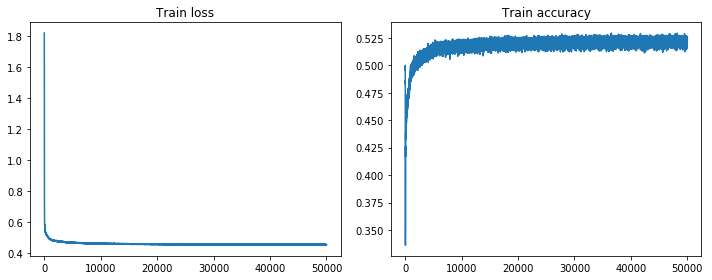

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(2 * 5, 4))
ax1.plot(train_losses)
ax1.set_title('Train loss')
ax2.plot(train_accuracies)
ax2.set_title('Train accuracy')
fig.tight_layout()

In [16]:
# Compute embeddings
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
emb = sess.run(model.z_mean, feed_dict=feed_dict)

# Compute predicted adj
adj_pred = scipy.special.expit(emb.dot(emb.T))

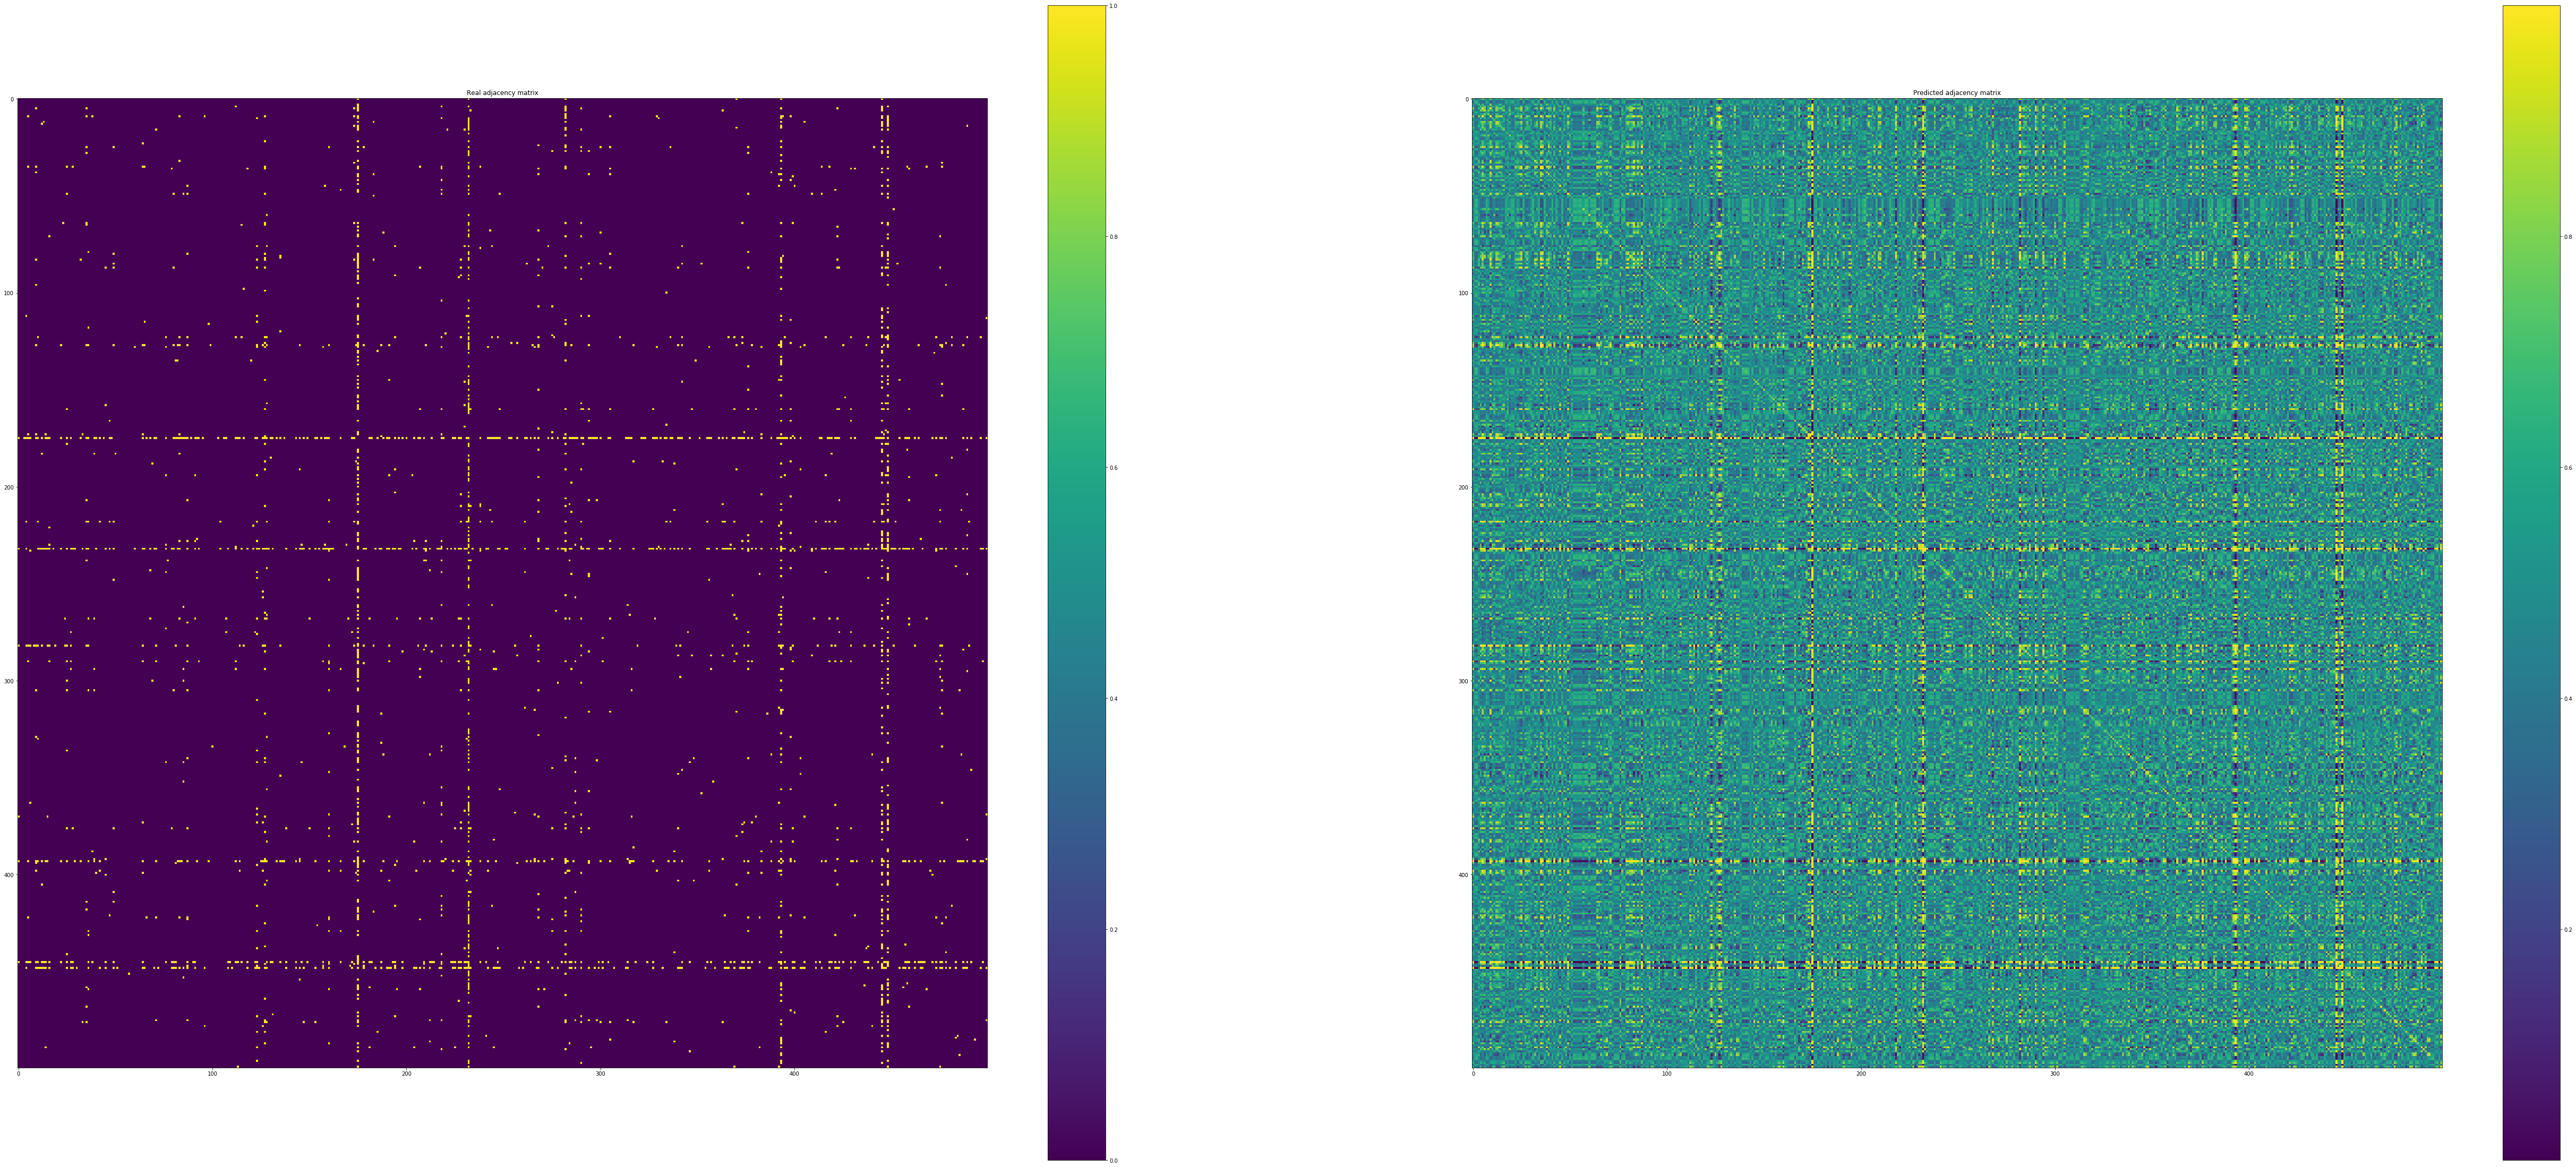

In [17]:
n_features_plot = crop

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((crop / 100) * 18, (crop / 100) * 8))

im1 = ax1.imshow(adj.toarray()[:n_features_plot, :][:, :n_features_plot])
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred[:n_features_plot, :][:, :n_features_plot])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

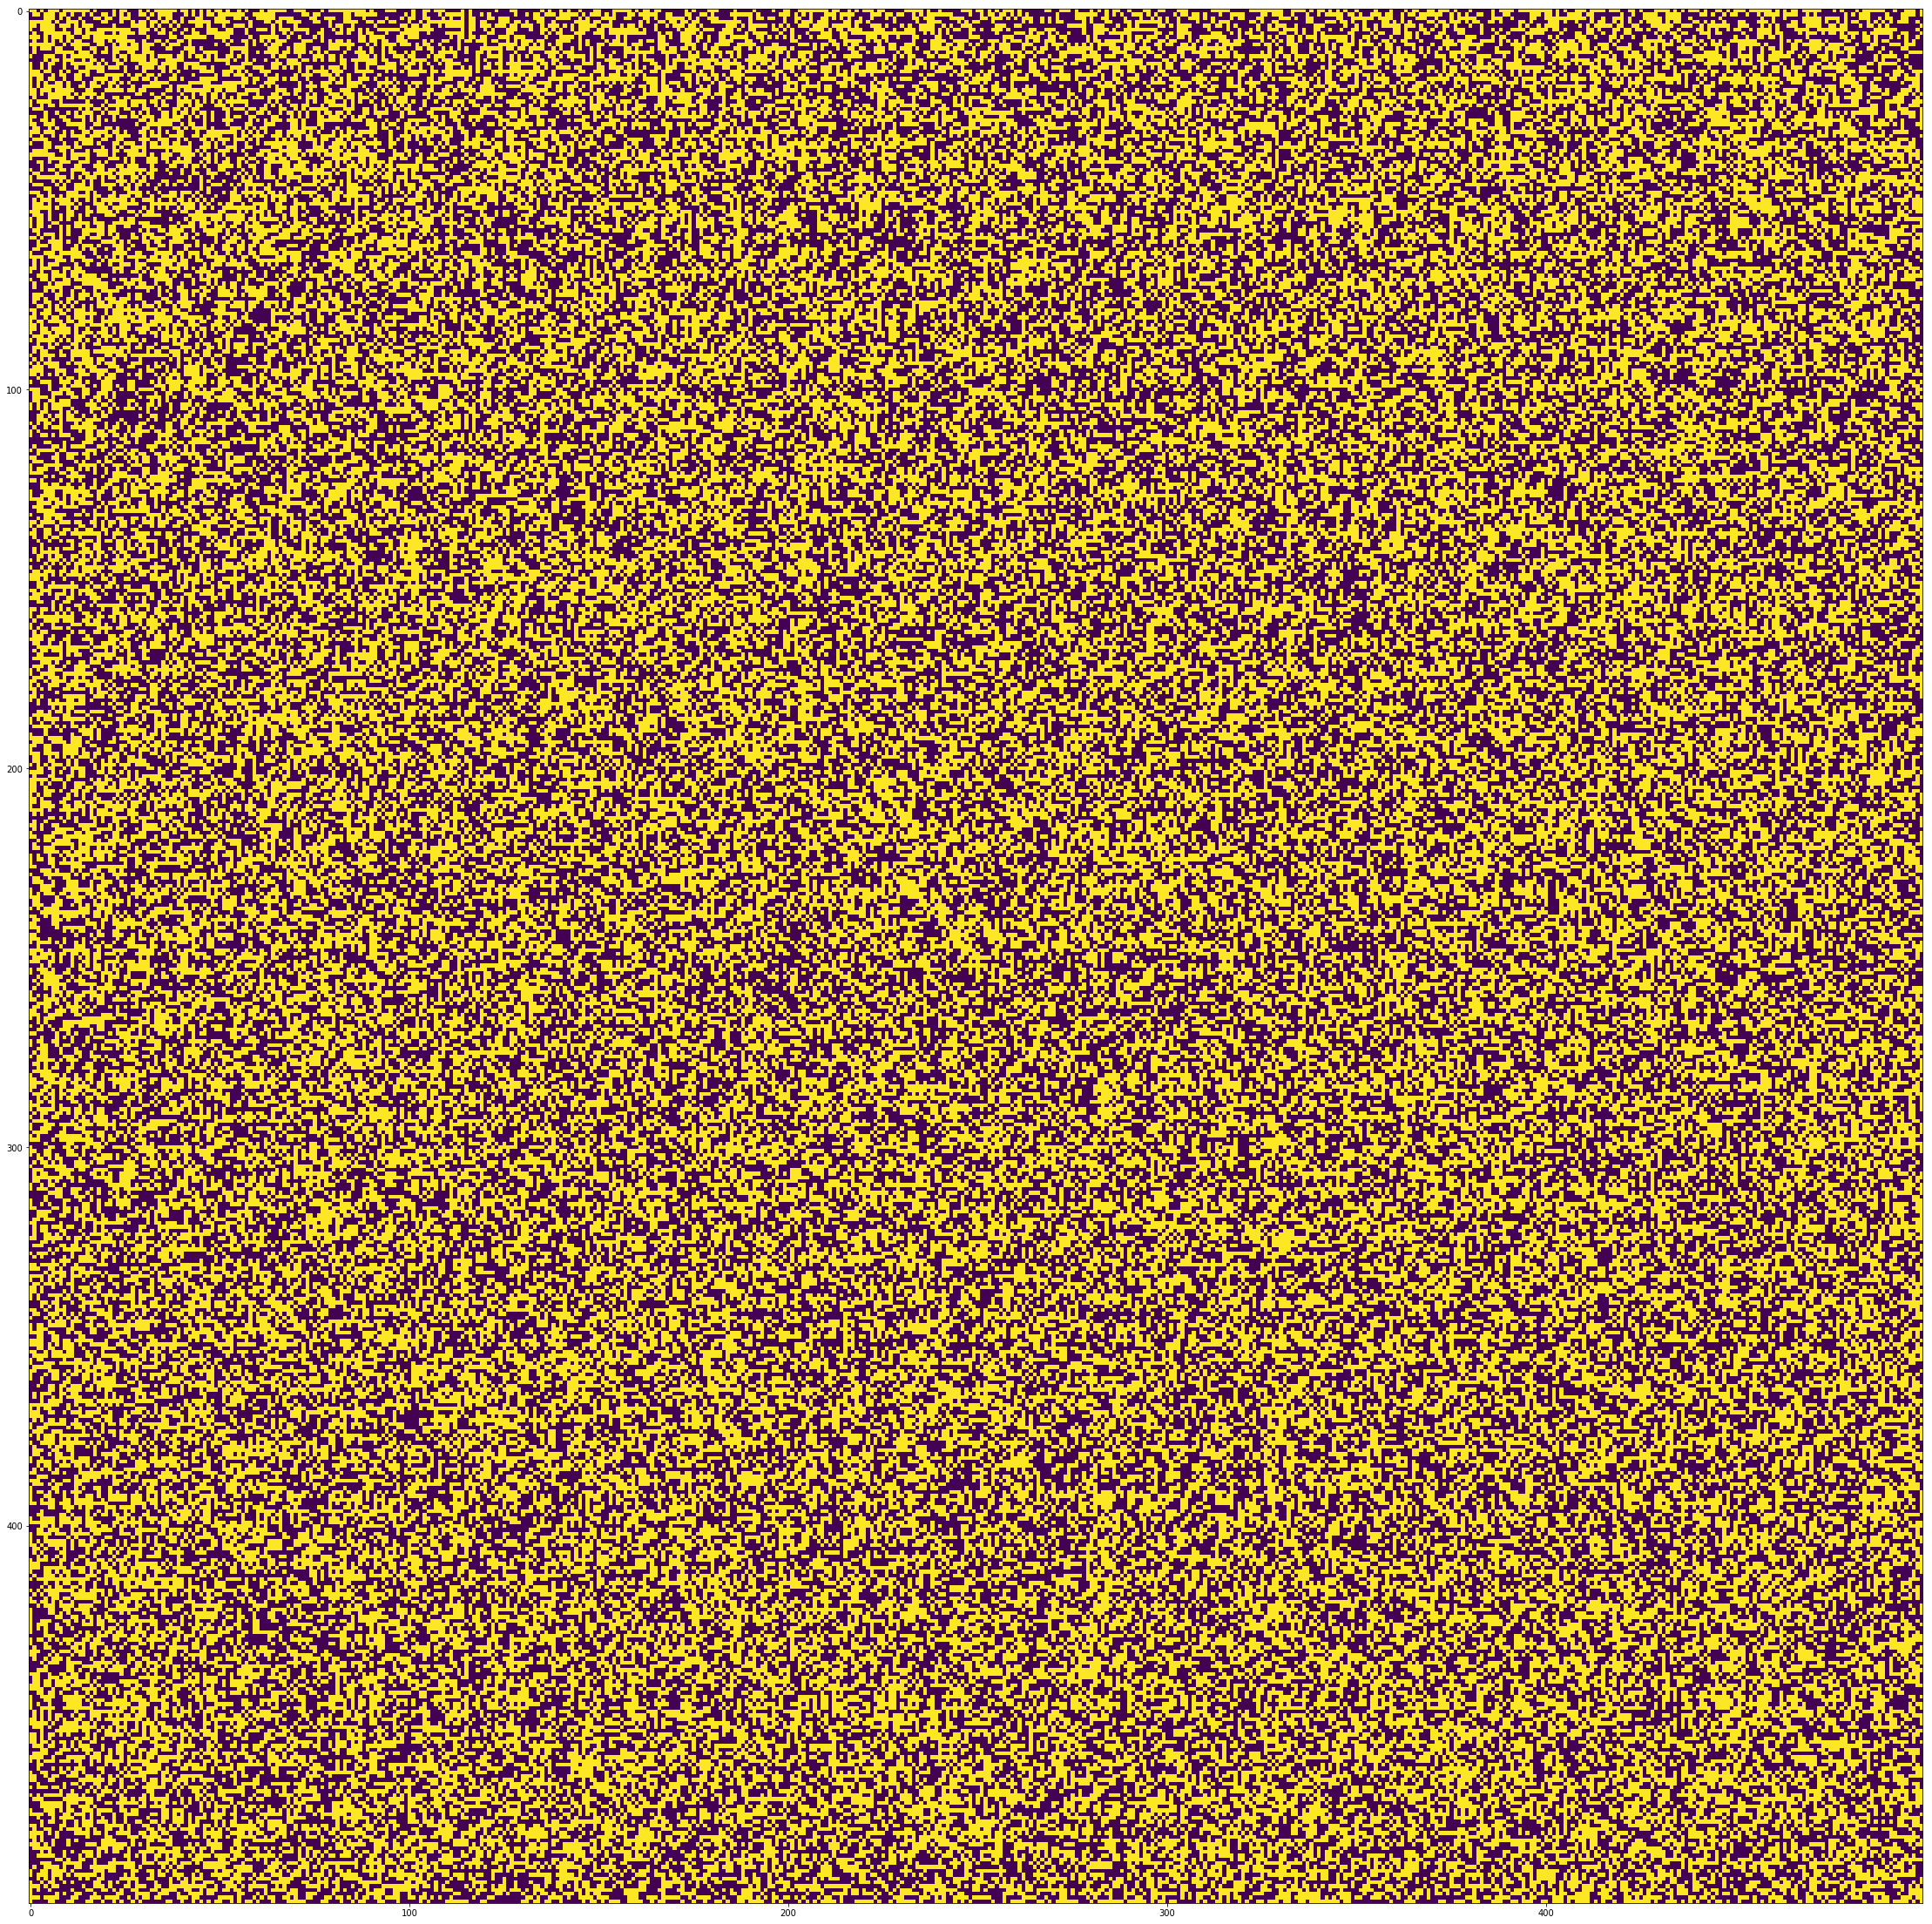

In [18]:
fig, ax = plt.subplots(1, 1, figsize=((crop / 100) * 8, (crop / 100) * 8))
ax.imshow(np.random.binomial(1, adj_pred[:n_features_plot, :][:, :n_features_plot]))

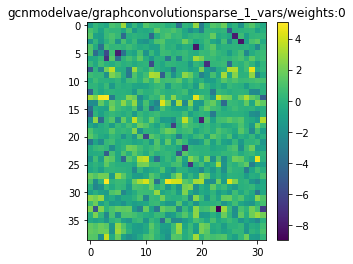

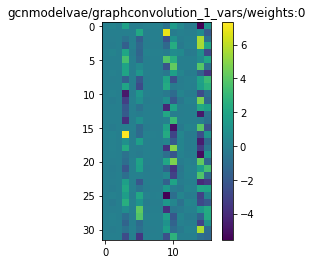

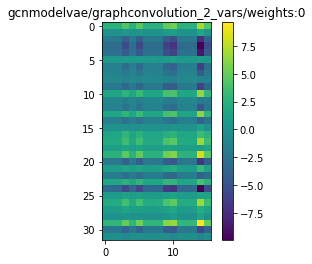

In [19]:
for var_name, var_value in model.vars.items():
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    im = ax.imshow(sess.run(var_value))
    ax.set_title(var_name)
    plt.colorbar(im, ax=ax)